In [131]:
#%pip install plotly
#%pip install --upgrade nbformat
# !pip install pygwalker

### Todo
- Liiketoiminnan erikoisammattitutkinto: henkilöstöhallinnon osaamisala
- osatutkinnot

## Esittely

- dataframes
    1. ri_kaikki_nom: RI:n kaikki opiskelijavuodet, myös muissa kuin omissa tutkinnoissa
    2. ri_omien_tutkintojen_markkinassa: RI:n netto-opiskelijamäärä järjestäjänä ja hankintakouluttajan (omat tutkinnot määritetty vuoden 2022 mukaan, voi helposti vaihtaa)
    3. rin_markkina_yhteenveto: kaikkien kouluttajien netto-opiskelijamäärä (järjestäjä ja hankinta) ja järjestäjien määrät RI:n tutkintojen markkinassa
    4. kaikki_jarjestajat_ri_tutkintomarkkina: 
    5. tutkintojen_kasvutrendit: netto-opiskelijamäärät ja koulutustentarjoajien kasvu/laskut kahden vuoden aikaikkunoissa
    6. rin_tutkinnot_toimijat_osuudet_ja_kasvu: kaikkien toimijoiden netto-opiskelijamäärät tutkinnoittain ja vuosittain. Ml. markkinaosuudet, tutkintojen kasvu, sijoitus markkinassa ja vuosikasvu (yoy)
    

- visualizations

## Data loading and setup 

#### Imports

In [132]:

# Import required libraries
import pandas as pd
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
from copy import deepcopy
import squarify
# import pygwalker as pyg
# from adjustText import adjust_text
from itertools import cycle
from datetime import datetime

#### Defaults

In [133]:
# Your brand colors
brand_colors_hex = [
    "#7dc35a",  # green
    "#006e82",  # teal
    "#674da1",  # purple
    "#7eafbb",  # grey
    "#e86b3d",  # red
    "#00b5e2",  # blue
    "#ffb500",  # yellow
    "#00263a"   # black
]

# Function to cycle through brand colors and create a large palette
def create_large_palette(base_colors, n):
    color_cycler = cycle(base_colors)
    palette = [next(color_cycler) for _ in range(n)]
    return palette

# Create a palette for a large dataset
ri_colors_large_palette = create_large_palette(brand_colors_hex, 50)  # 50 colors in the palette

# # Use the palette in a seaborn scatterplot
# sns.scatterplot(x=x_metric, y=y_metric, hue=hue_metric, data=grouped_df, palette=large_palette)


In [134]:
# Filter data for the institutions "Rastor-instituutti ry" and "Rastor Oy" (RI)
ri_institutions_list = ["Rastor-instituutti ry", "Rastor Oy","RI"]

# Get the current year
current_year = datetime.now().year
# Define the most recent complete year
most_recent_complete_year = current_year - 1

## exporting to excel and powerpoint
visualizations_for_export=[]
tables_for_excel_export={}

# slide ratio
slide_height_ratio = 9
slide_width_ratio = 16

slide_height_inches = 5.625
slide_width_inches = 10

# Defines where the top edge of the plot image should be in the powerpoint slide 
# as percentage of slide height (bottom is 0, top is 1)
plot_image_top_pct = 0.8


In [135]:
kouluttajakohtaisen_taulukon_sarakkeiden_selitteet = {
    'tilastovuosi': 'Tilastoidun datan vuosi',
    'tutkinto': 'Virallisen tutkinnon nimi',
    'nettoopiskelijamaaraLkm_as_jarjestaja': 'Kouluttajan tekemä netto-opiskelijamäärä koulutuksen järjestäjänä',
    'nettoopiskelijamaaraLkm_as_hankinta': 'Kouluttajan tekemä netto-opiskelijamäärä hankintakoulutuksen jäjestäjänä',
    'nom_tutkinto yhteensa': 'Tutkinnon netto-opiskelijamäärä yhteensä. Älä laske yhteen: luku jo valmiiksi summattu.',
    'koulutuksenJarjestaja_n': 'Tutkinnon järjestäjien lukumäärä. Älä laske yhteen: luku jo valmiiksi summattu.',
    'hankintakoulutuksenJarjestaja_n': 'Tutkinnon hankintakoulutuksen järjestäjien lukumäärä. Älä laske yhteen: luku jo valmiiksi summattu.',
    'kouluttaja': 'Kouluttajan tai organisaation nimi',
    'nom_kouluttaja yhteensa': 'Kouluttajan tutkintokohtainen netto-opiskelijamäärä yhteensä (koulutuksen järjestäjänä ja hankintakoulutuksen järjestäjänä)',
    'järjestäjä_osuus': 'Järjestäjän roolissa tehtyjen koulutusten osuus kouluttjan koko netto-opiskelijamäärästä',
    'markkinaosuus tutkinnossa (%)': 'Kouluttajan markkinaosuus kyseisessä tutkinnossa',
    'kouluttaja_tutkinto_kasvu': 'Kouluttajan kasvu tietyssä tutkinnossa',
    'tutkinto markkinakasvu (%)': 'Tutkinnon markkinakasvu',
    'markkinaosuus tutkinnossa (%)_YoY': 'Markkinaosuuden vuosittainen muutos',
    'Sijoitus markkinassa': 'Kouluttajan sijoitus markkinassa kyseisessä tutkinnossa'
}


#### Functions

In [136]:
def rename_nom(df):
    df.rename(columns={'nettoopiskelijamaaraLkm_as_jarjestaja': 'järjestäjänä', 
             'nettoopiskelijamaaraLkm_as_hankinta': 'hankintana'}, inplace=True)
    return df

In [137]:
def shorten_qualification_names(df):
    lyhennykset_dict = {'erikoisammattitutkinto':'EAT', 'ammattitutkinto':'AT'}
    df['tutkinto'] = df['tutkinto'].replace(lyhennykset_dict, regex=True)
    return df

In [138]:
#check if a string contains the current year
def check_year(string):
    if str(current_year) in string:
        return True
    else:
        return False

In [139]:
def load_data(file_path, directory):
    # Check if the file exists
    print(f"Loading data from {file_path} in directory {directory}.")
    full_file_path = directory / file_path
    if not full_file_path.exists():
        raise FileNotFoundError(f"File {file_path} not found in directory {directory}.")

    # Determine the file type (Excel or CSV) based on the extension
    file_extension = file_path.split(".")[-1].lower()

    # Load the data differently depending on the file type
    if file_extension == "xlsx":
        try:
            data = pd.read_excel(full_file_path)
        except Exception as e:
            raise ValueError(f"Error reading Excel file: {e}")
    elif file_extension == "csv":
        try:
            data = pd.read_csv(full_file_path)
        except Exception as e:
            raise ValueError(f"Error reading CSV file: {e}")
    else:
        raise ValueError("Unsupported file type. Please use .xlsx or .csv files.")

    # Check if data is empty
    if data.empty:
        raise ValueError(f"The file {file_path} is empty.")

    # If there's a need to dynamically find the header row, include the logic here
    # Example: header_row_index = data[...].index[0]
    # data = data.loc[header_row_index:]

    # Set the header row and clean the data
    # data.columns = data.iloc[0]
    # data = data[1:]
    data.reset_index(drop=True, inplace=True)

    return data

In [140]:
# yhdistä saman organisaation nimet yhden nimen alle
def replace_values_in_dataframe(df, replacement_dict):
    """
    Replace specified values in a DataFrame based on a dictionary.
    
    Parameters:
    - df: The original DataFrame
    - replacement_dict: A dictionary where the key is the new value, and the value is a list of old values to be replaced
    
    Returns:
    A new DataFrame with values replaced.
    """
    # Create a reverse mapping for replacement
    reverse_dict = {old: new for new, old_list in replacement_dict.items() for old in old_list}
    
    # Replace the values and return a new DataFrame
    return df.replace(reverse_dict)


In [141]:
def min_max_normalization(df, column_name, maximum_value=5, minimum_value=1):
    """
    Normalize a column in a DataFrame to a specified range.
    
    Parameters:
    - df: The original DataFrame
    - column_name: The name of the column to be normalized
    - maximum_value: The maximum value of the normalized column
    - minimum_value: The minimum value of the normalized column
    
    Returns:
    A new DataFrame with the normalized column.
    """
    # Find the maximum and minimum values of the column
    max_value = df[column_name].max()
    min_value = df[column_name].min()
    
    # Normalize the column and return a new DataFrame
    df[column_name] = (df[column_name] - min_value) / (max_value - min_value) * (maximum_value - minimum_value) + minimum_value
    return df

In [142]:
def calculate_cagr_for_groups(df, groupby_columns, value_column, last_year=None):
    """
    Calculates the Compound Annual Growth Rate (CAGR) for each group in a DataFrame.
    
    Parameters:
        df (DataFrame): The DataFrame containing the data. This DataFrame should have a column
            that represents years ('tilastovuosi') and another column containing the values for
            which the CAGR is to be calculated.
        
        groupby_columns (list of str): A list of column names to group the DataFrame by. The function
            will calculate the CAGR for each unique combination of values in these columns.
        
        value_column (str): The name of the column in the DataFrame containing the numerical values 
            for which the CAGR is to be calculated.
        
        last_year (int, optional): The last year to include in the CAGR calculation. This parameter
            allows for filtering the DataFrame to only include records up to a specific year.
    
    Returns:
        DataFrame: A DataFrame containing the calculated CAGR for each group, along with the
                   grouping columns for identification. The CAGR is in percentage format.
    
    Notes:
        - The function handles special cases where the start or end value is zero.
        - Infinite growth is represented by np.inf and decline to zero is represented by -np.inf.
        - The function assumes that the DataFrame contains a column 'tilastovuosi' that represents the year.
    
    Example:
        >>> df = pd.DataFrame({
                'tilastovuosi': [2018, 2019, 2018, 2019],
                'tutkinto': ['A', 'A', 'B', 'B'],
                'value': [1, 2, 1, 3]
            })
        >>> calculate_cagr_for_groups(df, ['tutkinto'], 'value')
          CAGR tutkinto
        0  100.0        A
        1  200.0        B
    """
    
    # Initialize an empty list to store individual CAGR DataFrames for each group
    cagr_list = []
    
    # Filter the DataFrame if a last_year parameter is provided
    if last_year is not None:
        df = df[df['tilastovuosi'] <= last_year]
    
    # Group the DataFrame by the columns specified in groupby_columns
    grouped = df.groupby(groupby_columns)
    
    # Iterate over each group to calculate CAGR
    for name, group in grouped:
        # Ensure there is more than one year of data for the group
        if len(group) > 1:
            # Sort the group by year to ensure start and end values are correct
            group = group.sort_values('tilastovuosi')
            
            # Get the first and last value and the number of periods (years)
            end_value = group[value_column].iloc[-1]
            start_value = group[value_column].iloc[0]
            periods = group['tilastovuosi'].iloc[-1] - group['tilastovuosi'].iloc[0]
            
            # Handle special or extreme cases for CAGR calculation
            if start_value == 0 and end_value == 0:
                cagr = 0  # No growth, value remains zero
            elif start_value == 0:
                cagr = np.inf  # Infinite growth from zero
            elif end_value == 0:
                cagr = -np.inf  # Decline to zero
            elif end_value / start_value > 1e5:  # Arbitrarily chosen threshold for "extreme" growth
                cagr = np.inf  # Represent extreme growth as infinite
            else:
                try:
                    cagr = ((end_value / start_value) ** (1 / periods) - 1) * 100  # CAGR formula
                except ZeroDivisionError:
                    cagr = np.nan  # Undefined, occurs if start and end years are the same
            
            # Prepare the DataFrame for this specific CAGR calculation
            cagr_dict = {'CAGR (%)': [cagr]}
            for col, val in zip(groupby_columns, name if isinstance(name, tuple) else [name]):
                cagr_dict[col] = [val]
            
            # Append the CAGR DataFrame for this group to the list
            cagr_list.append(pd.DataFrame(cagr_dict))
    
    # Concatenate all individual CAGR DataFrames into a single DataFrame
    cagr_df = pd.concat(cagr_list, ignore_index=True)
    
    return cagr_df


In [143]:
# not working, delete?
# Revised calculate_yoy_growth function to handle time_window=1 and ensure data is sorted by 'tilastovuosi'
def calculate_yoy_growth2(df, groupby_col, target_col, output_col, end_year, time_window, most_recent_complete_year=most_recent_complete_year):
    if end_year > most_recent_complete_year:
        raise ValueError(f"The end year must be less than or equal to the most recent complete year ({most_recent_complete_year}).")
    
    # Calculate the start year based on the end_year and time_window
    start_year = end_year - time_window + 1
    
    # Filter the DataFrame to only include data for the years in the specified range
    df_filtered = df[df['tilastovuosi'].isin(range(start_year, end_year + 1))]
    
    # Sort the DataFrame by 'tilastovuosi' (important for pct_change to work correctly)
    df_filtered = df_filtered.sort_values(by=['tilastovuosi'])
    
    # Group by the specified column and 'tilastovuosi', then aggregate the target column
    df_grouped = df_filtered.groupby([groupby_col, 'tilastovuosi']).agg({
        target_col: 'sum'
    }).reset_index()
    
    # Calculate the year-over-year change for each group using the specified time window
    # If time_window is 1, it compares each year to its immediate predecessor within the group
    df_grouped[output_col] = df_grouped.groupby(groupby_col)[target_col].pct_change(periods=time_window - 1) * 100
    
    # Filter out rows to only include the end year
    df_yoy = df_grouped[df_grouped['tilastovuosi'] == end_year].copy()
    
    # Add a column indicating the year for which the previous years are calculated
    df_yoy['tilastovuosi'] = end_year
    
    # Add a column showing the range of years used for the calculation
    df_yoy['tilastovuodet'] = f"{start_year}-{end_year}"
    
    # Classify each group as growing or declining based on the YoY change
    df_yoy[f'{output_col}_trendi'] = np.where(df_yoy[output_col] > 0, 'Kasvussa', 'Laskussa')
    
    return df_yoy[[groupby_col, output_col, f'{output_col}_trendi', 'tilastovuosi', 'tilastovuodet']]


In [144]:

def calculate_yoy_growth(df, groupby_col, target_col, output_col, end_year, time_window, most_recent_complete_year=most_recent_complete_year):
    """Calculate the Year-over-Year (YoY) growth for a specified target column.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        groupby_col (str): The column to group by.
        target_col (str): The column to calculate growth for.
        output_col (str): The column where the growth rate will be stored.
        end_year (int): The end year for the time window.
        time_window (int): The time window for the YoY calculation.
        most_recent_complete_year (int): The most recent year for which full data is available.
        
    Returns:
        pd.DataFrame: A DataFrame containing the calculated YoY growth.
        
    todo:
        time_window=1 is not working. Filtering issue?
    """
    if time_window == 1:
        # Handle the special case where time_window is 1
        start_year = end_year - 1  # The previous year becomes the start year
    else:
        # Calculate the start year based on the end_year and time_window
        start_year = end_year - time_window + 1
    
    # print(f"Calculating YoY growth for {groupby_col} and {target_col}...")
    # uncomment if you want to disable the yoy for the current year
    # if end_year > most_recent_complete_year:
        # raise ValueError(f"The end year must be less than or equal to the most recent complete year ({most_recent_complete_year}).")
        # print(f"Huom. viimeinen vuosi {most_recent_complete_year+1} ei ole vielä lopussa")
    
    # Calculate the start year based on the end_year and time_window
    start_year = end_year - time_window + 1
    
    # Filter the DataFrame to only include data for the years in the specified range
    df_filtered = df[df['tilastovuosi'].isin(range(start_year, end_year + 1))]
    
    # Group by the specified column and 'tilastovuosi', then aggregate the target column
    df_grouped = df_filtered.groupby([groupby_col, 'tilastovuosi']).agg({
        target_col: 'sum'
    }).reset_index()
    
    # Calculate the year-over-year change for each group using the specified time window
    # df_grouped[output_col] = df_grouped.groupby(groupby_col)[target_col].pct_change(periods=time_window - 1) * 100
    if time_window == 1:
        df_grouped[output_col] = df_grouped.groupby(groupby_col)[target_col].pct_change() * 100
    else:
        df_grouped[output_col] = df_grouped.groupby(groupby_col)[target_col].pct_change(periods=time_window - 1) * 100

    
    # Filter out rows to only include the end year
    df_yoy = df_grouped[df_grouped['tilastovuosi'] == end_year].copy()
    
    # Add a column indicating the year for which the previous years are calculated
    df_yoy['tilastovuosi'] = end_year
    
    # Add a column showing the range of years used for the calculation
    df_yoy['tilastovuodet'] = f"{start_year}-{end_year}"
    
    # Classify each group as growing or declining based on the YoY change
    df_yoy[f'{output_col}_trendi'] = np.where(df_yoy[output_col] > 0, 'Kasvussa', 'Laskussa')
    
    return df_yoy[[groupby_col, output_col, f'{output_col}_trendi', 'tilastovuosi', 'tilastovuodet']]


# Example usage
# koe_df = toimijoiden_markkinaosuudet_kasvu.copy()
# result_df1 = calculate_yoy_growth(koe_df, 'tutkinto', 'nettoopiskelijamaaraLkm_as_jarjestaja', 'opiskelijoiden mamäärän kasvu (%)', 2022, 3)
# result_df2 = calculate_yoy_growth(koe_df, 'tutkinto', 'koulutuksenJarjestaja_n', 'tarjoajien määrän kasvu (%)', 2022, 2)


In [145]:
# Define a function to calculate the variable-year YoY growth trend for a DataFrame
# old version, remove?
def calculate_variable_year_growth_trend_with_year(df, start_year, end_year, time_window):
    """Calculate the variable-year YoY growth trend for a DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        start_year (int): The first year in the variable-year range.
        end_year (int): The last year in the variable-year range.
        time_window (int): Number of years in the time window.
        
    Returns:
        pd.DataFrame: A DataFrame containing the variable-year YoY growth trend.
    """
    
    # Calculate the number of years including both start and end years
    years = end_year - start_year + 1  
    
    # Filter the DataFrame to include data only for the specified range of years
    df_filtered = df[df['tilastovuosi'].isin(range(start_year, end_year + 1))]
    
    # Group by 'tutkinto' and 'tilastovuosi' and sum the 'nettoopiskelijamaara'
    df_grouped = df_filtered.groupby(['tutkinto', 'tilastovuosi']).agg({
        'nettoopiskelijamaaraLkm_as_jarjestaja': 'sum'
    }).reset_index()
    
    # Calculate the total 'nettoopiskelijamaara' for each group
    df_grouped['total_nettoopiskelijamaara'] = df_grouped['nettoopiskelijamaaraLkm_as_jarjestaja']
    
    # Calculate the year-over-year change for each 'tutkinto' using a custom period
    df_grouped[f'nom_muutos (%) ed. {time_window}v'] = df_grouped.groupby('tutkinto')['total_nettoopiskelijamaara'].pct_change(periods=time_window-1) * 100
    
    # Filter out rows to only include the end year
    df_yoy = df_grouped[df_grouped['tilastovuosi'] == end_year].copy()
    
    # Add a column indicating the year for which the previous years are calculated
    df_yoy['tilastovuosi'] = end_year + 1
    
    # Classify each 'tutkinto' as growing or declining based on the YoY change
    df_yoy['nom_trendi'] = np.where(df_yoy[f'nom_muutos (%) ed. {time_window}v'] > 0, 'Nousussa', 'Laskussa')
    
    return df_yoy[['tutkinto', f'nom_muutos (%) ed. {time_window}v', 'nom_trendi', 'tilastovuosi']]



In [146]:
def calculate_yoy_change_providers(df):
    """Calculate the Year-over-Year (YoY) change in the number of providers for each qualification.
    
    Parameters:
        df (DataFrame): The input DataFrame containing the data.
        
    Returns:
        DataFrame: A DataFrame containing the YoY change in the number of providers.
    """
    
    # Group by 'tutkinto' and 'tilastovuosi' and calculate the number of providers
    grouped_df = df.groupby(['tutkinto', 'tilastovuosi'])['koulutuksenJarjestaja_n'].sum().reset_index()
    
    # Initialize an empty DataFrame to store the results
    result_df = pd.DataFrame()
    
    # Loop through each unique 'tutkinto'
    for tutkinto in grouped_df['tutkinto'].unique():
        # Filter the grouped DataFrame for each 'tutkinto'
        temp_df = grouped_df[grouped_df['tutkinto'] == tutkinto].copy()
        
        # Calculate the YoY percentage change for the number of providers
        temp_df['muutos tarjoajien määrässä (%)'] = temp_df['koulutuksenJarjestaja_n'].pct_change() * 100
        
        # Append the temporary DataFrame to the result DataFrame
        result_df = pd.concat([result_df, temp_df])
    
    # Reset the index of the result DataFrame
    result_df.reset_index(drop=True, inplace=True)
    
    return result_df[['tutkinto', 'tilastovuosi', 'muutos tarjoajien määrässä (%)']]

# Example usage:
# result_df = calculate_yoy_change_providers(df)


In [147]:
def calculate_multiple_yoy_growth(df, variables_dict, time_window, groupby_col, most_recent_complete_year):
    """
    Calculate YoY growth for multiple variables and time-windows.
    
    Args:
        df (pd.DataFrame): Original DataFrame containing the data.
        variables (list): List of variables for which to calculate YoY growth.
        time_windows (list): List of time-windows for YoY growth calculations.
        groupby_col (str): Column to group by (e.g., 'tutkinto').
        most_recent_complete_year (int): The most recent complete year for which data is available.
        
    Returns:
        pd.DataFrame: DataFrame containing YoY growth calculations for multiple variables and time-windows.
    """
    dfs_dict = {}
        
    for key, value in variables_dict.items():
        dfs = []
        unique_years = sorted(df['tilastovuosi'].unique())
        # print(unique_years[time_window:])
        unique_groupby_values = df[groupby_col].unique()
        
        for group_value in unique_groupby_values:
            df_filtered = df[df[groupby_col] == group_value]
            # start from the second year as 1st year doesn't have a YoY value           
            for year in unique_years[1:]:
                # Only consider years up to the most recent complete year
                # if year > most_recent_complete_year:
                #     continue
                years_list = [year-x for x in reversed(range(time_window))]
                # print(years_list)
                df_years = df_filtered[df_filtered['tilastovuosi'].isin(years_list)]
                df_yoy = calculate_yoy_growth(
                    df=df_years, groupby_col=groupby_col,
                    target_col=key, output_col=value,
                    time_window=time_window,
                    end_year=years_list[-1])
                dfs.append(df_yoy)
        
        dfs_dict[key] = pd.concat(dfs, ignore_index=True)
        
    # Now merge the resulting DataFrames stored in dfs_dict
    result_df = dfs_dict.popitem()[1]
    for _, df in dfs_dict.items():
        result_df = pd.merge(result_df, df, on=[groupby_col, 'tilastovuosi', 'tilastovuodet'], how='outer')
        
    return result_df


In [148]:
def wrap_text(text, wrap_limit=18):
    words = text.split()
    lines = []
    current_line = ""
    remaining_text = text

    while len(remaining_text) > wrap_limit:
        # Find the last space within wrap_limit
        split_at = remaining_text.rfind(" ", 0, wrap_limit)
        if split_at == -1:  # No space found within wrap_limit
            split_at = wrap_limit  # Force a split

        lines.append(remaining_text[:split_at])
        remaining_text = remaining_text[split_at:].strip()

    lines.append(remaining_text)

    return "\n".join(lines)

In [149]:
def wrap_text_dynamic(text, wrap_limit):
    words = text.split()
    lines = []
    current_line = ""
    
    for word in words:
        # If appending the new word doesn't exceed the limit or if the word is a number, append it.
        if len(current_line) + len(word) <= wrap_limit or word.replace('.', '', 1).isdigit():
            current_line += (word + " ")
        else:
            # Special case: if the word contains a hyphen, break after the hyphen
            if '-' in word:
                part1, part2 = word.split('-', 1)
                lines.append((current_line + part1 + "-").strip())
                current_line = part2 + " "
            else:
                # Otherwise, store the current line and start a new one
                lines.append(current_line.strip())
                current_line = word + " "
    
    lines.append(current_line.strip())
        
    return "\n".join(lines)


In [150]:
def sum_new_columns(df, suffixes=['_as_jarjestaja', '_as_hankinta']):
    """
    Sum the corresponding columns with the given suffixes.
    
    Parameters:
        df (DataFrame): The DataFrame containing the columns to sum.
        suffixes (list): A list of suffixes used to identify the columns to sum.
        
    Returns:
        Series: The sum of the columns for each row.
    """
    # Loop through each suffix to find the corresponding columns
    for suffix in suffixes:
        for col in df.columns:
            if col.endswith(suffix):
                original_col = col.replace(suffix, '')
                col1 = original_col + suffixes[0]
                col2 = original_col + suffixes[1]
                
    return (df[col1] + df[col2])

In [151]:
def hae_tutkinto_nom(df, role, qualifications):
    """
    Get the yearly metrics for specific qualifications, filtered by a particular role.
    
    Parameters:
        df (DataFrame): The DataFrame containing the educational data.
        role (str): The role of the institution (either 'koulutuksenJarjestaja' or 'hankintakoulutuksenJarjestaja').
        qualifications (list): List of qualifications to focus on.
        
    Returns:
        DataFrame: Aggregated yearly metrics for the specified qualifications and role.
    """
    # Define the columns to be used in grouping
    columns = ['tilastovuosi', 'tutkinto']
    
    # Filter the DataFrame based on the list of qualifications
    filtered_df = df[df['tutkinto'].isin(qualifications)]
    
    # Append the role to the list of columns and group by those columns
    columns.append(role)
    filtered_df = filtered_df.groupby(by=columns)['nettoopiskelijamaaraLkm'].sum().reset_index()
    
    # Remove rows where the role information is missing
    filtered_df = filtered_df[filtered_df[role] != 'Tieto puuttuu']
    
    print(f"{role} {filtered_df.shape}")
    return filtered_df

In [152]:
def hae_tutkinnon_suurimmat_toimijat(df, year, top_n=5):
    """
    Get the top 5 institutions for each qualification for a given year.
    
    Parameters:
        df (DataFrame): The DataFrame containing the educational data.
        year (int): The year to get the top 5 institutions for.
        
    Returns:
        dict: A dictionary with qualification as the key and a list of the top 5 institutions for that qualification as the value.
    """
    # Filter the DataFrame to only include the given year
    # filtered_df = df[df['tilastovuosi'] == year]
    filtered_df = df.query("tilastovuosi == @year and `Sijoitus markkinassa` <= @top_n")
    
    # Group the data by qualification and get the top 5 institutions for each qualification
    top_n_by_qualification = filtered_df.groupby('tutkinto')['kouluttaja'].apply(list).to_dict()
    
    return top_n_by_qualification


In [153]:
def hae_tutkinnon_suurimmat_nousijat(df, year, top_n=5):
    """
    Get the top 5 institutions for each qualification for a given year.
    
    Parameters:
        df (DataFrame): The DataFrame containing the educational data.
        year (int): The year to get the top 5 institutions for.
        
    Returns:
        dict: A dictionary with qualification as the key and a list of the top 5 institutions for that qualification as the value.
    """
    # Filter the DataFrame to only include the given year
    # filtered_df = df[df['tilastovuosi'] == year]
    filtered_df = df.query("tilastovuosi == @year and `Sijoitus markkinassa` <= @top_n")
    
    # Group the data by qualification and get the top 5 institutions for each qualification
    top_n_by_qualification = filtered_df.groupby('tutkinto')['kouluttaja'].apply(list).to_dict()
    
    return top_n_by_qualification


In [154]:
def hae_kouluttaja_nom(
        df, 
        kouluttaja=ri_institutions_list,
        nom_as_jarjestaja='nettoopiskelijamaaraLkm', 
        nom_as_hankinta='nettoopiskelijamaaraLkm'
    ):
    """
    Get the yearly metrics for a specific educational institution, separated by roles as main organizer and 
    as contracted training arranger.
    
    Parameters:
        df (DataFrame): The DataFrame containing the educational data.
        kouluttaja (list): List of institutions to focus on. Defaults to ['RI, 'Rastor Oy', 'Rastor-instituutti ry']
        nom_as_jarjestaja (str): Column name representing the metric as main organizer.
        nom_as_hankinta (str): Column name representing the metric as contracted training arranger.
        
    Returns:
        DataFrame: Aggregated yearly metrics for the specified institution.
    """
    # Filter the DataFrame for rows where the institution is the main organizer and aggregate by year
    df_koulutuksenjarjestaja = df[df['koulutuksenJarjestaja'].isin(kouluttaja)].groupby(by=['tilastovuosi', 'koulutuksenJarjestaja'])[nom_as_jarjestaja].sum().reset_index()
    
    # Filter the DataFrame for rows where the institution is the contracted training arranger and aggregate by year
    df_hankintakoulutuksenjarjestaja = df[df['hankintakoulutuksenJarjestaja'].isin(kouluttaja)].groupby(by=['tilastovuosi', 'hankintakoulutuksenJarjestaja'])[nom_as_hankinta].sum().reset_index()
    
    suffixes = ('_as_jarjestaja', '_as_hankinta')
    
    # Rename the organization columns to a common name for merging
    df_koulutuksenjarjestaja.rename(columns={'koulutuksenJarjestaja': 'kouluttaja'}, inplace=True)
    df_hankintakoulutuksenjarjestaja.rename(columns={'hankintakoulutuksenJarjestaja': 'kouluttaja'}, inplace=True)
    
    # Merge the two DataFrames on year and institution
    df_molemmat = pd.merge(
        df_koulutuksenjarjestaja, 
        df_hankintakoulutuksenjarjestaja, 
        on=['tilastovuosi', 'kouluttaja'], 
        how='outer',
        suffixes=suffixes
    )
    
    # Calculate the sum of nettoopiskelijamaaraLkm_as_jarjestaja and nettoopiskelijamaaraLkm_as_hankinta
    df_molemmat['Yhteensä'] = sum_new_columns(df_molemmat)
    
    ## Proportion of students served by the institution as koulutuksenJarjestaja to the total number of students 
    # 1 => all students were served by the institution as koulutuksenJarjestaja
    # 0 => none of the students were served by the institution as koulutuksenJarjestaja
    df_molemmat['järjestäjä_osuus (%)'] = df_molemmat[nom_as_jarjestaja + suffixes[0]] / df_molemmat['Yhteensä']*100
    
    return df_molemmat

#### Visualization helpers

In [155]:
# Unviersal settings for titles and sources
universal_title_settings_axes = {"loc": "left", "fontsize": 18, "pad": 35}
universal_title_settings_figure = {"fontsize": 18}
universal_source_settings = {
    "x": 0.5,
    "y": 0,
    "ha": "center",
    "fontsize": 10,
    "alpha": 0.7,
}

def set_plot_title_subtitle(
    obj,
    title=None,
    subtitle=None,
    x=0.125,
    y=0.915,
    fontsize=18,
    fontweight=None,
):
    if isinstance(obj, plt.Figure):
        updated_title_settings = {
            **universal_title_settings_figure,
            "fontsize": fontsize,
            "fontweight": fontweight,
        }
        if title:
            obj.suptitle(title, x=0.3, y=0.98, **updated_title_settings)
        if subtitle:
            obj.text(x, y, subtitle + "\n\n", ha="left", va="center", fontsize=16, color="gray")

    elif isinstance(obj, plt.Axes):
        updated_title_settings = {
            **universal_title_settings_axes,
            "fontsize": fontsize,
            "fontweight": fontweight,
        }
        if title:
            obj.set_title(title, **updated_title_settings)
        if subtitle:
            obj.figure.text(x, y, subtitle, ha="left", va="center", fontsize=12, color="gray")
    
# def set_plot_source2(
#     obj,
#     source,
#     source_x=None,
#     source_y=None,
#     source_ha=None,
#     fontsize=None,
#     vertical_alignment='top',  # Added vertical alignment parameter
#     padding=5  # Added padding parameter
# ):
#     source_settings = universal_source_settings.copy()
#     if source_x is not None:
#         source_settings["x"] = source_x
#     if source_y is not None:
#         source_settings["y"] = source_y
#     if source_ha is not None:
#         source_settings["ha"] = source_ha
#     if fontsize is not None:
#         source_settings["fontsize"] = fontsize

#     # Adjust the vertical position to account for padding, defaulting to the top of the text
#     source_settings['va'] = vertical_alignment

#     # Calculate the adjusted position based on the padding and the current figure size
#     bbox = obj.figure.get_window_extent().transformed(obj.figure.dpi_scale_trans.inverted())
#     adjusted_y = bbox.y0 + padding / obj.figure.dpi  # Adjust the y position based on padding and dpi

#     # Use the adjusted y position if no specific y position is provided
#     source_settings["y"] = adjusted_y if source_y is None else source_y

#     obj.figure.text(**source_settings, s=source)
    
def set_plot_source(
    obj,
    source,
    fontsize=10,
    padding=20,  # Padding from bottom in points
    align_with='left'
):
    """
    Set the source text on a matplotlib figure.

    This function places a source text at a specified position on the figure. The position
    is determined relative to the bounding box of the axes object (`obj`) and the alignment
    parameter (`align_with`).

    Parameters:
    - obj (matplotlib.axes.Axes): The axes object of the figure where the source text is to be added.
    - source (str): The text to be displayed as the source.
    - fontsize (int): The font size of the source text.
    - padding (int): The padding from the bottom of the figure in points. A positive value
                     moves the source text up from the bottom edge of the figure.
    - align_with (str): The side of the axes bounding box with which to align the source text.
                        Accepts 'right' or 'left'.

    Raises:
    - ValueError: If `align_with` is not 'right' or 'left'.
    """

    # Get the bounding box of the axes object in normalized figure coordinates
    bbox = obj.get_position()
    
    # Determine the x coordinate for the text based on alignment choice
    if align_with == 'right':
        # Align with the right edge of the axes bounding box
        source_x = bbox.x1
    elif align_with == 'left':
        # Align with the left edge of the axes bounding box
        source_x = bbox.x0
    else:
        # Raise an error if `align_with` is neither 'right' nor 'left'
        raise ValueError("align_with must be 'right' or 'left'")
    
    # Convert the padding from points to a fraction of the figure height
    # to get the y coordinate for the text in normalized figure coordinates
    padding_frac = padding / (obj.figure.dpi * obj.figure.get_size_inches()[1])
    source_y = padding_frac

    # Set the source text at the calculated position using figure coordinates
    obj.figure.text(
        source_x, source_y, source,
        ha='left', va='bottom',
        fontsize=fontsize, alpha=0.7,
        transform=obj.figure.transFigure
    )


def add_text_annotations(ax, data, max_value=5):
    dark_threshold = max_value / 2
    for (row, col), value in np.ndenumerate(data):
        color = "white" if value > dark_threshold else "black"
        ax.text(
            col + 0.5,
            row + 0.5,
            f"{value:.2f}",
            color=color,
            fontsize=11,
            ha="center",
            va="center",
        )


def set_color_map(ax, color_map):
    """
    Set the color map for a Seaborn plot.

    Parameters:
    ax: The plot axis.
    color_map: The color map to apply.
    """
    ax.set_cmap(color_map)


def customize_spines_and_grid(
    ax, spine_visibility=[True, True, True, True], spine_width=1, spine_color="gray"
):
    """
    Customize the spines and grid for a plot.

    Parameters:
    ax: The plot axis.
    spine_width: The width of the spines.
    spine_color: The color of the spines.
    """
    # Manually set the spines
    ax.spines["left"].set_visible(spine_visibility[0])
    ax.spines["right"].set_visible(spine_visibility[1])
    ax.spines["top"].set_visible(spine_visibility[2])
    ax.spines["bottom"].set_visible(spine_visibility[3])

    ax.spines["left"].set_color(spine_color)
    ax.spines["right"].set_color(spine_color)
    ax.spines["top"].set_color(spine_color)
    ax.spines["bottom"].set_color(spine_color)

    ax.spines["left"].set_linewidth(spine_width)
    ax.spines["right"].set_linewidth(spine_width)
    ax.spines["top"].set_linewidth(spine_width)
    ax.spines["bottom"].set_linewidth(spine_width)


def set_axis_labels(ax, xlabel, ylabel, x_fontsize=12, y_fontsize=12, labelpad=5):
    """
    Set the axis labels for a plot.

    Parameters:
    ax: The plot axis.
    xlabel: The label for the x-axis.
    ylabel: The label for the y-axis.
    x_fontsize: Font size for x-axis label.
    y_fontsize: Font size for y-axis label.
    labelpad: Padding for the labels.
    """
    ax.set_xlabel(xlabel, fontsize=x_fontsize, labelpad=labelpad)
    ax.set_ylabel(ylabel, fontsize=y_fontsize, labelpad=labelpad)

def set_ticklabel_size(ax, fontsize=14):
    """
    Set the fontsize of tick labels for both x-axis and y-axis.

    Parameters:
    ax (matplotlib.axes.Axes): The Axes object to modify.
    fontsize (int): The fontsize to set for the tick labels.

    Returns:
    None
    """
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

def set_plot_legend(
    ax, 
    labels=None, 
    title=None, 
    location='upper right', 
    fontsize=10, 
    title_fontsize=12,
    edgecolor='gray'
):
    """
    Set the legend for a plot.

    Parameters:
    ax: The plot axis.
    labels: Legend labels. If None, the labels are taken from the plot.
    title: Title for the legend.
    location: Position of the legend.
    fontsize: Font size for the legend items.
    title_fontsize: Font size for the legend title.
    edgecolor: Border color for the legend.
    """
    legend = ax.legend(labels=labels, title=title, loc=location, fontsize=fontsize, edgecolor=edgecolor)
    if legend:
        legend.get_title().set_fontsize(title_fontsize)



def reset_plot_style():
    plt.style.use("default")
    plt.rcParams.update(plt.rcParamsDefault)

In [156]:
def plot_stackplot(df, x, y1, y2, title=None, source=None, x_label=None, y_label=None):
    plt.style.use('../data/styles/ri_right_edge_plot_style.mplstyle')
    
    # Calculate the new figure size with the additional margin
    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height

    # Create the figure with the new dimensions, accounting for additional space above the plot
    fig, ax = plt.subplots(figsize=(fig_width, new_fig_height))

    # Create the stackplot
    ax.stackplot(df[x], df[y1], df[y2], labels=[y1, y2], alpha=0.6)

    # Use helper functions to customize
    customize_spines_and_grid(ax, [False, False, True, True], spine_color="whitesmoke", spine_width=0.5)
    set_axis_labels(ax, x_label, y_label, x_fontsize=14, y_fontsize=14, labelpad=10)
    
    # For source text, align_with='left' will position the text at the left edge of the axis
    set_plot_source(ax, fontsize=12, source=source, padding=-10, align_with='left')

    # Adjust the padding of the subplots to allocate space for the margin
    # margin_top_pct = additional_margin_inches / new_fig_height
    fig.subplots_adjust(top=plot_image_top_pct, bottom=0.1, left=0.1, right=0.9)
    ax.legend(loc="lower left")

    fig_copy = deepcopy(fig)
    
    # For title and subtitle
    set_plot_title_subtitle(ax, title=title, fontsize=28, fontweight='bold')

    # Show legend
   
    reset_plot_style()

    # Return the figure for further manipulation if needed
    return (fig_copy, title), fig


In [157]:
## Function for creating stackplots   


def plot_stackplot2(df,x,y1,y2,title=None,source=None,x_label=None,y_label=None):
    plt.style.use('../data/styles/ri_right_edge_plot_style.mplstyle')

    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height

    # Create the figure with the new dimensions, accounting for additional space above the plot
    fig, ax = plt.subplots(figsize=(fig_width, new_fig_height))

    # # Create the stackplot
    ax.stackplot(df[x], df[y1], df[y2], labels=[y1,y2], alpha=0.6)

    # Use helper functions to customize
    customize_spines_and_grid(ax, [False, False, True, True], spine_color="whitesmoke", spine_width=0.5)
    set_axis_labels(ax, x_label,y_label,x_fontsize=14, y_fontsize=14, labelpad=10)
    
    # For source text
    # set_plot_source(ax, source_ha='right', source=source)
    set_plot_source(ax, fontsize=12, source=source, padding=-50, align_with='left')
     # Adjust the padding of the subplots if needed
     
    fig.subplots_adjust(top=plot_image_top_pct, bottom=0.1, left=0.1, right=0.9)
    
    fig_copy = deepcopy(fig)
    
    #  For title and subtitle
    set_plot_title_subtitle(ax, title=title, fontsize=28, fontweight='bold')

    # Show legend
    ax.legend(loc="best")
    reset_plot_style()
    return (fig_copy, title), fig

In [158]:

def plot_generic_growth_comparison(
    df, 
    filter_conditions,  # a dictionary of conditions like {'tilastovuosi': year, 'tutkinto': qualification}
    growth_column, 
    category_column,  # replaces 'kouluttaja_column'
    title_template,  # a template string that can be formatted with filter_conditions
    detail_column=None,
    source=None, 
    y_label_wrap_length=18,
    y_label_fontsize=10,
    x_label=None, y_label=None, 
    colors=None,
    limit=None  # New parameter, if None, no limit is applied, if an int, top and bottom 'limit' are shown
):
    plt.style.use('../data/styles/ri_right_edge_plot_style.mplstyle')
    
    # Build the query string
    if len(filter_conditions) != 0:
        query_string = ' and '.join([f"{k} == @{k}" for k in filter_conditions])
        # Apply filters using the query string and the local_dict parameter
        df_filtered = df.query(query_string, local_dict=filter_conditions)
    df_filtered = df.copy()
    # print(df_filtered.columns)
    
    # Check if a limit is applied
    if limit is not None:
        # Get the top and bottom performers based on the limit
        df_top = df_filtered.nlargest(limit, growth_column, keep='all')
        df_bottom = df_filtered.nsmallest(limit, growth_column, keep='all')
        # Concatenate the top and bottom growth dataframes
        df_sorted = pd.concat([df_top, df_bottom]).sort_values(by=growth_column, ascending=True)
    else:
        # Sort the dataframe by growth column without limiting
        df_sorted = df_filtered.sort_values(by=growth_column, ascending=True)
    
    
    # Format title based on conditions
    title = title_template.format(**filter_conditions)

    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height

    # Create the figure with the new dimensions, accounting for additional space above the plot
    fig, ax = plt.subplots(figsize=(fig_width, new_fig_height))

    # Create a bar plot for each 'kouluttaja'
    ax.barh(df_sorted[category_column], df_sorted[growth_column],color=colors, alpha=1)
    
    # Use helper functions to customize
    customize_spines_and_grid(ax, [False, False, True, True], spine_color="whitesmoke", spine_width=0.5)
        # Wrap the y-axis labels

    set_axis_labels(ax, x_label, y_label, x_fontsize=14, y_fontsize=14, labelpad=5)
    
    
    # add additional info (market share percentage or nom) to the y-axis labels
    if detail_column is not None:
        if str('%') in detail_column:
            ending=' %)'
        else:
            ending=')'
        df_sorted['y_label'] = df_sorted[category_column] + ' (' + df_sorted[detail_column].astype(int).astype(str) + ending
        wrapped_labels = [wrap_text(label, y_label_wrap_length) for label in df_sorted['y_label']]
    else:
        wrapped_labels = [wrap_text(label, y_label_wrap_length) for label in df_sorted[category_column]]

    ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)

    # Draw custom lines for each 'kouluttaja'
    x_min, x_max = ax.get_xlim()
    for index, value in enumerate(df_sorted[growth_column]):
        if value > 0:
            # For positive bars, draw line from the end of the bar to the max x-axis value
            ax.hlines(y=index, xmin=value, xmax=x_max, color='gray', lw=0.5)
        else:
            # For negative bars, draw line from the start of the bar to the min x-axis value
            ax.hlines(y=index, xmin=0, xmax=x_max, color='gray', lw=0.5)
    
    ax.grid(False)
    
    # To use the function:
    set_plot_source(ax, fontsize=14, source=source, padding=-5, align_with='left')
    
    # Adjust the padding of the subplots if needed
    fig.subplots_adjust(top=plot_image_top_pct, bottom=0.1, left=0.1, right=0.9)
    
    # save for export
    fig_copy = deepcopy(fig)

    #  For title and subtitle
    set_plot_title_subtitle(ax, title=title, fontsize=28, fontweight='bold')

    reset_plot_style()

    # Return the figure for further manipulation if needed
    return (fig_copy, title), fig


In [159]:
def plot_growth_comparison(df, year, qualification, 
    top_n, yoy_growth_column, 
    kouluttaja_column, 
    title=None, source=None, 
    y_label_wrap_length=18,
    x_label=None, y_label=None, 
    colors=None
    ):
    
    plt.style.use('../data/styles/ri_right_edge_plot_style.mplstyle')
    # Filter for the latest year and for the top and bottom growth
    df_latest_year = df.query("tilastovuosi == @year and tutkinto == @qualification")
    df_top_growth = df_latest_year.nlargest(top_n, yoy_growth_column, keep='all')
    df_bottom_growth = df_latest_year.nsmallest(top_n, yoy_growth_column, keep='all')
    title = f'{qualification}: {title}'

    # Concatenate the top and bottom growth dataframes
    df_growth = pd.concat([df_top_growth, df_bottom_growth])

    # Sort the dataframe by 'tutkinto' and then by the growth column
    df_growth_sorted = df_growth.sort_values(by=[yoy_growth_column], ascending=True)

    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height

    # Create the figure with the new dimensions, accounting for additional space above the plot
    fig, ax = plt.subplots(figsize=(fig_width, new_fig_height))
        
    # fig.patch.set_edgecolor('red')  # Set the color of the edge to black
    # fig.patch.set_linewidth(10)        # Set the width of the line to 2

    # Create a bar plot for each 'kouluttaja'
    ax.barh(df_growth_sorted[kouluttaja_column], df_growth_sorted[yoy_growth_column],color=colors, alpha=1)
    
    # Use helper functions to customize
    customize_spines_and_grid(ax, [False, False, True, True], spine_color="whitesmoke", spine_width=0.5)
        # Wrap the y-axis labels

    set_axis_labels(ax, x_label, y_label, x_fontsize=14, y_fontsize=14, labelpad=5)
    # print(df_growth_sorted[kouluttaja_column])
    wrapped_labels = [wrap_text(label, y_label_wrap_length) for label in df_growth_sorted[kouluttaja_column]]

    ax.set_yticklabels(wrapped_labels, va='center')

    # Draw custom lines for each 'kouluttaja'
    x_min, x_max = ax.get_xlim()
    for index, value in enumerate(df_growth_sorted[yoy_growth_column]):
        if value > 0:
            # For positive bars, draw line from the end of the bar to the max x-axis value
            ax.hlines(y=index, xmin=value, xmax=x_max, color='gray', lw=0.5)
        else:
            # For negative bars, draw line from the start of the bar to the min x-axis value
            ax.hlines(y=index, xmin=0, xmax=x_max, color='gray', lw=0.5)
    
    ax.grid(False)
    
    # To use the function:
    set_plot_source(ax, fontsize=14, source=source, padding=0, align_with='left')
    
    # Adjust the padding of the subplots if needed
    fig.subplots_adjust(top=plot_image_top_pct, bottom=0.1, left=0.1, right=0.9)
    
    # save for export
    fig_copy = deepcopy(fig)

    #  For title and subtitle
    set_plot_title_subtitle(ax, title=title, fontsize=28, fontweight='bold')

    reset_plot_style()
    
    # Return the figure for further manipulation if needed
    return (fig_copy, title), fig


# # Example of usage
# fig = plot_growth_comparison(
#     df=toimijoiden_markkinaosuudet_kasvu,
#     year=2023,
#     qualification='Isännöinnin ammattitutkinto',
#     top_n=5,
#     yoy_growth_column='markkinaosuus tutkinnossa (%)_YoY',
#     kouluttaja_column='kouluttaja',
#     title='Suurimmat nousijat ja markkinaosuuden menettäjät vuonna 2023',
#     source='Data Source: XYZ',
#     x_label='Vuosikasvu (%)',
#     y_label='Kouluttaja'
# )


In [160]:
def plot_market_share_by_qualification(
    df, 
    qualification, 
    x_label='Vuosi', 
    y_label='Markkinaosuus (%)', 
    title_prefix='',
    source="",
    x_fontsize=14, 
    y_fontsize=14,
    title_fontsize=24
):
    
    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height

    # Create the figure with the new dimensions, accounting for additional space above the plot
    fig, ax = plt.subplots(figsize=(fig_width, new_fig_height))
    
    # Styling
    set_axis_labels(ax, x_label, y_label, y_fontsize=y_fontsize, x_fontsize=x_fontsize)
    # set_plot_source(ax, source)
    set_plot_source(ax, fontsize=12, source=source, padding=5, align_with='left')
    
    title= f"{title_prefix} {qualification}"
    # filtered_df = df.query("tutkinto == @qualification and kouluttaja in @kouluttajat")
    
    sns.lineplot(x='tilastovuosi', 
                    y='markkinaosuus tutkinnossa (%)', 
                    hue='kouluttaja',
                    style='kouluttaja',
                    markers=True,
                    markersize=20,
                    data=df)
    
    # Set the legend
    set_plot_legend(ax, location='upper left', fontsize=14)
     # Adjust the padding of the subplots if needed
    fig.subplots_adjust(top=plot_image_top_pct, bottom=0.1, left=0.1, right=0.9)
    fig_copy = deepcopy(fig)

    set_plot_title_subtitle(ax, title=title, fontsize=title_fontsize, fontweight='bold')
    
    # Return the copied figure without title and the title itself for PowerPoint,
    # as well as the original figure with title for notebook display.
    return (fig_copy, title), fig




In [161]:
def plot_subplots_bar(df, x, y1_list, y2_list, title=None, source=None, x_label=None, y_labels=None):
    # plt.style.use('../data/styles/ri_right_edge_plot_style.mplstyle')
        
    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height

    # Create the figure with the new dimensions, accounting for additional space above the plot
    # fig, ax = plt.subplots(figsize=(fig_width, new_fig_height))
    
    # Define bar transparency
    transparency=0.8

    # Create subplots with the specified figsize
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, new_fig_height))
    
    # Plot data on the first subplot
    # Width of the bars
    bar_width = 0.6
    
    ax1.bar(df[x], df[y1_list[0]], width=bar_width,label=y1_list[0], alpha=transparency)
    ax1.bar(df[x], df[y1_list[1]], width=bar_width, label=y1_list[1], alpha=transparency)
    ax1.set_ylabel(y_labels[0])
    set_plot_legend(ax1, location='center left', fontsize=14)

    
    ### Plot the second plot
    # Width of the bars
    bar_width = 0.4

    # Determine the positions for the bars
    r1 = np.arange(len(df[x]))  # positions for the first variable
    r2 = [i + bar_width for i in r1]  # positions for the second variable shifted by bar_width

    # Plot data on the second subplot using the adjusted positions
    ax2.bar(r1, df[y2_list[0]], width=bar_width, label=y2_list[0], alpha=transparency)
    ax2.bar(r2, df[y2_list[1]], width=bar_width, label=y2_list[1], alpha=transparency)
    ax2.set_ylabel(y_labels[1])
    # ax1.legend()
    set_plot_legend(ax2, location='lower right', fontsize=14)
    # Adjust the x-axis ticks to be in the middle of the grouped bars
    ax2.set_xticks([r + bar_width for r in range(len(df[x]))])
    ax2.set_xticklabels(df[x])

    # Use helper functions to customize
    customize_spines_and_grid(ax1, [False, False, True, True], spine_color="whitesmoke", spine_width=0.5)
    customize_spines_and_grid(ax2, [False, False, True, True], spine_color="whitesmoke", spine_width=0.5)
    
    # Set axis labels
    ax1.set_xlabel(x_label)
    ax2.set_xlabel(x_label)
    
    # For source text
    set_plot_source(ax1, fontsize=12, source=source, padding=5, align_with='left')
    
    # Adjust the padding of the subplots if needed
    fig.subplots_adjust(top=plot_image_top_pct, bottom=0.1, left=0.1, right=0.9)
    
    fig_copy = deepcopy(fig)
    
    #  For title and subtitle
    set_plot_title_subtitle(ax1, title=title, fontsize=28, fontweight='bold')

    reset_plot_style()
    return (fig_copy, title), fig


In [162]:
def plot_subplots(df, x, y1_list, y2_list, title=None, source=None, x_label=None, y_labels=None):
    plt.style.use('../data/styles/ri_right_edge_plot_style.mplstyle')
    
    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height

    # Create subplots with the specified figsize, accounting for additional space above the plot
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(fig_width, new_fig_height))

    # Plot data on the first subplot
    ax1.plot(df[x], df[y1_list[0]], marker='o', label=y1_list[0])
    ax1.plot(df[x], df[y1_list[1]], marker='o', label=y1_list[1])
    ax1.set_ylabel(y_labels[0])
    set_plot_legend(ax1, location='center left', fontsize=14)
    
    # Width of the bars
    bar_width = 0.4

    # Determine the positions for the bars
    r1 = np.arange(len(df[x]))  # positions for the first variable
    r2 = [i + bar_width for i in r1]  # positions for the second variable shifted by bar_width

    # Plot data on the second subplot using the adjusted positions
    ax2.bar(r1, df[y2_list[0]], width=bar_width, label=y2_list[0], alpha=0.6)
    ax2.bar(r2, df[y2_list[1]], width=bar_width, label=y2_list[1], alpha=0.6)
    ax2.set_ylabel(y_labels[1])
    # ax1.legend()
    set_plot_legend(ax2, location='lower right', fontsize=14)
    # Adjust the x-axis ticks to be in the middle of the grouped bars
    ax2.set_xticks([r + bar_width for r in range(len(df[x]))])
    ax2.set_xticklabels(df[x])

    # Use helper functions to customize
    customize_spines_and_grid(ax1, [False, False, True, True], spine_color="whitesmoke", spine_width=0.5)
    customize_spines_and_grid(ax2, [False, False, True, True], spine_color="whitesmoke", spine_width=0.5)
    
    # Set axis labels
    ax1.set_xlabel(x_label)
    ax2.set_xlabel(x_label)
    
    # For source text
    # set_plot_source(ax1, source_ha='left', source=source)  
    # set_plot_source(ax2, source_ha='right', source=source) 
    set_plot_source(ax1, fontsize=12, source=source, padding=-50, align_with='left') 
    set_plot_source(ax2, fontsize=14, source=source, padding=-50, align_with='left')
    
     # Adjust the padding of the subplots if needed
    fig.subplots_adjust(top=plot_image_top_pct, bottom=0.1, left=0.1, right=0.9)
    
    fig_copy = deepcopy(fig)
    
    #  For title and subtitle
    set_plot_title_subtitle(ax1, title=title, fontsize=28, fontweight='bold')

    reset_plot_style()
    return (fig_copy, title), fig


In [163]:
def make_heatmap_pivot(df, index, columns, values):
    """Create a pivot table for a heatmap.

    Parameters:
    - df: The DataFrame to be used
    - index: The column to be used as index
    - columns: The column to be used as columns
    - values: The column to be used as values

    Returns:
    - A pivot table for a heatmap
    """

    # Create a pivot table
    pivot_table = df.pivot(index=index, columns=columns, values=values)

    # Sort the pivot table by index
    pivot_table = pivot_table.sort_index(ascending=False)

    return pivot_table

In [164]:
def plot_generalized_heatmap(
    df,
    index_var,
    columns_var,
    values_var,
    title=None,
    subtitle=None,
    source=None,
    cmap="Purples",
    cbar=False,
    x_label_fontsize=12,
    y_label_fontsize=12,
    y_label_wrap_length=18,
    title_fontsize=24,
    title_fontweight='bold',
):
    
    # Normalize the values column and create a pivot table for the heatmap
    # normalized_df = normalize_column_to_range(df.copy(), values_var, 5)
    heatmap_pivot = make_heatmap_pivot(df, index=index_var, columns=columns_var, values=values_var)
    
    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height

    # Create the heatmap figure with the new dimensions, accounting for additional space above the plot
    fig, ax = plt.subplots(figsize=(fig_width, new_fig_height))
        
    ax = sns.heatmap(heatmap_pivot, cmap=cmap, cbar=cbar, fmt=".2f")
    
    # Customize the plot
    add_text_annotations(ax, heatmap_pivot,max_value=80)
    customize_spines_and_grid(ax, [True, True, True, True], 1, "gray")
    set_axis_labels(ax, "", "", x_fontsize=x_label_fontsize, y_fontsize=y_label_fontsize, labelpad=2)
    # set_plot_source(ax, source=source, fontsize=10)
    set_plot_source(ax, fontsize=12, source=source, padding=0, align_with='left')
    
    ### Refine the labes and ticks
    # Wrap the y-axis labels
    wrapped_labels = [wrap_text(label, y_label_wrap_length) for label in heatmap_pivot.index]
    ax.set_yticklabels(wrapped_labels)
    # new_labels = [clean_yearMonth_string(label.get_text(),short=True) for label in ax.xaxis.get_ticklabels()]
    # ax.set_xticklabels(new_labels)
    set_ticklabel_size(ax, fontsize=10)
    
     # Adjust the padding of the subplots if needed
    fig.subplots_adjust(top=plot_image_top_pct, bottom=0.1, left=0.1, right=0.9)

    # Create a deep copy of the figure (and its axis) before adding the title.
    fig_copy = copy.deepcopy(ax.figure)
    
    # Add title and subtitle
    set_plot_title_subtitle(ax, title=title, subtitle=subtitle, fontsize=title_fontsize, fontweight=title_fontweight)
    
    # Return the copied figure without title and the original figure with title for notebook display
    return (fig_copy, title), ax


#

In [165]:
# Create a function to map conversions to a color palette
def map_values_to_palette(values, palette_name):
    # Find the minimum and maximum values in the data
    min_val, max_val = min(values), max(values)
    # Create a color palette
    palette = sns.color_palette(palette_name, as_cmap=True)
    # Map each value to a color in the palette
    return [palette((val - min_val) / (max_val - min_val)) for val in values]


In [166]:
def plot_heatmap_with_marginals(
    df,
    index_var,
    columns_var,
    values_var,
    marginal_var,
    top_marginal_title,
    subtitle,
    source,
    title="",
    excluded_qualifications=None,
    xlabel="",
    ylabel="",
    y_fontsize=12,
    y_label_wrap_length=18,
    marginal_xlabel="NOM (tutkinto)",
    marginal_ylabel="NOM (vuosi)",
    cmap="Purples",
    marginal_palette="coolwarm",
    title_fontsize=24,
    title_fontweight='bold'
):
    # # Create a pivot table for the heatmap
    # heatmap_pivot = make_heatmap_pivot(df, index=index_var, columns=columns_var, values=values_var)
    
    # # Prepare data for marginal histograms and generate color mappings
    # marginal_x_data = df.groupby(columns_var)[marginal_var].sum().reset_index()
    # marginal_y_data = df.groupby(index_var)[marginal_var].sum().reset_index()
    
    df=df[~df['tutkinto'].isin(excluded_qualifications)]
    
    # Create a pivot table for the heatmap
    heatmap_pivot = make_heatmap_pivot(df, index=index_var, columns=columns_var, values=values_var)

    # Sort the pivot table for the heatmap
    heatmap_pivot = heatmap_pivot.sort_index(ascending=True)  # or ascending=True, based on your preference

    # Prepare data for marginal histograms and generate color mappings
    marginal_x_data = df.groupby(columns_var)[marginal_var].sum().reset_index()
    # tee parempi filtteri
    marginal_y_data = df.query('tilastovuosi == 2022').groupby(index_var)[marginal_var].sum().reset_index()
    
    # Sort the marginal_y_data
    marginal_y_data = marginal_y_data.sort_values(by=index_var, ascending=True)  # Make sure to match the sorting with heatmap_pivot
    
    x_colors = map_values_to_palette(marginal_x_data[marginal_var], marginal_palette)
    y_colors = map_values_to_palette(marginal_y_data[marginal_var], marginal_palette)

    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height
        
    # Create the main heatmap with marginal histograms
    fig = plt.figure(figsize=(fig_width, new_fig_height))
    gs = fig.add_gridspec(
        2, 2, width_ratios=[15,2], height_ratios=[4, 25], wspace=0.0, hspace=0.0
    )
    # gs = fig.add_gridspec(
    #     2, 1, width_ratios=[20], height_ratios=[2.5, 20], wspace=0.0, hspace=0.0
    # )
    
    # Top lineplot instead of barplot
    ax0 = fig.add_subplot(gs[0, 0])
    sns.lineplot(
        data=marginal_x_data,
        x=columns_var,
        y=marginal_var,
        ax=ax0,
        color=brand_colors_hex[0],  # Replace with the brand color you want
        marker="o"
    )
    ax0.set(xlabel=" ", ylabel=marginal_ylabel, title=top_marginal_title)
    # Change the title color and size
    ax0.title.set_color('gray')
    ax0.title.set_fontsize(9)

    # # Change the x_label color and size
    ax0.yaxis.label.set_color('gray')
    ax0.yaxis.label.set_fontsize(9)
    
    # Main heatmap
    ax1 = fig.add_subplot(gs[1, 0])
    # ax1 = fig.add_subplot(gs[1])

    sns.heatmap(heatmap_pivot, annot=False, cbar=False, cmap=cmap, fmt=".2f", ax=ax1)
    
    # Customize the plot
    add_text_annotations(ax1, heatmap_pivot, max_value=80)
    customize_spines_and_grid(ax1, [True, True, True, True], 1, "gray")
    set_axis_labels(ax1, "", "", x_fontsize=14, y_fontsize=y_fontsize, labelpad=10)
    ### Refine the labes and ticks
    # Wrap the y-axis labels
    wrapped_labels = [wrap_text(label, y_label_wrap_length) for label in heatmap_pivot.index]
    ax1.set_yticklabels(wrapped_labels)
        
    set_ticklabel_size(ax1, fontsize=10)
    
    # Side barplot

    ax2 = fig.add_subplot(gs[1, 1])

    max_limit = 19116/2  # About half of liiketoiminnan perustutkinto is relevant market for RI
    ax2.set_xlim([0, max_limit])

    sns.barplot(
        data=marginal_y_data,
        y=index_var,
        x=marginal_var,
        orient="h",
        ax=ax2,
        palette=y_colors
    )
    ax2.set(xlabel=marginal_xlabel, ylabel="", yticks=[])
    
    # # Change the x_label color and size
    ax2.xaxis.label.set_color('gray')
    ax2.xaxis.label.set_fontsize(9)
    
    # To use the function:
    set_plot_source(ax1, fontsize=14, source=source, padding=0, align_with='left')

     # Adjust the padding of the subplots if needed
    fig.subplots_adjust(top=plot_image_top_pct, bottom=0.1, left=0.1, right=0.9)

    # Create a deep copy of the figure (and its axis) before adding the title.
    fig_copy = copy.deepcopy(fig)
    
    # Add title, subtitle, and source
    # set_plot_title_subtitle(ax1, title=title, subtitle=subtitle, fontsize=title_fontsize, fontweight=title_fontweight)
    
    
    # Return the copied figure without title and the original figure with title for notebook display
    return (fig_copy, title), ax1

In [167]:
def plot_generalized_treemap(
    df,
    size_var,
    label_var,
    value_var,
    title=None,
    subtitle=None,
    source=None,
    alpha=0.7,
    x_label_fontsize=12, 
    y_label_fontsize=12,
    title_fontsize=18,
    title_fontweight='bold',
    wrap_text_length=20#,
    # color_palette=plt.cm.viridis
):
    reset_plot_style()
    colors = brand_colors_hex
    # Create a normalized column for plotting
    df['norm'] = df[size_var] / df[size_var].sum()

    # Create labels for the squares using wrap_text function
    # not use when dynamically changing labels
    labels = ["%s\n(%0.1f%%)" % (wrap_text(label), val) for label, val in zip(df[label_var], df[value_var])]

    fig_width = slide_width_ratio
    fig_height = slide_height_ratio
    # new_fig_height = plot_image_top_pct*fig_height
    new_fig_height = fig_height

    # Create the figure with the new dimensions, accounting for additional space above the plot
    fig, ax = plt.subplots(figsize=(fig_width, new_fig_height))
    # ax.set_position([0.1, 0.1, 0.8, 0.8])  # [left, bottom, width, height]
    # fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)
    
    # # Create the treemap
    # fig, ax = plt.subplots(1, figsize=(20, 17))

    # Create the treemap
    squarify.plot(sizes=df['norm'], label=None, alpha=.7, color=colors, ec = 'white')# pad = 0.001)
    
  # Normalize the sizes
    sizes = df[size_var].values
    normed_sizes = squarify.normalize_sizes(sizes, dx=100, dy=100)
    
    # Create the rectangles
    rects = squarify.squarify(normed_sizes, x=0, y=0, dx=100, dy=100)
    
    # Add text annotations to the rectangles
    for i, rect in enumerate(rects):
        x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']
        label = df.iloc[i][label_var]
        value = df.iloc[i][value_var]
        # label_str = f"{label}\n({value}%)"
        label_str = f"{label}\n({value:0.1f}%)"
        rotation = 0
        
        if dx < 0.25*dy:
            rotation = 90

        ax.text(x + dx / 2, y + dy / 2, wrap_text_dynamic(label_str, wrap_text_length), rotation=rotation,
                horizontalalignment='center', verticalalignment='center',
                fontsize=10, color='black')
    
    # Customize the plot
    # add_text_annotations(ax, df,max_value=80)
    customize_spines_and_grid(ax, [True, True, True, True], 1, "gray")
    # set_axis_labels(ax, xlabel="", ylabel="", x_fontsize=x_label_fontsize, y_fontsize=y_label_fontsize, labelpad=0)
    # set_plot_source(ax, source=source, fontsize=14, source_x=0.4, source_ha='center')
    set_plot_source(ax, fontsize=12, source=source, padding=5, align_with='left')
    
    # ax.set_position([0.5, 0.1, 0.6, 0.9])  # [left, bottom, width, height]
    
    # Adjust the figure size for 16:9 aspect ratio
    # fig.set_size_inches(16, 9)
    
    # Minimize padding and margins around the treemap
    # plt.tight_layout()
    
    plt.axis('off')

     # Adjust the padding of the subplots if needed

    


    # Create a deep copy of the figure before adding the title
    fig_copy = copy.deepcopy(fig)
    
    set_plot_title_subtitle(ax, title=title, subtitle=subtitle, fontsize=title_fontsize, fontweight=title_fontweight)

    # Return the copied figure and the original figure for notebook display
    return (fig_copy, title), ax

#### Load the data   

In [168]:
pd.set_option('display.float_format', '{:.1f}'.format)  # display 2 decimal places
#pd.reset_option('display.float_format') # go back to default format
# Load the CSV file and filter the data for RI institutions

# Create a Path object (automatically handles spaces and special characters)
# directory = Path("C:/data")
# #directory = Path("C:/Users/tja/OneDrive - Rastor-instituutti ry/Tiedostot/Rastor-instituutti/kehittäminen/analytiikka/data")
# file_path = directory / 'amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto.csv'

# df = pd.read_csv(file_path, delimiter=';')

directory = Path("../")
input_dir = directory / 'data' / 'raw'
output_dir = directory / 'data' / 'processed'



In [169]:
file_path = input_dir / 'amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto.csv'
df = pd.read_csv(file_path, delimiter=';')

vipunen_haku_pvm=df['tietojoukkoPaivitettyPvm'][0]

In [170]:
df.head()

tilastovuosi   suorituksenTyyppi             tutkintotyyppi  \
0          2018  Tutkinnon osa/osia  Muu ammatillinen koulutus   
1          2018       Koko tutkinto           Ammattitutkinnot   
2          2018       Koko tutkinto           Ammattitutkinnot   
3          2018       Koko tutkinto           Ammattitutkinnot   
4          2018       Koko tutkinto    Erikoisammattitutkinnot   

                                           tutkinto koulutuksenJarjestaja  \
0                                     Tieto puuttuu                ABB Oy   
1                      Ajoneuvoalan ammattitutkinto         AEL-Amiedu Oy   
2               Asioimistulkkauksen ammattitutkinto         AEL-Amiedu Oy   
3  Auto- ja kuljetusalan työnjohdon ammattitutkinto         AEL-Amiedu Oy   
4            Autoalan myyjän erikoisammattitutkinto         AEL-Amiedu Oy   

  hankintakoulutuksenJarjestaja  hankintakoulutusKyllaEi  koodiTutkinto  \
0                 Tieto puuttuu                    False             -1   
1                 Tieto puuttuu                    False         354345   
2                 Tieto puuttuu                    False         384201   
3                 Tieto puuttuu                    False         354315   
4                 Tieto puuttuu                    False         437108   

  koodiKoulutuksenJarjestaja koodiHankintakoulutuksenJarjestaja  \
0                  0763403-0                                 -1   
1                  3008326-5                                 -1   
2                  3008326-5                                 -1   
3                  3008326-5                                 -1   
4                  3008326-5                                 -1   

   uudetOpiskelijatLkm  opiskelijatLkm  tutkinnonSuorittaneetLkm  \
0                   78              93                        50   
1                    3               3                         0   
2                    6               8                         1   
3                   14              18                         0   
4                    1               2                         0   

   nettoopiskelijamaaraLkm tietojoukkoPaivitettyPvm  
0                     44.5               2025-02-04  
1                      1.0               2025-02-04  
2                      3.5               2025-02-04  
3                     14.7               2025-02-04  
4                      0.0               2025-02-04

In [171]:
# vipunen_haku_pvm

##### Data Preprocessing


In [172]:
korvattavat_nimet = {'RI': ri_institutions_list}
df = replace_values_in_dataframe(df, korvattavat_nimet)

In [173]:
# decrease number of columns
df = df[['tilastovuosi', 'tutkinto', 'koulutuksenJarjestaja', 'hankintakoulutuksenJarjestaja', 'nettoopiskelijamaaraLkm']]

In [174]:
## merge Yrittäjyyden ammattitutkinto and Yrittäjän ammattitutkinto

new_qualification = 'Yrittäjyyden ammattitutkinto'
old_qualification = 'Yrittäjän ammattitutkinto'
# Get the count for the specific qualifications before the operation
count_before_old = df['tutkinto'].value_counts().get(old_qualification, 0)
count_before_new = df['tutkinto'].value_counts().get(new_qualification, 0)

# print(f"Count of {old_qualification} before operation: {count_before_old}")
# print(f"Count of {new_qualification} before operation: {count_before_new}")


# Step 1: Replace old name with new name
df.loc[df['tutkinto'] == old_qualification, 'tutkinto'] = new_qualification

# Step 2: Aggregate the data (assuming you want to sum the numeric columns)
# Note: Replace 'your_numeric_columns' with the actual columns you want to sum
df_aggregated = df.groupby(['tilastovuosi', 'tutkinto']).agg(
    {'nettoopiskelijamaaraLkm': 'sum'}
).reset_index()

# The resulting df_aggregated DataFrame will have the aggregated data for all years,
# and the name will be updated to the new name for all years.
# Get the count for the specific qualifications after the operation
count_after_old = df['tutkinto'].value_counts().get(old_qualification, 0)
count_after_new = df['tutkinto'].value_counts().get(new_qualification, 0)

# print(f"Count of {old_qualification} after operation: {count_after_old}")
# print(f"Count of {new_qualification} after operation: {count_after_new}")

In [175]:
tutkintomarkkinan_maarittäva_tutkintovuosi = 2022
# list of qualifications offered by RI 
ri_qualifications_list = df[(
            df['koulutuksenJarjestaja'].isin(ri_institutions_list)) &
            (df['tilastovuosi'] >= tutkintomarkkinan_maarittäva_tutkintovuosi)]['tutkinto'].unique()

excluded_qualifications = ['Yritysneuvojan erikoisammattitutkinto']
# exclude qualifications in excluded_qualifications list from ri_qualifications_list
ri_qualifications_list = [x for x in ri_qualifications_list if x not in excluded_qualifications]
# ri_qualifications_list

#### EDA

In [176]:
# df.columns

## Analysis

### Vaihe 1. Rastor-instituutin opiskelijat 2018-2023
- koulutuksenjärjestäjänä ja hankintakoulutuksen järjestäjänä

In [177]:
df.head()

tilastovuosi                                          tutkinto  \
0          2018                                     Tieto puuttuu   
1          2018                      Ajoneuvoalan ammattitutkinto   
2          2018               Asioimistulkkauksen ammattitutkinto   
3          2018  Auto- ja kuljetusalan työnjohdon ammattitutkinto   
4          2018            Autoalan myyjän erikoisammattitutkinto   

  koulutuksenJarjestaja hankintakoulutuksenJarjestaja  nettoopiskelijamaaraLkm  
0                ABB Oy                 Tieto puuttuu                     44.5  
1         AEL-Amiedu Oy                 Tieto puuttuu                      1.0  
2         AEL-Amiedu Oy                 Tieto puuttuu                      3.5  
3         AEL-Amiedu Oy                 Tieto puuttuu                     14.7  
4         AEL-Amiedu Oy                 Tieto puuttuu                      0.0

In [178]:
df.query('koulutuksenJarjestaja in @ri_institutions_list and tilastovuosi == 2018').tutkinto.value_counts()

tutkinto
Lähiesihenkilötyön ammattitutkinto                       4
Myynnin ammattitutkinto                                  3
Yrittäjyyden ammattitutkinto                             3
Johtamisen erikoisammattitutkinto                        3
Autoalan työnjohdon erikoisammattitutkinto               2
Turvallisuusalan erikoisammattitutkinto                  2
Liiketoiminnan perustutkinto                             2
Kiinteistönvälitysalan ammattitutkinto                   2
Yritysneuvojan erikoisammattitutkinto                    2
Yritysjohtamisen erikoisammattitutkinto                  2
Varastoalan erikoisammattitutkinto                       2
Tuotekehitystyön erikoisammattitutkinto                  2
Tekniikan erikoisammattitutkinto                         2
Sihteerin ammattitutkinto                                2
Kaupan esimiehen erikoisammattitutkinto                  2
Johtamisen ja yritysjohtamisen erikoisammattitutkinto    2
Taloushallinnon ammattitutkinto                

In [179]:
df.query('tilastovuosi == 2018').tutkinto.value_counts()

tutkinto
Johtamisen erikoisammattitutkinto                                   221
Liiketoiminnan perustutkinto                                        212
Sosiaali- ja terveysalan perustutkinto                              198
Lähiesihenkilötyön ammattitutkinto                                  191
Tuotekehitystyön erikoisammattitutkinto                             188
                                                                   ... 
Vaatetusalan erikoisammattitutkinto, käsi- ja taideteollisuusala      1
Sivunvalmistajamestarin erikoisammattitutkinto                        1
Kultaajamestarin erikoisammattitutkinto                               1
Tuotantotekniikan ammattitutkinto                                     1
Laivanrakennusalan erikoisammattitutkinto                             1
Name: count, Length: 410, dtype: int64

In [180]:
# # create new dataframe with only qualifications that are offered by RI
# tutkinnot_kaikki_jarjestajat = df[df['tutkinto'].isin(ri_qualifications_list)]
# # tutkinnon_ja_jarjestajat = tutkinnot_kaikki_jarjestajat.groupby(by=['tilastovuosi', 'koulutuksenJarjestaja','hankintakoulutuksenJarjestaja','tutkinto'])['nettoopiskelijamaaraLkm'].sum().reset_index()
# # tutkinto_df = tutkinto_df['nettoopiskelijamaaraLkm']
# tutkinnot_kaikki_jarjestajat.head()

In [181]:
# hae_kouluttaja_nom(df) # oletuksena RI
# hae_kouluttaja_nom(df, kouluttaja=['AEL-Amiedu Oy']) 

- hae Rastor-instituutin koko nettoopiskelijamäärä (kaikki mahdolliset tutkinnot ja koulutuksenjärjestäjäroolit)

In [182]:
# df_ri_kaikki = hae_kouluttaja_nom(df) # oletuksena RI
# df_ri_kaikki 

                tilastovuosi	nettoopiskelijamaaraLkm_as_jarjestaja	nettoopiskelijamaaraLkm_as_hankinta	Yhteensä
                0	2018	2053.1	1787.5	3840.6
                1	2019	1939.8	1340.3	3280.2
                2	2020	1770.8	1239.9	3010.8
                3	2021	2193.3	886.9	3080.3
                4	2022	1917.7	907.4	2825.1
                5	2023	1626.0	943.8	2569.8

- Koko Rastor-instituutin tutkintomarkkina (viralliset tutkinnot, joita RI tarjoaa itse), kaikkien tarjoajien koulutukset

In [183]:
rin_omien_tutkintomarkkina = df[df['tutkinto'].isin(ri_qualifications_list)]
rin_omien_tutkintomarkkina.head()

tilastovuosi                                           tutkinto  \
15          2018                        Isännöinnin ammattitutkinto   
17          2018  Johtamisen ja yritysjohtamisen erikoisammattit...   
34          2018                     Liiketoiminnan ammattitutkinto   
35          2018                       Liiketoiminnan perustutkinto   
39          2018                 Lähiesihenkilötyön ammattitutkinto   

   koulutuksenJarjestaja hankintakoulutuksenJarjestaja  \
15         AEL-Amiedu Oy                 Tieto puuttuu   
17         AEL-Amiedu Oy                 Tieto puuttuu   
34         AEL-Amiedu Oy                 Tieto puuttuu   
35         AEL-Amiedu Oy                 Tieto puuttuu   
39         AEL-Amiedu Oy                 Tieto puuttuu   

    nettoopiskelijamaaraLkm  
15                     13.1  
17                      1.1  
34                      0.9  
35                     69.5  
39                     56.0

In [184]:
ri_kaikki_nom = hae_kouluttaja_nom(df, kouluttaja=ri_institutions_list)
ri_kaikki_nom = rename_nom(ri_kaikki_nom)
# add title and dataframe to list for export

title = "RI, kaikki opiskelijavuodet"
df_to_dict = ri_kaikki_nom
tables_for_excel_export[title]=df_to_dict

In [185]:
ri_kaikki_nom

tilastovuosi kouluttaja  järjestäjänä  hankintana  Yhteensä  \
0          2018         RI        2053.1      1787.4    3840.5   
1          2019         RI        1939.8      1338.6    3278.4   
2          2020         RI        1770.8      1234.8    3005.6   
3          2021         RI        2193.0       874.5    3067.5   
4          2022         RI        1917.9       890.5    2808.4   
5          2023         RI        1673.7       869.0    2542.7   
6          2024         RI        1865.5       660.8    2526.3   
7          2025         RI        1865.6       628.9    2494.5   

   järjestäjä_osuus (%)  
0                  53.5  
1                  59.2  
2                  58.9  
3                  71.5  
4                  68.3  
5                  65.8  
6                  73.8  
7                  74.8

In [186]:
# RI:n opiskelijamäärä markkinassa, joka tutknnoista, johin RI:llä on tutkinnonanto-oikeus
ri_omien_tutkintojen_markkinassa = hae_kouluttaja_nom(rin_omien_tutkintomarkkina)

ri_omien_tutkintojen_markkinassa=rename_nom(ri_omien_tutkintojen_markkinassa)

# add title and dataframe to list for export
title = "RI omassa tutkintomarkkinassa"
df_to_dict = ri_omien_tutkintojen_markkinassa
tables_for_excel_export[title]=df_to_dict
    
ri_omien_tutkintojen_markkinassa

tilastovuosi kouluttaja  järjestäjänä  hankintana  Yhteensä  \
0          2018         RI         939.7       558.4    1498.1   
1          2019         RI        1125.6       731.7    1857.3   
2          2020         RI        1598.9      1127.5    2726.4   
3          2021         RI        2160.8       850.6    3011.5   
4          2022         RI        1905.9       867.7    2773.6   
5          2023         RI        1673.6       866.6    2540.2   
6          2024         RI        1865.5       658.9    2524.4   
7          2025         RI        1865.6       627.9    2493.5   

   järjestäjä_osuus (%)  
0                  62.7  
1                  60.6  
2                  58.6  
3                  71.8  
4                  68.7  
5                  65.9  
6                  73.9  
7                  74.8

In [187]:
# df.query('tutkinto in @ri_qualifications_list')


##### Koko Rastor-instituutin tutkintomarkkina, yhteenveto

In [188]:
# haetaan vain RI:n tarjoamien tutkintojen markkina
# rin_koko_markkina = df.query('tutkinto in @ri_qualifications_list')

# järjestäjien netto-opiskelijamäärät
rin_markkina_jarjestaja_nom = rin_omien_tutkintomarkkina.groupby(
    by=['tilastovuosi'])['nettoopiskelijamaaraLkm'].sum().reset_index().rename(
        columns={"nettoopiskelijamaaraLkm": "nom_järjestäjä"})

#hankintakouluttajien netto-opiskelijamäärät
rin_koko_markkina_hankintakoulutus = rin_omien_tutkintomarkkina.query('hankintakoulutuksenJarjestaja != "Tieto puuttuu"').groupby(
    by='tilastovuosi')['nettoopiskelijamaaraLkm'].sum().reset_index().rename(columns={"nettoopiskelijamaaraLkm": "nom_hankinta"})

# hankintakouluttajien määrä
rin_hankinta_n = rin_omien_tutkintomarkkina.query('hankintakoulutuksenJarjestaja != "Tieto puuttuu"').groupby(
    by='tilastovuosi')['hankintakoulutuksenJarjestaja'].count().reset_index().rename(columns={"hankintakoulutuksenJarjestaja": "hankinta_n"})

# järjestäjien määrä
rin_jarjestajien_n = rin_omien_tutkintomarkkina.groupby(
    by='tilastovuosi')['koulutuksenJarjestaja'].count().reset_index().rename(columns={"koulutuksenJarjestaja": "jäjestäjä_n"})

# yhdistä netto-opiskelijamäärät
rin_markkina_yhteenveto = pd.merge(rin_markkina_jarjestaja_nom, rin_koko_markkina_hankintakoulutus, on='tilastovuosi', how='outer')

rin_markkina_yhteenveto['hankinta/järjestäjä_nom (%)']=rin_markkina_yhteenveto['nom_hankinta']/rin_markkina_yhteenveto['nom_järjestäjä']*100

# yhdistä koulutuksenjärjestäjien määrät
rin_markkina_yhteenveto = pd.merge(rin_markkina_yhteenveto, rin_jarjestajien_n, on='tilastovuosi', how='outer')

# yhdistä hankintakouluttajien määrät
rin_markkina_yhteenveto = pd.merge(rin_markkina_yhteenveto, rin_hankinta_n, on='tilastovuosi', how='outer')
rin_markkina_yhteenveto['hankinta/järjestäjä_n (%)']=rin_markkina_yhteenveto['hankinta_n']/rin_markkina_yhteenveto['jäjestäjä_n']*100

# add title and dataframe to list for export
title = "Koko RIn markkina"
df_to_dict = rin_markkina_yhteenveto
tables_for_excel_export[title]=df_to_dict
# lisää tämä visualisointiin

rin_markkina_yhteenveto


tilastovuosi  nom_järjestäjä  nom_hankinta  hankinta/järjestäjä_nom (%)  \
0          2018         26197.8        2181.9                          8.3   
1          2019         29833.4        2127.0                          7.1   
2          2020         35114.0        2737.9                          7.8   
3          2021         37793.7        2713.8                          7.2   
4          2022         37265.1        2554.4                          6.9   
5          2023         37619.8        2436.0                          6.5   
6          2024         36693.2        2201.7                          6.0   
7          2025         35977.8        2210.4                          6.1   

   jäjestäjä_n  hankinta_n  hankinta/järjestäjä_n (%)  
0         1048         526                       50.2  
1         1309         606                       46.3  
2         1261         543                       43.1  
3         1253         513                       40.9  
4         1282         503                       39.2  
5         1200         425                       35.4  
6         1168         402                       34.4  
7          910         255                       28.0

In [189]:
# del tables_for_excel_export['Koko RI:n markkina']

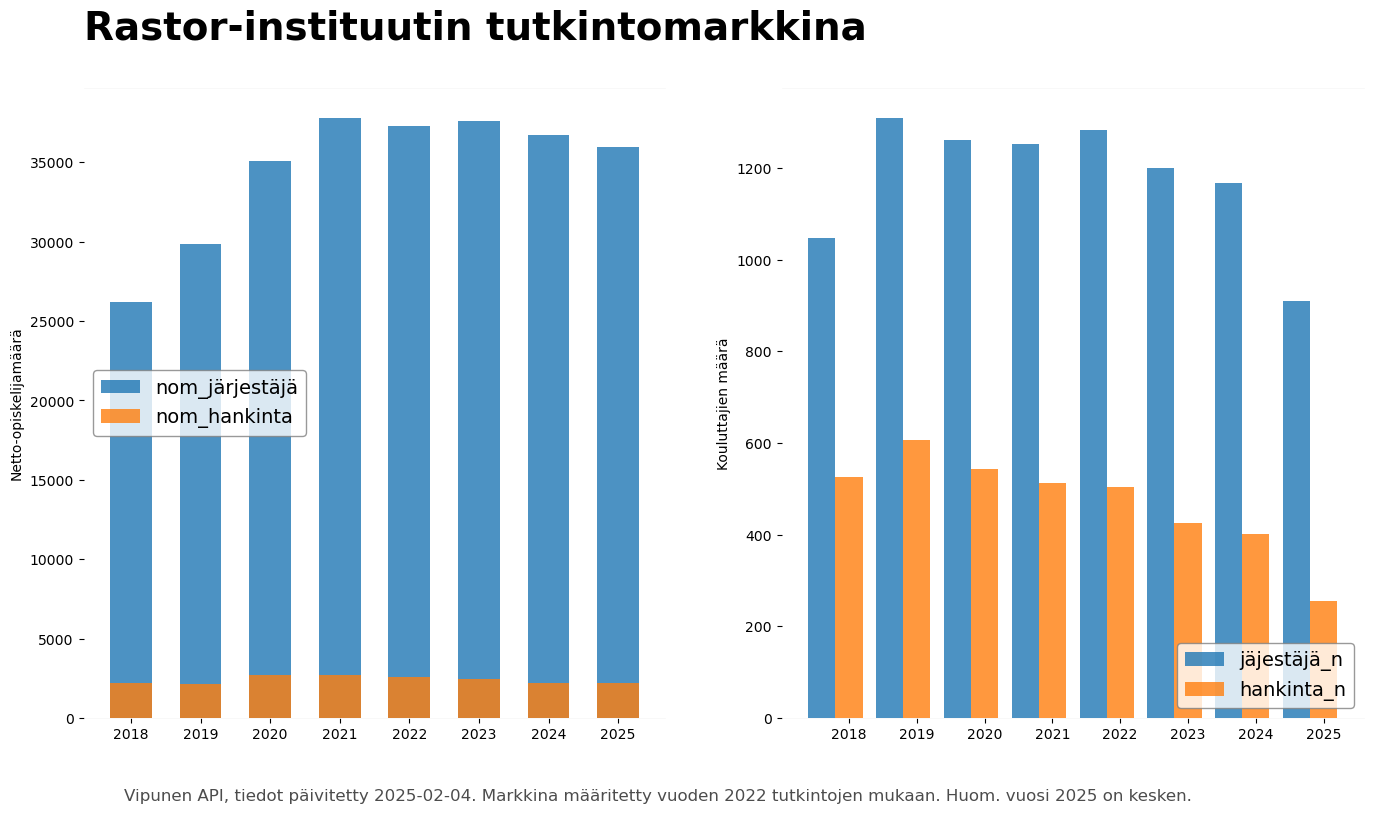

In [190]:
fig_tuple, fig = plot_subplots_bar(
    df=rin_markkina_yhteenveto,
    x='tilastovuosi',
    y1_list=['nom_järjestäjä', 'nom_hankinta'],
    y2_list=['jäjestäjä_n', 'hankinta_n'],
    title="Rastor-instituutin tutkintomarkkina",
    source= f'Vipunen API, tiedot päivitetty {vipunen_haku_pvm}. Markkina määritetty vuoden {tutkintomarkkinan_maarittäva_tutkintovuosi} tutkintojen mukaan. Huom. vuosi {current_year} on kesken.',
    # x_label="Year",
    y_labels=["Netto-opiskelijamäärä", "Kouluttajien määrä"]
)

# Close the figure without the title
plt.close(fig_tuple[0])

# Append the figure with the title to your list
visualizations_for_export.append(fig_tuple)

# Display the figure with the title in the notebook
plt.show()


- visualisointi, RI netto-opiskelijamäärät

In [191]:
ri_omien_tutkintojen_markkinassa

tilastovuosi kouluttaja  järjestäjänä  hankintana  Yhteensä  \
0          2018         RI         939.7       558.4    1498.1   
1          2019         RI        1125.6       731.7    1857.3   
2          2020         RI        1598.9      1127.5    2726.4   
3          2021         RI        2160.8       850.6    3011.5   
4          2022         RI        1905.9       867.7    2773.6   
5          2023         RI        1673.6       866.6    2540.2   
6          2024         RI        1865.5       658.9    2524.4   
7          2025         RI        1865.6       627.9    2493.5   

   järjestäjä_osuus (%)  
0                  62.7  
1                  60.6  
2                  58.6  
3                  71.8  
4                  68.7  
5                  65.9  
6                  73.9  
7                  74.8

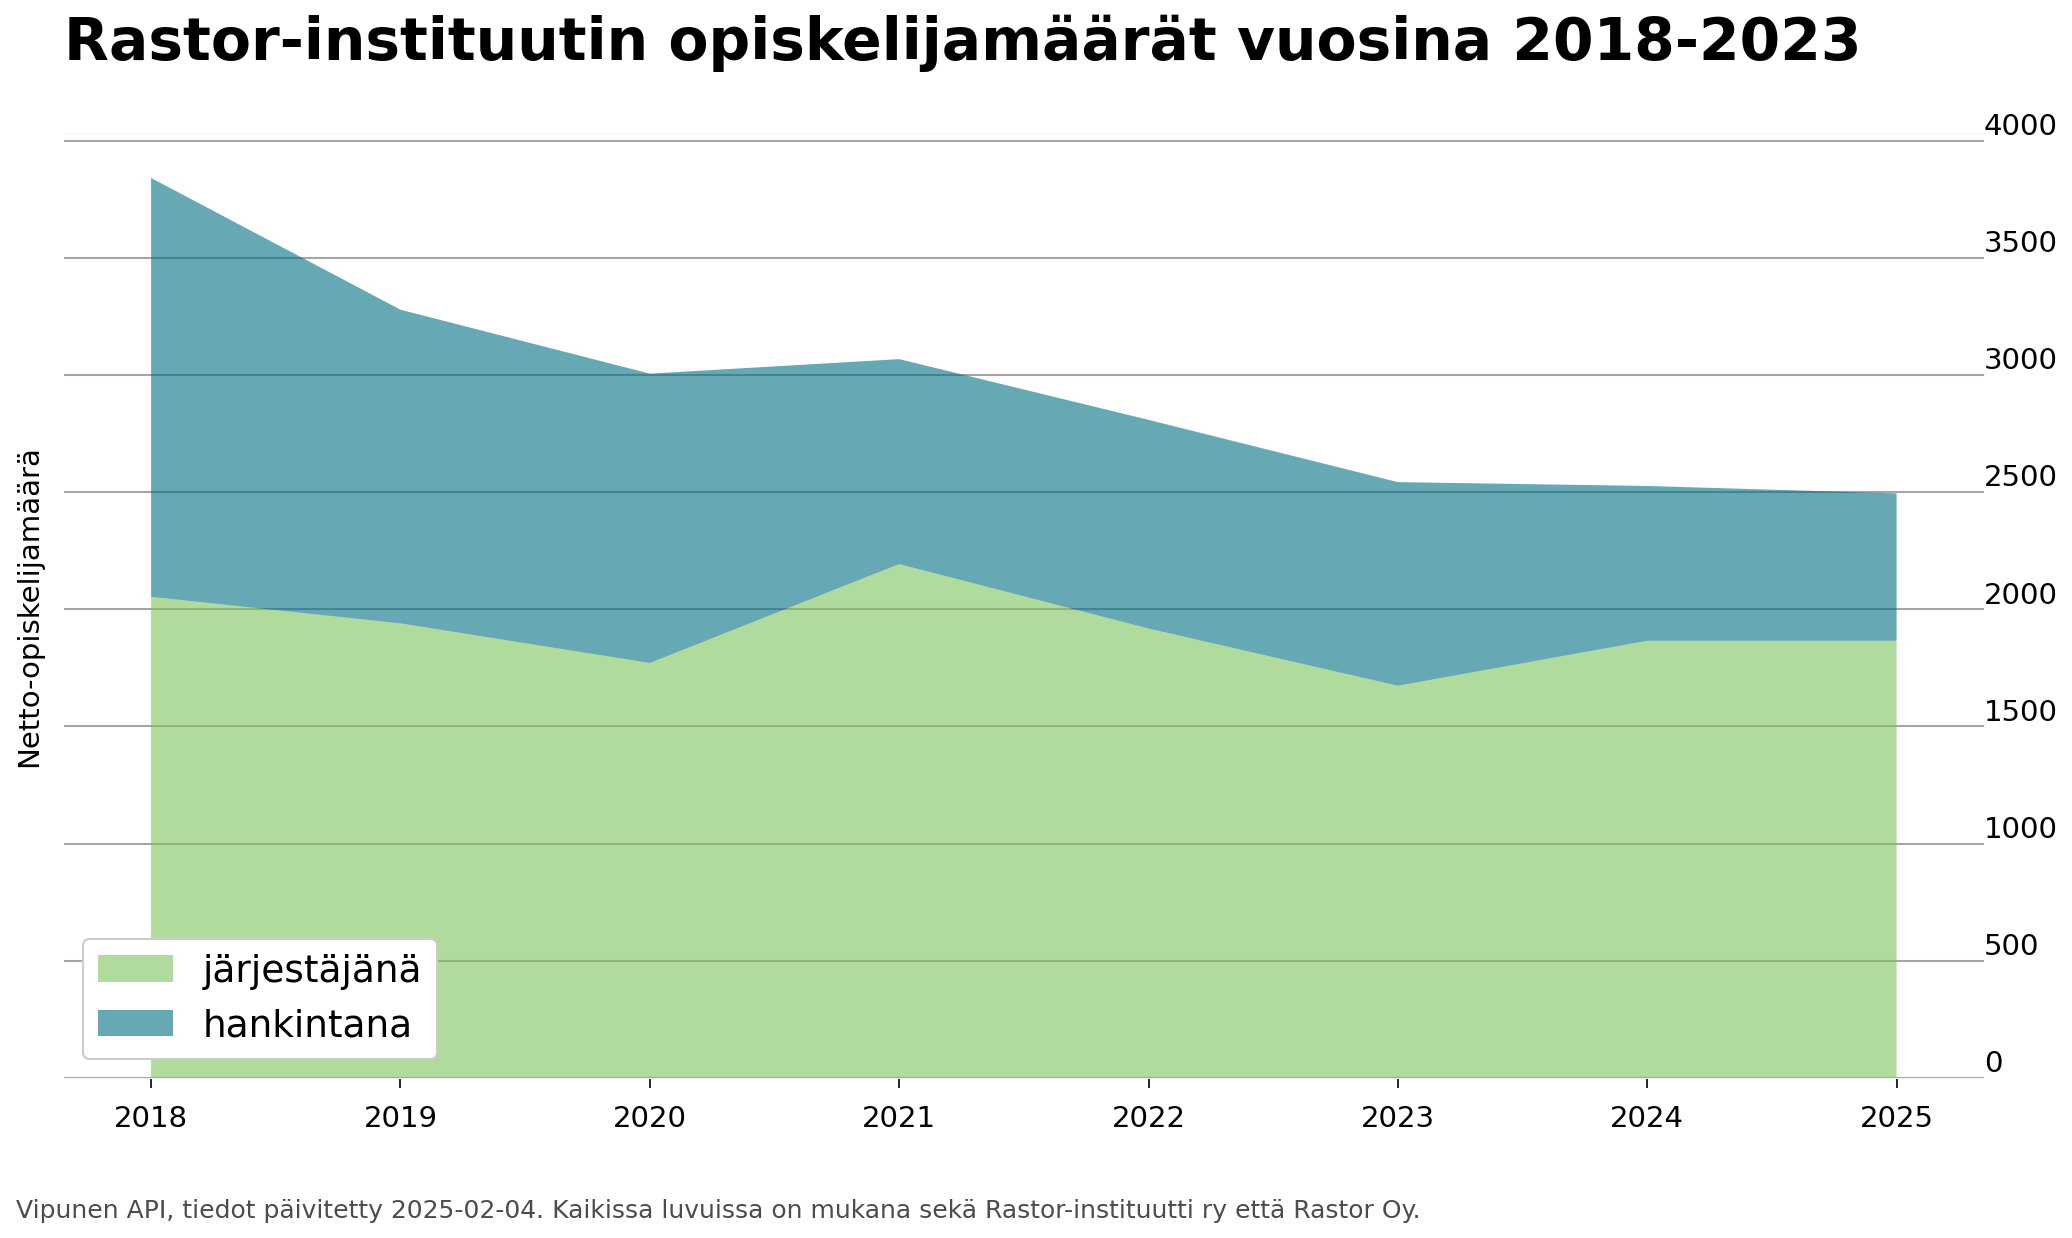

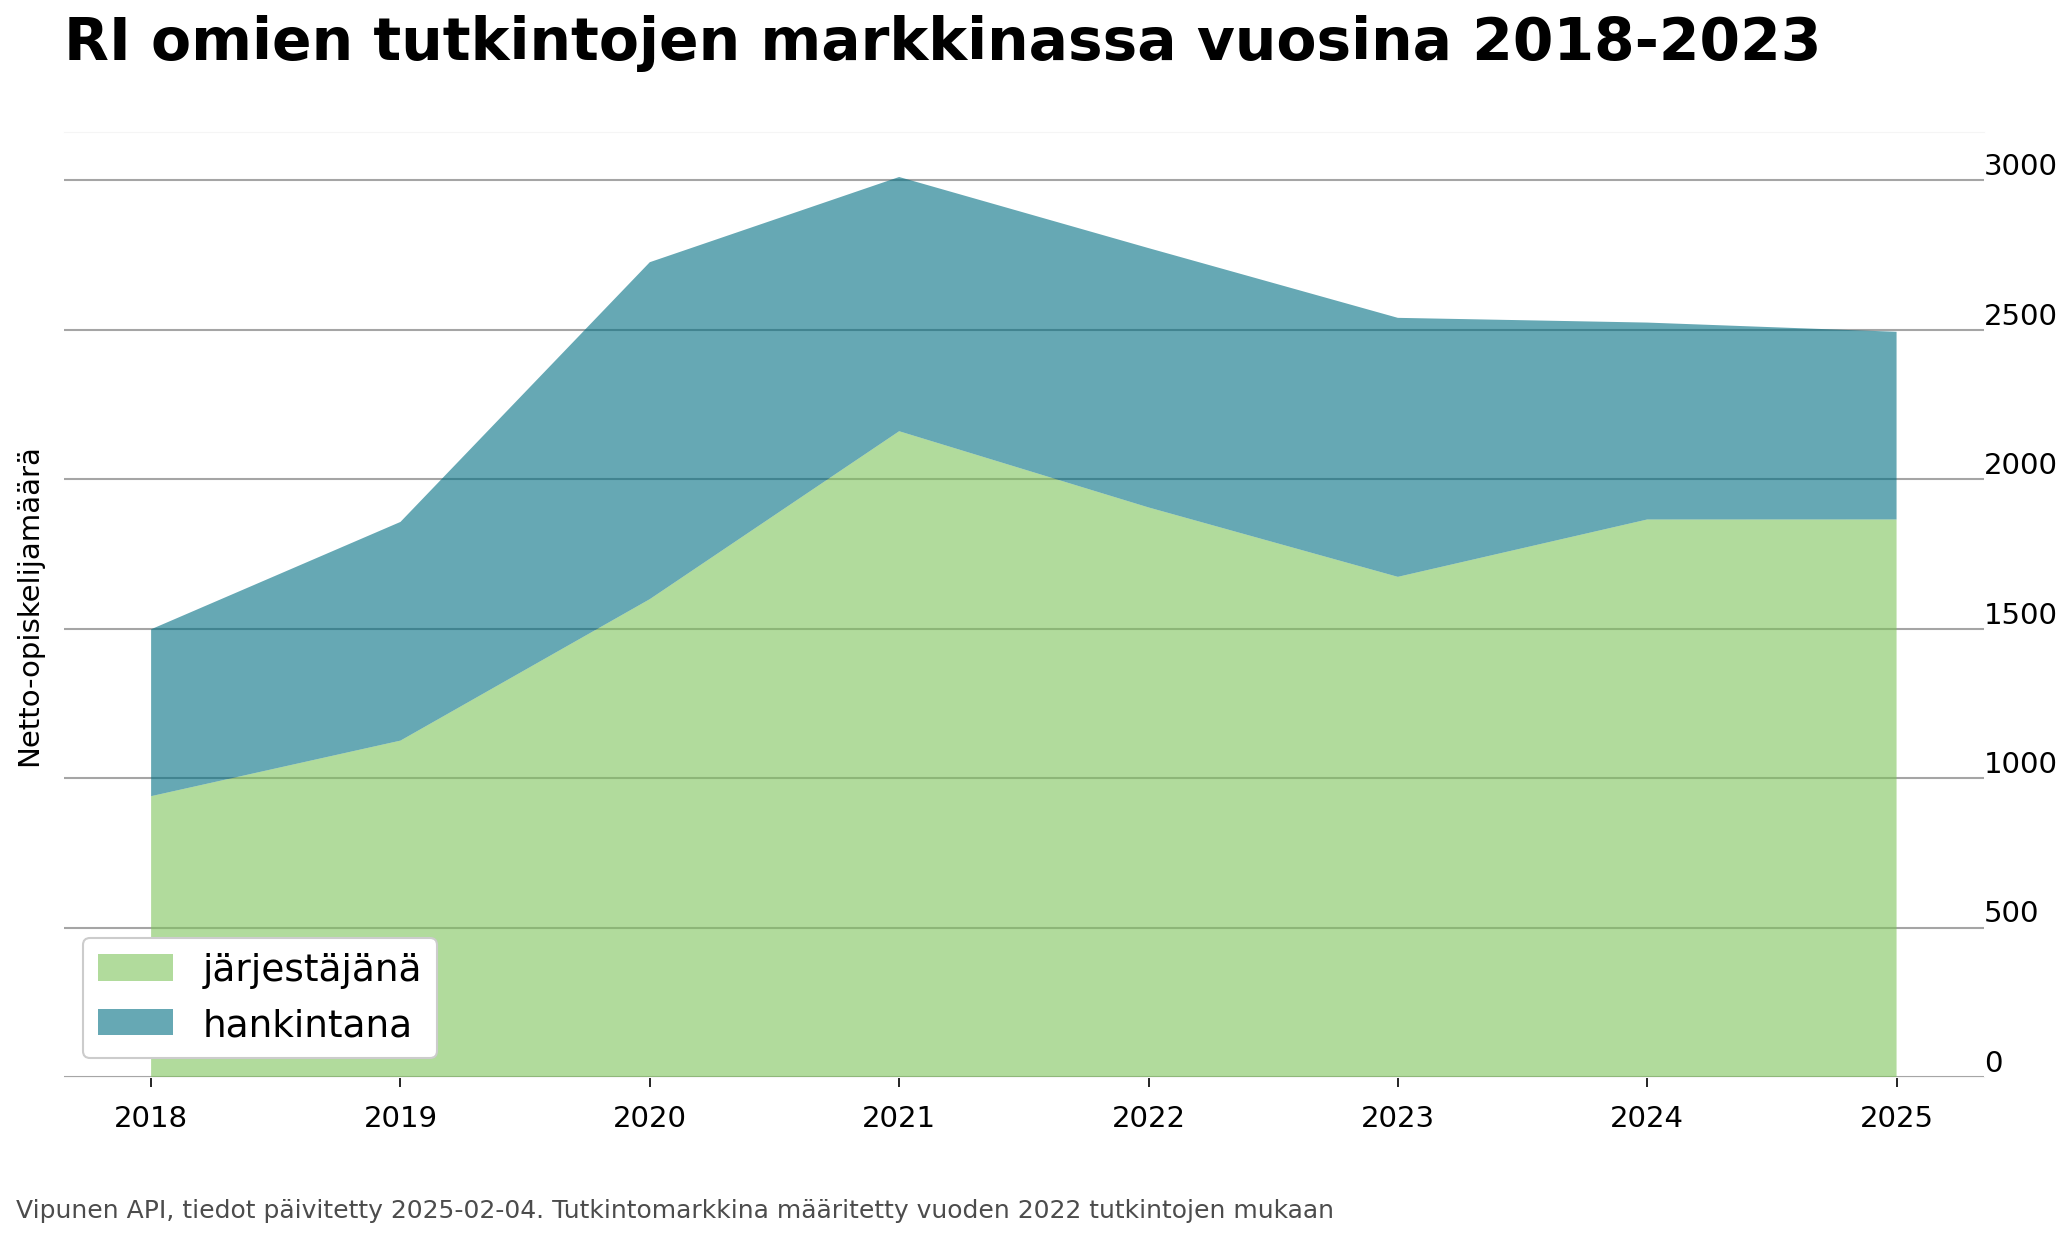

In [192]:
## RI opiskelijamäärät 2021-2023

title='Rastor-instituutin opiskelijamäärät vuosina 2018-2023'
source= f'Vipunen API, tiedot päivitetty {vipunen_haku_pvm}. Kaikissa luvuissa on mukana sekä Rastor-instituutti ry että Rastor Oy.'

fig_tuple, fig = plot_stackplot(
    df=ri_kaikki_nom,
    x='tilastovuosi',
    y1='järjestäjänä',
    y2='hankintana',
    title=title,
    source=source,
    x_label='',
    y_label='Netto-opiskelijamäärä'
)

# # Retrieve the current size of the figure
# current_figsize = fig_tuple[0].get_size_inches()
# print(f"The current figure size is: {current_figsize[0]} inches wide by {current_figsize[1]} inches tall")

# Close the figure without the title
plt.close(fig_tuple[0])

# Append the figure with the title to your list
visualizations_for_export.append(fig_tuple)

# Display the figure with the title in the notebook
plt.show()

title='RI omien tutkintojen markkinassa vuosina 2018-2023'
source= f'Vipunen API, tiedot päivitetty {vipunen_haku_pvm}. Tutkintomarkkina määritetty vuoden {tutkintomarkkinan_maarittäva_tutkintovuosi} tutkintojen mukaan'

fig_tuple, fig = plot_stackplot(
    df=ri_omien_tutkintojen_markkinassa,
    x='tilastovuosi',
    y1='järjestäjänä',
    y2='hankintana',
    title=title,
    source=source,
    # source_x=
    x_label='',
    y_label='Netto-opiskelijamäärä'
)

# Close the figure without the title
plt.close(fig_tuple[0])

# Append the figure with the title to your list
visualizations_for_export.append(fig_tuple)

# Display the figure with the title in the notebook
plt.show()

# Reset to default style
# reset_plot_style()

### Vaihe 2. Kilpailijakenttä ja markkinaosuudet tutkinnoittain

##### Koko markkinan datan yhdistäminen

In [193]:
rin_omien_tutkintomarkkina.columns

Index(['tilastovuosi', 'tutkinto', 'koulutuksenJarjestaja',
       'hankintakoulutuksenJarjestaja', 'nettoopiskelijamaaraLkm'],
      dtype='object')

In [194]:
'''
Group the data by year and qualification to get the total number of students for each qualification

Note: this number is the sum of all nettoopiskelijamaaraLkm for the qualification. Each entry may include 
two contributors (koulutuksenJarjestaja and hankintakoulutuksenJarjestaja). In the rest of the analysis both are recognized in the 
total number of students served by the kouluttaja. Therefore it's not possible to sum those numbers - ie. the total koulutuksenJarjestaja and hankintakoulutuksenJarjestaja 
for each kouluttaja - to get the total number of students for each qualification. The following is the right way to do it. 

'''
# rin_tutkintojen_markkina_sum = rin_omien_tutkintomarkkina.groupby(
#     by=['tilastovuosi', 'tutkinto'])['nettoopiskelijamaaraLkm'].sum().reset_index()
# rin_tutkintojen_markkina_sum

"\nGroup the data by year and qualification to get the total number of students for each qualification\n\nNote: this number is the sum of all nettoopiskelijamaaraLkm for the qualification. Each entry may include \ntwo contributors (koulutuksenJarjestaja and hankintakoulutuksenJarjestaja). In the rest of the analysis both are recognized in the \ntotal number of students served by the kouluttaja. Therefore it's not possible to sum those numbers - ie. the total koulutuksenJarjestaja and hankintakoulutuksenJarjestaja \nfor each kouluttaja - to get the total number of students for each qualification. The following is the right way to do it. \n\n"

In [195]:
rin_tutkintojen_markkina_yhteenveto = rin_omien_tutkintomarkkina.groupby(
    by=['tilastovuosi', 'tutkinto']).agg(
        {
            'nettoopiskelijamaaraLkm':'sum',
            'koulutuksenJarjestaja':'nunique',
            'hankintakoulutuksenJarjestaja':'nunique'
        }).reset_index()
rin_tutkintojen_markkina_yhteenveto.rename(
    columns={'koulutuksenJarjestaja':'koulutuksenJarjestaja_n','hankintakoulutuksenJarjestaja':'hankintakoulutuksenJarjestaja_n'}, 
    inplace=True)
rin_tutkintojen_markkina_yhteenveto = pd.merge(
    rin_tutkintojen_markkina_yhteenveto, 
    calculate_yoy_change_providers(rin_tutkintojen_markkina_yhteenveto),
    on=['tilastovuosi', 'tutkinto'],
    how='left'
) 
# rin_tutkintojen_markkina_yhteenveto.query('tutkinto == "Isännöinnin ammattitutkinto"')

In [196]:
# rin_tutkintojen_markkina_yhteenveto.query('tilastovuosi==2022').sort_values(by='koulutuksenJarjestaja', ascending=False)

In [197]:
# Fetch data for RI as the main organizer and as the contracted training arranger for specific qualifications
tutkinnot_jarjestajana = hae_tutkinto_nom(df, role='koulutuksenJarjestaja', qualifications=ri_qualifications_list)
tutkinnot_hankintana = hae_tutkinto_nom(df, role='hankintakoulutuksenJarjestaja', qualifications=ri_qualifications_list)

koulutuksenJarjestaja (4412, 4)
hankintakoulutuksenJarjestaja (887, 4)


In [198]:
# Merge the two DataFrames to get a complete view of RI's role in the market for each qualification
kaikki_jarjestajat_ri_tutkintomarkkina = pd.merge(
    tutkinnot_jarjestajana,
    tutkinnot_hankintana,
    how='outer',
    left_on=['tilastovuosi', 'tutkinto', 'koulutuksenJarjestaja'],
    right_on=['tilastovuosi', 'tutkinto', 'hankintakoulutuksenJarjestaja'],
    suffixes=('_as_jarjestaja', '_as_hankinta')
)

In [199]:
kaikki_jarjestajat_ri_tutkintomarkkina.columns

Index(['tilastovuosi', 'tutkinto', 'koulutuksenJarjestaja',
       'nettoopiskelijamaaraLkm_as_jarjestaja',
       'hankintakoulutuksenJarjestaja', 'nettoopiskelijamaaraLkm_as_hankinta'],
      dtype='object')

In [200]:
# hae_kouluttaja_nom(rin_omien_tutkintomarkkina)

                        tilastovuosi	koulutuksenJarjestaja	hankintakoulutuksenJarjestaja	Yhteensä
                        0	2018	1778.4	1381.1	3159.5
                        1	2019	1770.5	1197.6	2968.1
                        2	2020	1752.9	1235.5	2988.4
                        3	2021	2193.3	885.1	3078.4
                        4	2022	1917.7	905.6	2823.3
                        5	2023	1626.0	942.4	2568.4


                        	tilastovuosi	nettoopiskelijamaaraLkm_as_jarjestaja	nettoopiskelijamaaraLkm_as_hankinta	Yhteensä
                        0	2018	1778.4	1381.1	3159.5
                        1	2019	1770.5	1197.6	2968.1
                        2	2020	1752.9	1235.5	2988.4
                        3	2021	2193.3	885.1	3078.4
                        4	2022	1917.7	905.6	2823.3
                        5	2023	1626.0	942.4	2568.4

##### Markkinaosuuksien laskeminen

In [201]:
# kaikki_jarjestajat_ri_tutkintomarkkina

In [202]:
# yhteistetään kaikkien koulutusten järjestäjien netto-opiskelijamäärät tutkinnoittain ja 
# rooleittain (koulutuksenJarjestaja ja hankintakoulutuksenJarjestaja)
# 
# Merge the DataFrame containing RI's role in each qualification with the total market size for each qualification
toimijoiden_markkinaosuudet = pd.merge(
    kaikki_jarjestajat_ri_tutkintomarkkina,
    rin_tutkintojen_markkina_yhteenveto,
    how='left',
    on=['tilastovuosi','tutkinto']#,
)
toimijoiden_markkinaosuudet.rename(columns={'nettoopiskelijamaaraLkm':'nom_tutkinto yhteensa'}, inplace=True)

In [203]:
toimijoiden_markkinaosuudet.head()

tilastovuosi                     tutkinto  \
0          2018  Isännöinnin ammattitutkinto   
1          2018  Isännöinnin ammattitutkinto   
2          2018  Isännöinnin ammattitutkinto   
3          2018  Isännöinnin ammattitutkinto   
4          2018  Isännöinnin ammattitutkinto   

                     koulutuksenJarjestaja  \
0                            AEL-Amiedu Oy   
1                            Ami-säätiö sr   
2                              Careeria Oy   
3  Espoon seudun koulutuskuntayhtymä Omnia   
4       Etelä-Karjalan Koulutuskuntayhtymä   

   nettoopiskelijamaaraLkm_as_jarjestaja hankintakoulutuksenJarjestaja  \
0                                   13.1                           NaN   
1                                   71.1                 Ami-säätiö sr   
2                                   11.2                   Careeria Oy   
3                                    1.2                           NaN   
4                                    0.5                           NaN   

   nettoopiskelijamaaraLkm_as_hankinta  nom_tutkinto yhteensa  \
0                                  NaN                  664.9   
1                                  0.4                  664.9   
2                                  0.3                  664.9   
3                                  NaN                  664.9   
4                                  NaN                  664.9   

   koulutuksenJarjestaja_n  hankintakoulutuksenJarjestaja_n  \
0                       43                               18   
1                       43                               18   
2                       43                               18   
3                       43                               18   
4                       43                               18   

   muutos tarjoajien määrässä (%)  
0                             NaN  
1                             NaN  
2                             NaN  
3                             NaN  
4                             NaN

In [204]:
''' 
    1.  Check for Division by Zero: Before calculating the market share, you can check if the total number of students 
        (nom_tutkinto yhteensa) is zero. If it is, you can skip the calculation for that row and print a warning.

    2.  Data Validation for Market Share: After calculating the market share for both roles, 
        you can check if the sum exceeds 100%. If it does, you can print a warning.
'''

# Loop through DataFrame to calculate market share and validate data
for idx, row in toimijoiden_markkinaosuudet.iterrows():
    total_students = row['nom_tutkinto yhteensa']
    
    # Check for division by zero
    if total_students == 0:
        print(f"Warning: Total number of students is zero for index {idx}. Market share cannot be calculated.")
        continue
    
    # Calculate market share for each role
    jarjestaja_share = (row['nettoopiskelijamaaraLkm_as_jarjestaja'] / total_students) * 100
    hankinta_share = (row['nettoopiskelijamaaraLkm_as_hankinta'] / total_students) * 100
    
    # Data validation: Check if the sum of market shares exceeds 100%
    if jarjestaja_share + hankinta_share > 100:
        print(f"Warning: Sum of market shares exceeds 100% for index {idx}. Please check the data.")
        continue
    
    # Assign the calculated market shares to the DataFrame
    toimijoiden_markkinaosuudet.at[idx, 'jarjestaja-markkinaosuus'] = jarjestaja_share
    toimijoiden_markkinaosuudet.at[idx, 'hankinta-markkinaosuus'] = hankinta_share


In [205]:
toimijoiden_markkinaosuudet

tilastovuosi                      tutkinto  \
0             2018   Isännöinnin ammattitutkinto   
1             2018   Isännöinnin ammattitutkinto   
2             2018   Isännöinnin ammattitutkinto   
3             2018   Isännöinnin ammattitutkinto   
4             2018   Isännöinnin ammattitutkinto   
...            ...                           ...   
4452          2025  Yrittäjyyden ammattitutkinto   
4453          2025  Yrittäjyyden ammattitutkinto   
4454          2025  Yrittäjyyden ammattitutkinto   
4455          2025  Yrittäjyyden ammattitutkinto   
4456          2025  Yrittäjyyden ammattitutkinto   

                                koulutuksenJarjestaja  \
0                                       AEL-Amiedu Oy   
1                                       Ami-säätiö sr   
2                                         Careeria Oy   
3             Espoon seudun koulutuskuntayhtymä Omnia   
4                  Etelä-Karjalan Koulutuskuntayhtymä   
...                                               ...   
4452                                  Vaasan kaupunki   
4453          Valkeakosken seudun koulutuskuntayhtymä   
4454                                 Vantaan kaupunki   
4455                    Ylä-Savon koulutuskuntayhtymä   
4456  Äänekosken Ammatillisen Koulutuksen kuntayhtymä   

      nettoopiskelijamaaraLkm_as_jarjestaja hankintakoulutuksenJarjestaja  \
0                                      13.1                           NaN   
1                                      71.1                 Ami-säätiö sr   
2                                      11.2                   Careeria Oy   
3                                       1.2                           NaN   
4                                       0.5                           NaN   
...                                     ...                           ...   
4452                                   25.5                           NaN   
4453                                    3.1                           NaN   
4454                                   14.6                           NaN   
4455                                   20.2                           NaN   
4456                                   57.8                           NaN   

      nettoopiskelijamaaraLkm_as_hankinta  nom_tutkinto yhteensa  \
0                                     NaN                  664.9   
1                                     0.4                  664.9   
2                                     0.3                  664.9   
3                                     NaN                  664.9   
4                                     NaN                  664.9   
...                                   ...                    ...   
4452                                  NaN                 1445.2   
4453                                  NaN                 1445.2   
4454                                  NaN                 1445.2   
4455                                  NaN                 1445.2   
4456                                  NaN                 1445.2   

      koulutuksenJarjestaja_n  hankintakoulutuksenJarjestaja_n  \
0                          43                               18   
1                          43                               18   
2                          43                               18   
3                          43                               18   
4                          43                               18   
...                       ...                              ...   
4452                       51                                5   
4453                       51                                5   
4454                       51                                5   
4455                       51                                5   
4456                       51                                5   

      muutos tarjoajien määrässä (%)  jarjestaja-markkinaosuus  \
0                                NaN                       2.0   
1                            

In [206]:
## heavy liftintg :-)

# Replace NaN values with zeros for the number of students served by each role
toimijoiden_markkinaosuudet['nettoopiskelijamaaraLkm_as_jarjestaja'].fillna(0, inplace=True)
toimijoiden_markkinaosuudet['nettoopiskelijamaaraLkm_as_hankinta'].fillna(0, inplace=True)

# Simplify the DataFrame by combining the two role columns into a single 'kouluttaja' column
# if toimijoiden markkinaosuudet['koulutuksenJarjestaja'] is NaN, then use the value from 'hankintakoulutuksenJarjestaja'
toimijoiden_markkinaosuudet['kouluttaja'] = toimijoiden_markkinaosuudet['koulutuksenJarjestaja'].fillna(toimijoiden_markkinaosuudet['hankintakoulutuksenJarjestaja'])

toimijoiden_markkinaosuudet_detail = toimijoiden_markkinaosuudet.copy() # save the detailed data for later use

# Drop the original role columns as they are no longer needed
toimijoiden_markkinaosuudet.drop(columns=['koulutuksenJarjestaja', 'hankintakoulutuksenJarjestaja'], inplace=True)

toimijoiden_markkinaosuudet['nom_kouluttaja yhteensa'] = toimijoiden_markkinaosuudet['nettoopiskelijamaaraLkm_as_jarjestaja'] + toimijoiden_markkinaosuudet['nettoopiskelijamaaraLkm_as_hankinta']

## Proportion of students served by the institution as koulutuksenJarjestaja to the total number of students 
# 100% => all students were served by the institution as koulutuksenJarjestaja
# 0 => none of the students were served by the institution as koulutuksenJarjestaja
toimijoiden_markkinaosuudet['järjestäjänä-osuus (%)'] = toimijoiden_markkinaosuudet['nettoopiskelijamaaraLkm_as_jarjestaja'] / toimijoiden_markkinaosuudet['nom_kouluttaja yhteensa']*100

# toimijoiden_markkinaosuudet per tutkinto
toimijoiden_markkinaosuudet['markkinaosuus tutkinnossa (%)'] = (toimijoiden_markkinaosuudet['nom_kouluttaja yhteensa'] / toimijoiden_markkinaosuudet['nom_tutkinto yhteensa']) * 100
toimijoiden_markkinaosuudet.drop(columns=['jarjestaja-markkinaosuus','hankinta-markkinaosuus'], inplace=True)

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/1163499936.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  toimijoiden_markkinaosuudet['nettoopiskelijamaaraLkm_as_jarjestaja'].fillna(0, inplace=True)
/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/1163499936.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

In [207]:
toimijoiden_markkinaosuudet.head()

tilastovuosi                     tutkinto  \
0          2018  Isännöinnin ammattitutkinto   
1          2018  Isännöinnin ammattitutkinto   
2          2018  Isännöinnin ammattitutkinto   
3          2018  Isännöinnin ammattitutkinto   
4          2018  Isännöinnin ammattitutkinto   

   nettoopiskelijamaaraLkm_as_jarjestaja  nettoopiskelijamaaraLkm_as_hankinta  \
0                                   13.1                                  0.0   
1                                   71.1                                  0.4   
2                                   11.2                                  0.3   
3                                    1.2                                  0.0   
4                                    0.5                                  0.0   

   nom_tutkinto yhteensa  koulutuksenJarjestaja_n  \
0                  664.9                       43   
1                  664.9                       43   
2                  664.9                       43   
3                  664.9                       43   
4                  664.9                       43   

   hankintakoulutuksenJarjestaja_n  muutos tarjoajien määrässä (%)  \
0                               18                             NaN   
1                               18                             NaN   
2                               18                             NaN   
3                               18                             NaN   
4                               18                             NaN   

                                kouluttaja  nom_kouluttaja yhteensa  \
0                            AEL-Amiedu Oy                     13.1   
1                            Ami-säätiö sr                     71.5   
2                              Careeria Oy                     11.5   
3  Espoon seudun koulutuskuntayhtymä Omnia                      1.2   
4       Etelä-Karjalan Koulutuskuntayhtymä                      0.5   

   järjestäjänä-osuus (%)  markkinaosuus tutkinnossa (%)  
0                   100.0                            2.0  
1                    99.5                           10.8  
2                    97.1                            1.7  
3                   100.0                            0.2  
4                   100.0                            0.1

In [208]:
# osassa tutkinnoista hankintakoulutuksenJarjestaja vs. koulutuksenJarjestaja ei ole kovin informatiivinen, koska
# kyse on saman organisaation eri osista. Seinäjoen kaupunki vs. Seinäjoen koulutuskuntayhtymä
# rin_omien_tutkintomarkkina[rin_omien_tutkintomarkkina['hankintakoulutuksenJarjestaja']=='Seinäjoen kaupunki']

### Vaihe 3. Kasvu

In [209]:
toimijoiden_markkinaosuudet_kasvu = toimijoiden_markkinaosuudet.copy()
toimijoiden_markkinaosuudet_kasvu['kouluttaja tutkintokasvu (%)'] = toimijoiden_markkinaosuudet_kasvu.groupby(['tutkinto', 'kouluttaja'])['nom_kouluttaja yhteensa'].pct_change() * 100
toimijoiden_markkinaosuudet_kasvu['tutkinto markkinakasvu (%)'] = toimijoiden_markkinaosuudet_kasvu.groupby('tutkinto')['nom_tutkinto yhteensa'].pct_change() * 100

In [210]:
# vuosi = [2022, 2023]
# toimijoiden_markkinaosuudet_kasvu.query('tutkinto == "Yrittäjyyden ammattitutkinto" and tilastovuosi in @vuosi').groupby(by=['tutkinto','tutkinto markkinakasvu (%)']).head(50)
# vuosi = [2022, 2023]
# toimijoiden_markkinaosuudet_kasvu.query('tutkinto == "Yrittäjyyden ammattitutkinto" and tilastovuosi in @vuosi')

In [211]:
# calculate_yoy_growth(toimijoiden_markkinaosuudet_kasvu, 'tutkinto', 'nom_tutkinto yhteensa', 'tutkinto markkinakasvu (%)',2021,2)

- CAGR

In [212]:
# Calculate CAGR each kouluttaja and tutkinto
groupby_columns = ['tutkinto', 'kouluttaja']
value_column = 'nom_kouluttaja yhteensa'
last_year=2022

cagr_df_toimijat = calculate_cagr_for_groups(toimijoiden_markkinaosuudet_kasvu, groupby_columns, value_column, last_year=last_year)
cagr_df_toimijat['tilastovuosi'] = last_year
# cagr_df_toimijat

In [213]:
# Calculate CAGR for each tutkinto (qualification)
groupby_columns = ['tutkinto']
value_column = 'nom_tutkinto yhteensa'
last_year = last_year  # Last year to include in the calculation

cagr_df_tutkinnot = calculate_cagr_for_groups(toimijoiden_markkinaosuudet_kasvu, groupby_columns, value_column, last_year=last_year)
cagr_df_tutkinnot['tilastovuosi'] = last_year
# cagr_df_tutkinnot

In [214]:
cagr_df_toimijat[cagr_df_toimijat['kouluttaja'] == 'RI']

CAGR (%)                                           tutkinto kouluttaja  \
24        1.9                        Isännöinnin ammattitutkinto         RI   
80      210.1  Johtamisen ja yritysjohtamisen erikoisammattit...         RI   
141      20.6                     Liiketoiminnan ammattitutkinto         RI   
193      83.7              Liiketoiminnan erikoisammattitutkinto         RI   
255      -5.3                       Liiketoiminnan perustutkinto         RI   
322       8.9                 Lähiesihenkilötyön ammattitutkinto         RI   
361     -25.3                 Palvelulogistiikan ammattitutkinto         RI   
388      80.7   Rakennusalan työmaajohdon erikoisammattitutkinto         RI   
421     266.6               Talotekniikan erikoisammattitutkinto         RI   
461     165.8    Tuotannon esihenkilötyön erikoisammattitutkinto         RI   
510      -6.4            Tuotekehitystyön erikoisammattitutkinto         RI   
548     -27.2                   Turvallisuusalan ammattitutkinto         RI   
576      -5.8            Turvallisuusalan erikoisammattitutkinto         RI   
624     -17.7                       Yrittäjyyden ammattitutkinto         RI   

     tilastovuosi  
24           2022  
80           2022  
141          2022  
193          2022  
255          2022  
322          2022  
361          2022  
388          2022  
421          2022  
461          2022  
510          2022  
548          2022  
576          2022  
624          2022

In [215]:
# toimijoiden_markkinaosuudet_kasvu.query("tutkinto == 'Isännöinnin ammattitutkinto' and kouluttaja=='RI'")

- vuosimuutos (YoY)

In [216]:
# toimijoiden_markkinaosuudet_kasvu.groupby(by=['tutkinto', 'tilastovuosi'])['nettoopiskelijamaaraLkm_as_jarjestaja'].sum().to_frame().head(10)

In [217]:
toimijoiden_markkinaosuudet_kasvu.head()

tilastovuosi                     tutkinto  \
0          2018  Isännöinnin ammattitutkinto   
1          2018  Isännöinnin ammattitutkinto   
2          2018  Isännöinnin ammattitutkinto   
3          2018  Isännöinnin ammattitutkinto   
4          2018  Isännöinnin ammattitutkinto   

   nettoopiskelijamaaraLkm_as_jarjestaja  nettoopiskelijamaaraLkm_as_hankinta  \
0                                   13.1                                  0.0   
1                                   71.1                                  0.4   
2                                   11.2                                  0.3   
3                                    1.2                                  0.0   
4                                    0.5                                  0.0   

   nom_tutkinto yhteensa  koulutuksenJarjestaja_n  \
0                  664.9                       43   
1                  664.9                       43   
2                  664.9                       43   
3                  664.9                       43   
4                  664.9                       43   

   hankintakoulutuksenJarjestaja_n  muutos tarjoajien määrässä (%)  \
0                               18                             NaN   
1                               18                             NaN   
2                               18                             NaN   
3                               18                             NaN   
4                               18                             NaN   

                                kouluttaja  nom_kouluttaja yhteensa  \
0                            AEL-Amiedu Oy                     13.1   
1                            Ami-säätiö sr                     71.5   
2                              Careeria Oy                     11.5   
3  Espoon seudun koulutuskuntayhtymä Omnia                      1.2   
4       Etelä-Karjalan Koulutuskuntayhtymä                      0.5   

   järjestäjänä-osuus (%)  markkinaosuus tutkinnossa (%)  \
0                   100.0                            2.0   
1                    99.5                           10.8   
2                    97.1                            1.7   
3                   100.0                            0.2   
4                   100.0                            0.1   

   kouluttaja tutkintokasvu (%)  tutkinto markkinakasvu (%)  
0                           NaN                         NaN  
1                           NaN                         0.0  
2                           NaN                         0.0  
3                           NaN                         0.0  
4                           NaN                         0.0

#### Tutkintojen kasvutrendit

In [218]:


# Example usage
current_year = datetime.now().year
most_recent_complete_year = current_year - 1
variables_dict = {
    'nettoopiskelijamaaraLkm_as_jarjestaja':'nom kasvu (%)', 
    'koulutuksenJarjestaja_n':'tarjoajien kasvu (%)'
}

# variables_dict = {
#     'koulutuksenJarjestaja_n':'tarjoajien kasvu (%)'
# }

# variables = ['koulutuksenJarjestaja_n']
# output_cols = ['tarjoajien kasvu (%)']
time_window = 2

tutkintojen_kasvutrendit = calculate_multiple_yoy_growth(
    df=toimijoiden_markkinaosuudet_kasvu, 
    variables_dict=variables_dict, 
    time_window=time_window, 
    groupby_col='tutkinto',
    most_recent_complete_year=most_recent_complete_year)
tutkintojen_kasvutrendit=tutkintojen_kasvutrendit[['tutkinto', 'tilastovuodet','tilastovuosi','tarjoajien kasvu (%)', 'tarjoajien kasvu (%)_trendi',
       'nom kasvu (%)', 'nom kasvu (%)_trendi']]

# save title and dataframe to dictionary for export
title = "Tutkintojen kasvutrendit"
df_to_dict = tutkintojen_kasvutrendit
tables_for_excel_export[title]=df_to_dict



In [219]:
# tutkintojen_kasvutrendit.query('tutkinto == "Johtamisen ja yritysjohtamisen erikoisammattitutkinto"')
tutkintojen_kasvutrendit.query('tutkinto == "Tuotekehitystyön erikoisammattitutkinto"')

tutkinto tilastovuodet  tilastovuosi  \
70  Tuotekehitystyön erikoisammattitutkinto     2018-2019          2019   
71  Tuotekehitystyön erikoisammattitutkinto     2019-2020          2020   
72  Tuotekehitystyön erikoisammattitutkinto     2020-2021          2021   
73  Tuotekehitystyön erikoisammattitutkinto     2021-2022          2022   
74  Tuotekehitystyön erikoisammattitutkinto     2022-2023          2023   
75  Tuotekehitystyön erikoisammattitutkinto     2023-2024          2024   
76  Tuotekehitystyön erikoisammattitutkinto     2024-2025          2025   

    tarjoajien kasvu (%) tarjoajien kasvu (%)_trendi  nom kasvu (%)  \
70                 -11.6                    Laskussa            7.5   
71                 -16.3                    Laskussa           -2.2   
72                  -9.1                    Laskussa            9.3   
73                   0.0                    Laskussa           -7.0   
74                   0.0                    Laskussa            2.9   
75                  -9.5                    Laskussa           -6.8   
76                  -5.1                    Laskussa           -9.3   

   nom kasvu (%)_trendi  
70             Kasvussa  
71             Laskussa  
72             Kasvussa  
73             Laskussa  
74             Kasvussa  
75             Laskussa  
76             Laskussa

        Identify the most growing institutions in 2023

            Filter the DataFrame for the year 2023.
            Group the data by 'kouluttaja' and sum up the 'nettoopiskelijamaara'.
            Sort the data by the summed 'nettoopiskelijamaara' in descending order to identify which 'kouluttaja' have grown the most.

In [220]:
# add YoY change in market share (markkinaosuus tutkinnossa (%)_YoY)
toimijoiden_markkinaosuudet_kasvu['markkinaosuus tutkinnossa (%)_YoY']=toimijoiden_markkinaosuudet_kasvu.groupby(
    by=['kouluttaja','tutkinto'])['markkinaosuus tutkinnossa (%)'].diff()
# Assign ordinal numbers based on market share for each qualification and year
toimijoiden_markkinaosuudet_kasvu['Sijoitus markkinassa'] = toimijoiden_markkinaosuudet_kasvu.groupby(
    ['tilastovuosi', 'tutkinto'])['markkinaosuus tutkinnossa (%)'].rank(ascending=False, method='min').astype(int)

# 
markkinaosuudet_järjestetty_tutkinnoittain = toimijoiden_markkinaosuudet_kasvu.sort_values(
    by=['tilastovuosi', 'tutkinto', 'markkinaosuus tutkinnossa (%)'], ascending=[True,True,False])

In [221]:
# The following code will rank the 'kouluttaja' based on 'markkinaosuus tutkinnossa (%)_YoY' for each 'tutkinto' for the year 2023.
toimijoiden_markkinaosuudet_kasvu['markkinaosuus tutkinnossa (%)_YoY'].fillna(0, inplace=True)
# Filtering the dataframe for the year 2023
# df_nousijat = toimijoiden_markkinaosuudet_kasvu.copy()

# Ranking the 'kouluttaja' for each 'tutkinto' based on 'markkinaosuus tutkinnossa (%)_YoY'
toimijoiden_markkinaosuudet_kasvu.loc[:,'Vuoden nousijat'] = toimijoiden_markkinaosuudet_kasvu.groupby(['tilastovuosi','tutkinto'])['markkinaosuus tutkinnossa (%)_YoY'].rank(method='min', ascending=False).astype(int)



/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/3277500592.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  toimijoiden_markkinaosuudet_kasvu['markkinaosuus tutkinnossa (%)_YoY'].fillna(0, inplace=True)


In [222]:
# make new dataframe that includes the yearly sum of nettoopiskelijamaaraLkm_as_jarjestaja for each tutkinto and tilastovuosi
tutkintojen_vuosittainen_nom_sum = toimijoiden_markkinaosuudet_kasvu.groupby(by=['tutkinto', 'tilastovuosi'])['nettoopiskelijamaaraLkm_as_jarjestaja'].sum().to_frame().reset_index()

In [223]:
tutkintojen_kasvutrendit = pd.merge(tutkintojen_kasvutrendit, tutkintojen_vuosittainen_nom_sum, on=['tutkinto', 'tilastovuosi'], how='left').rename(columns={'nettoopiskelijamaaraLkm_as_jarjestaja':'tutkinto_nom_sum'})
tutkintojen_kasvutrendit

tutkinto tilastovuodet  tilastovuosi  \
0    Isännöinnin ammattitutkinto     2018-2019          2019   
1    Isännöinnin ammattitutkinto     2019-2020          2020   
2    Isännöinnin ammattitutkinto     2020-2021          2021   
3    Isännöinnin ammattitutkinto     2021-2022          2022   
4    Isännöinnin ammattitutkinto     2022-2023          2023   
..                           ...           ...           ...   
93  Yrittäjyyden ammattitutkinto     2020-2021          2021   
94  Yrittäjyyden ammattitutkinto     2021-2022          2022   
95  Yrittäjyyden ammattitutkinto     2022-2023          2023   
96  Yrittäjyyden ammattitutkinto     2023-2024          2024   
97  Yrittäjyyden ammattitutkinto     2024-2025          2025   

    tarjoajien kasvu (%) tarjoajien kasvu (%)_trendi  nom kasvu (%)  \
0                  -33.7                    Laskussa            4.2   
1                  -36.0                    Laskussa           -1.0   
2                   14.8                    Kasvussa            2.5   
3                    6.8                    Kasvussa           -6.9   
4                    0.0                    Laskussa           13.6   
..                   ...                         ...            ...   
93                   3.9                    Kasvussa            6.5   
94                   0.0                    Laskussa           -6.2   
95                  -3.7                    Laskussa           14.4   
96                   7.8                    Kasvussa            1.5   
97                 -10.8                    Laskussa          -11.1   

   nom kasvu (%)_trendi  tutkinto_nom_sum  
0              Kasvussa             693.0  
1              Laskussa             686.1  
2              Kasvussa             703.0  
3              Laskussa             654.7  
4              Kasvussa             743.8  
..                  ...               ...  
93             Kasvussa            1491.9  
94             Laskussa            1399.1  
95             Kasvussa            1600.3  
96             Kasvussa            1624.8  
97             Laskussa            1445.2  

[98 rows x 8 columns]

In [224]:
rin_tutkinnot_toimijat_osuudet_ja_kasvu = toimijoiden_markkinaosuudet_kasvu.copy()

In [225]:
rin_tutkinnot_toimijat_osuudet_ja_kasvu = rin_tutkinnot_toimijat_osuudet_ja_kasvu[
    ['tilastovuosi', 'tutkinto', 'kouluttaja','nettoopiskelijamaaraLkm_as_jarjestaja',
       'nettoopiskelijamaaraLkm_as_hankinta', 'nom_kouluttaja yhteensa', 'järjestäjänä-osuus (%)',
       'markkinaosuus tutkinnossa (%)', 'kouluttaja tutkintokasvu (%)','markkinaosuus tutkinnossa (%)_YoY',
       'Sijoitus markkinassa', 'Vuoden nousijat']]
rin_tutkinnot_toimijat_osuudet_ja_kasvu = rename_nom(rin_tutkinnot_toimijat_osuudet_ja_kasvu)



In [226]:
rin_tutkinnot_toimijat_osuudet_ja_kasvu

tilastovuosi                      tutkinto  \
0             2018   Isännöinnin ammattitutkinto   
1             2018   Isännöinnin ammattitutkinto   
2             2018   Isännöinnin ammattitutkinto   
3             2018   Isännöinnin ammattitutkinto   
4             2018   Isännöinnin ammattitutkinto   
...            ...                           ...   
4452          2025  Yrittäjyyden ammattitutkinto   
4453          2025  Yrittäjyyden ammattitutkinto   
4454          2025  Yrittäjyyden ammattitutkinto   
4455          2025  Yrittäjyyden ammattitutkinto   
4456          2025  Yrittäjyyden ammattitutkinto   

                                           kouluttaja  järjestäjänä  \
0                                       AEL-Amiedu Oy          13.1   
1                                       Ami-säätiö sr          71.1   
2                                         Careeria Oy          11.2   
3             Espoon seudun koulutuskuntayhtymä Omnia           1.2   
4                  Etelä-Karjalan Koulutuskuntayhtymä           0.5   
...                                               ...           ...   
4452                                  Vaasan kaupunki          25.5   
4453          Valkeakosken seudun koulutuskuntayhtymä           3.1   
4454                                 Vantaan kaupunki          14.6   
4455                    Ylä-Savon koulutuskuntayhtymä          20.2   
4456  Äänekosken Ammatillisen Koulutuksen kuntayhtymä          57.8   

      hankintana  nom_kouluttaja yhteensa  järjestäjänä-osuus (%)  \
0            0.0                     13.1                   100.0   
1            0.4                     71.5                    99.5   
2            0.3                     11.5                    97.1   
3            0.0                      1.2                   100.0   
4            0.0                      0.5                   100.0   
...          ...                      ...                     ...   
4452         0.0                     25.5                   100.0   
4453         0.0                      3.1                   100.0   
4454         0.0                     14.6                   100.0   
4455         0.0                     20.2                   100.0   
4456         0.0                     57.8                   100.0   

      markkinaosuus tutkinnossa (%)  kouluttaja tutkintokasvu (%)  \
0                               2.0                           NaN   
1                              10.8                           NaN   
2                               1.7                           NaN   
3                               0.2                           NaN   
4                               0.1                           NaN   
...                             ...                           ...   
4452                            1.8                          -4.9   
4453                            0.2                         -20.5   
4454                            1.0                          33.9   
4455                            1.4                         -24.4   
4456                            4.0                          35.2   

      markkinaosuus tutkinnossa (%)_YoY  Sijoitus markkinassa  Vuoden nousijat  
0                                   0.0                    16                1  
1                                   0.0                     2                1  
2                                   0.0                    17                1  
3                                   0.0                    36                1  
4                                   0.0                    39                1  
...                                 ...                   ...              ...  
4452                                0.1                    18               24  
4453                               -0.0                    46               30  
4454                                0.3                    31               14  
4455                               -0.2                    2

In [227]:
rin_tutkinnot_toimijat_osuudet_ja_kasvu.query('tutkinto == "Johtamisen ja yritysjohtamisen erikoisammattitutkinto" and kouluttaja=="RI"')[['markkinaosuus tutkinnossa (%)','markkinaosuus tutkinnossa (%)_YoY']]

markkinaosuus tutkinnossa (%)  markkinaosuus tutkinnossa (%)_YoY
60                             20.1                                0.0
537                            12.7                               -7.4
1121                           14.4                                1.7
1700                           13.4                               -1.0
2279                           11.9                               -1.5
2852                           10.7                               -1.1
3418                           10.7                                0.0
3985                           13.1                                2.4

In [228]:
# save title and dataframe to dictionary for export
title = "Opiskelijamäärät ja markkina"
df_to_dict = rin_tutkinnot_toimijat_osuudet_ja_kasvu
tables_for_excel_export[title]=df_to_dict


#### Visualisoinnit

                    https://adjusttext.readthedocs.io/en/latest/Examples.html
                    https://github.com/Phlya/adjustText/blob/master/docs/source/Examples.ipynb

##### visualisointi, markkinaosuudet tutkinnoittain

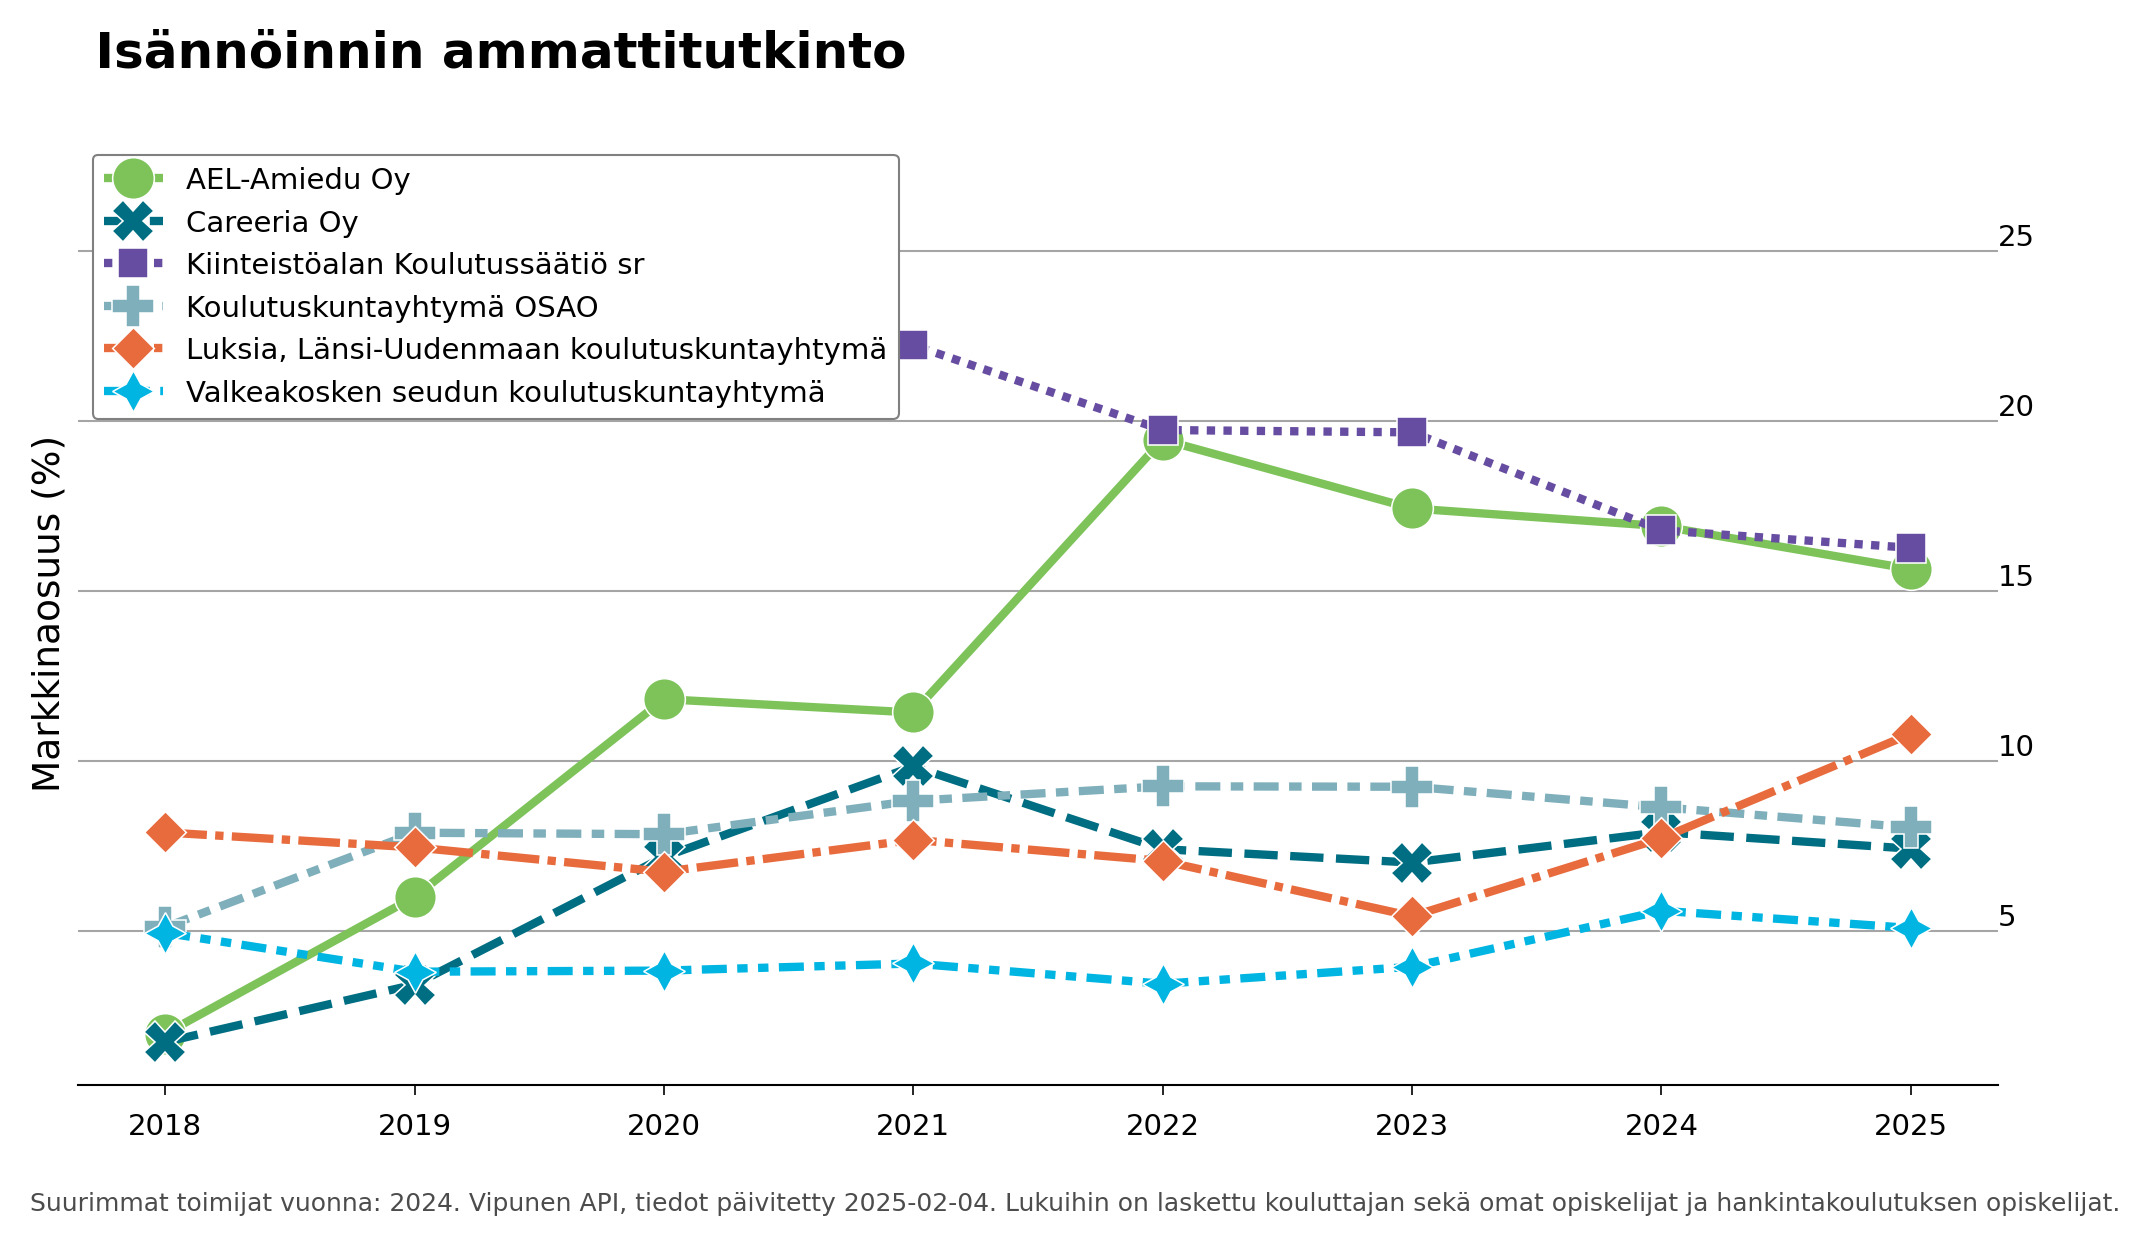

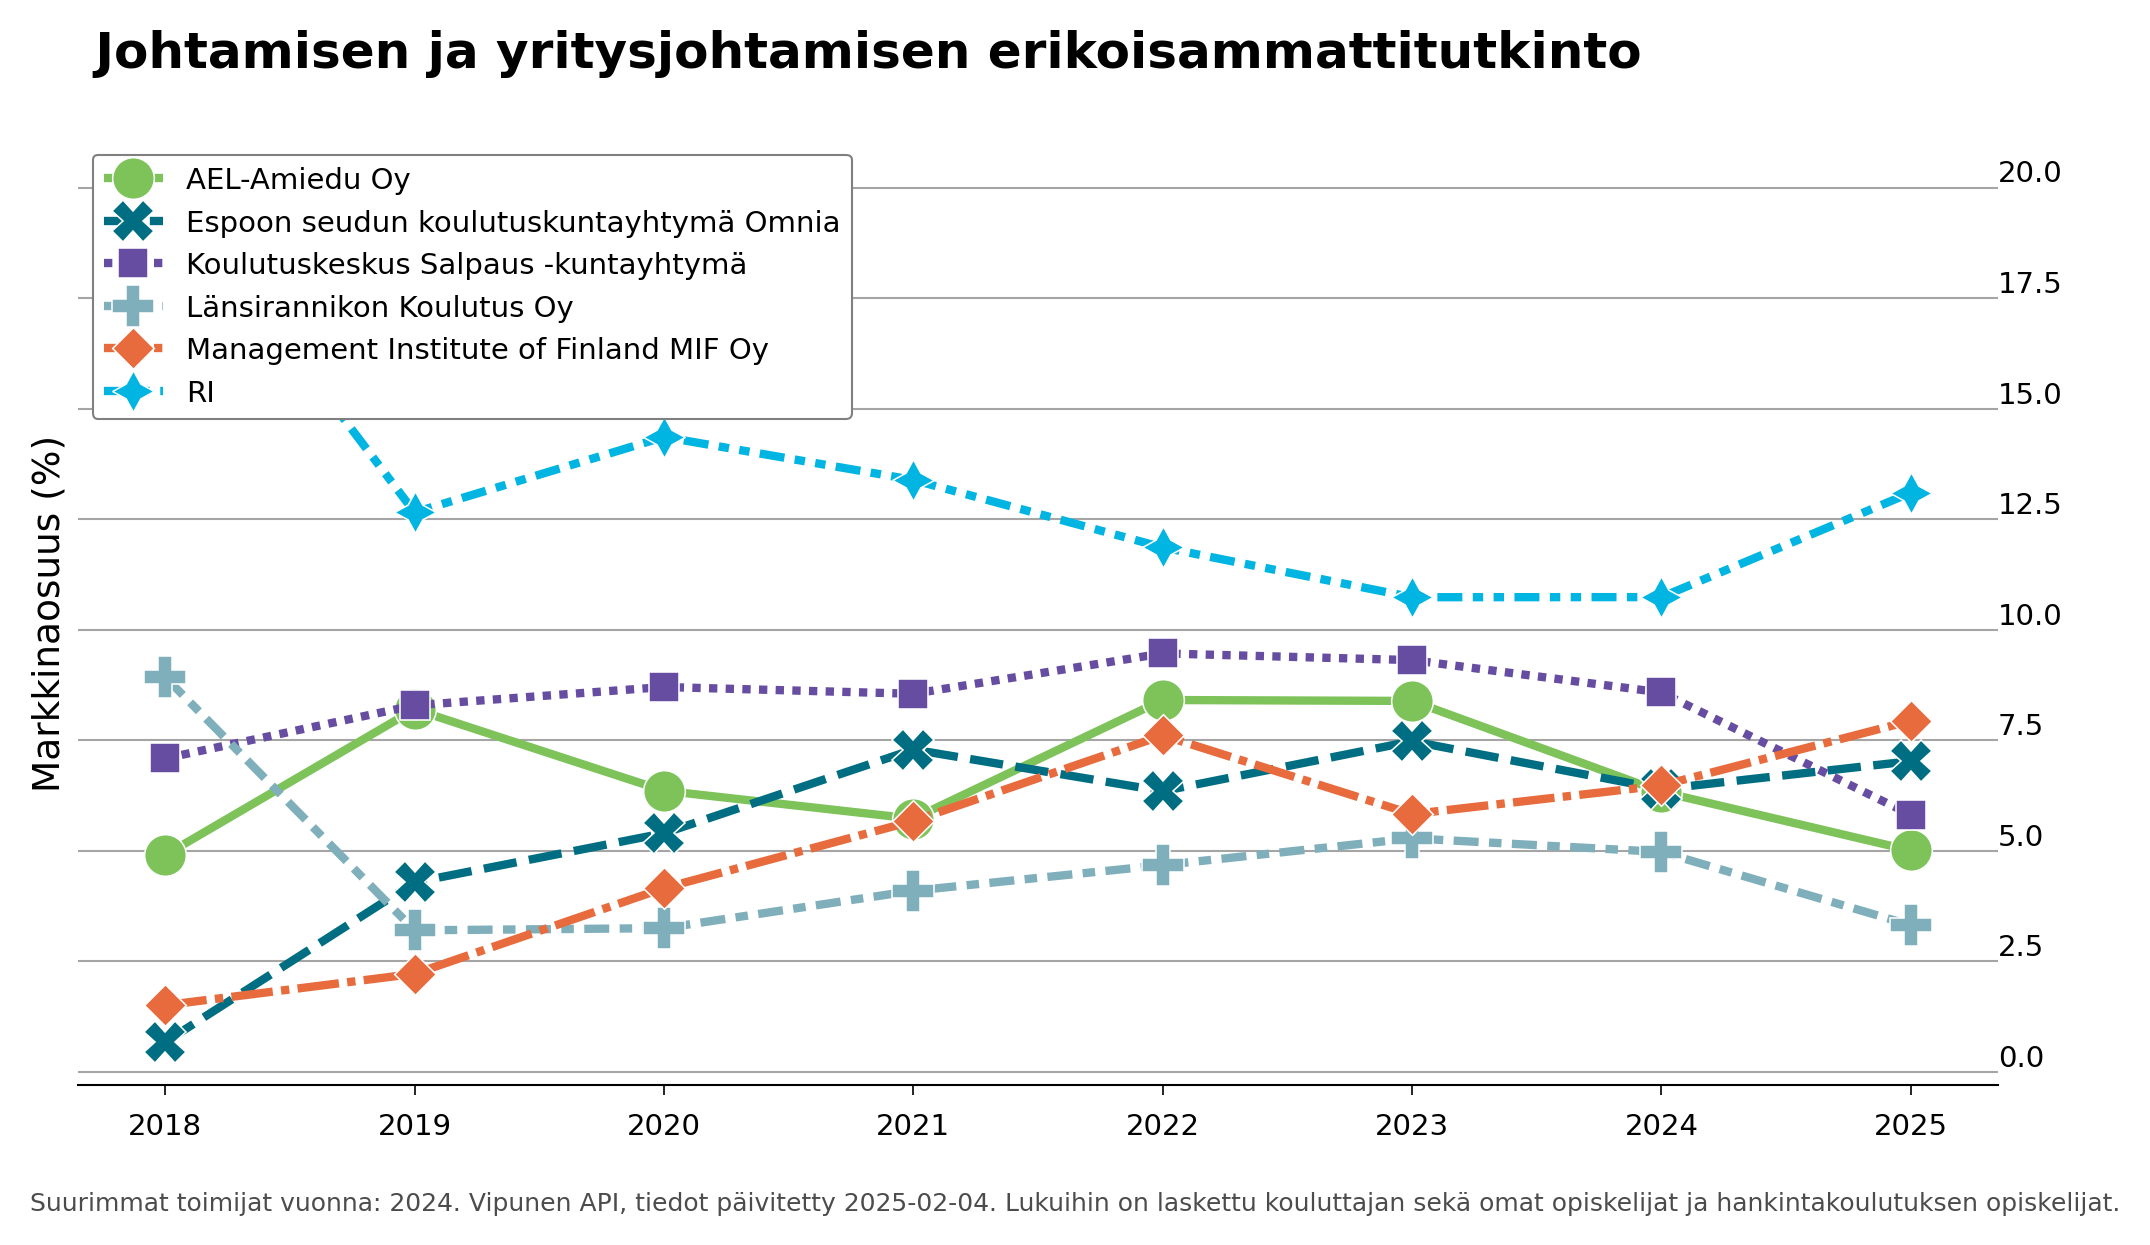

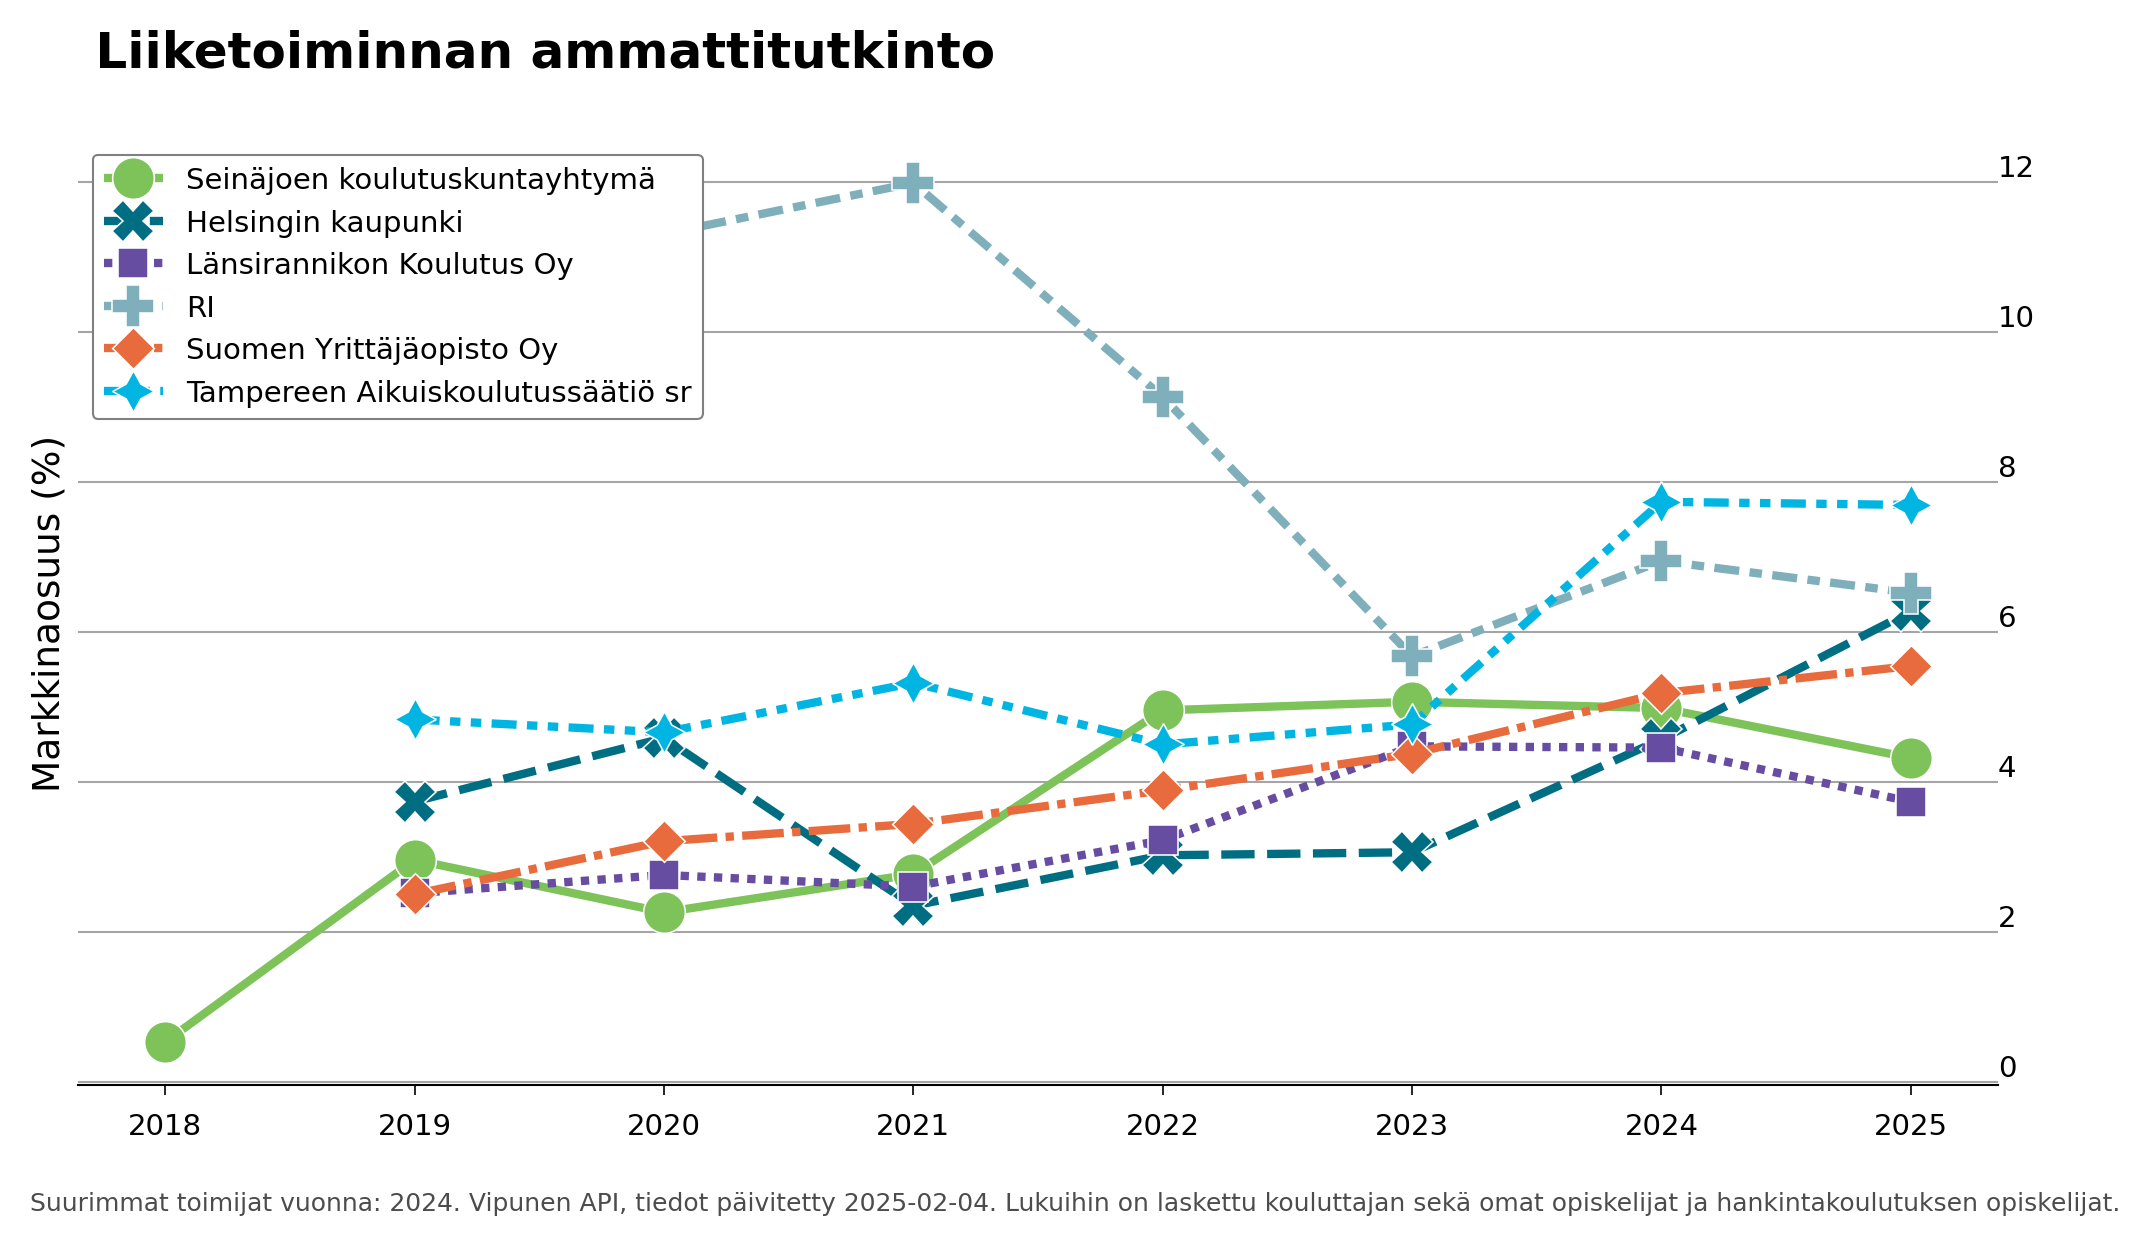

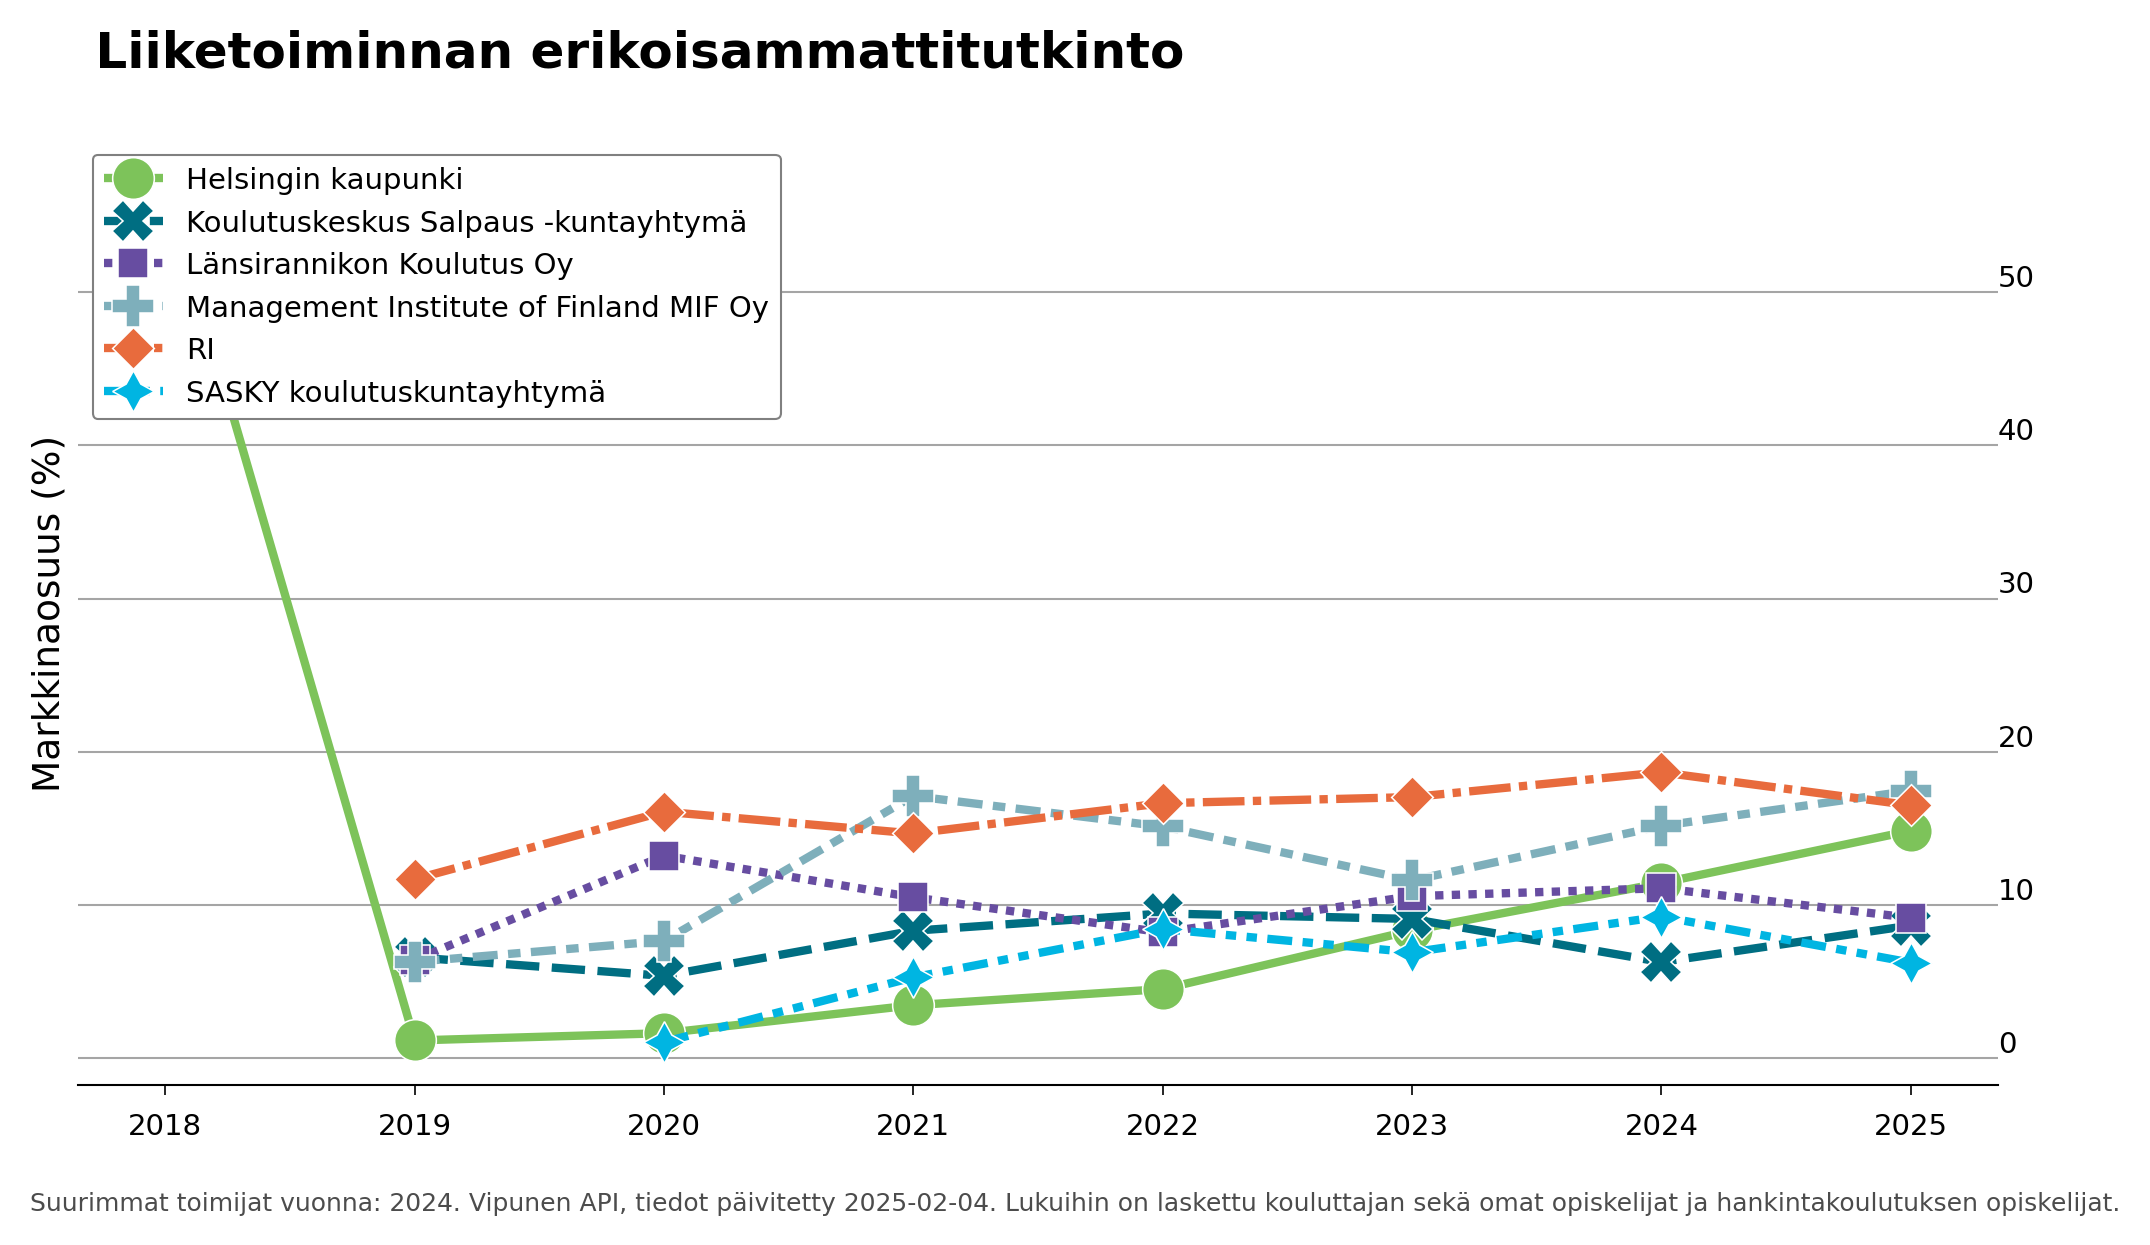

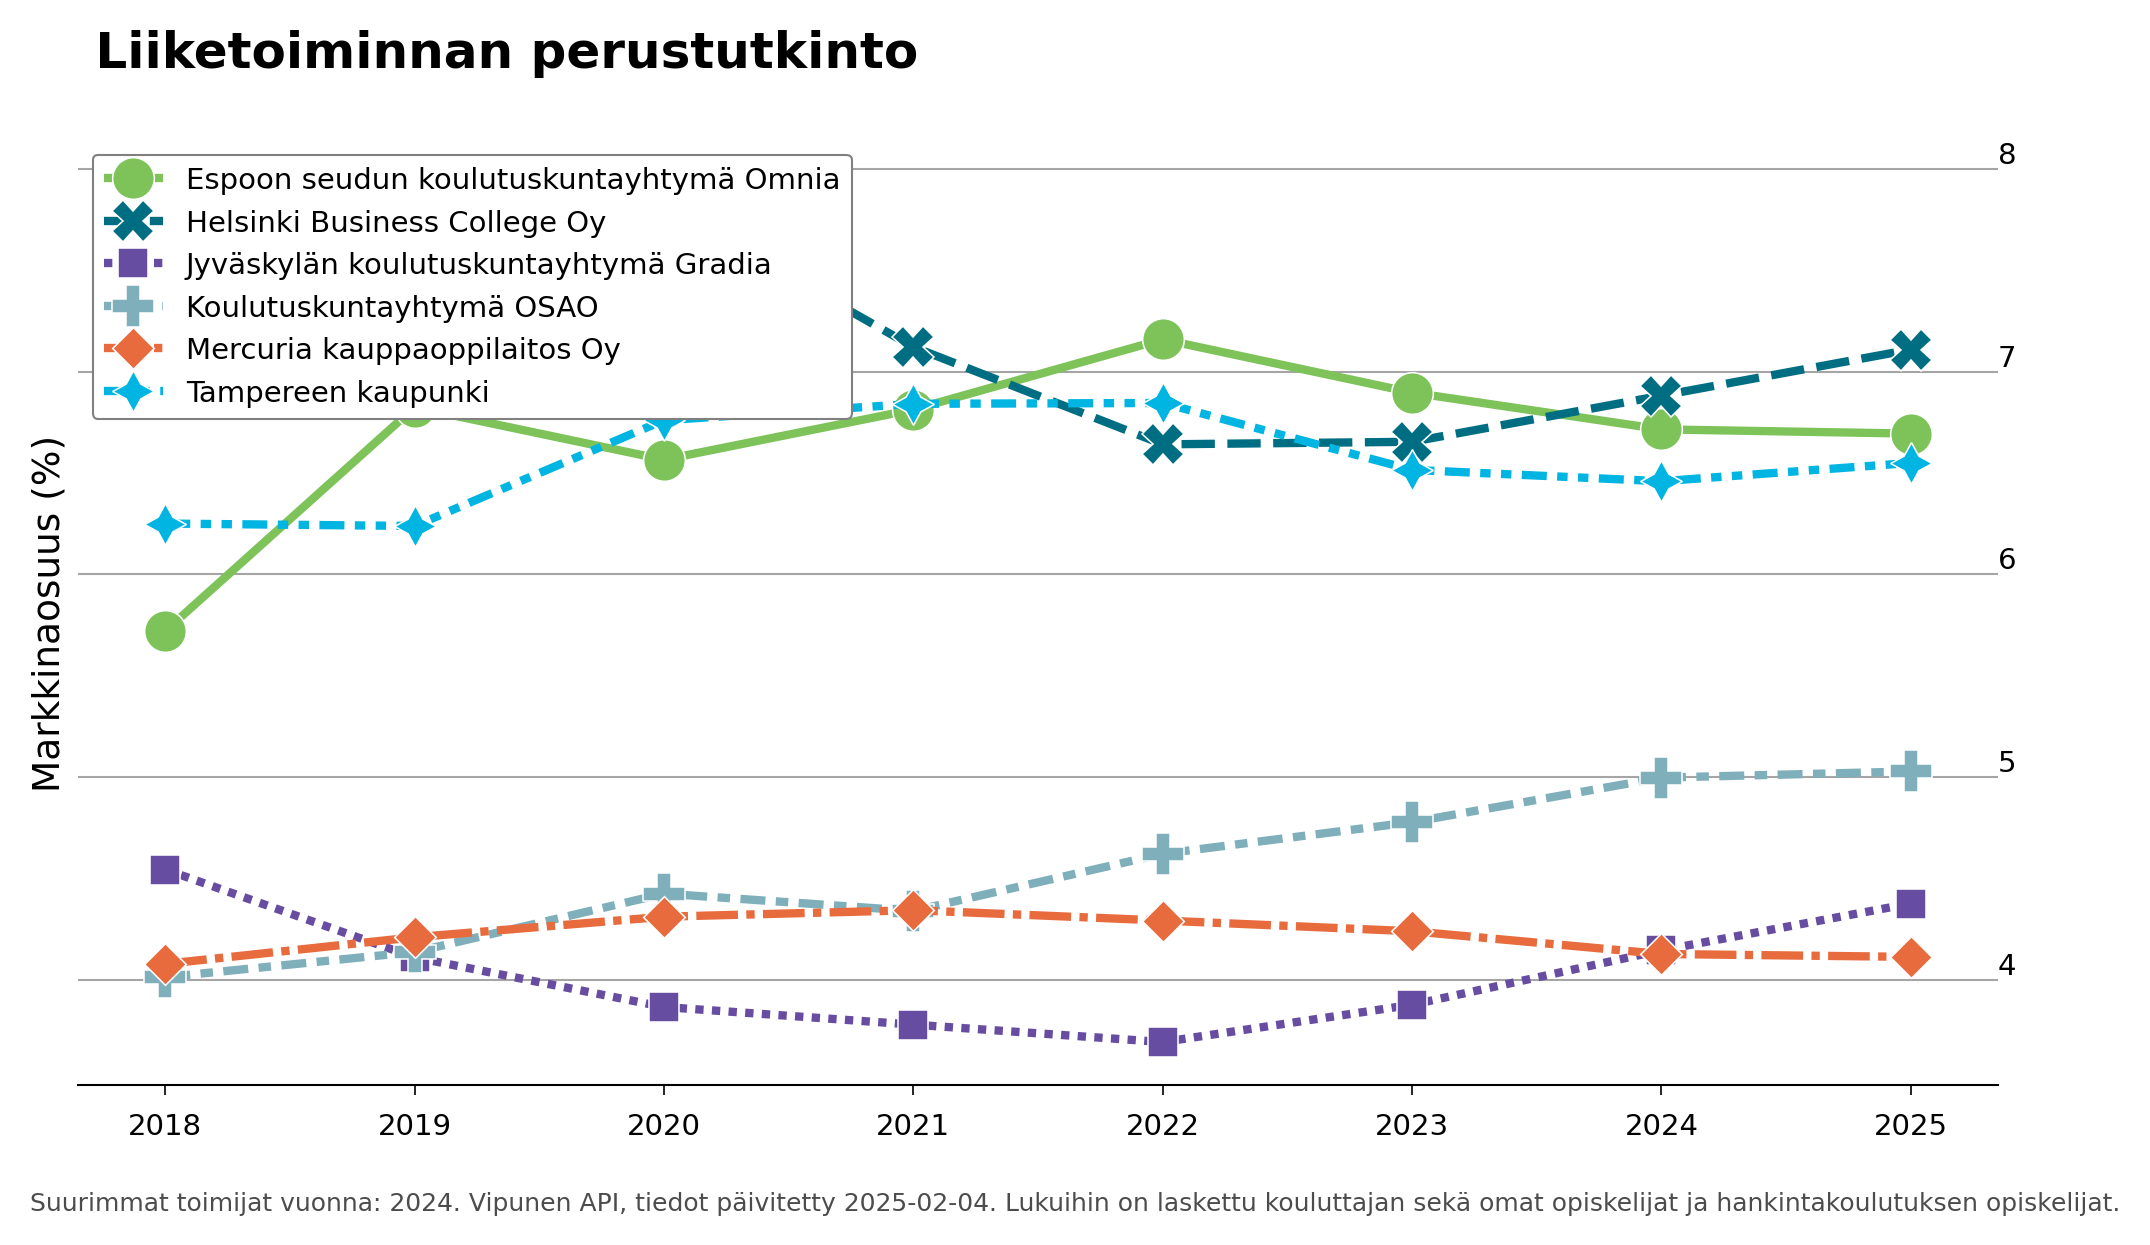

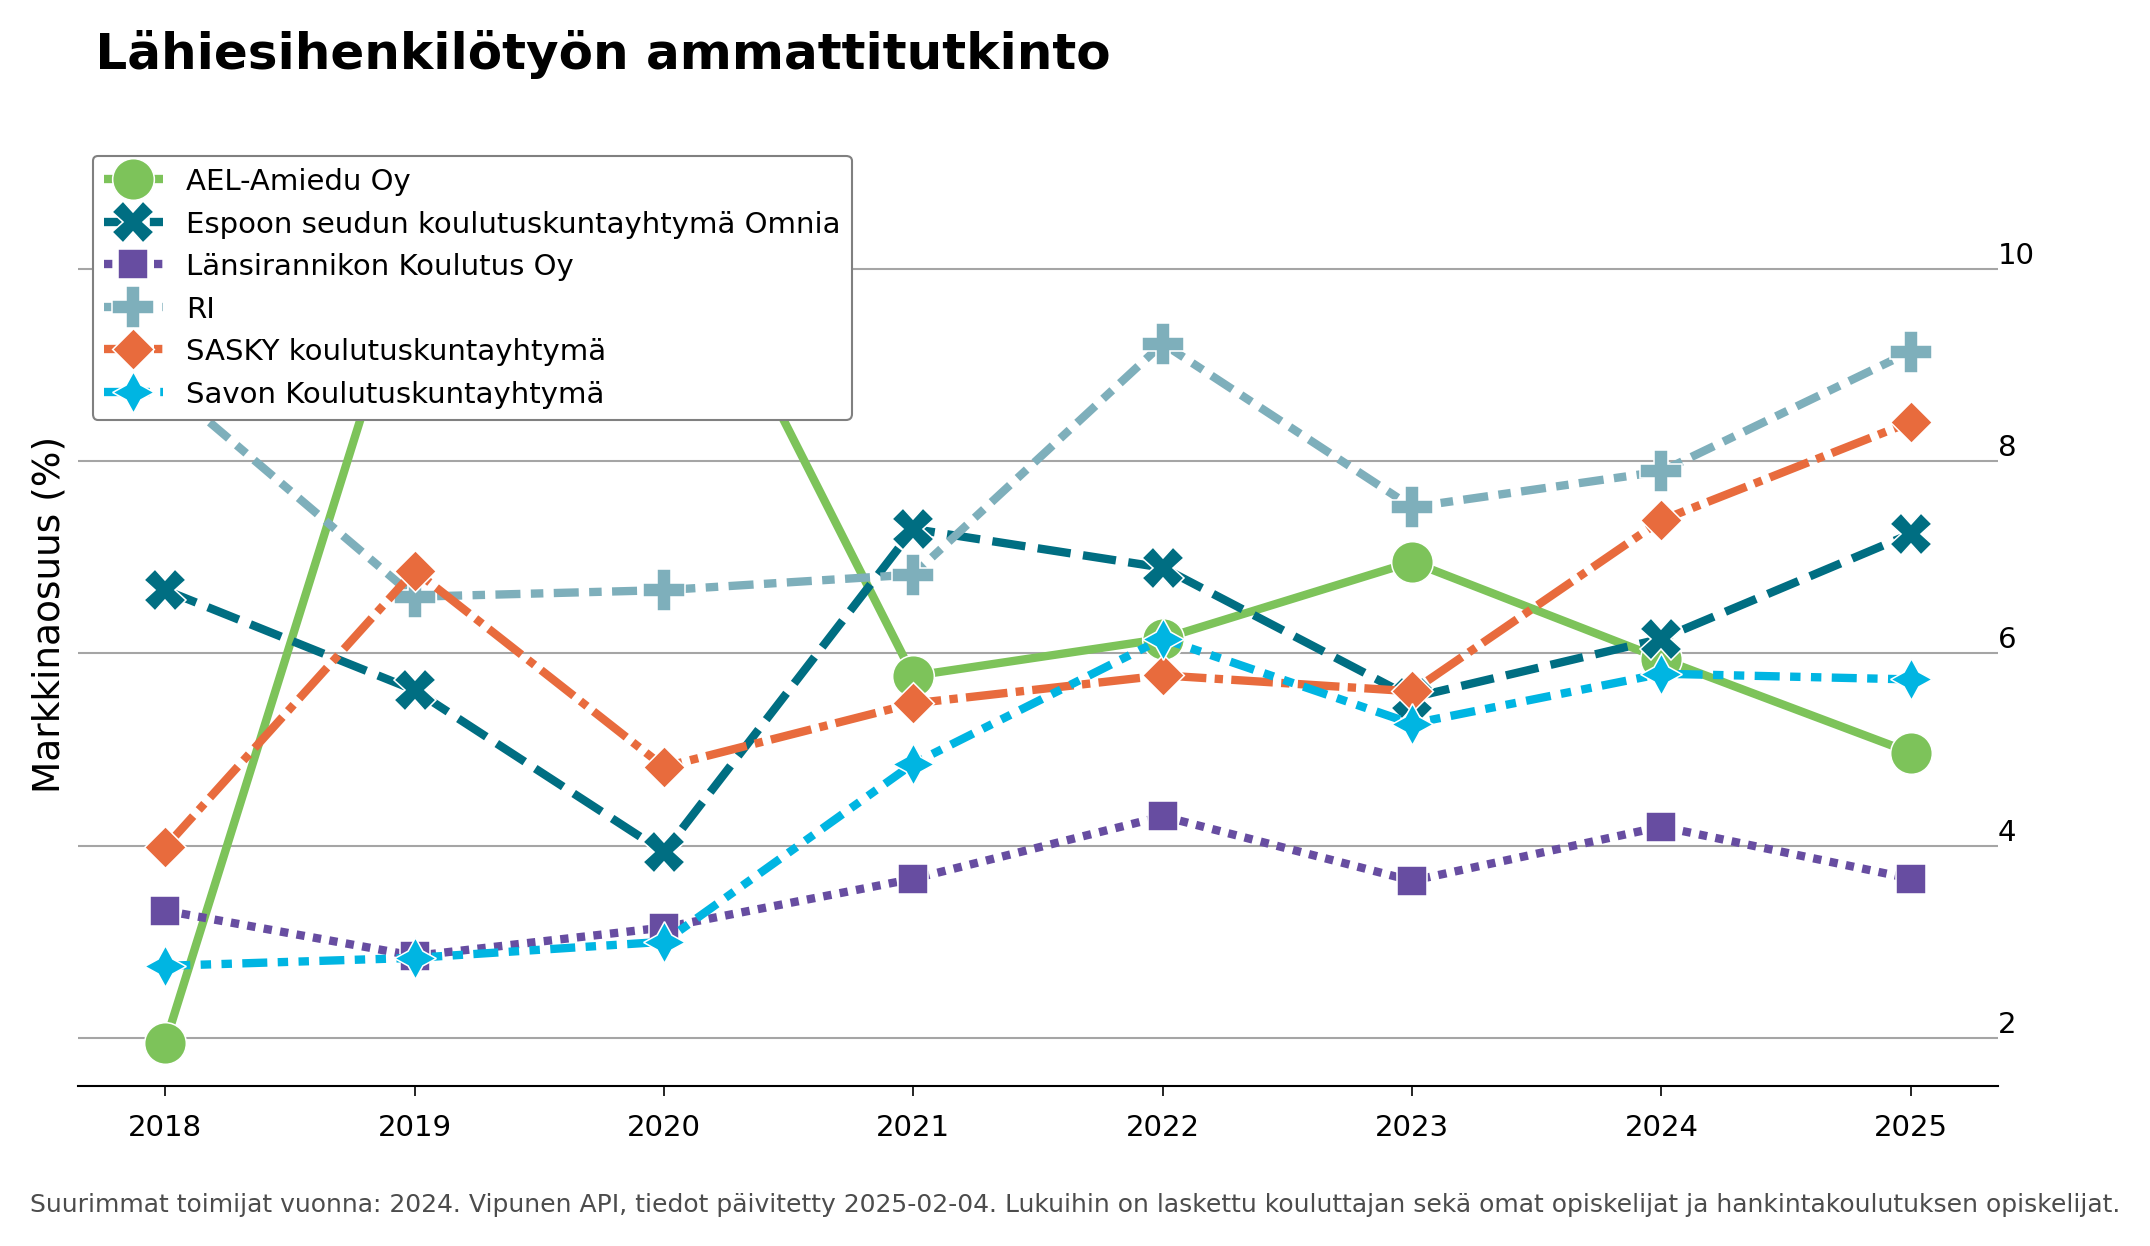

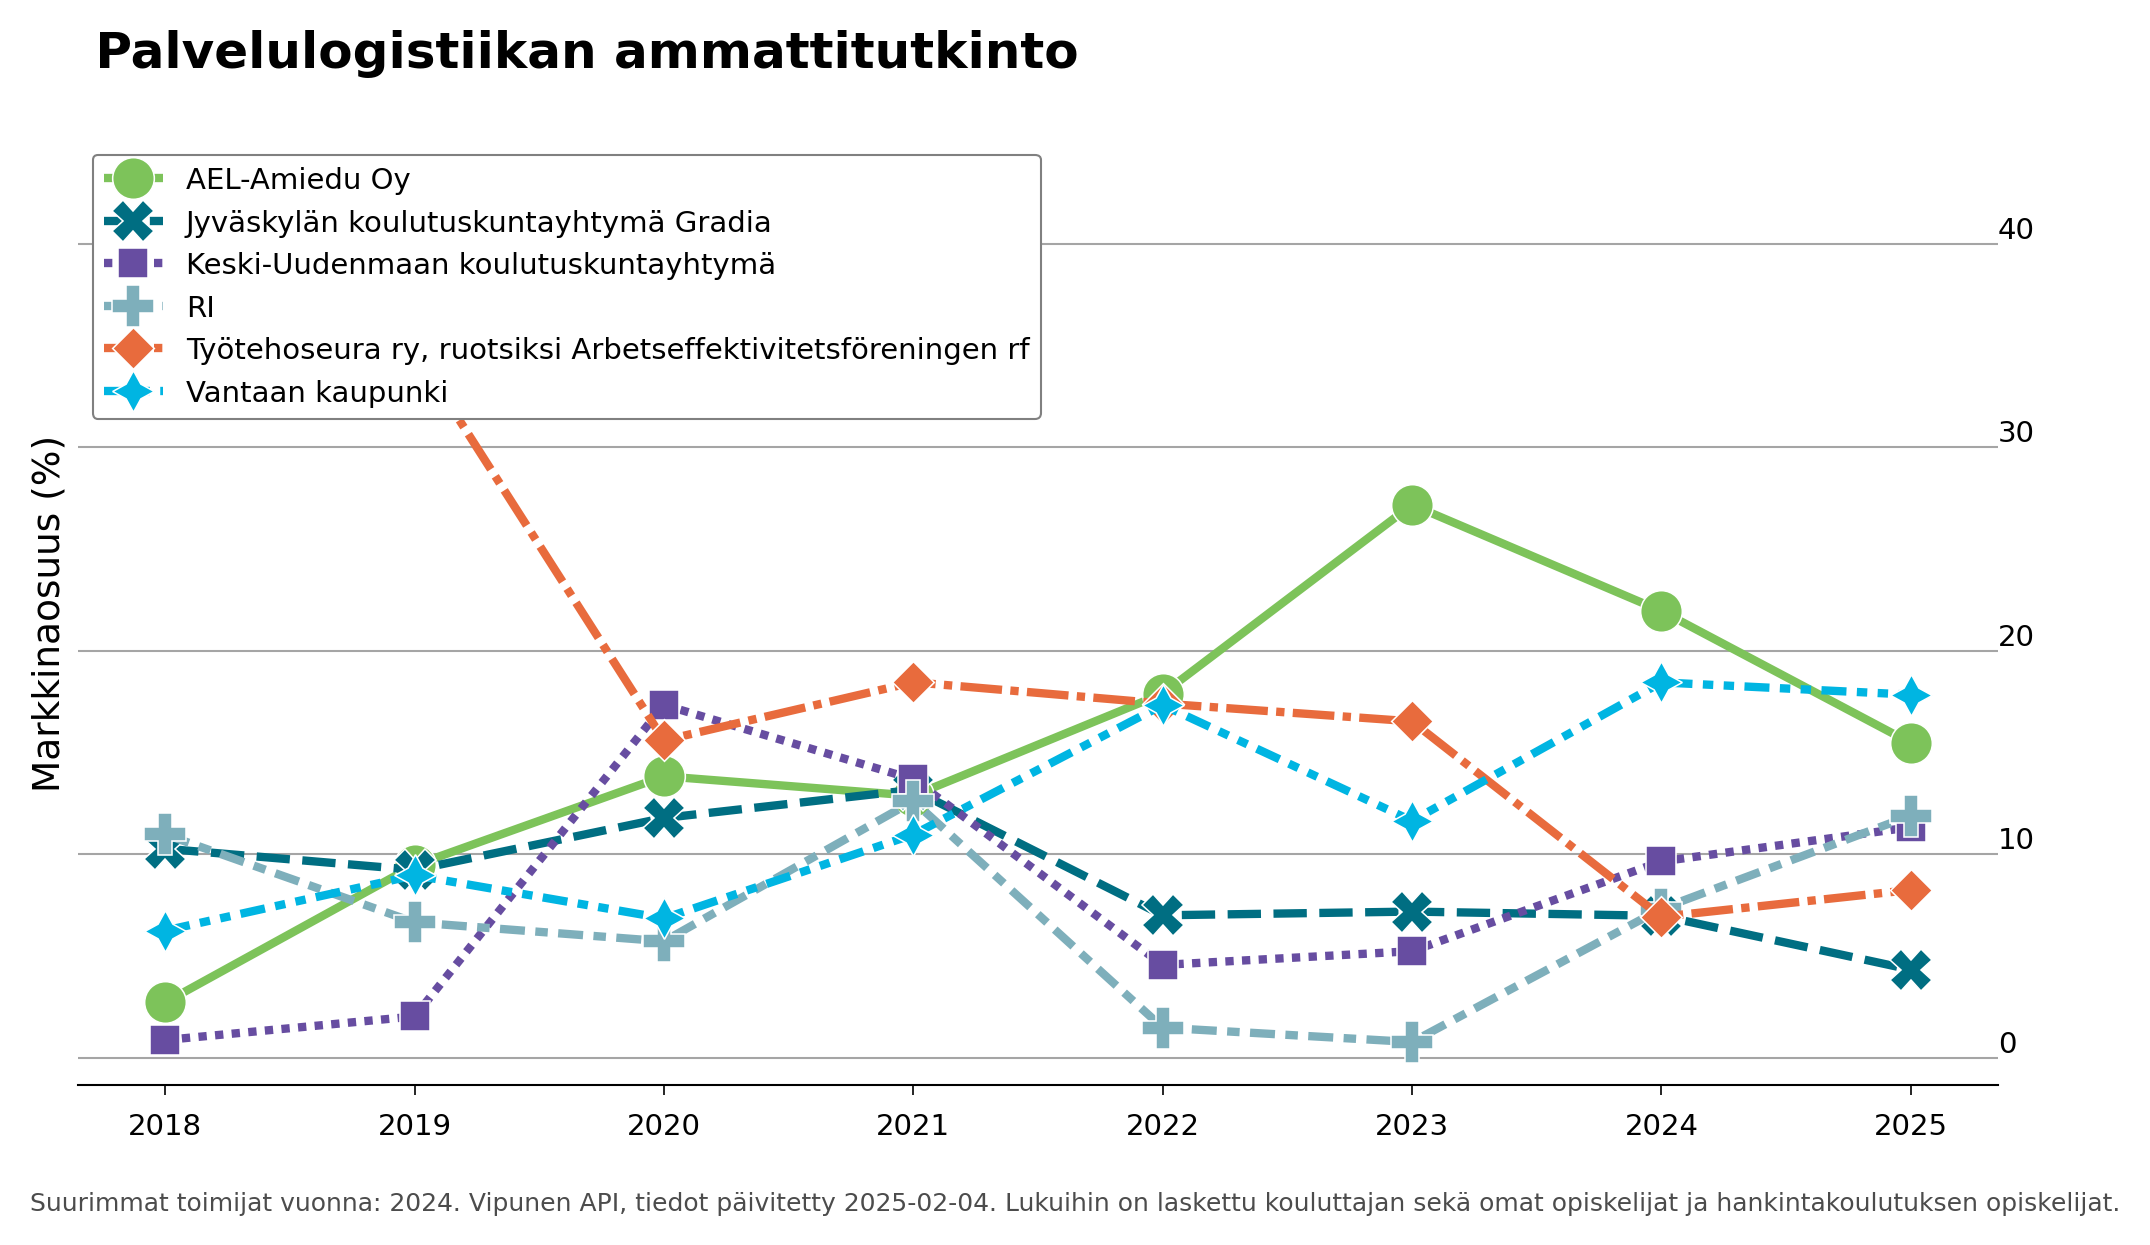

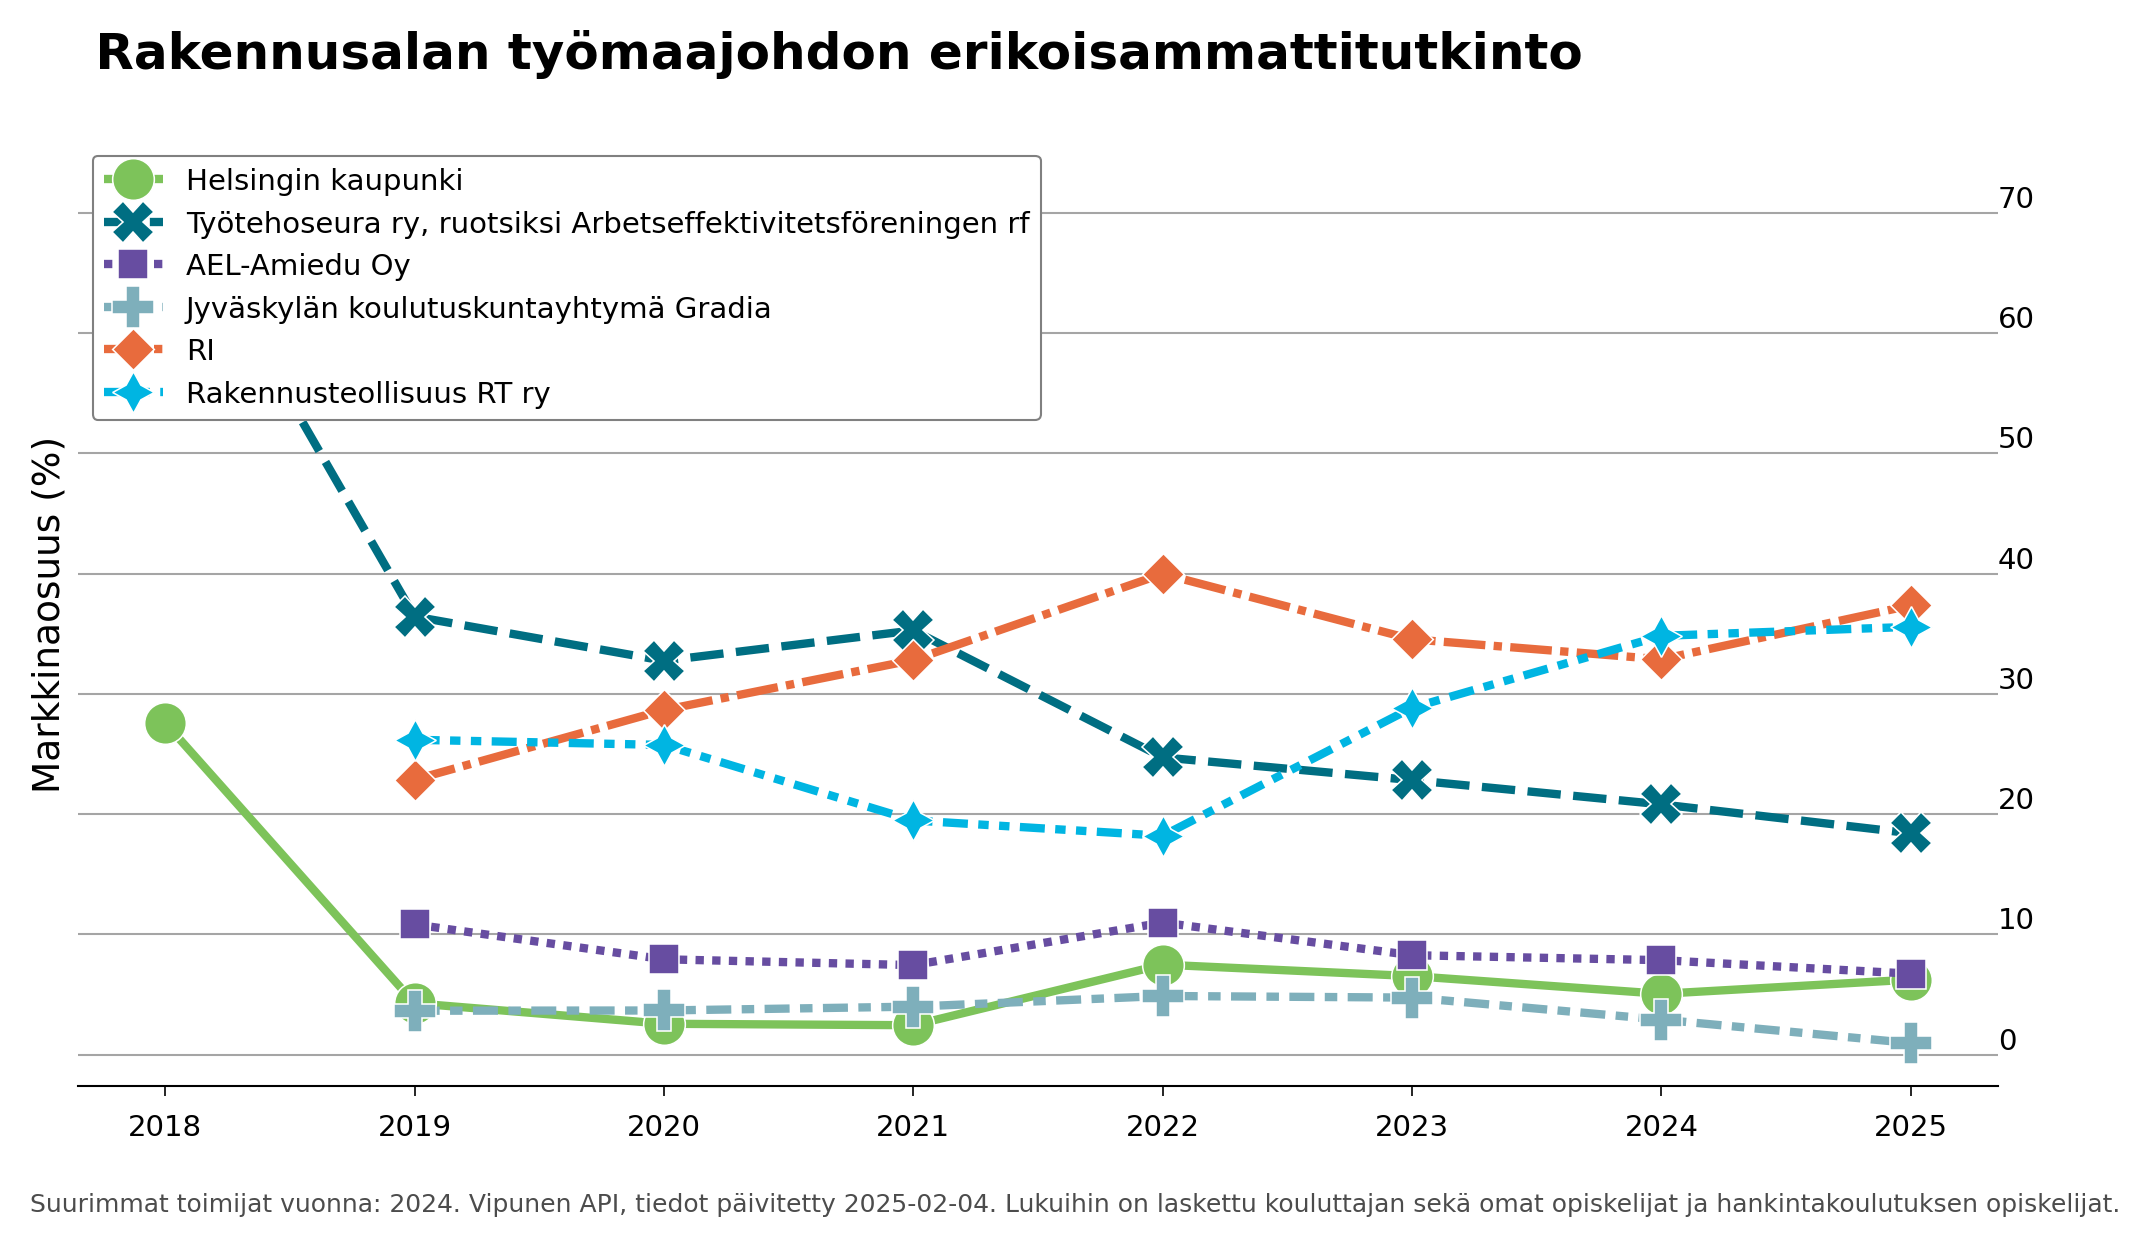

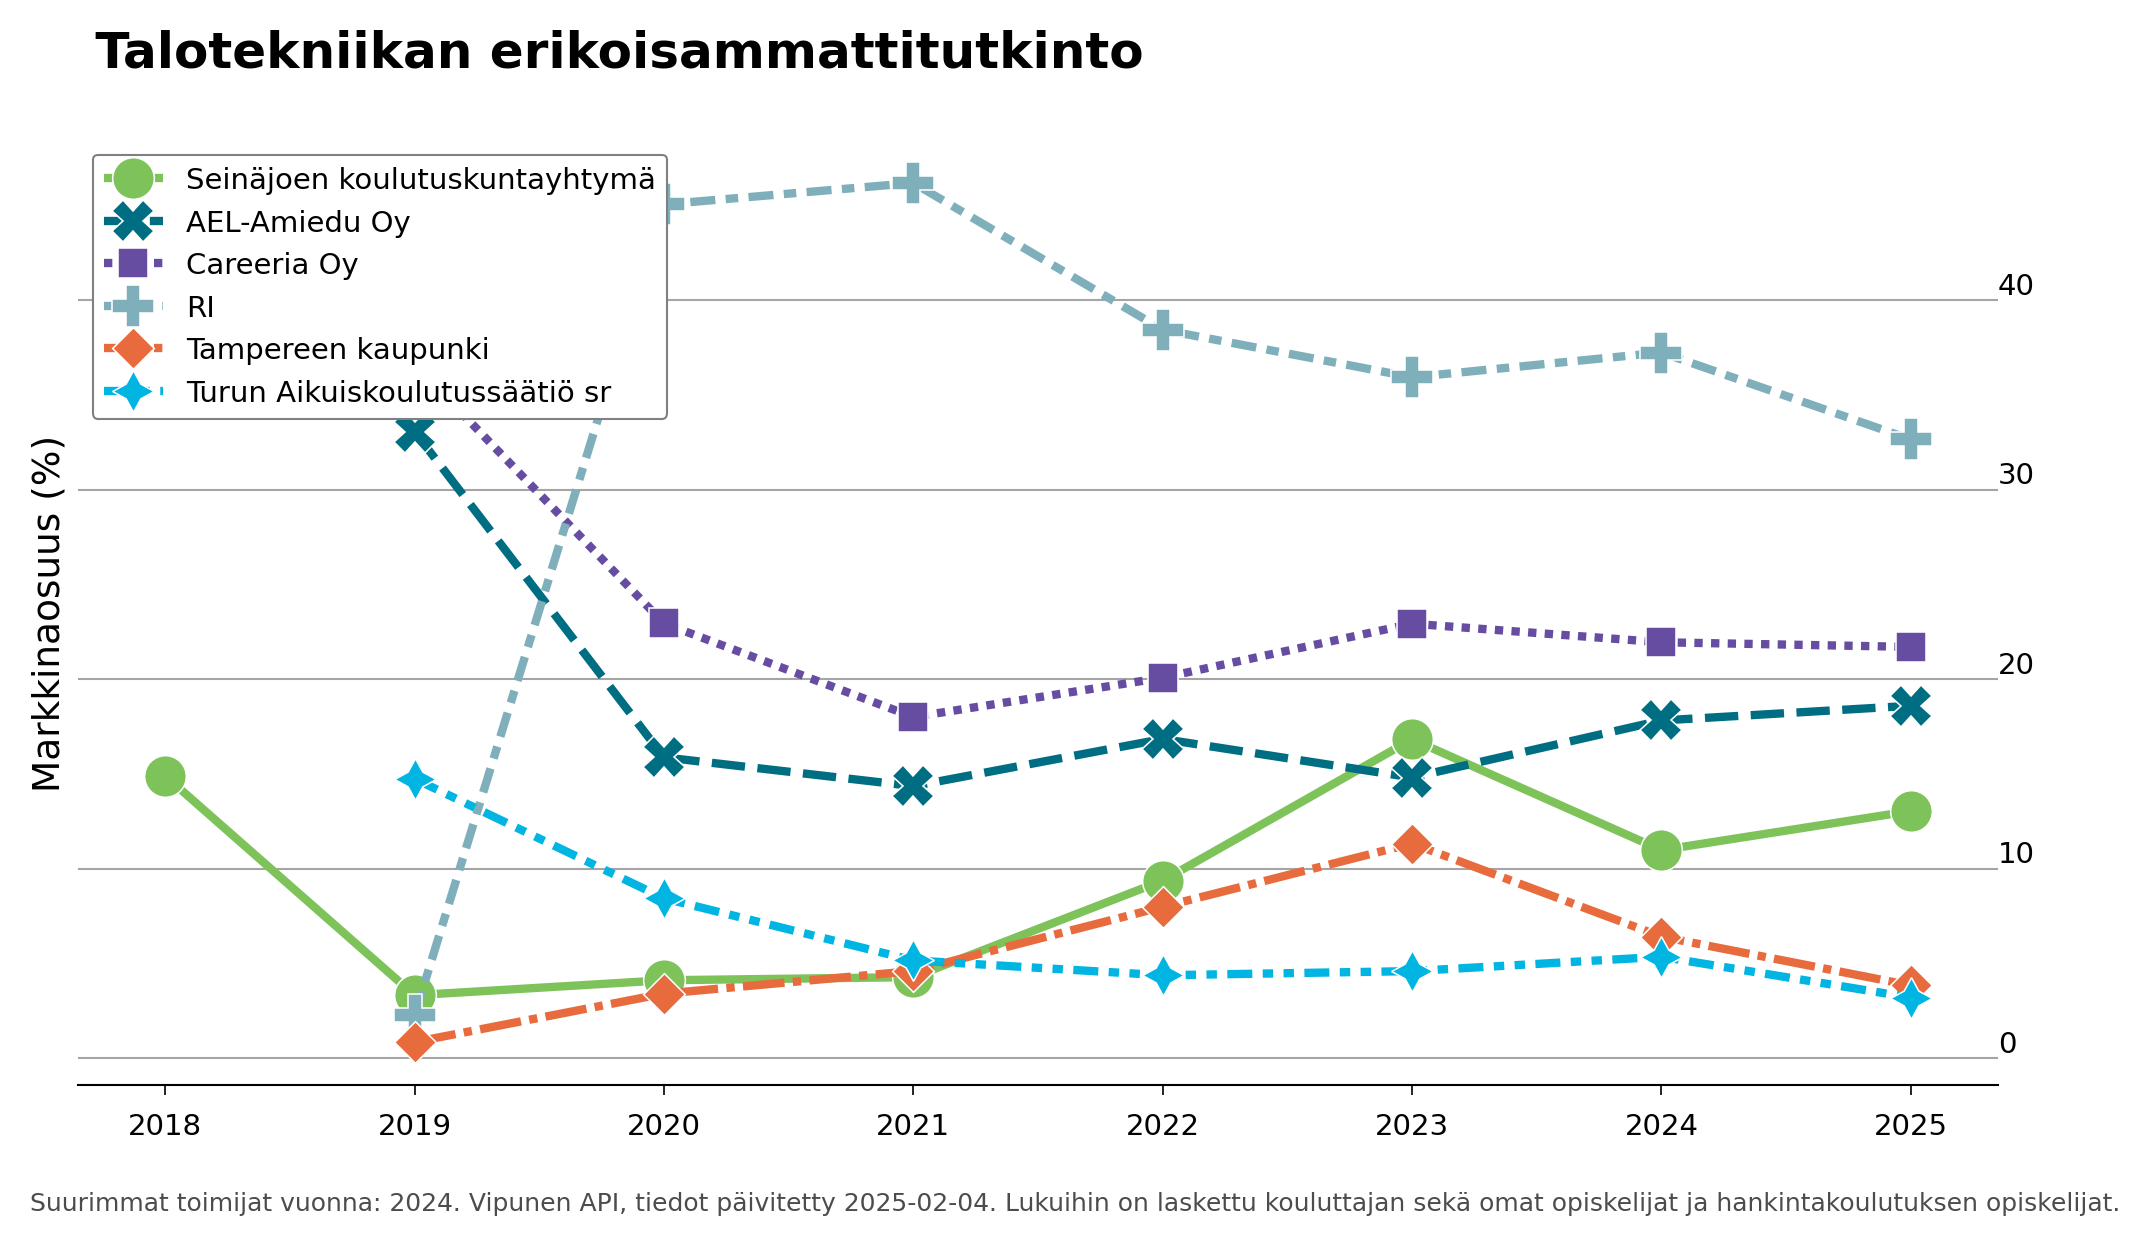

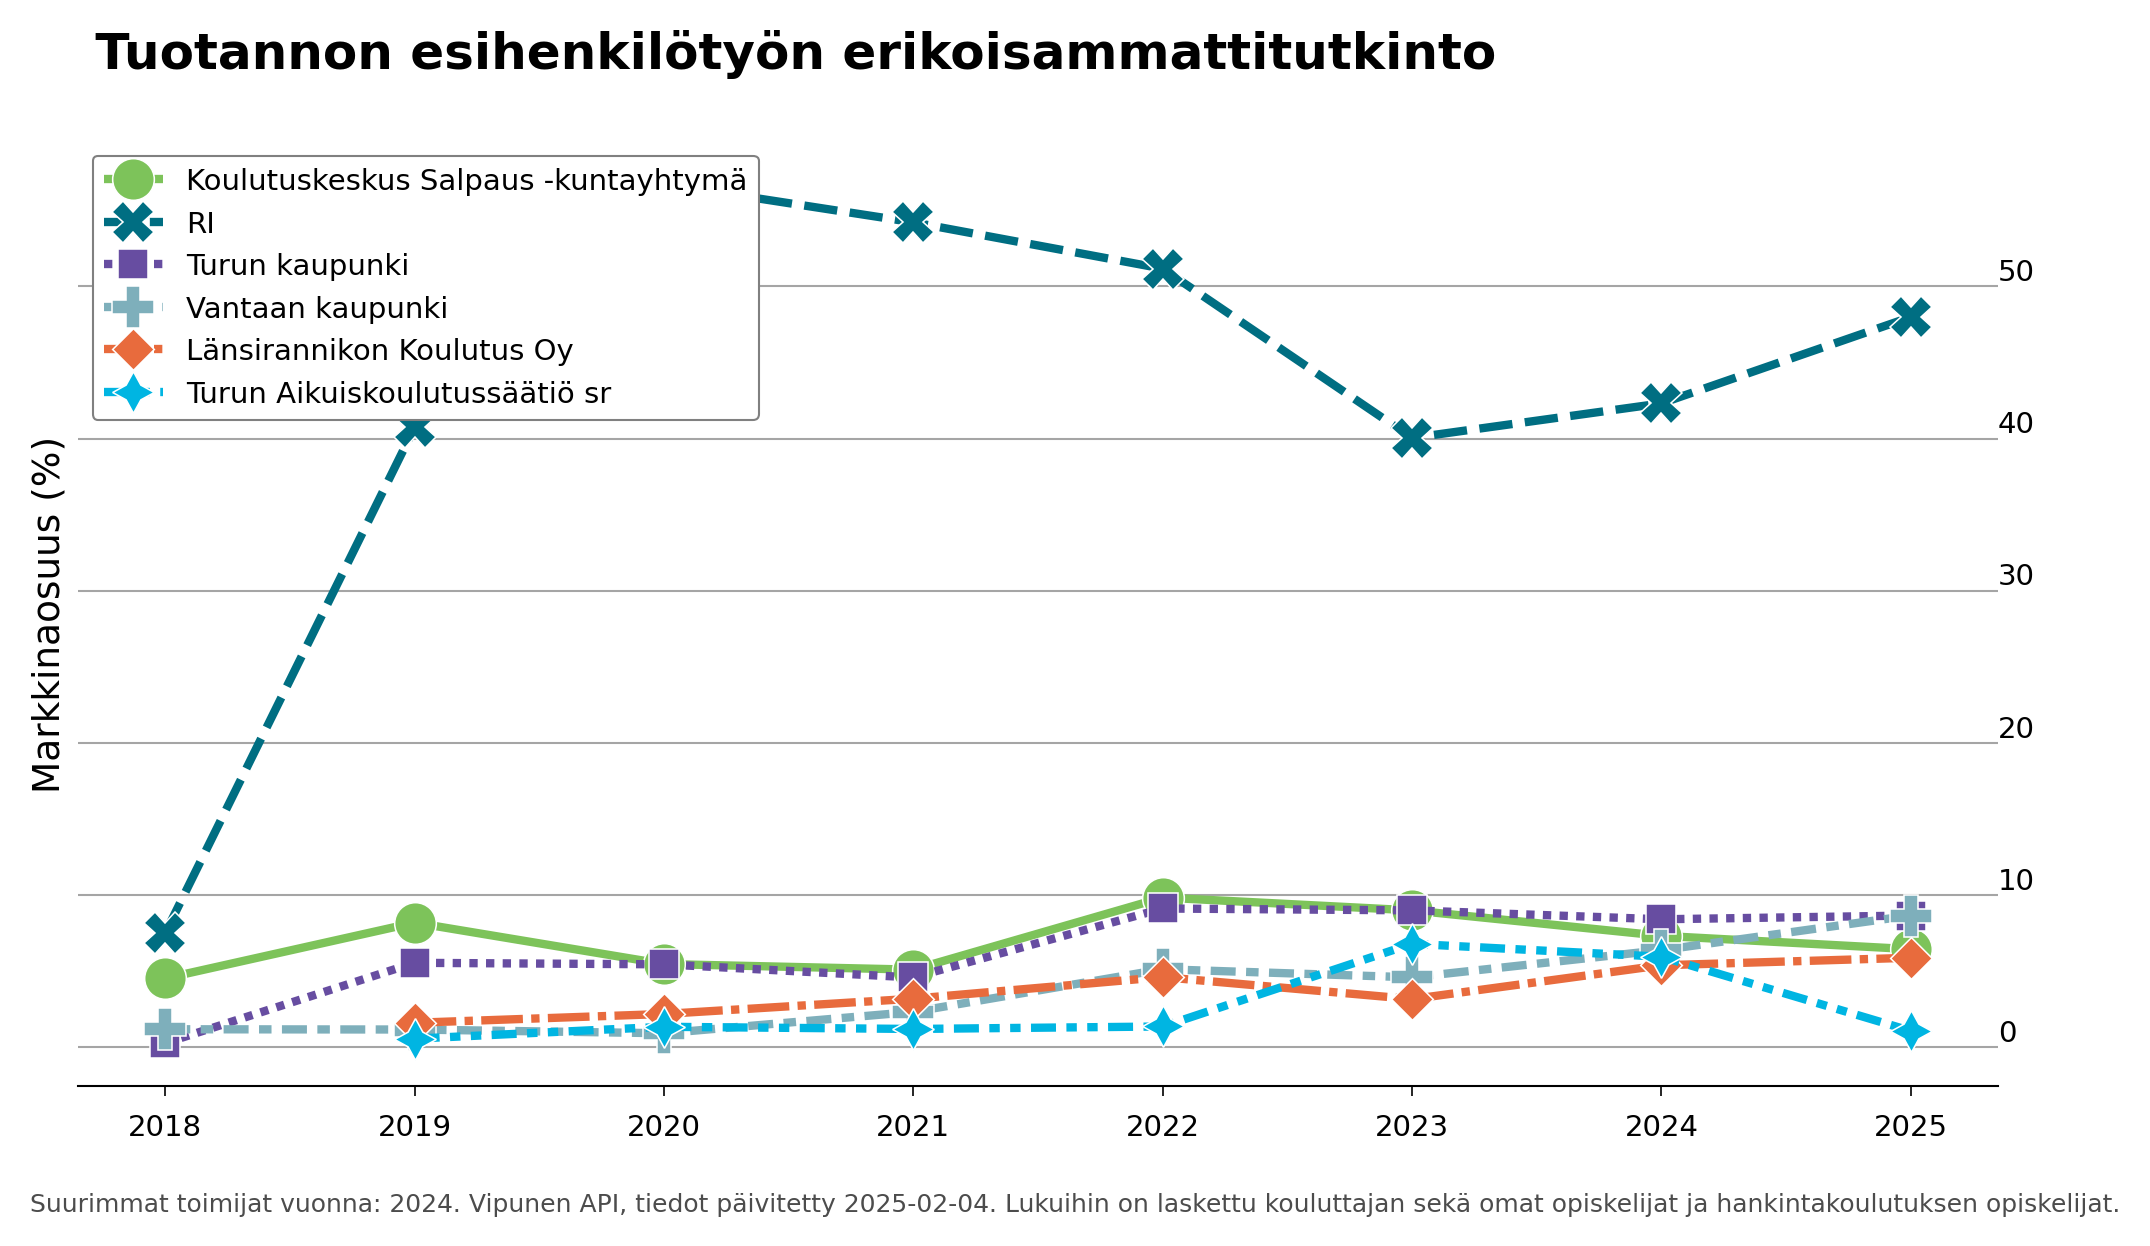

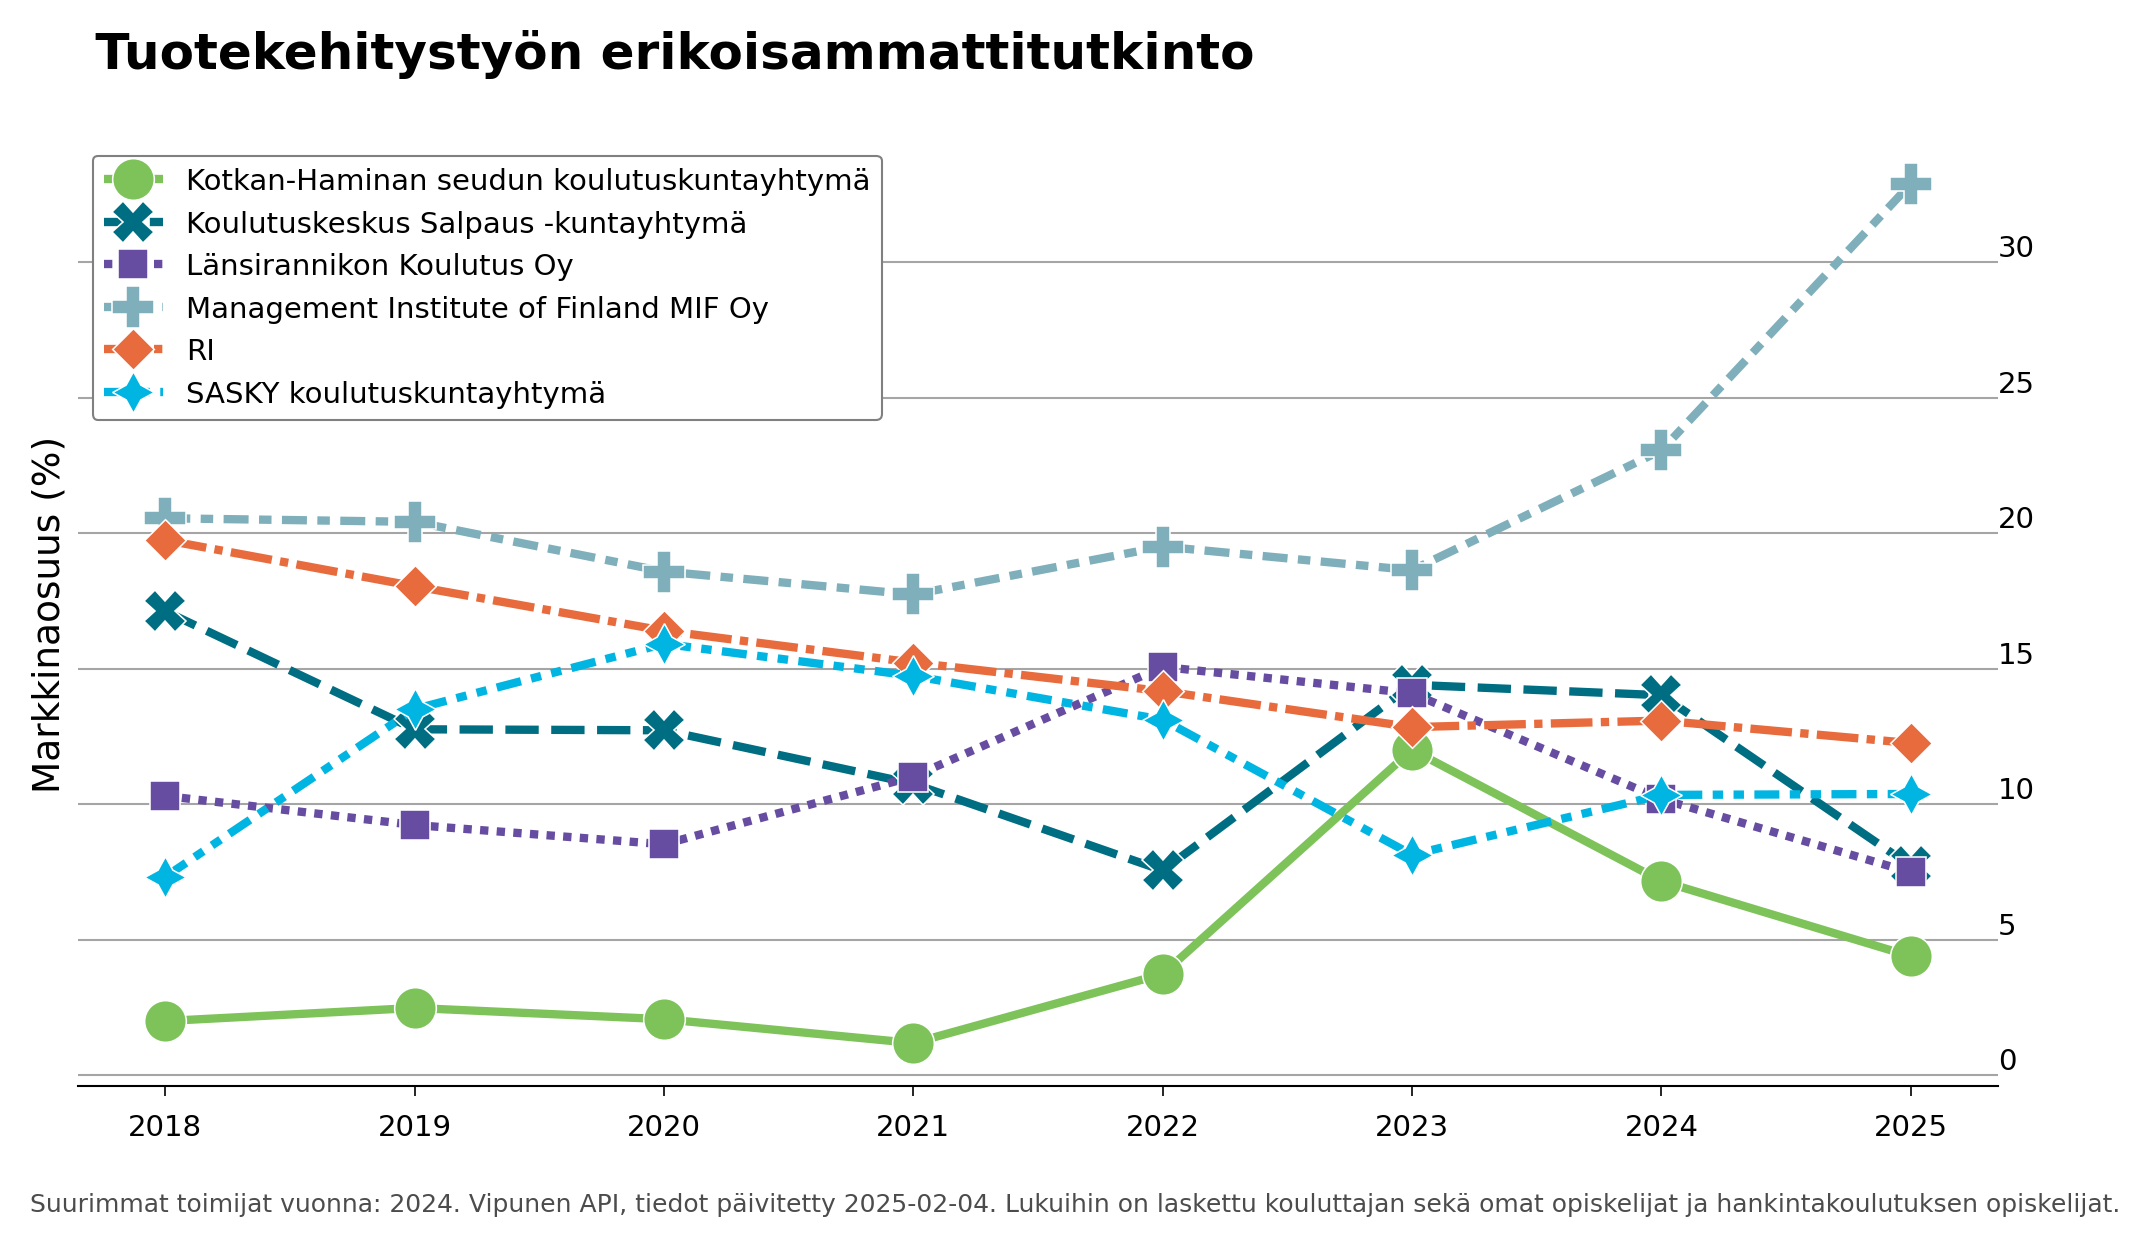

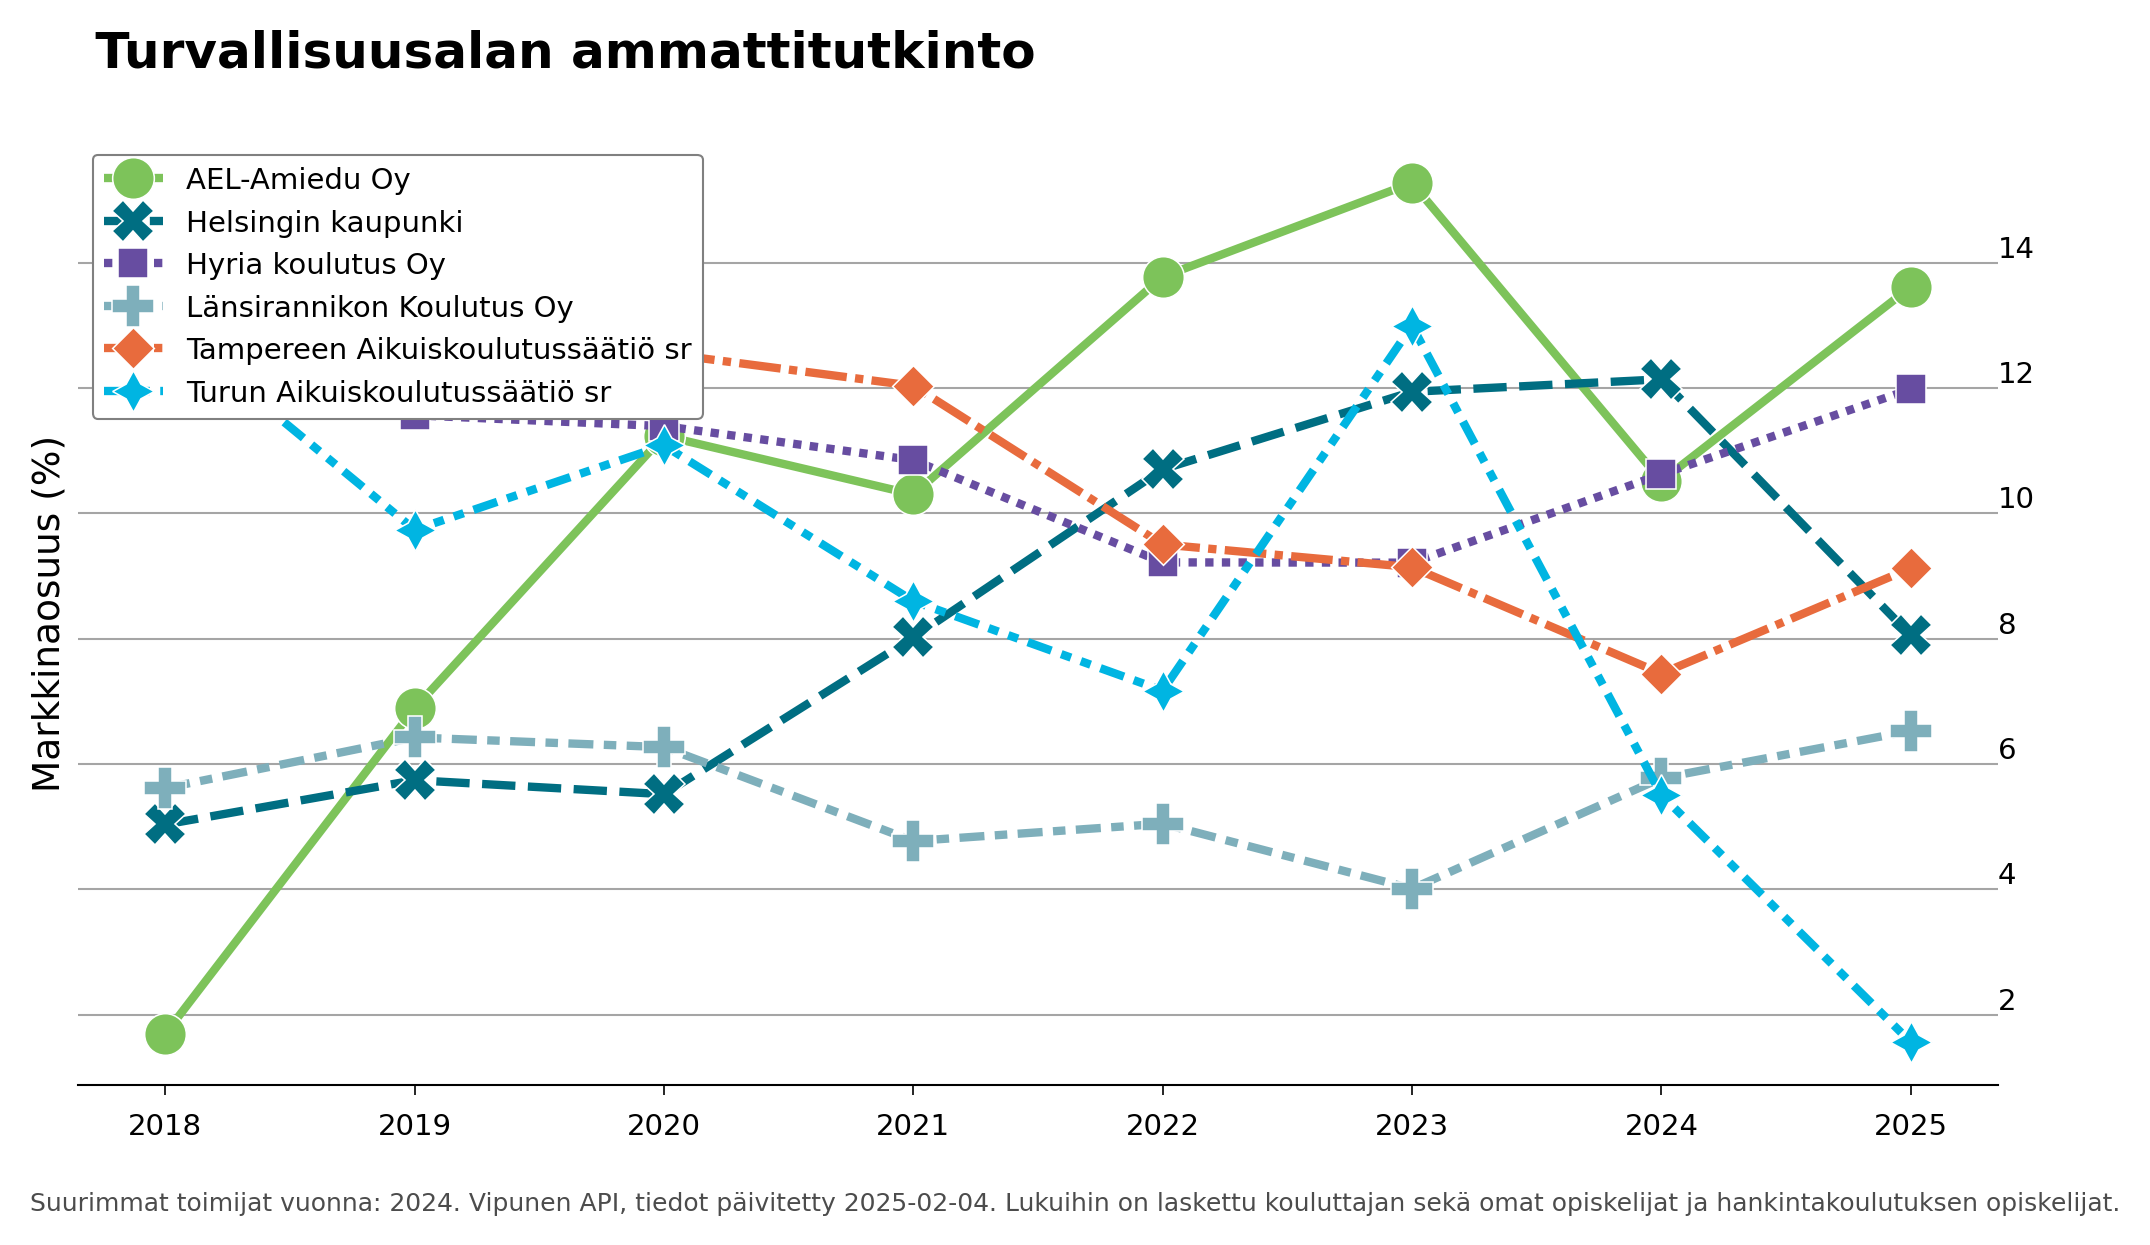

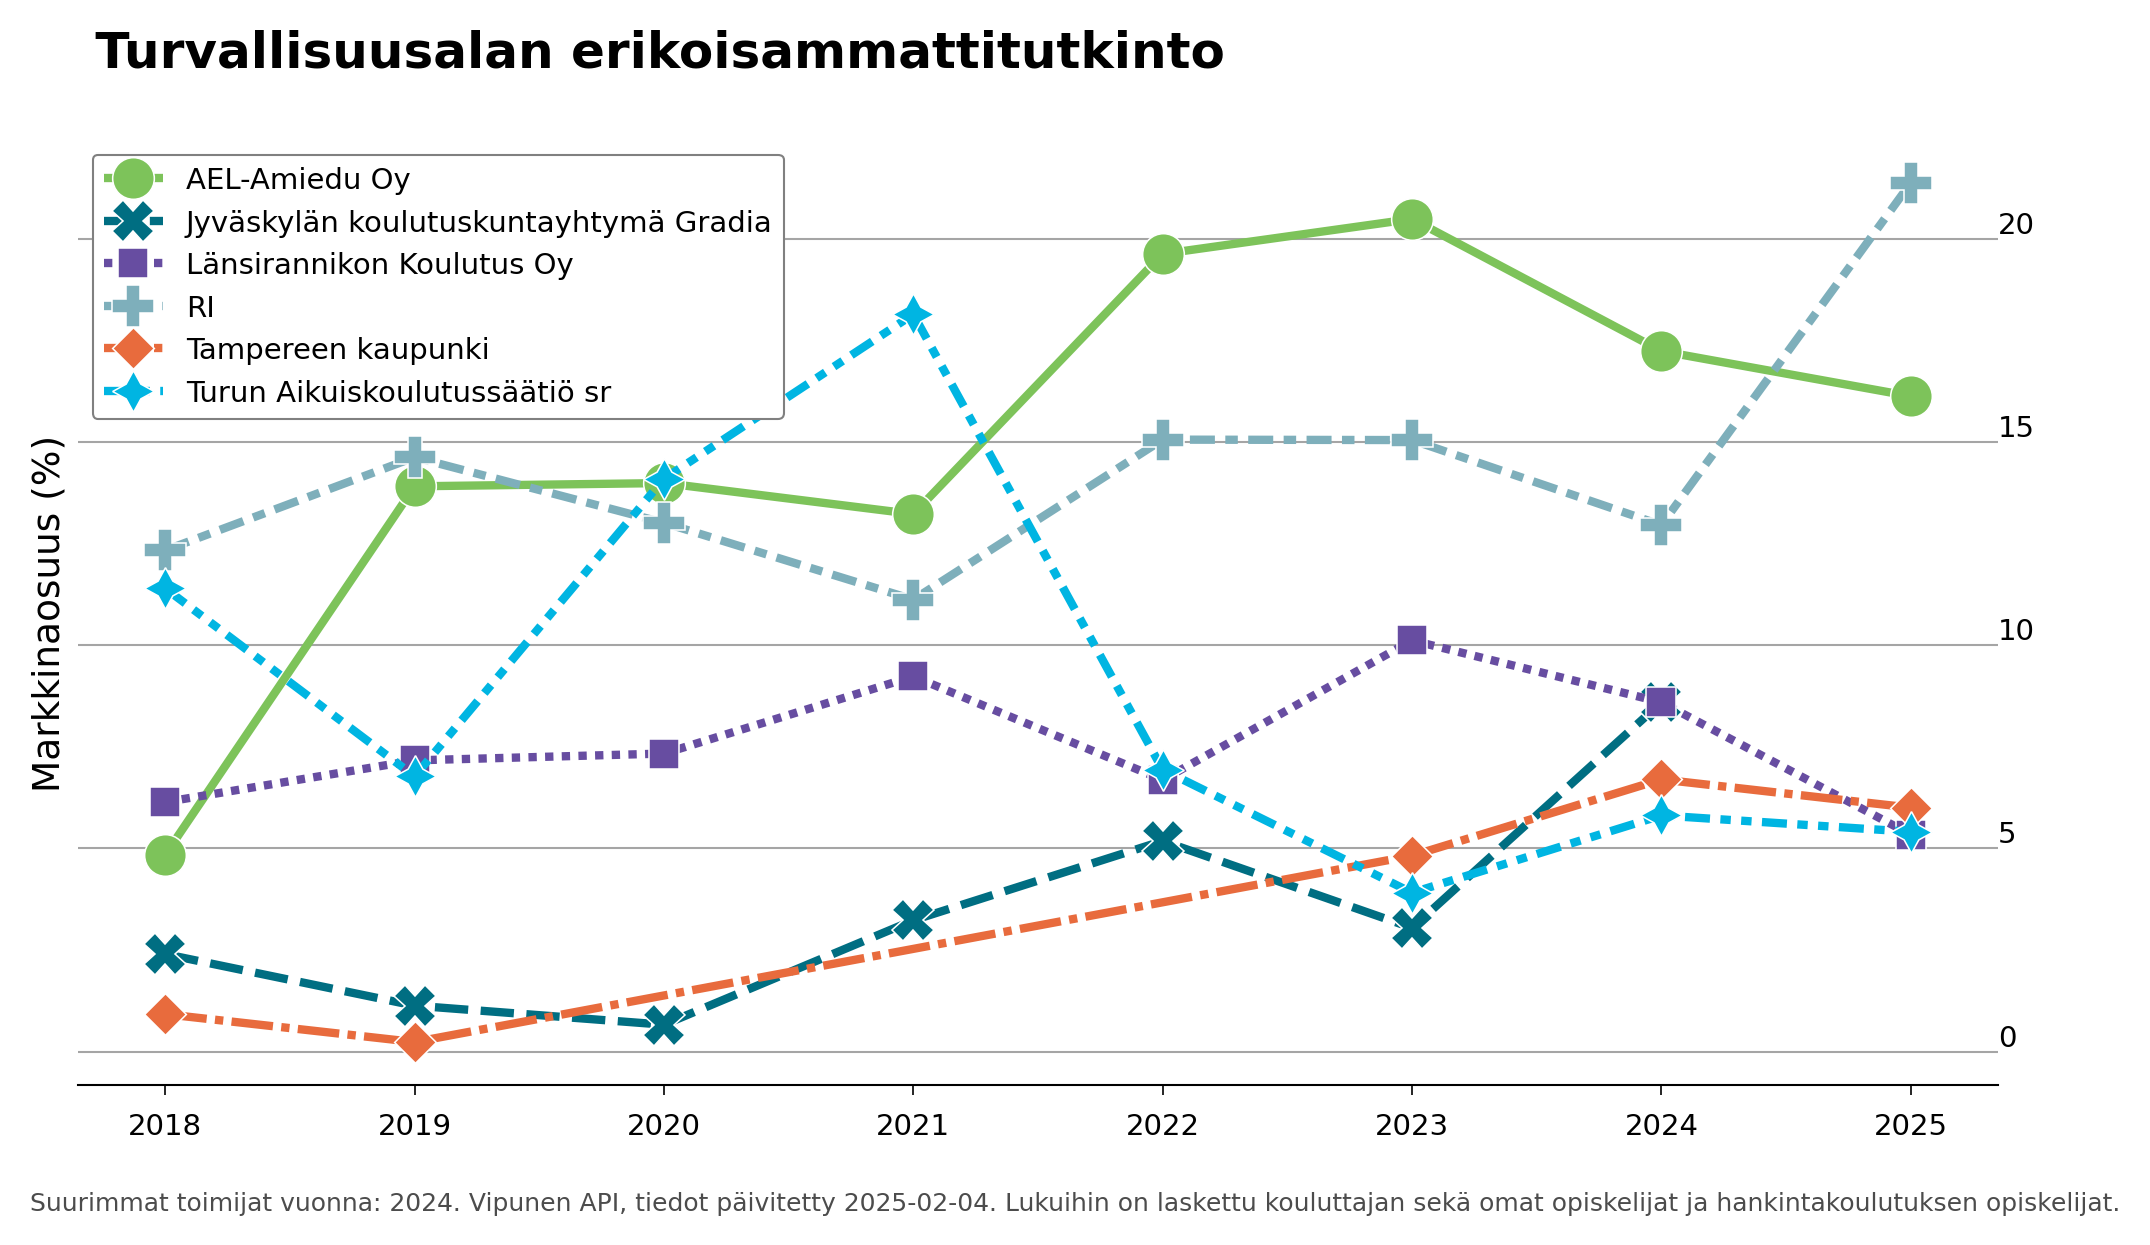

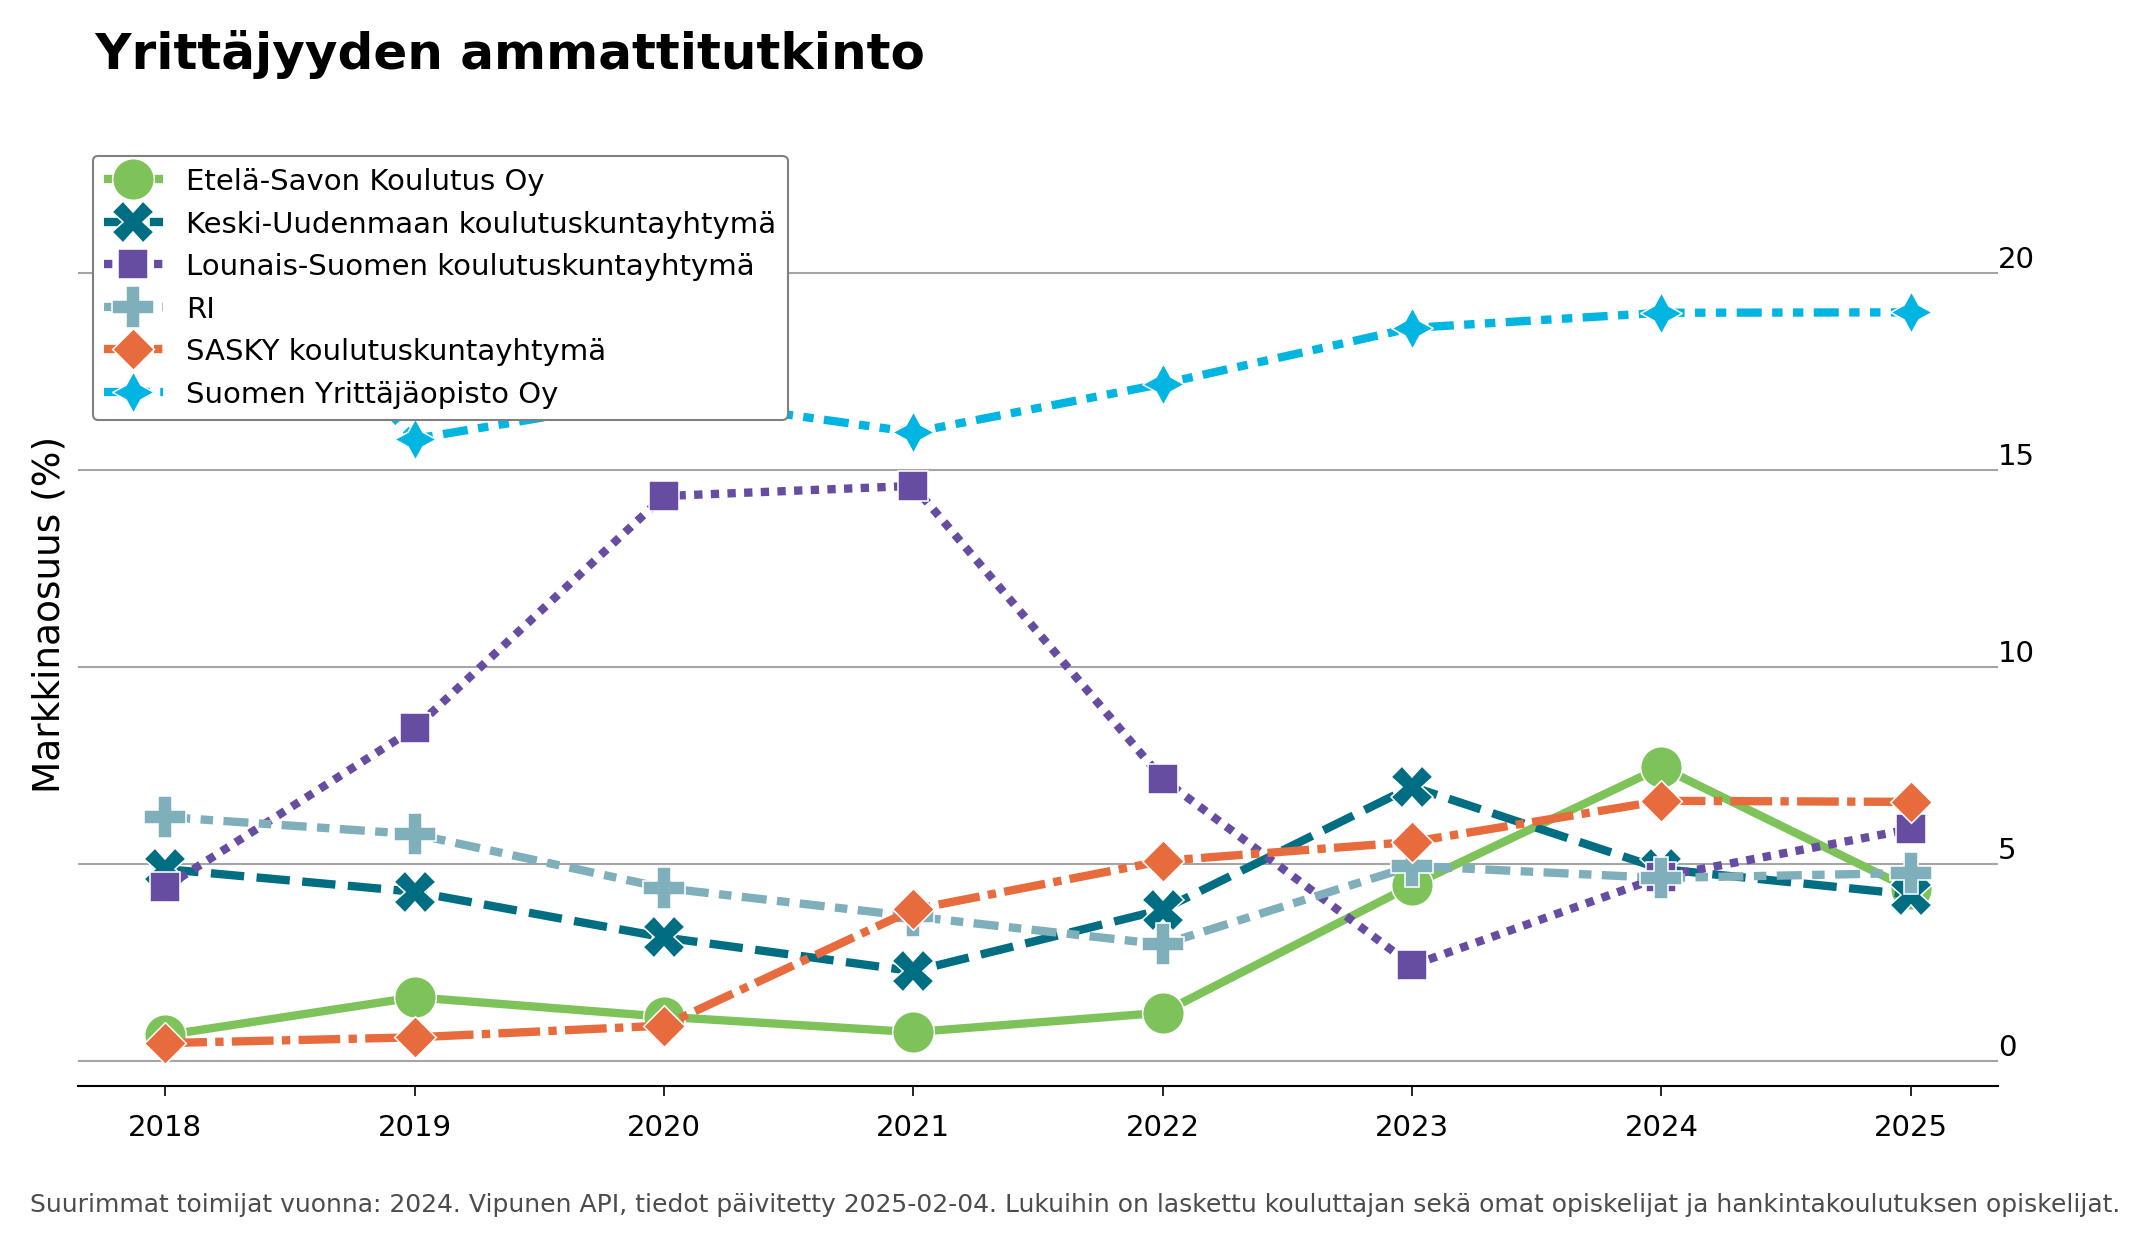

In [229]:
plt.style.use('../data/styles/ri_right_edge_plot_style.mplstyle')

# get top kouluttajat for each qualification

suuruusjarjestys_vuonna = 2024
kilpailijoiden_maara = 6

###########################################

suurimmat_kouluttajat = hae_tutkinnon_suurimmat_toimijat(
    toimijoiden_markkinaosuudet_kasvu,
    year=suuruusjarjestys_vuonna,
    top_n=kilpailijoiden_maara)

source=f"Suurimmat toimijat vuonna: {suuruusjarjestys_vuonna}. Vipunen API, tiedot päivitetty {vipunen_haku_pvm}. Lukuihin on laskettu kouluttajan sekä omat opiskelijat ja hankintakoulutuksen opiskelijat."

# iterate through the qualifications and plot the market share for each qualification
for tutkinto, kouluttajat in suurimmat_kouluttajat.items():
    filtered_df = toimijoiden_markkinaosuudet_kasvu.query("tutkinto == @tutkinto and kouluttaja in @kouluttajat")
    # title_prefix='Markkinaosuus tutkinnossa: ',
    fig_tuple, fig = plot_market_share_by_qualification(filtered_df, tutkinto, x_label=" ", source=source,  x_fontsize=18, y_fontsize=18, title_fontsize=24)

    # Close the figure without the title
    plt.close(fig_tuple[0])

    # Append the figure with the title to your list
    visualizations_for_export.append(fig_tuple)

    # Display the figure with the title in the notebook
    plt.show(fig)

# Reset to default style
reset_plot_style()


In [230]:
ri_markkinaosuus_tutkinnoittain = toimijoiden_markkinaosuudet_kasvu[toimijoiden_markkinaosuudet_kasvu['kouluttaja'].isin(ri_institutions_list)]
ri_markkinaosuus_tutkinnoittain.head()


tilastovuosi                                           tutkinto  \
27           2018                        Isännöinnin ammattitutkinto   
60           2018  Johtamisen ja yritysjohtamisen erikoisammattit...   
142          2018                       Liiketoiminnan perustutkinto   
213          2018                 Lähiesihenkilötyön ammattitutkinto   
248          2018                 Palvelulogistiikan ammattitutkinto   

     nettoopiskelijamaaraLkm_as_jarjestaja  \
27                                    18.3   
60                                     0.5   
142                                  611.3   
213                                  137.2   
248                                    6.1   

     nettoopiskelijamaaraLkm_as_hankinta  nom_tutkinto yhteensa  \
27                                   3.4                  664.9   
60                                   4.1                   22.7   
142                                 40.8                18086.3   
213                                123.9                 2966.7   
248                                  7.1                  120.1   

     koulutuksenJarjestaja_n  hankintakoulutuksenJarjestaja_n  \
27                        43                               18   
60                        23                                7   
142                       68                               35   
213                       66                               25   
248                       26                                6   

     muutos tarjoajien määrässä (%) kouluttaja  nom_kouluttaja yhteensa  \
27                              NaN         RI                     21.8   
60                              NaN         RI                      4.6   
142                             NaN         RI                    652.1   
213                             NaN         RI                    261.1   
248                             NaN         RI                     13.2   

     järjestäjänä-osuus (%)  markkinaosuus tutkinnossa (%)  \
27                     84.3                            3.3   
60                     10.8                           20.1   
142                    93.7                            3.6   
213                    52.5                            8.8   
248                    46.0                           11.0   

     kouluttaja tutkintokasvu (%)  tutkinto markkinakasvu (%)  \
27                            NaN                         0.0   
60                            NaN                         0.0   
142                           NaN                         0.0   
213                           NaN                         0.0   
248                           NaN                         0.0   

     markkinaosuus tutkinnossa (%)_YoY  Sijoitus markkinassa  Vuoden nousijat  
27                                 0.0                    10                1  
60                                 0.0                     2                1  
142                                0.0                     9                1  
213                                0.0                     1                1  
248                                0.0                     2                1

In [231]:
### korjaa tästä eteenpäin
ri_markkinaosuus_tutkinnoittain = ri_markkinaosuus_tutkinnoittain[[
       'tilastovuosi', 'tutkinto','kouluttaja', 
       'nom_tutkinto yhteensa','nom_kouluttaja yhteensa', 
       'markkinaosuus tutkinnossa (%)','markkinaosuus tutkinnossa (%)_YoY',
       'kouluttaja tutkintokasvu (%)', 'tutkinto markkinakasvu (%)', 'Sijoitus markkinassa']]

In [232]:
ri_markkinaosuus_tutkinnoittain

tilastovuosi                                           tutkinto  \
27            2018                        Isännöinnin ammattitutkinto   
60            2018  Johtamisen ja yritysjohtamisen erikoisammattit...   
142           2018                       Liiketoiminnan perustutkinto   
213           2018                 Lähiesihenkilötyön ammattitutkinto   
248           2018                 Palvelulogistiikan ammattitutkinto   
...            ...                                                ...   
4302          2025    Tuotannon esihenkilötyön erikoisammattitutkinto   
4339          2025            Tuotekehitystyön erikoisammattitutkinto   
4373          2025                   Turvallisuusalan ammattitutkinto   
4398          2025            Turvallisuusalan erikoisammattitutkinto   
4436          2025                       Yrittäjyyden ammattitutkinto   

     kouluttaja  nom_tutkinto yhteensa  nom_kouluttaja yhteensa  \
27           RI                  664.9                     21.8   
60           RI                   22.7                      4.6   
142          RI                18086.3                    652.1   
213          RI                 2966.7                    261.1   
248          RI                  120.1                     13.2   
...         ...                    ...                      ...   
4302         RI                  452.0                    216.9   
4339         RI                 1733.9                    212.5   
4373         RI                  385.4                     16.0   
4398         RI                  374.4                     80.0   
4436         RI                 1445.2                     68.9   

      markkinaosuus tutkinnossa (%)  markkinaosuus tutkinnossa (%)_YoY  \
27                              3.3                                0.0   
60                             20.1                                0.0   
142                             3.6                                0.0   
213                             8.8                                0.0   
248                            11.0                                0.0   
...                             ...                                ...   
4302                           48.0                                5.7   
4339                           12.3                               -0.8   
4373                            4.2                               -0.3   
4398                           21.4                                8.4   
4436                            4.8                                0.1   

      kouluttaja tutkintokasvu (%)  tutkinto markkinakasvu (%)  \
27                             NaN                         0.0   
60                             NaN                         0.0   
142                            NaN                         0.0   
213                            NaN                         0.0   
248                            NaN                         0.0   
...                            ...                         ...   
4302                          -9.6                         0.0   
4339                         -15.1                         0.0   
4373                         -18.4                         0.0   
4398                          43.0                         0.0   
4436                          -8.6                         0.0   

      Sijoitus markkinassa  
27                      10  
60                       2  
142                      9  
213                      1  
248                      2  
...                    ...  
4302                     1  
4339                     2  
4373                     9  
4398                     1  
4436                     4  

[108 rows x 10 columns]

##### Heatmap

In [233]:
# asetukset yksittäisen kouluttajan markkinaheatmapille
yhden_kouluttajan_markkina = toimijoiden_markkinaosuudet_kasvu[toimijoiden_markkinaosuudet_kasvu['kouluttaja'].isin(ri_institutions_list)]
kouluttajan_nimi = ri_institutions_list[0]

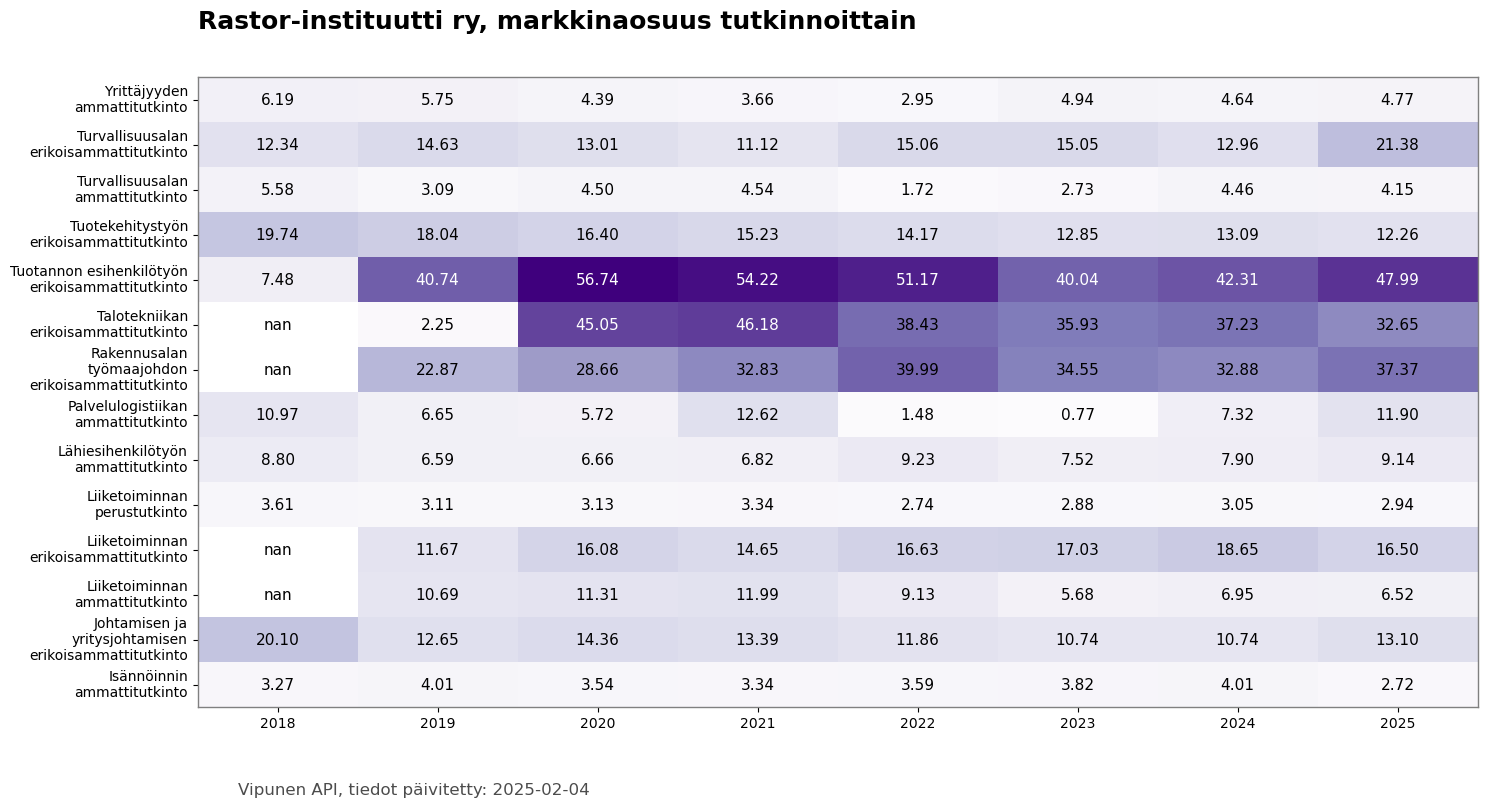

In [234]:
yhden_kouluttajan_markkina = toimijoiden_markkinaosuudet_kasvu[toimijoiden_markkinaosuudet_kasvu['kouluttaja'].isin(ri_institutions_list)]
# ri_markkinaosuus_tutkinnoittain.head()


reset_plot_style()
kouluttajan_nimi = ri_institutions_list[0]
# earliest_date_formatted, latest_date_formatted = get_time_window(interest_df)
title = f"{kouluttajan_nimi}, markkinaosuus tutkinnoittain"
# subtitle = f"Ajanjakso: {earliest_date_formatted}-{latest_date_formatted}"
subtitle=""
source = f"Vipunen API, tiedot päivitetty: {vipunen_haku_pvm}"
index_var="tutkinto"
columns_var="tilastovuosi"
values_var="markkinaosuus tutkinnossa (%)"

fig_tuple, fig = plot_generalized_heatmap(
    df=yhden_kouluttajan_markkina,
    index_var=index_var,
    columns_var=columns_var,
    values_var=values_var,
    title=title,
    subtitle=subtitle,
    source=source,
    y_label_wrap_length=25,
    x_label_fontsize=12,
    y_label_fontsize=12,
    title_fontsize=18,
    title_fontweight='bold'
)

# For later use. Normalize the values column and create a pivot table for the heatmap
# normalized_df = normalize_column_to_range(categoryGrouping.copy(), values_var, 5)
# heatmap_pivot = make_heatmap_pivot(ri_markkinaosuus_tutkinnoittain, index=index_var, columns=columns_var, values=values_var)

# Close the figure without the title
plt.close(fig_tuple[0])

# Append the figure with the title to your list
visualizations_for_export.append(fig_tuple)

# Display the figure with the title in the notebook
plt.show()

# Reset to default style
reset_plot_style()

        vipusesta ok:
                Liiketoiminnan perustutkinto
                Lähiesimiestyön ammattitutkinto
                Johtamisen ja yritysjohtamisen erikoisammattitutkinto
                Liiketoiminnan ammattitutkinto
                Tuotekehitystyön erikoisammattitutkinto
                Yrittäjän ammattitutkinto
                Yritysneuvojan erikoisammattitutkinto
                Yrittäjyyden ammattitutkinto
                Isännöinnin ammattitutkinto

##### heatmap with marginals

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/1959763962.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


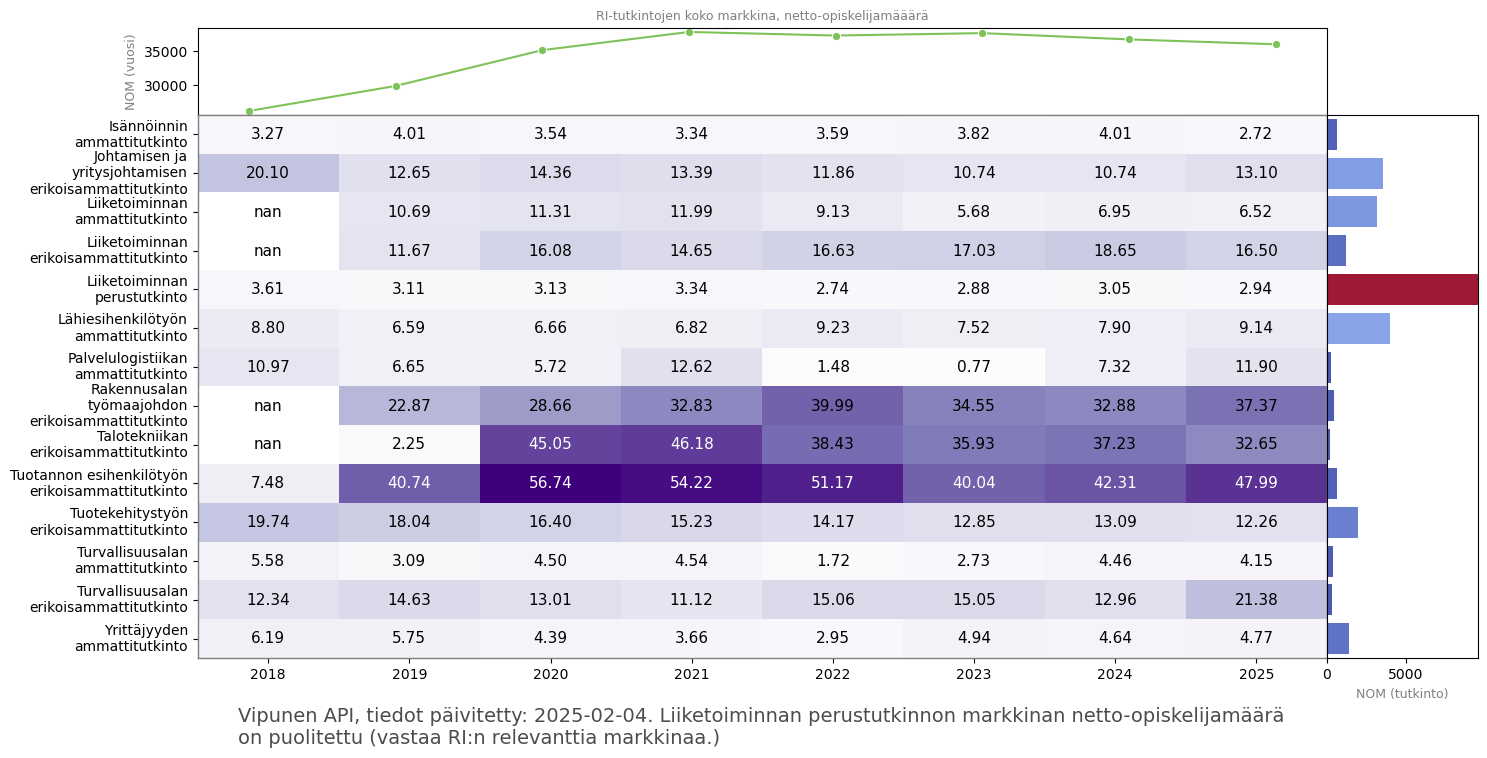

In [235]:
# asetukset yksittäisen kouluttajan markkinaheatmapille
yhden_kouluttajan_markkina 
kouluttajan_nimi
# excluded_qualifications=['Liiketoiminnan perustutkinto','Lähiesimiestyön ammattitutkinto']
excluded_qualifications=[]
# earliest_date_formatted, latest_date_formatted = get_time_window(interest_df)
title = f"{kouluttajan_nimi}, markkinaosuus tutkinnoittain"

source = f"Vipunen API, tiedot päivitetty: {vipunen_haku_pvm}. Liiketoiminnan perustutkinnon markkinan netto-opiskelijamäärä \non puolitettu (vastaa RI:n relevanttia markkinaa.)"

# title=""

# title = "Kuukausittainen kiinnostus tarjooma kohtaan"
subtitle = ""

# subtitle = f"Ajanjakso: {earliest_date_formatted}-{latest_date_formatted}"
if(len(excluded_qualifications)>0):
    source = f"ei mukana: {', '.join(excluded_qualifications)} "+source
else:
    source = source
# print excluded qualifications as one string

fig_tuple, fig = plot_heatmap_with_marginals(
    df=yhden_kouluttajan_markkina,
    index_var="tutkinto",
    columns_var="tilastovuosi",
    values_var="markkinaosuus tutkinnossa (%)",
    marginal_var="nom_tutkinto yhteensa",
    excluded_qualifications=excluded_qualifications,
    # top_marginal_title="",
    top_marginal_title='RI-tutkintojen koko markkina, netto-opiskelijamääärä',
    title=title,
    subtitle=subtitle,
    source=source,
    xlabel=" ",
    ylabel="",
    y_fontsize=10,
    y_label_wrap_length=25
)

# heatmap_pivot = ri_markkinaosuus_tutkinnoittain.pivot(index='tutkinto', columns='tilastovuosi', values='RI_markkinaosuus (%)')

# Close the figure without the title
plt.close(fig_tuple[0])

# Append the figure with the title to your list
visualizations_for_export.append(fig_tuple)

# Display the figure with the title in the notebook
plt.show()

# Reset to default style
reset_plot_style()


In [236]:
# # show the unique numbers in 'nom_tutkinto yhteensa' column and sort them in descending order
# toimijoiden_markkinaosuudet_kasvu['nom_tutkinto yhteensa'].unique().sort_values(ascending=False)
# import pandas as pd

# Get the unique numbers in 'nom_tutkinto yhteensa' column and sort them in descending order
unique_values = pd.Series(toimijoiden_markkinaosuudet_kasvu.query('tilastovuosi == 2022')['nom_tutkinto yhteensa'].unique())
sorted_values = unique_values.sort_values(ascending=False)

# print(sorted_values)

In [237]:
toimijoiden_markkinaosuudet.query("tutkinto == 'Yritysneuvojan erikoisammattitutkinto' and tilastovuosi == 2023").sort_values(by='markkinaosuus tutkinnossa (%)', ascending=False)

Empty DataFrame
Columns: [tilastovuosi, tutkinto, nettoopiskelijamaaraLkm_as_jarjestaja, nettoopiskelijamaaraLkm_as_hankinta, nom_tutkinto yhteensa, koulutuksenJarjestaja_n, hankintakoulutuksenJarjestaja_n, muutos tarjoajien määrässä (%), kouluttaja, nom_kouluttaja yhteensa, järjestäjänä-osuus (%), markkinaosuus tutkinnossa (%)]
Index: []

#### Nousijat ja laskijat

In [238]:
toimijoiden_markkinaosuudet_kasvu

tilastovuosi                      tutkinto  \
0             2018   Isännöinnin ammattitutkinto   
1             2018   Isännöinnin ammattitutkinto   
2             2018   Isännöinnin ammattitutkinto   
3             2018   Isännöinnin ammattitutkinto   
4             2018   Isännöinnin ammattitutkinto   
...            ...                           ...   
4452          2025  Yrittäjyyden ammattitutkinto   
4453          2025  Yrittäjyyden ammattitutkinto   
4454          2025  Yrittäjyyden ammattitutkinto   
4455          2025  Yrittäjyyden ammattitutkinto   
4456          2025  Yrittäjyyden ammattitutkinto   

      nettoopiskelijamaaraLkm_as_jarjestaja  \
0                                      13.1   
1                                      71.1   
2                                      11.2   
3                                       1.2   
4                                       0.5   
...                                     ...   
4452                                   25.5   
4453                                    3.1   
4454                                   14.6   
4455                                   20.2   
4456                                   57.8   

      nettoopiskelijamaaraLkm_as_hankinta  nom_tutkinto yhteensa  \
0                                     0.0                  664.9   
1                                     0.4                  664.9   
2                                     0.3                  664.9   
3                                     0.0                  664.9   
4                                     0.0                  664.9   
...                                   ...                    ...   
4452                                  0.0                 1445.2   
4453                                  0.0                 1445.2   
4454                                  0.0                 1445.2   
4455                                  0.0                 1445.2   
4456                                  0.0                 1445.2   

      koulutuksenJarjestaja_n  hankintakoulutuksenJarjestaja_n  \
0                          43                               18   
1                          43                               18   
2                          43                               18   
3                          43                               18   
4                          43                               18   
...                       ...                              ...   
4452                       51                                5   
4453                       51                                5   
4454                       51                                5   
4455                       51                                5   
4456                       51                                5   

      muutos tarjoajien määrässä (%)  \
0                                NaN   
1                                NaN   
2                                NaN   
3                                NaN   
4                                NaN   
...                              ...   
4452                            -5.6   
4453                            -5.6   
4454                            -5.6   
4455                            -5.6   
4456                            -5.6   

                                           kouluttaja  \
0                                       AEL-Amiedu Oy   
1                                       Ami-säätiö sr   
2                                         Careeria Oy   
3             Espoon seudun koulutuskuntayhtymä Omnia   
4                  Etelä-Karjalan Koulutuskuntayhtymä   
...                                               ...   
4452                                  Vaasan kaupunki   
4453          Valkeakosken seudun koulutuskuntayhtymä   
4454                                 Vantaan kaupunki   
4455                    Ylä-Savon koulutuskuntayhtymä   
4456  Äänekosken Ammatillisen Koulutuksen kuntayhtymä   

      nom_kouluttaja yhteensa  järjestäj

In [239]:
df.query("tutkinto.str.contains('Liiketoiminnan perustutkinto')")

tilastovuosi                      tutkinto  \
35             2018  Liiketoiminnan perustutkinto   
107            2018  Liiketoiminnan perustutkinto   
188            2018  Liiketoiminnan perustutkinto   
249            2018  Liiketoiminnan perustutkinto   
302            2018  Liiketoiminnan perustutkinto   
...             ...                           ...   
60499          2025  Liiketoiminnan perustutkinto   
60500          2025  Liiketoiminnan perustutkinto   
60586          2025  Liiketoiminnan perustutkinto   
60587          2025  Liiketoiminnan perustutkinto   
60623          2025  Liiketoiminnan perustutkinto   

                                 koulutuksenJarjestaja  \
35                                       AEL-Amiedu Oy   
107                                      AEL-Amiedu Oy   
188                                      Ami-säätiö sr   
249                                      Ami-säätiö sr   
302              Ammattienedistämislaitossäätiö AEL sr   
...                                                ...   
60499                    Ylä-Savon koulutuskuntayhtymä   
60500                    Ylä-Savon koulutuskuntayhtymä   
60586  Äänekosken Ammatillisen Koulutuksen kuntayhtymä   
60587  Äänekosken Ammatillisen Koulutuksen kuntayhtymä   
60623  Äänekosken Ammatillisen Koulutuksen kuntayhtymä   

               hankintakoulutuksenJarjestaja  nettoopiskelijamaaraLkm  
35                             Tieto puuttuu                     69.5  
107                            Tieto puuttuu                      9.6  
188                            Tieto puuttuu                    134.7  
249                            Tieto puuttuu                     26.8  
302                            Tieto puuttuu                      7.5  
...                                      ...                      ...  
60499              Savon Koulutuskuntayhtymä                      3.0  
60500               Suomen Yrittäjäopisto Oy                      2.0  
60586  Jyväskylän koulutuskuntayhtymä Gradia                      1.0  
60587                          Tieto puuttuu                     55.9  
60623                          Tieto puuttuu                     19.3  

[1197 rows x 5 columns]

In [240]:
df.query("tutkinto.str.contains('Liiketoiminnan perustutkinto')").groupby("tilastovuosi").nettoopiskelijamaaraLkm.sum()

tilastovuosi
2018   18086.3
2019   17716.2
2020   18012.8
2021   19113.9
2022   19112.4
2023   18862.1
2024   18486.5
2025   18973.8
Name: nettoopiskelijamaaraLkm, dtype: float64

##### tutkinto yoy 2021-2022

In [241]:
tutkintojen_kasvutrendit

tutkinto tilastovuodet  tilastovuosi  \
0    Isännöinnin ammattitutkinto     2018-2019          2019   
1    Isännöinnin ammattitutkinto     2019-2020          2020   
2    Isännöinnin ammattitutkinto     2020-2021          2021   
3    Isännöinnin ammattitutkinto     2021-2022          2022   
4    Isännöinnin ammattitutkinto     2022-2023          2023   
..                           ...           ...           ...   
93  Yrittäjyyden ammattitutkinto     2020-2021          2021   
94  Yrittäjyyden ammattitutkinto     2021-2022          2022   
95  Yrittäjyyden ammattitutkinto     2022-2023          2023   
96  Yrittäjyyden ammattitutkinto     2023-2024          2024   
97  Yrittäjyyden ammattitutkinto     2024-2025          2025   

    tarjoajien kasvu (%) tarjoajien kasvu (%)_trendi  nom kasvu (%)  \
0                  -33.7                    Laskussa            4.2   
1                  -36.0                    Laskussa           -1.0   
2                   14.8                    Kasvussa            2.5   
3                    6.8                    Kasvussa           -6.9   
4                    0.0                    Laskussa           13.6   
..                   ...                         ...            ...   
93                   3.9                    Kasvussa            6.5   
94                   0.0                    Laskussa           -6.2   
95                  -3.7                    Laskussa           14.4   
96                   7.8                    Kasvussa            1.5   
97                 -10.8                    Laskussa          -11.1   

   nom kasvu (%)_trendi  tutkinto_nom_sum  
0              Kasvussa             693.0  
1              Laskussa             686.1  
2              Kasvussa             703.0  
3              Laskussa             654.7  
4              Kasvussa             743.8  
..                  ...               ...  
93             Kasvussa            1491.9  
94             Laskussa            1399.1  
95             Kasvussa            1600.3  
96             Kasvussa            1624.8  
97             Laskussa            1445.2  

[98 rows x 8 columns]

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/1207488861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tutkinto'] = df['tutkinto'].replace(lyhennykset_dict, regex=True)
/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


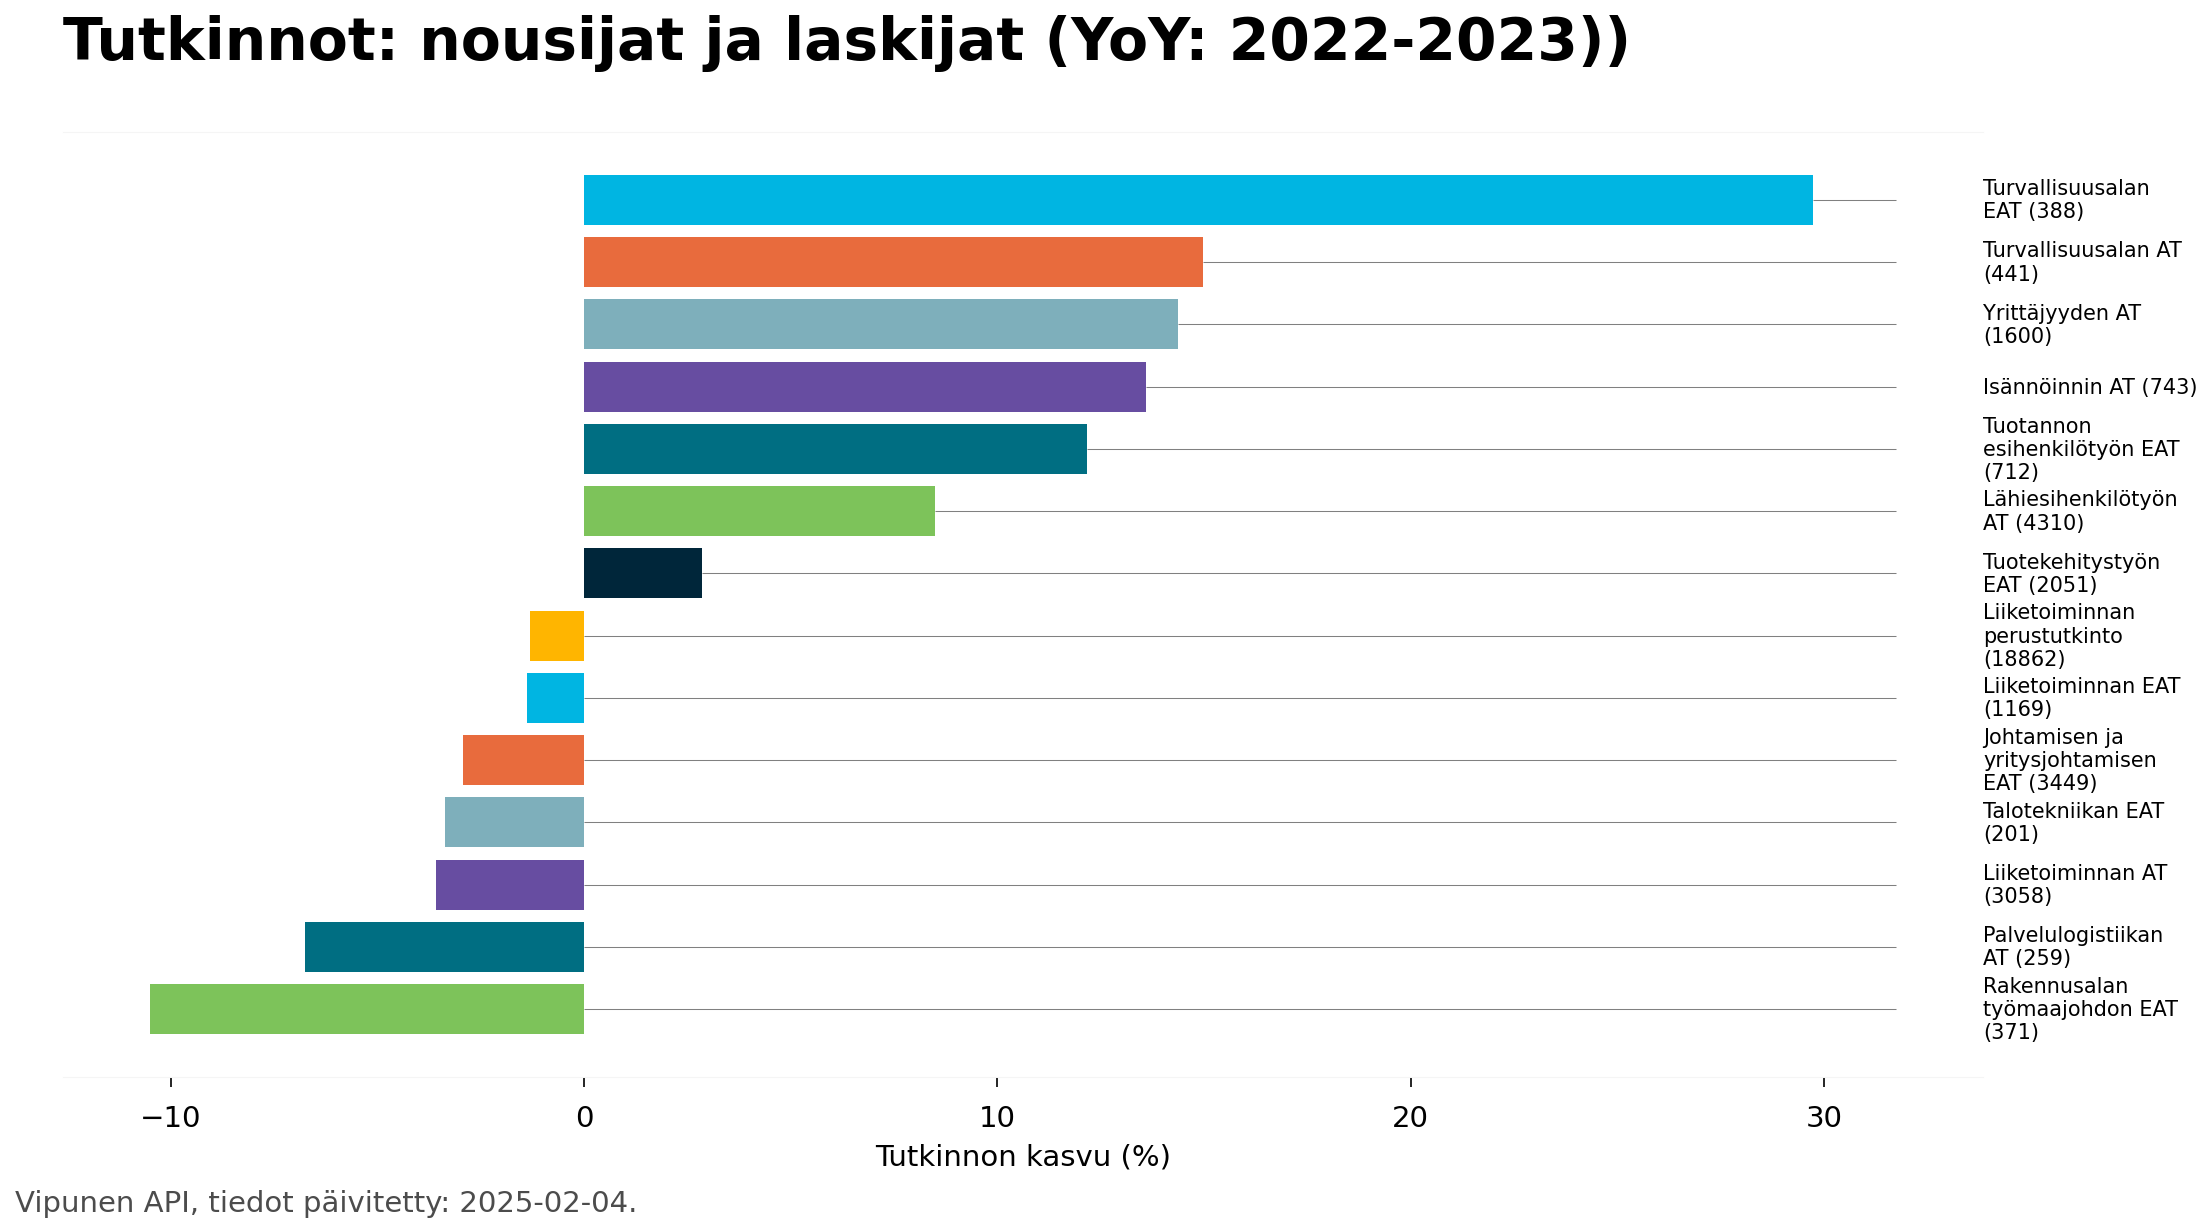

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/1207488861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tutkinto'] = df['tutkinto'].replace(lyhennykset_dict, regex=True)
/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


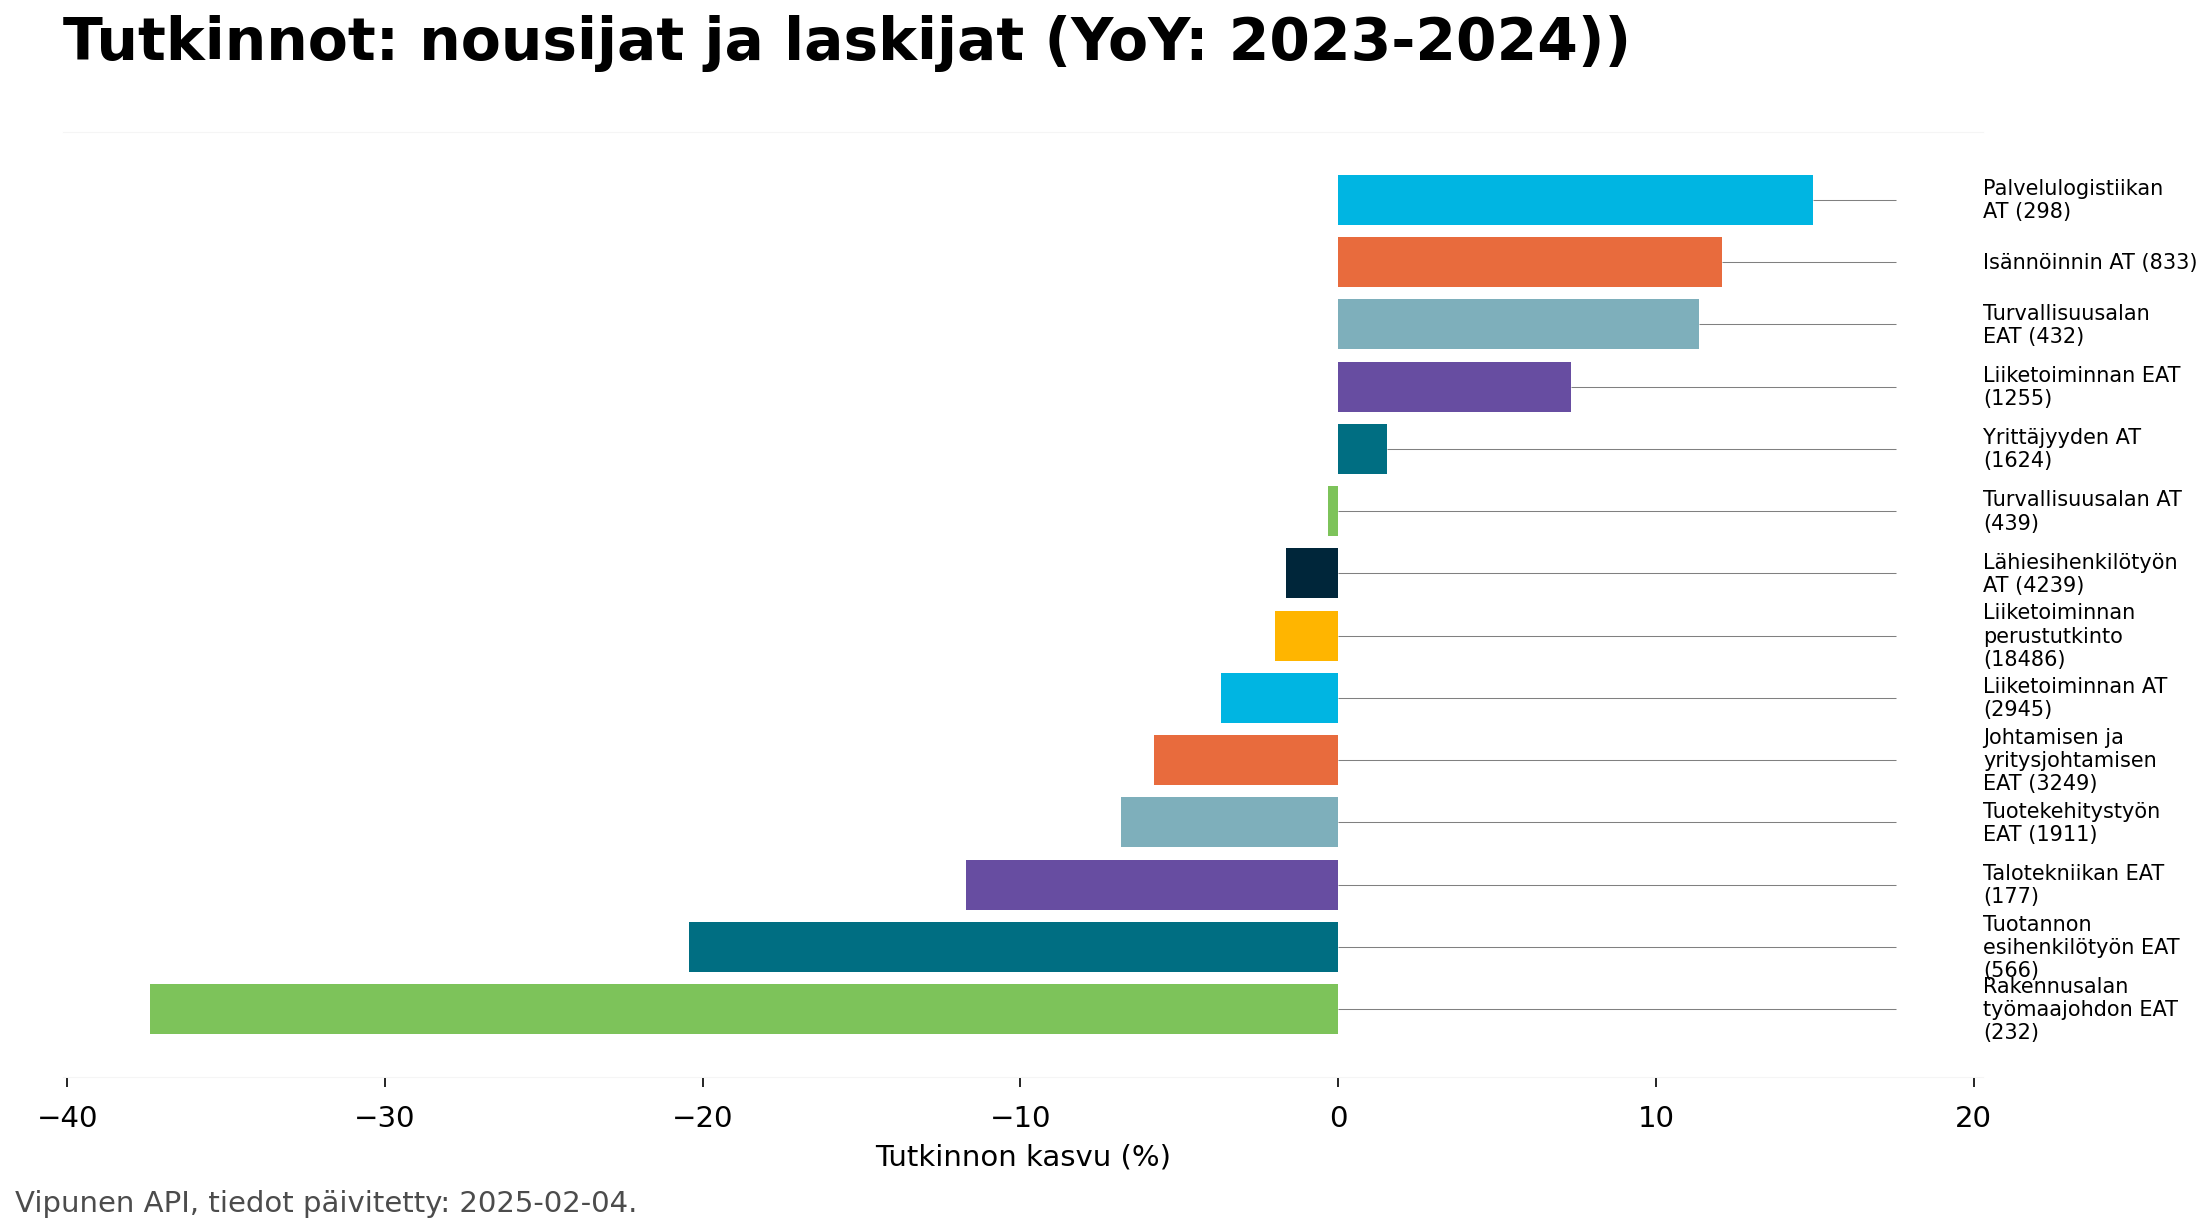

In [242]:
# Using already prepared tutkintojen_kasvutrendit dataframe that includes YoY growth for each qualification

tarkasteltavat_vuodet=['2022-2023','2023-2024']
top_bottom_n = None
source = f"Vipunen API, tiedot päivitetty: {vipunen_haku_pvm}."

for vuosi in tarkasteltavat_vuodet: 
    df_filtered = tutkintojen_kasvutrendit[(tutkintojen_kasvutrendit['tilastovuodet'] == vuosi)]
    df_filtered = shorten_qualification_names(df_filtered)
    
    if check_year(vuosi):
        # extract the year from the string
        this_year = int(vuosi[-4:])
        source = source + f" Vuosi {this_year} on vielä kesken. Suluissa on tutkinnon netto-opiskelijamäärä vuonna {vuosi[-4:]}"

    # Now call your plotting function
    fig_tuple, fig = plot_generic_growth_comparison(
        df=df_filtered,
        filter_conditions={},  # No additional filters needed as we pre-filtered the DataFrame
        growth_column='nom kasvu (%)',
        category_column='tutkinto',
        detail_column='tutkinto_nom_sum',
        title_template=f"Tutkinnot: nousijat ja laskijat (YoY: {vuosi}))",
        limit=top_bottom_n,
        source=source,
        x_label='Tutkinnon kasvu (%)',
        y_label='',
        y_label_fontsize=10,
        y_label_wrap_length=20,
        colors=ri_colors_large_palette
    )

    # Close the figure without the title
    plt.close(fig_tuple[0])

    # Append the figure with the title to your list
    visualizations_for_export.append(fig_tuple)

    # Display the figure with the title in the notebook
    plt.show()

# Reset to default style
reset_plot_style()


In [243]:
tutkintojen_kasvutrendit.head()

tutkinto tilastovuodet  tilastovuosi  \
0  Isännöinnin ammattitutkinto     2018-2019          2019   
1  Isännöinnin ammattitutkinto     2019-2020          2020   
2  Isännöinnin ammattitutkinto     2020-2021          2021   
3  Isännöinnin ammattitutkinto     2021-2022          2022   
4  Isännöinnin ammattitutkinto     2022-2023          2023   

   tarjoajien kasvu (%) tarjoajien kasvu (%)_trendi  nom kasvu (%)  \
0                 -33.7                    Laskussa            4.2   
1                 -36.0                    Laskussa           -1.0   
2                  14.8                    Kasvussa            2.5   
3                   6.8                    Kasvussa           -6.9   
4                   0.0                    Laskussa           13.6   

  nom kasvu (%)_trendi  tutkinto_nom_sum  
0             Kasvussa             693.0  
1             Laskussa             686.1  
2             Kasvussa             703.0  
3             Laskussa             654.7  
4             Kasvussa             743.8

In [244]:
df_filtered.sort_values(by='nom kasvu (%)', ascending=True)

tutkinto tilastovuodet  tilastovuosi  \
54       Rakennusalan työmaajohdon EAT     2023-2024          2024   
68        Tuotannon esihenkilötyön EAT     2023-2024          2024   
61                   Talotekniikan EAT     2023-2024          2024   
75                Tuotekehitystyön EAT     2023-2024          2024   
12  Johtamisen ja yritysjohtamisen EAT     2023-2024          2024   
19                   Liiketoiminnan AT     2023-2024          2024   
33        Liiketoiminnan perustutkinto     2023-2024          2024   
40               Lähiesihenkilötyön AT     2023-2024          2024   
82                 Turvallisuusalan AT     2023-2024          2024   
96                     Yrittäjyyden AT     2023-2024          2024   
26                  Liiketoiminnan EAT     2023-2024          2024   
89                Turvallisuusalan EAT     2023-2024          2024   
5                       Isännöinnin AT     2023-2024          2024   
47               Palvelulogistiikan AT     2023-2024          2024   

    tarjoajien kasvu (%) tarjoajien kasvu (%)_trendi  nom kasvu (%)  \
54                 -15.4                    Laskussa          -37.4   
68                 -10.0                    Laskussa          -20.4   
61                   7.3                    Kasvussa          -11.7   
75                  -9.5                    Laskussa           -6.8   
12                  -3.4                    Laskussa           -5.8   
19                  -3.3                    Laskussa           -3.7   
33                  -4.9                    Laskussa           -2.0   
40                   0.0                    Laskussa           -1.7   
82                  14.8                    Kasvussa           -0.3   
96                   7.8                    Kasvussa            1.5   
26                   4.7                    Kasvussa            7.3   
89                  48.2                    Kasvussa           11.3   
5                  -24.1                    Laskussa           12.1   
47                  48.8                    Kasvussa           14.9   

   nom kasvu (%)_trendi  tutkinto_nom_sum  
54             Laskussa             232.5  
68             Laskussa             566.8  
61             Laskussa             177.6  
75             Laskussa            1911.7  
12             Laskussa            3249.3  
19             Laskussa            2945.6  
33             Laskussa           18486.5  
40             Laskussa            4239.4  
82             Laskussa             439.8  
96             Kasvussa            1624.8  
26             Kasvussa            1255.2  
89             Kasvussa             432.0  
5              Kasvussa             833.6  
47             Kasvussa             298.2

##### nousijat ja laskijat tutkinnoittain 2023

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


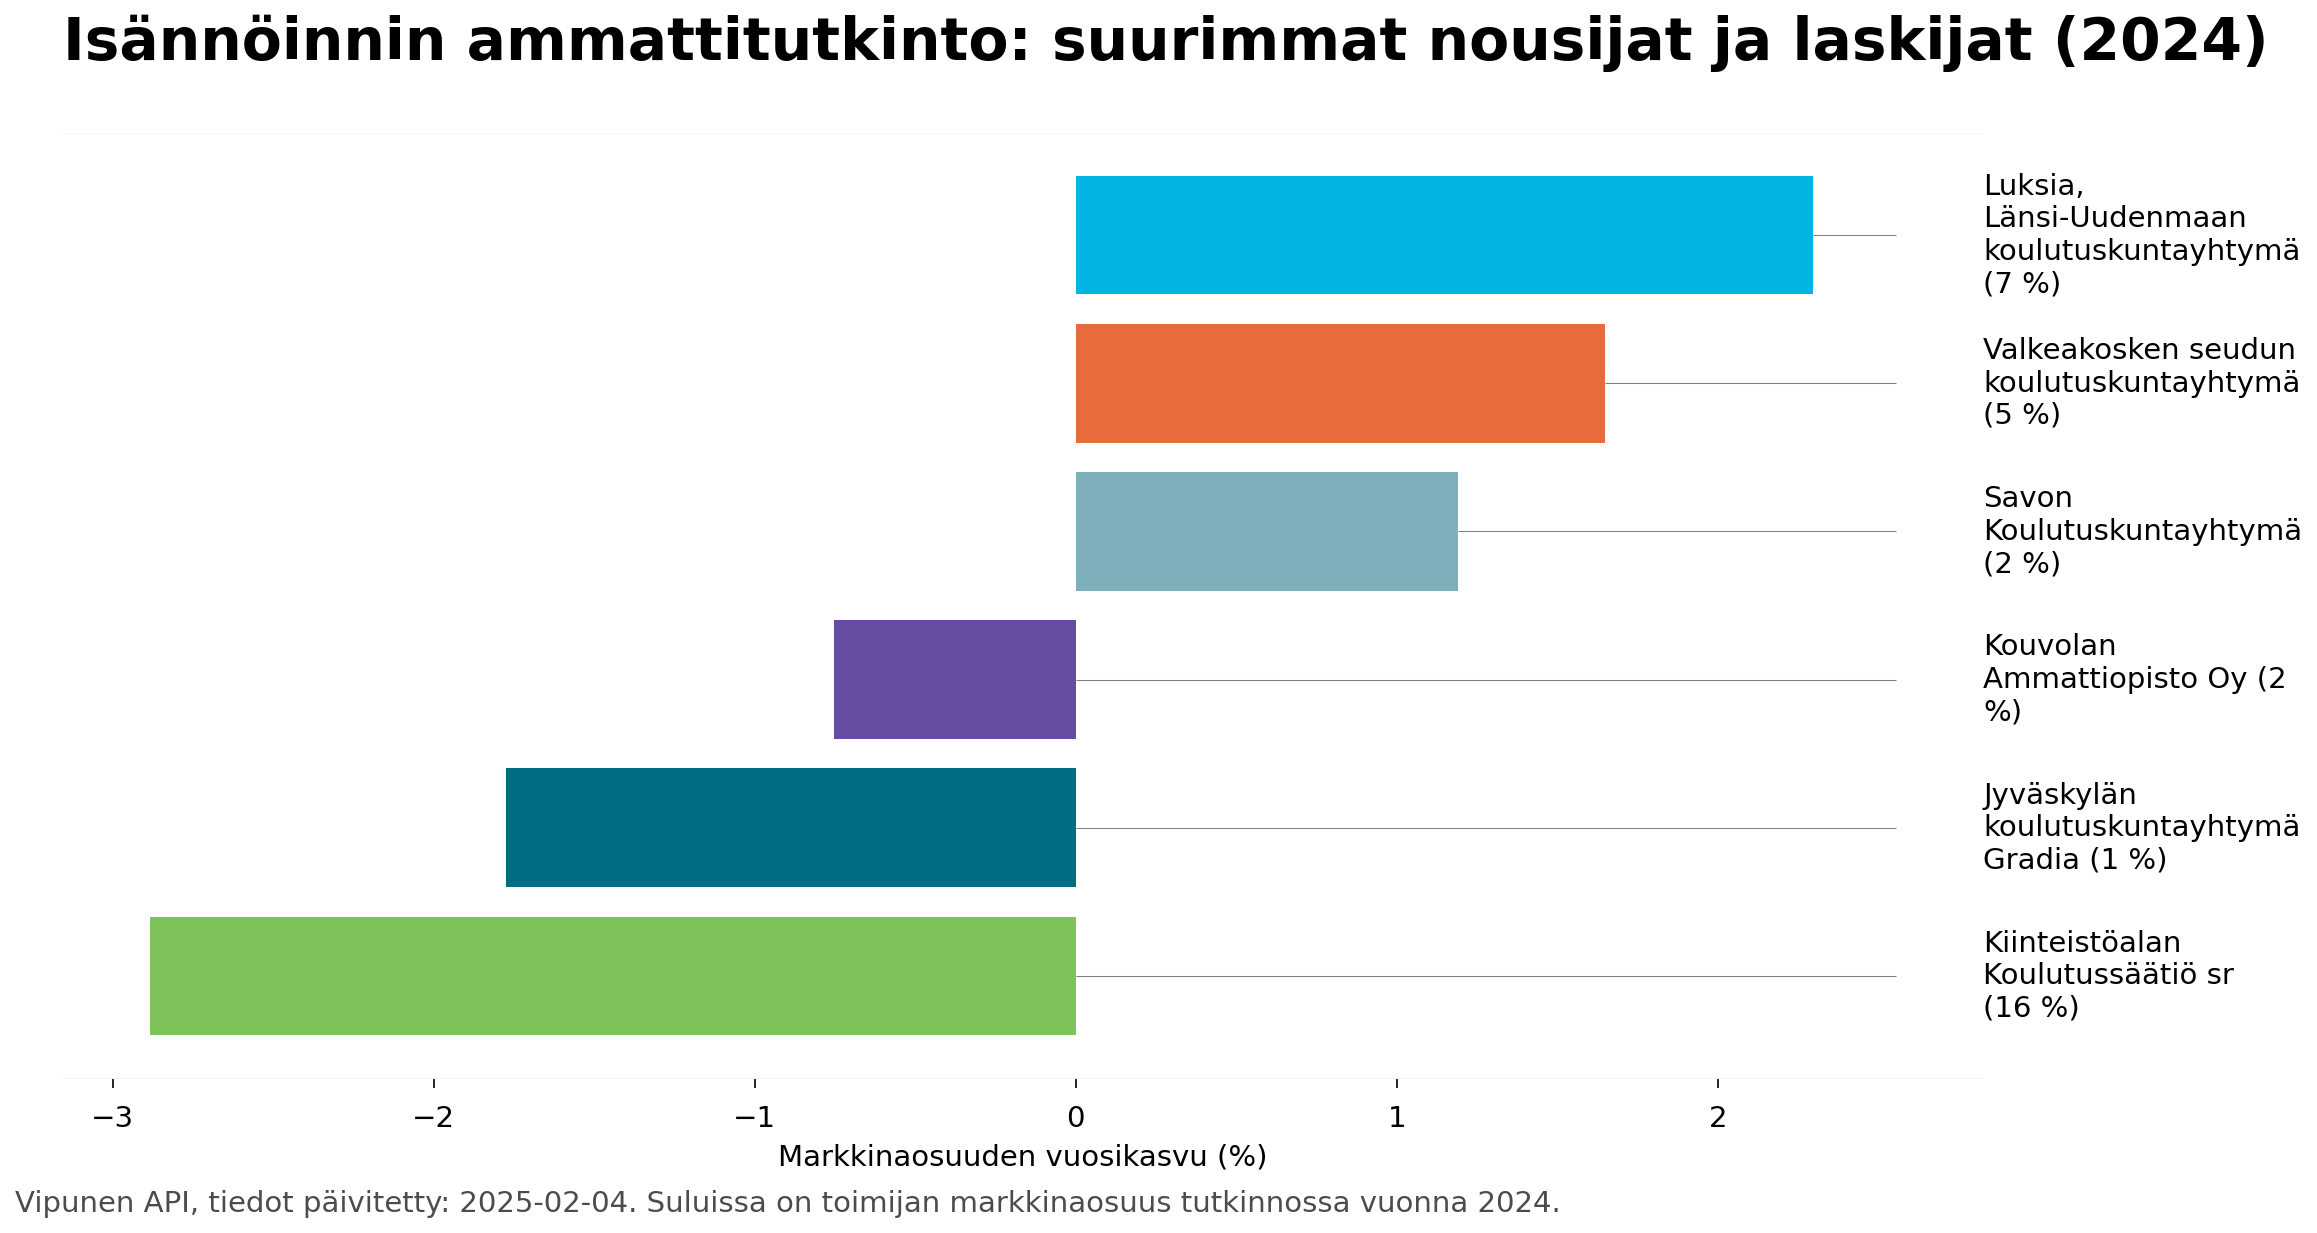

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


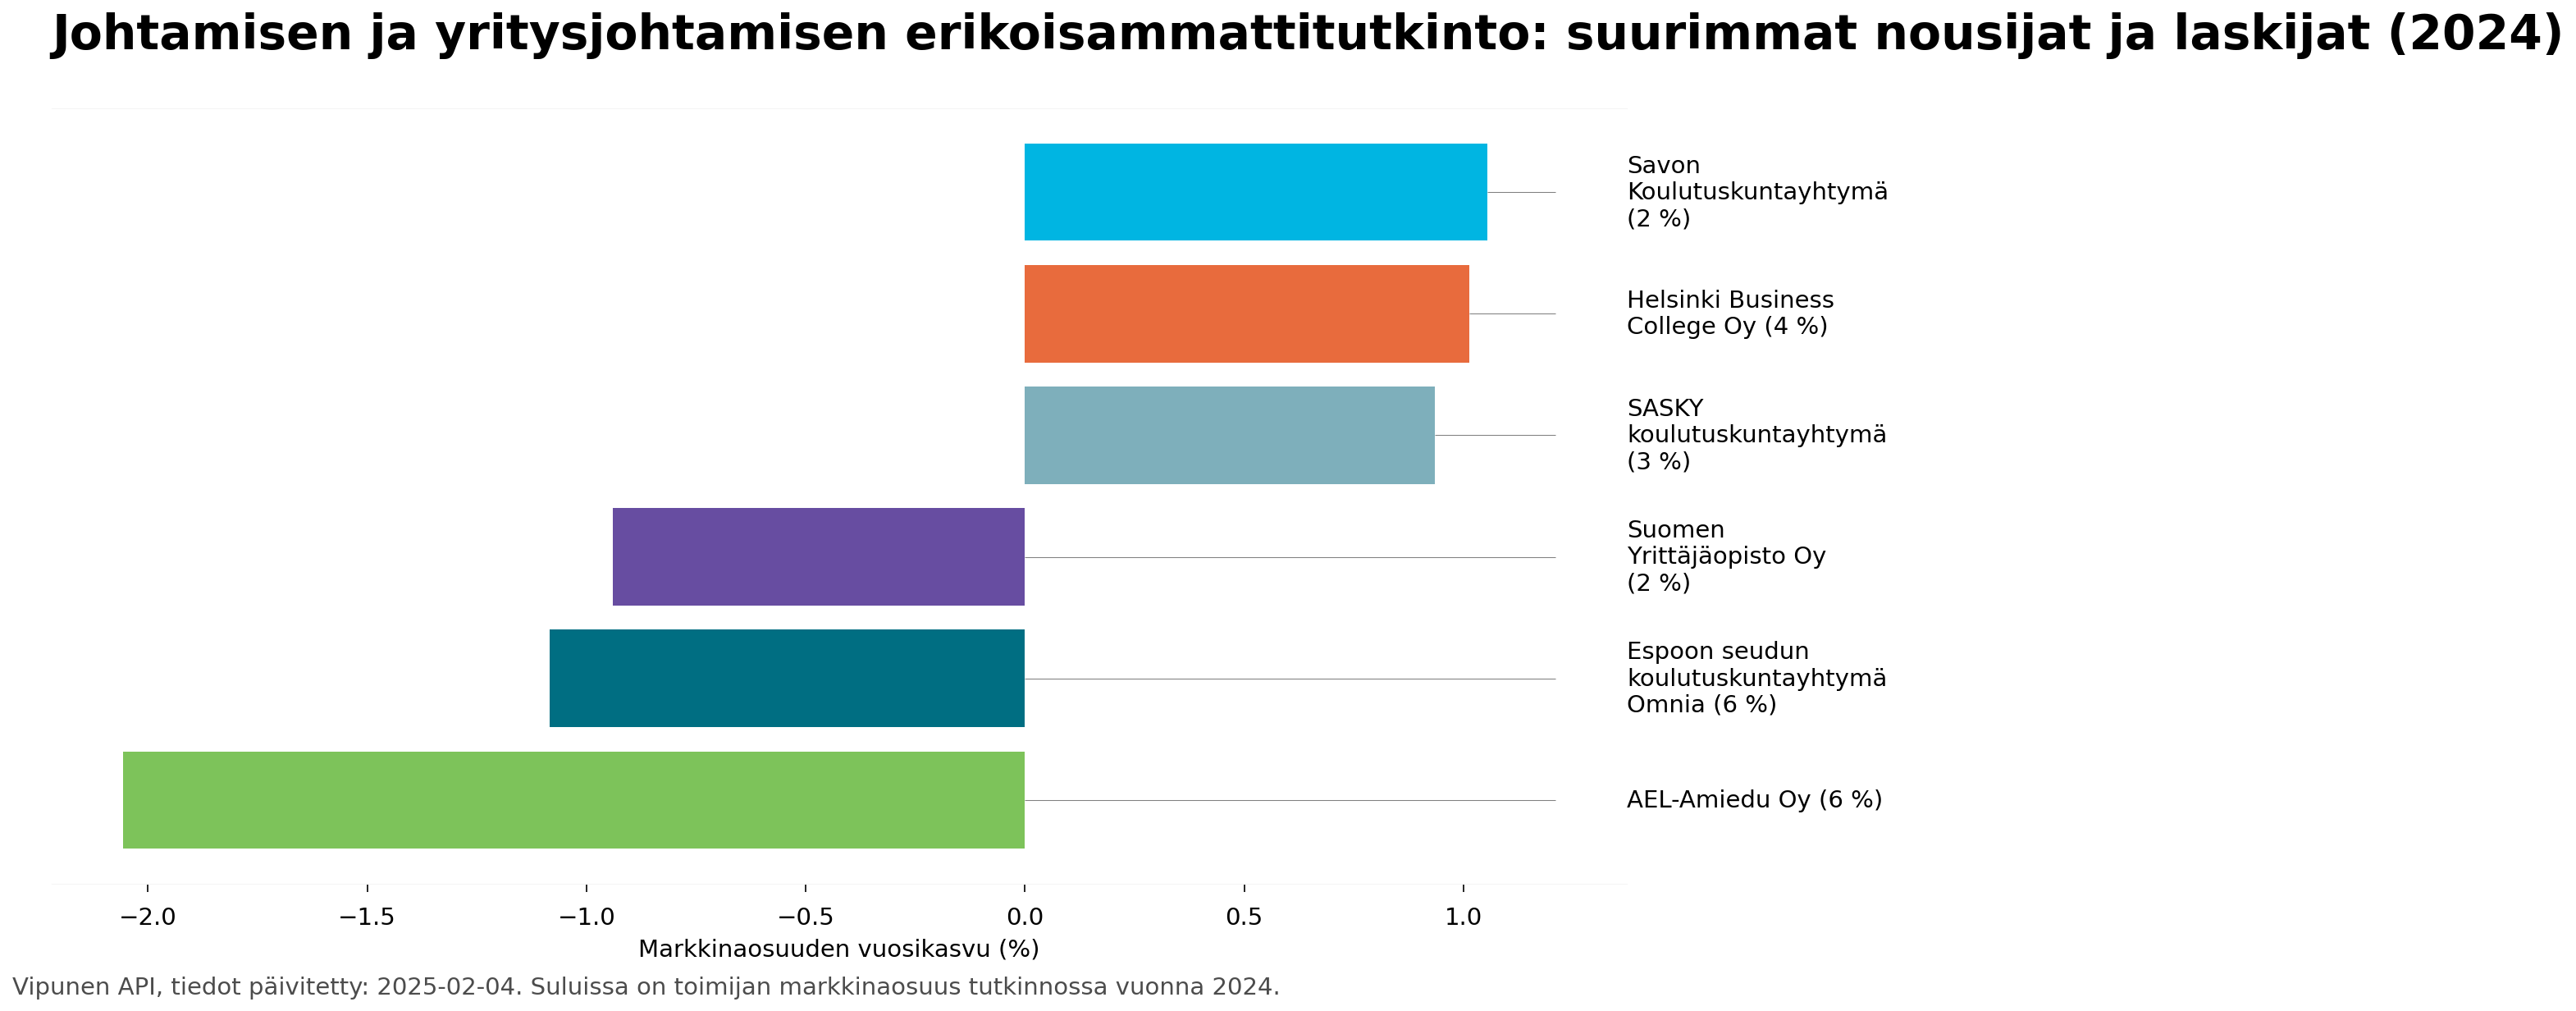

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


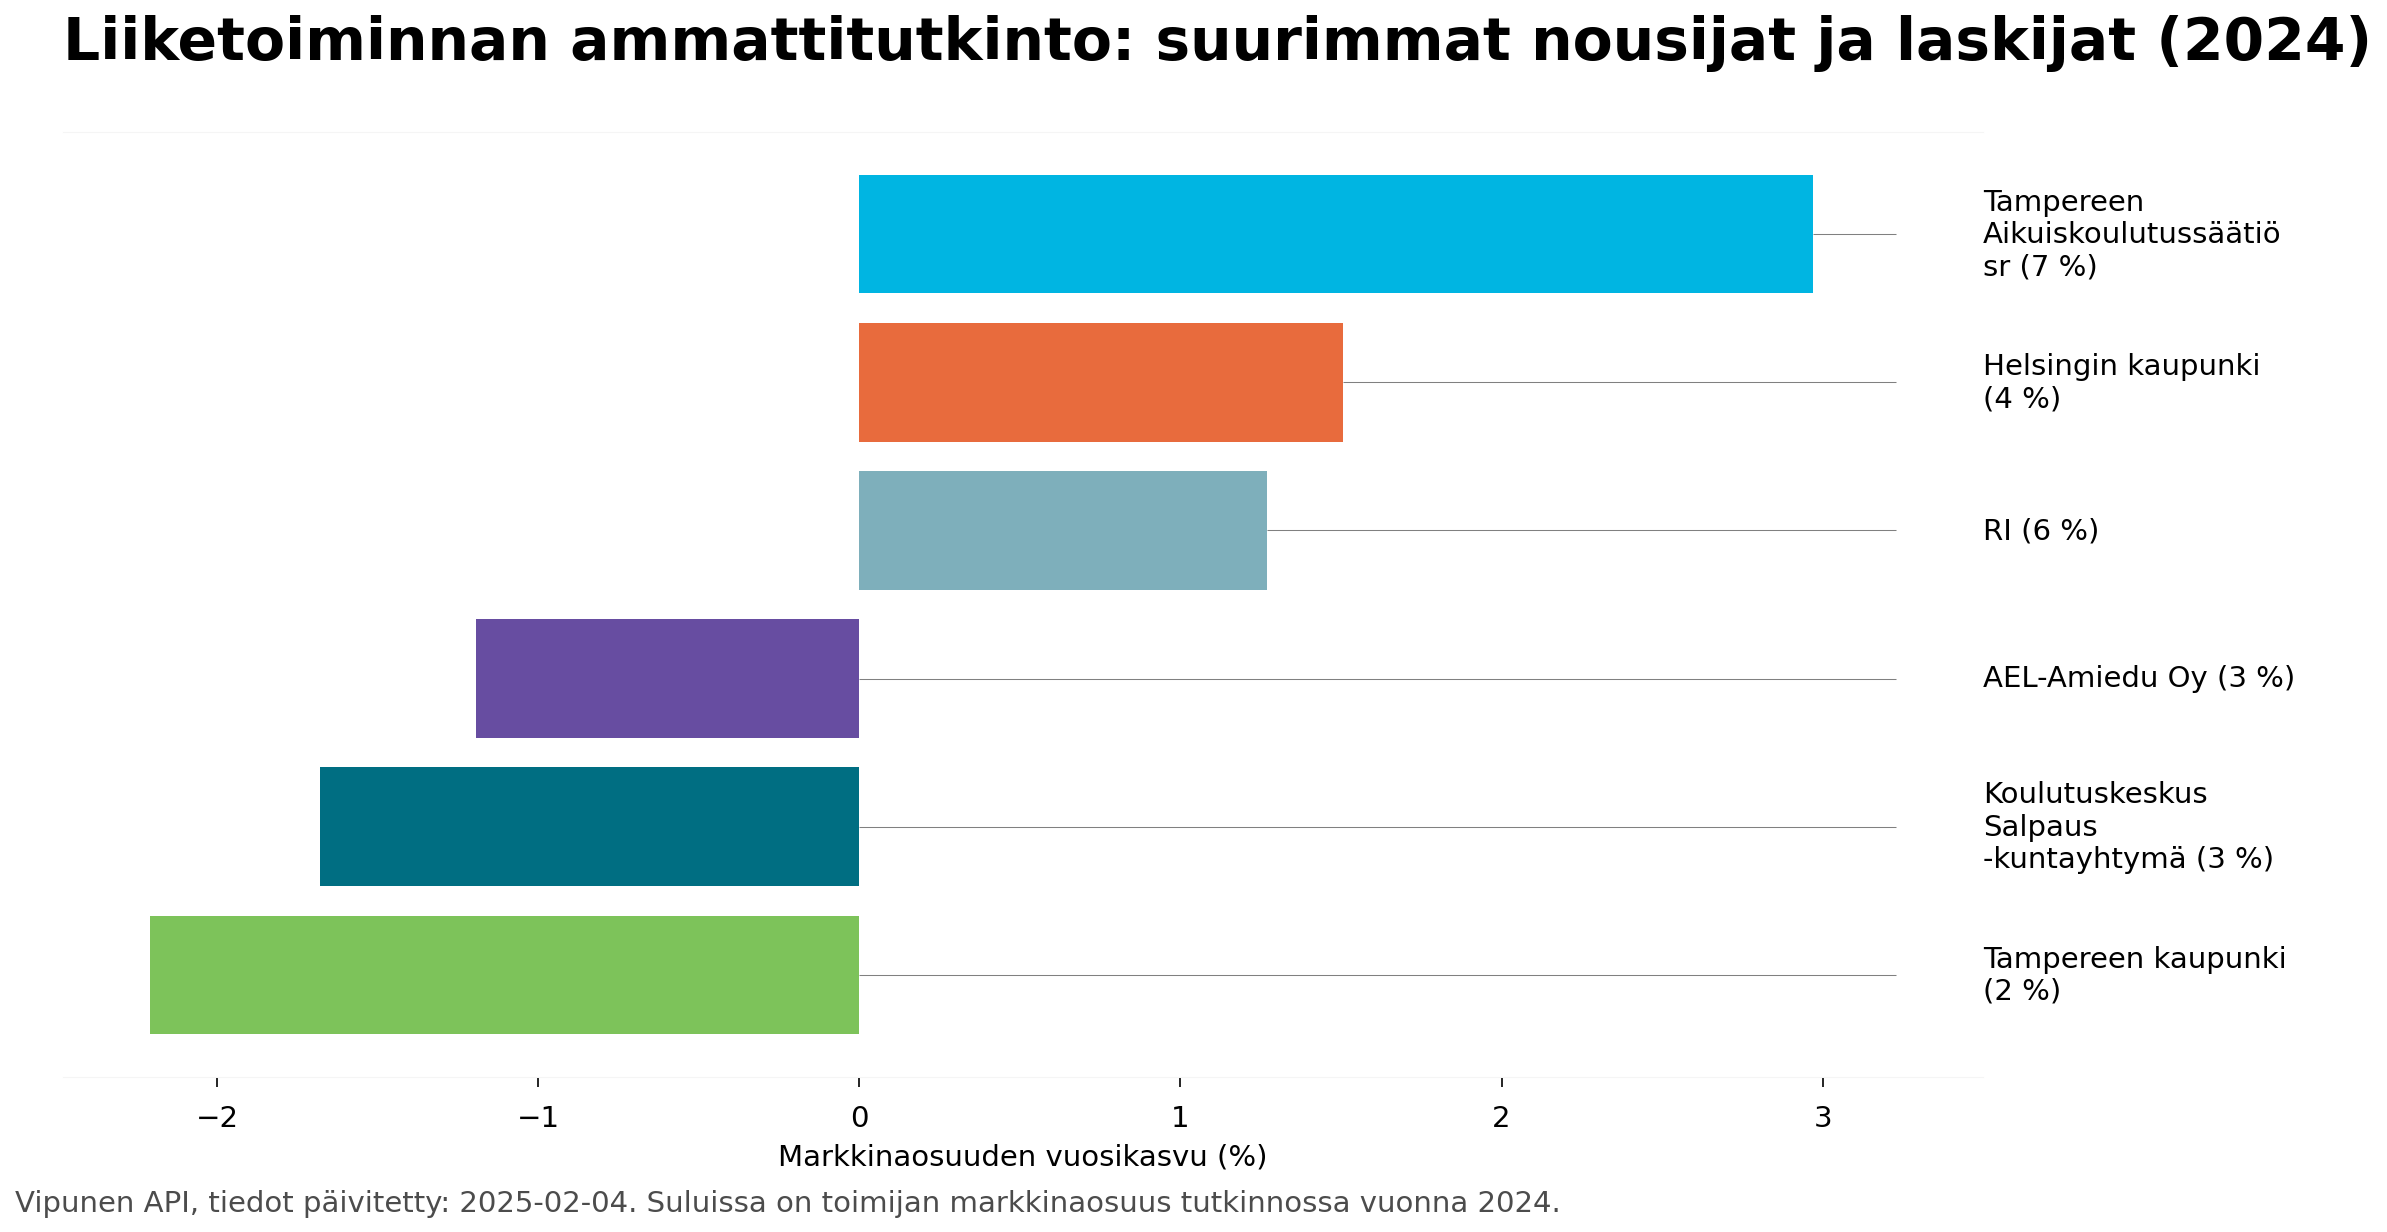

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


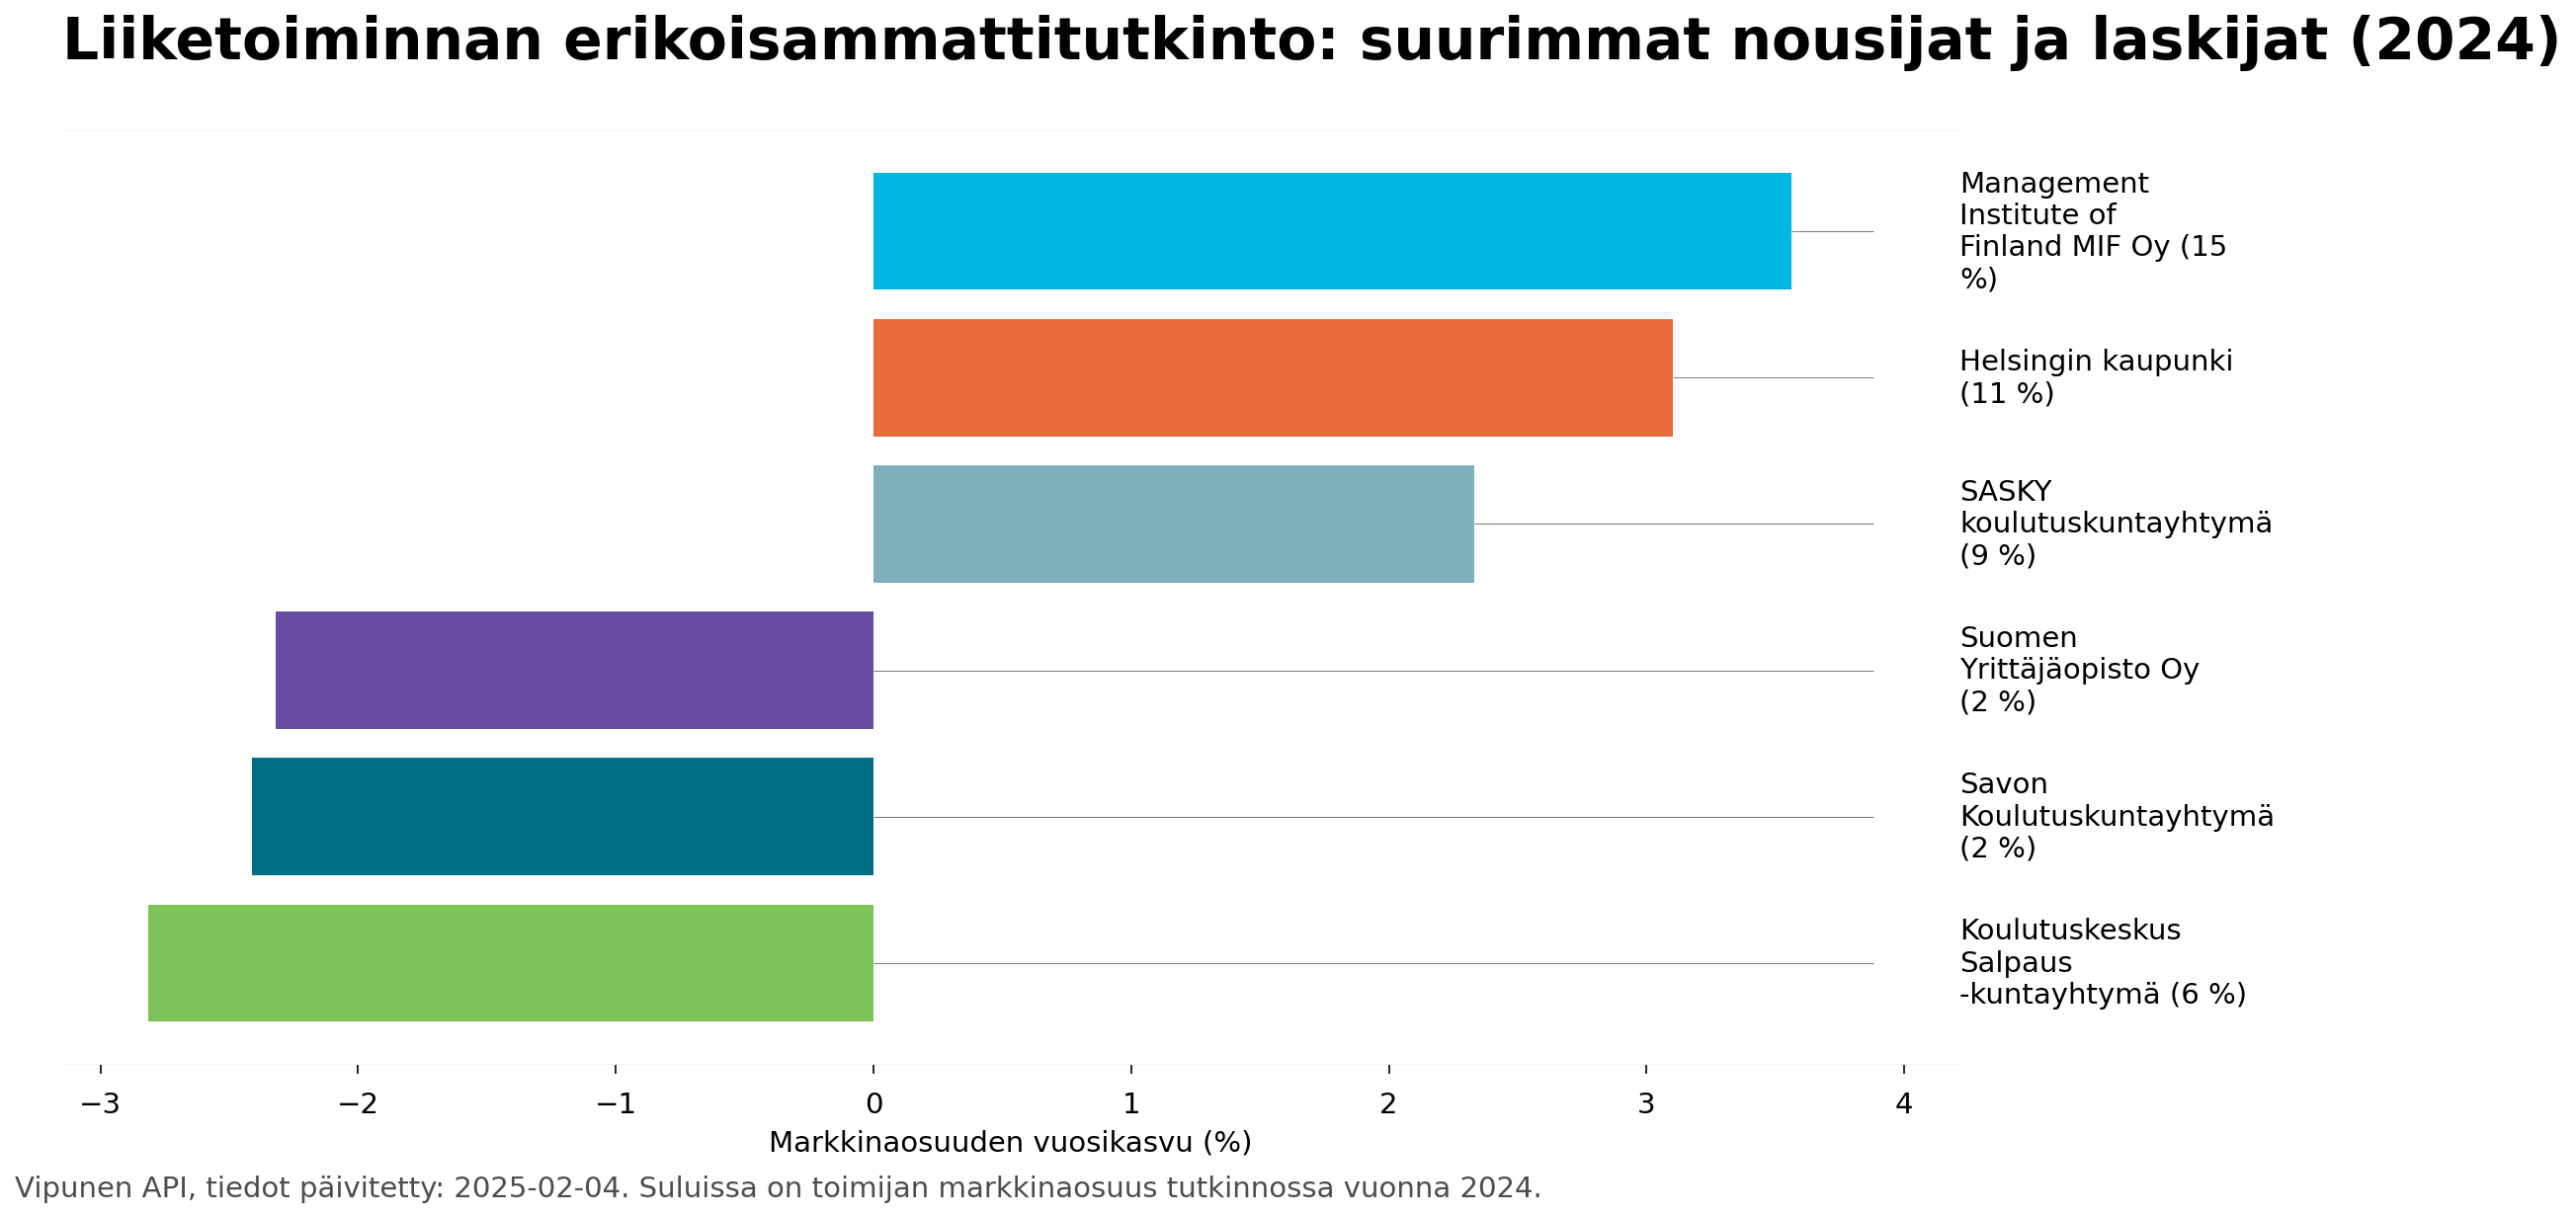

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


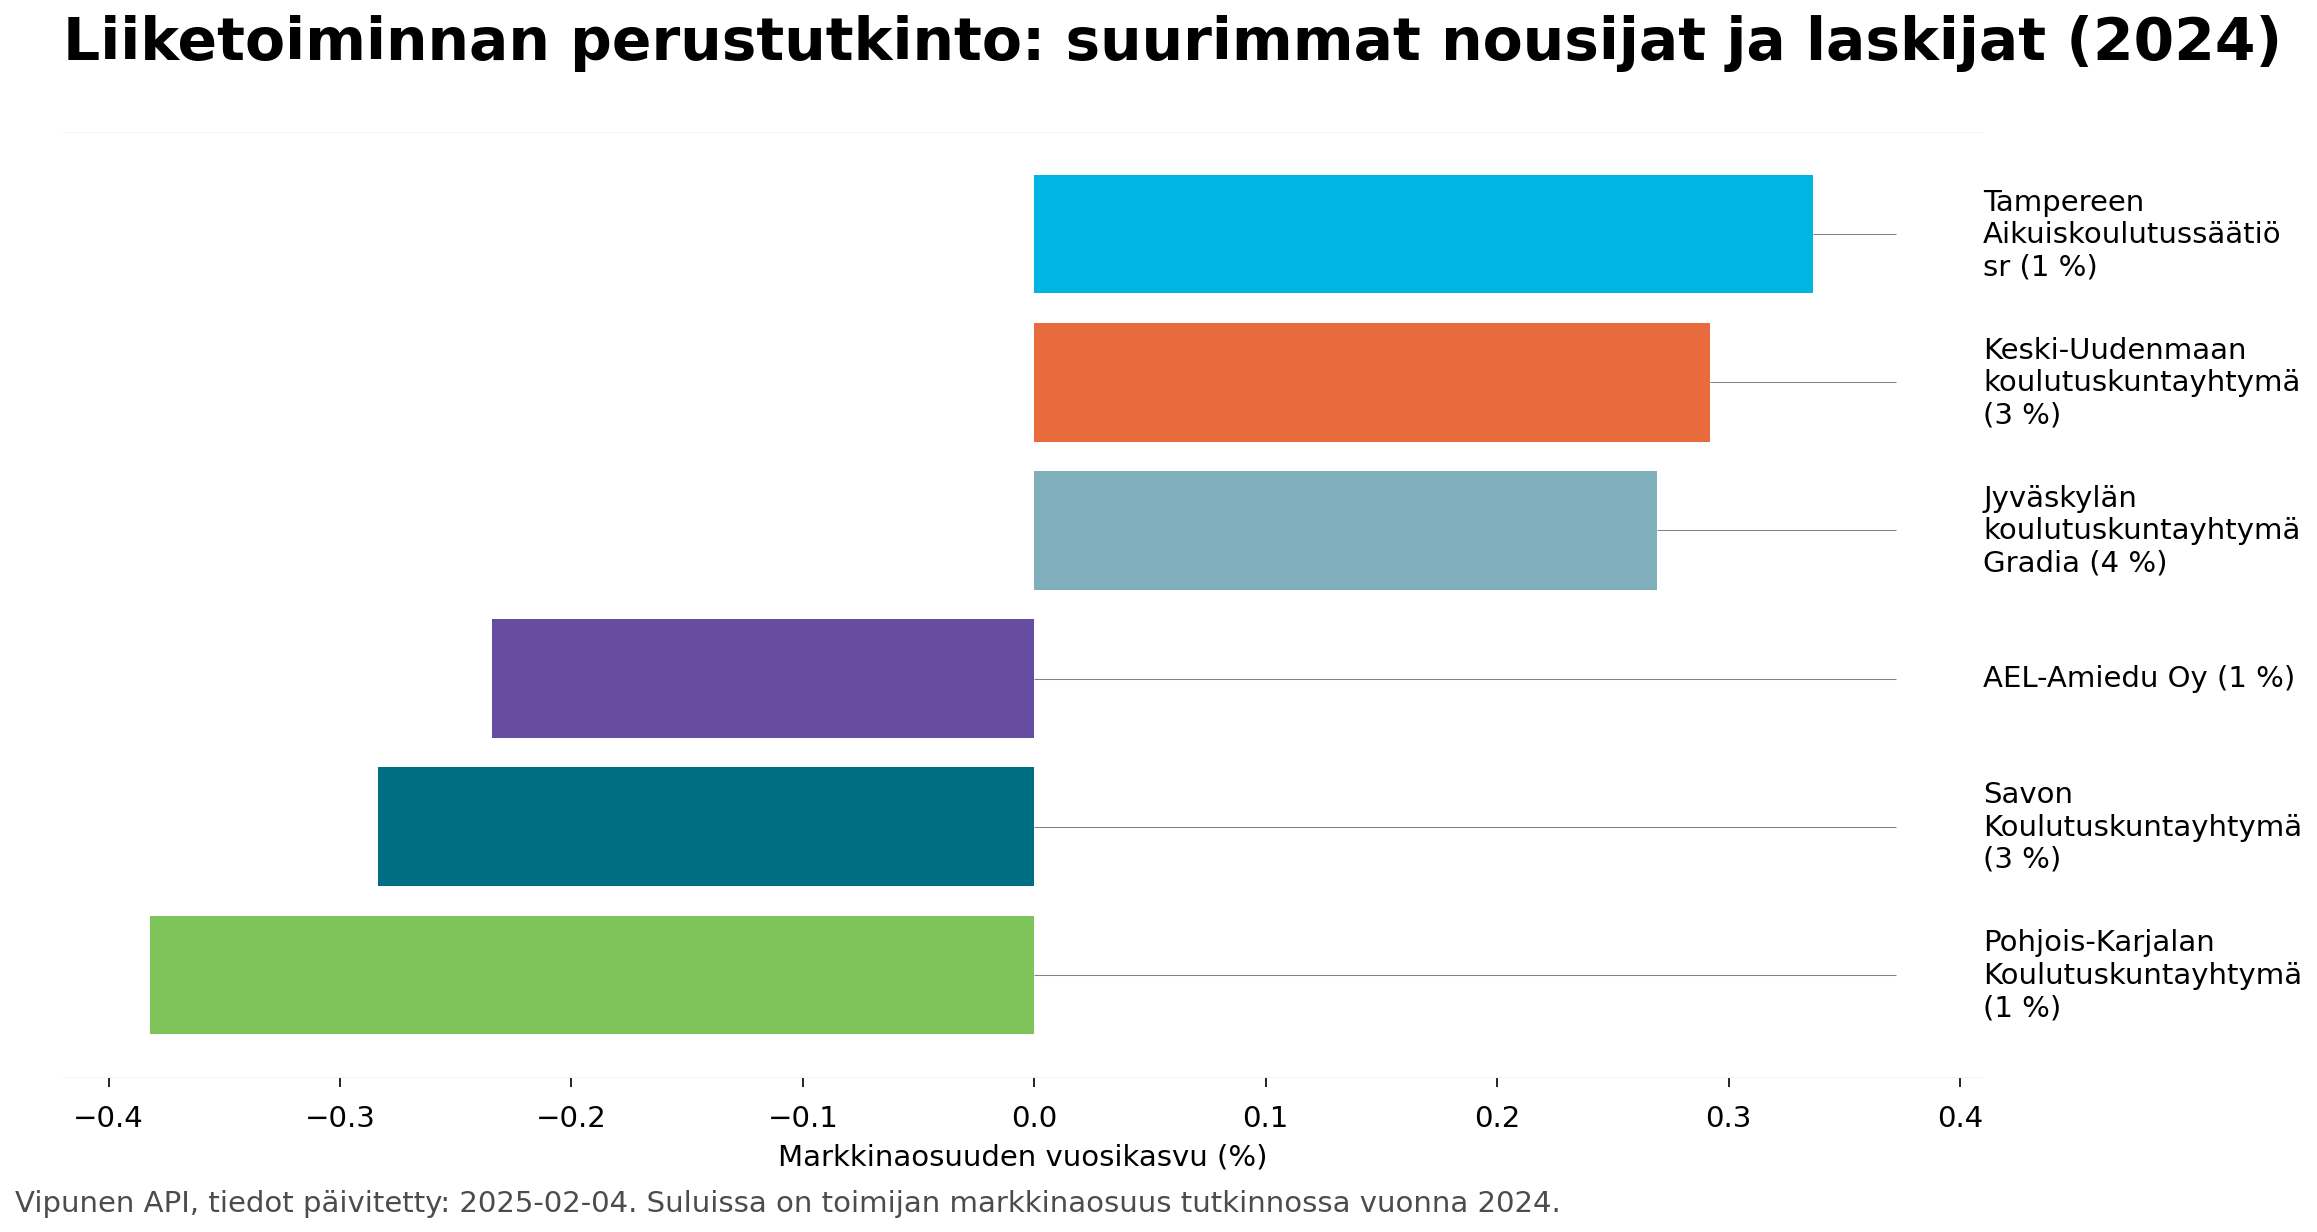

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


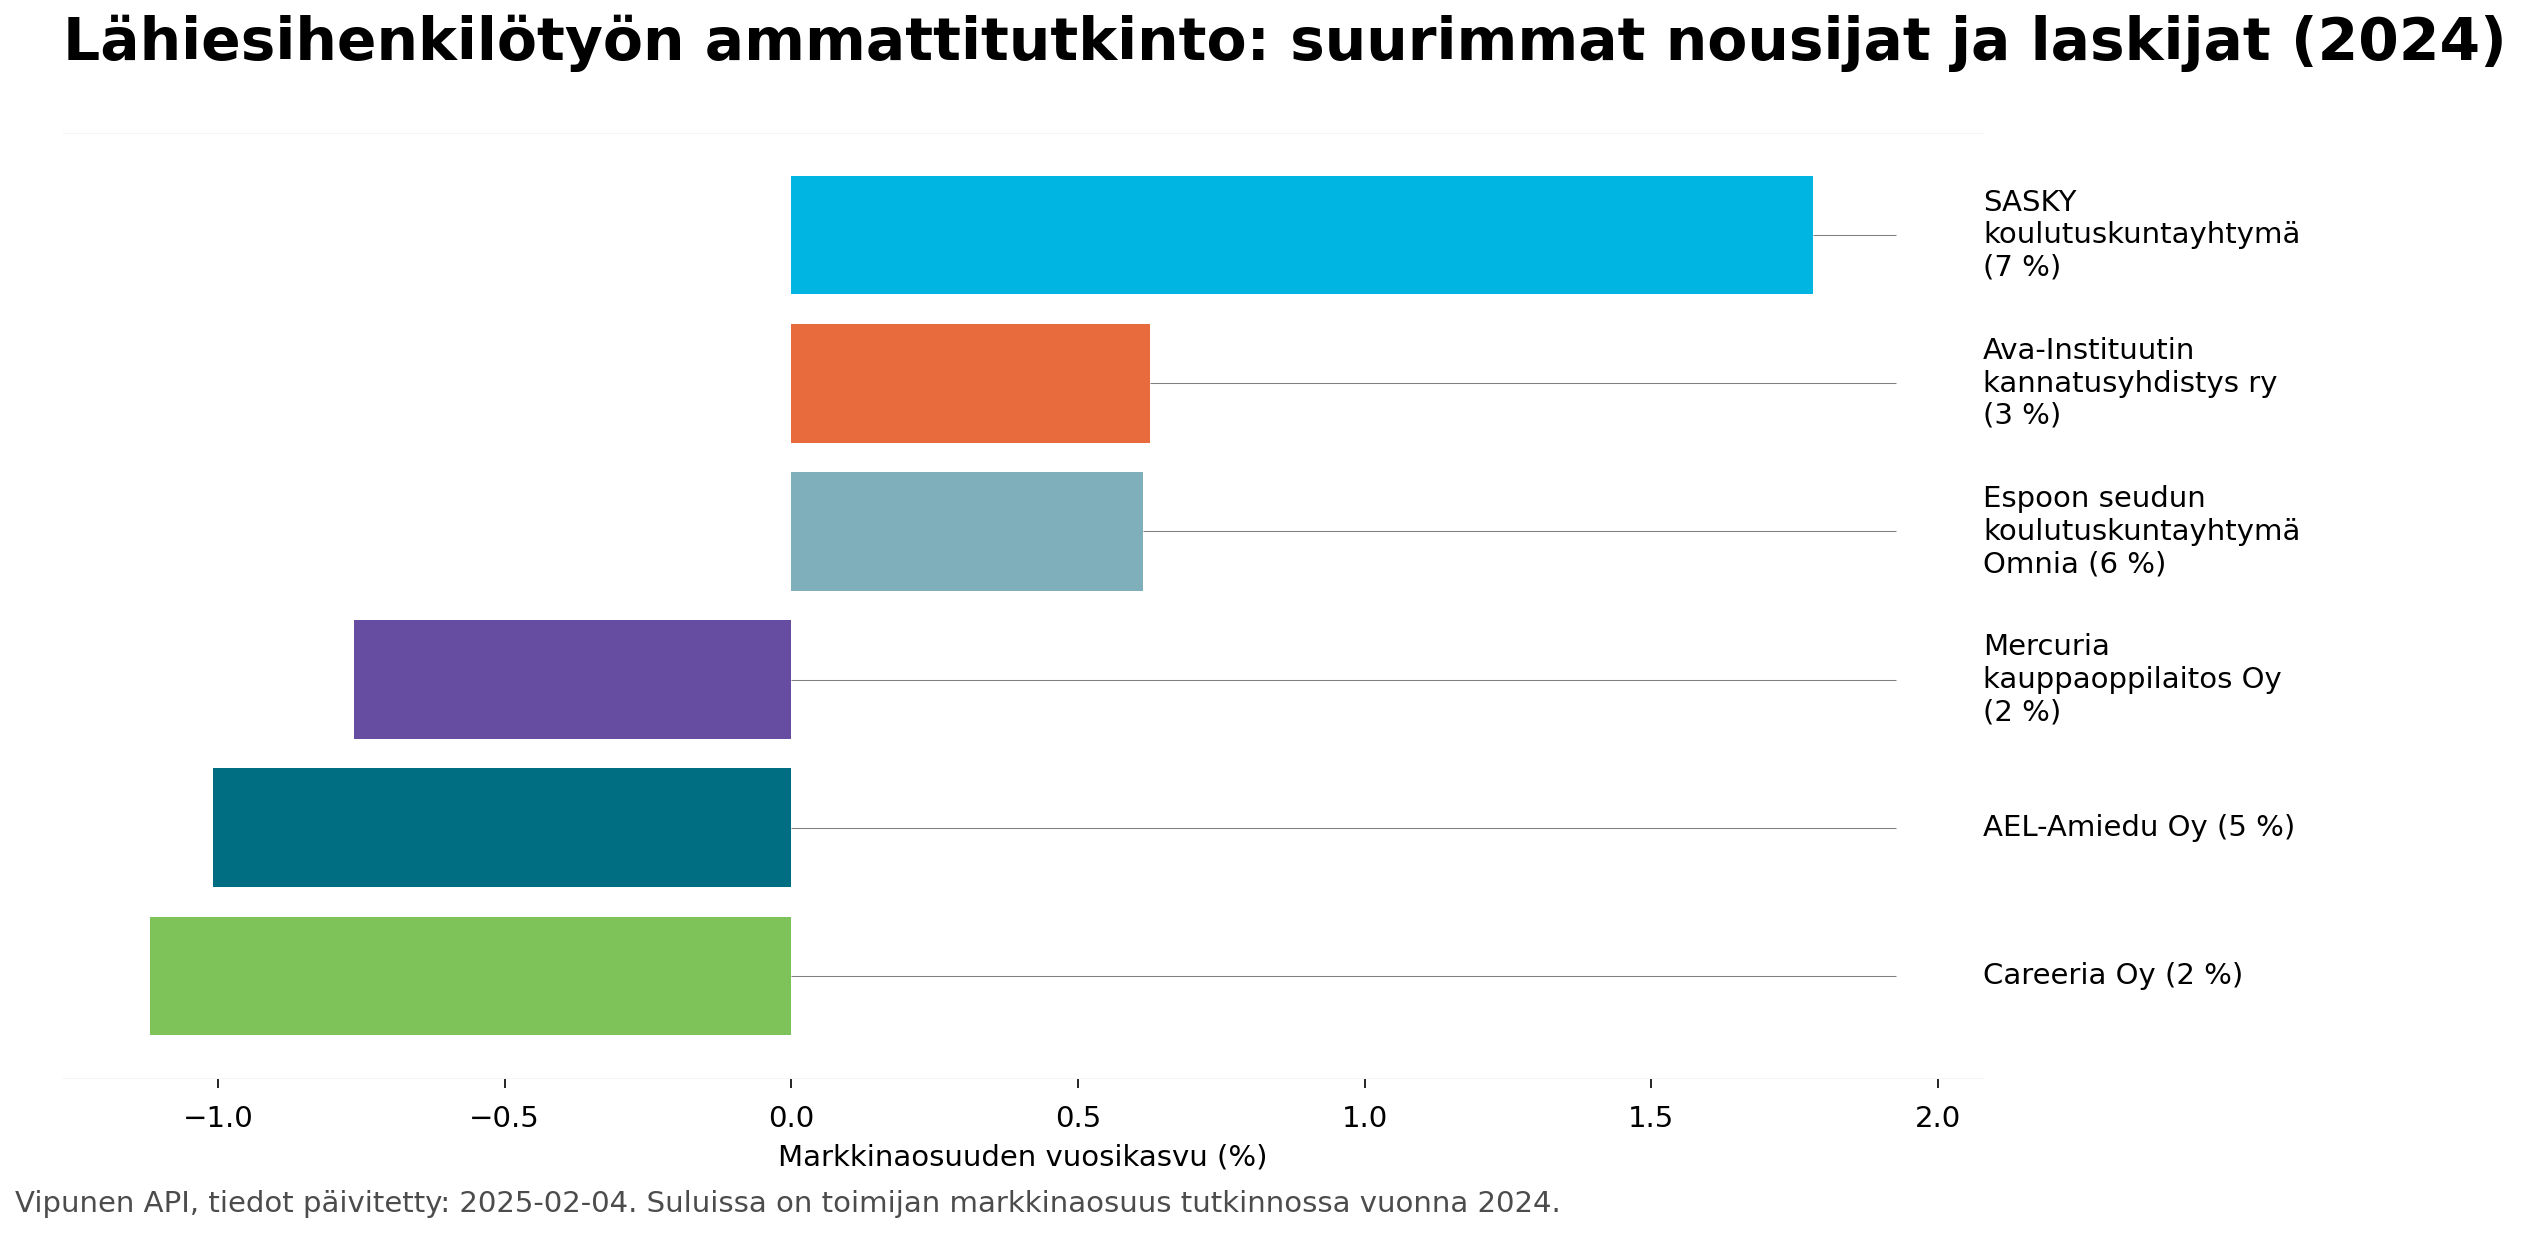

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


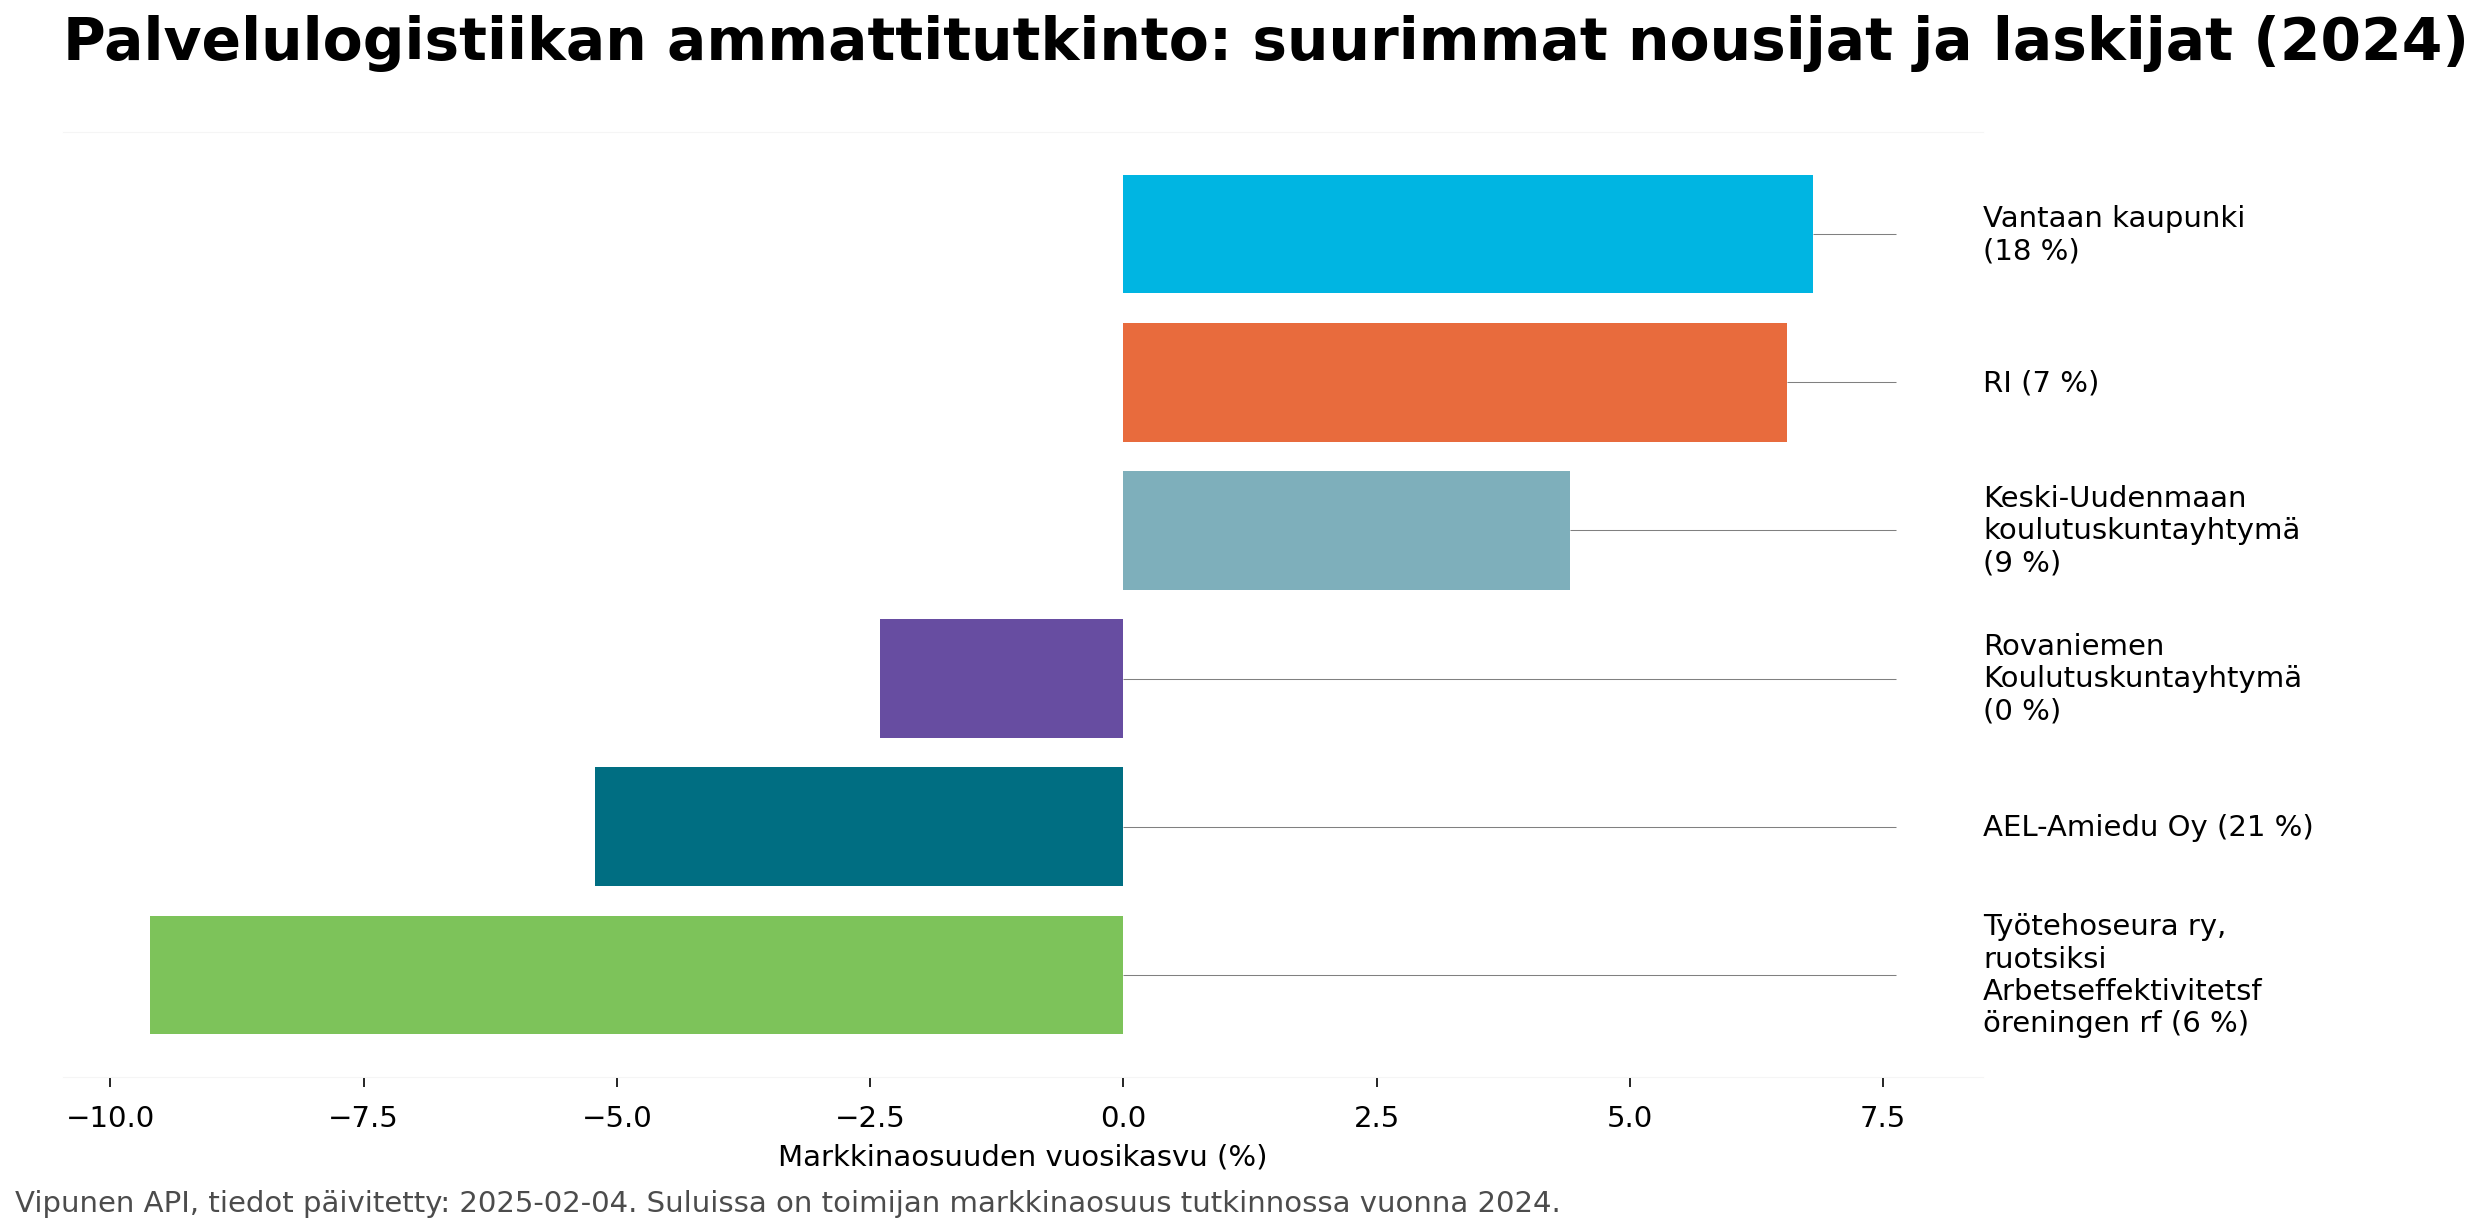

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


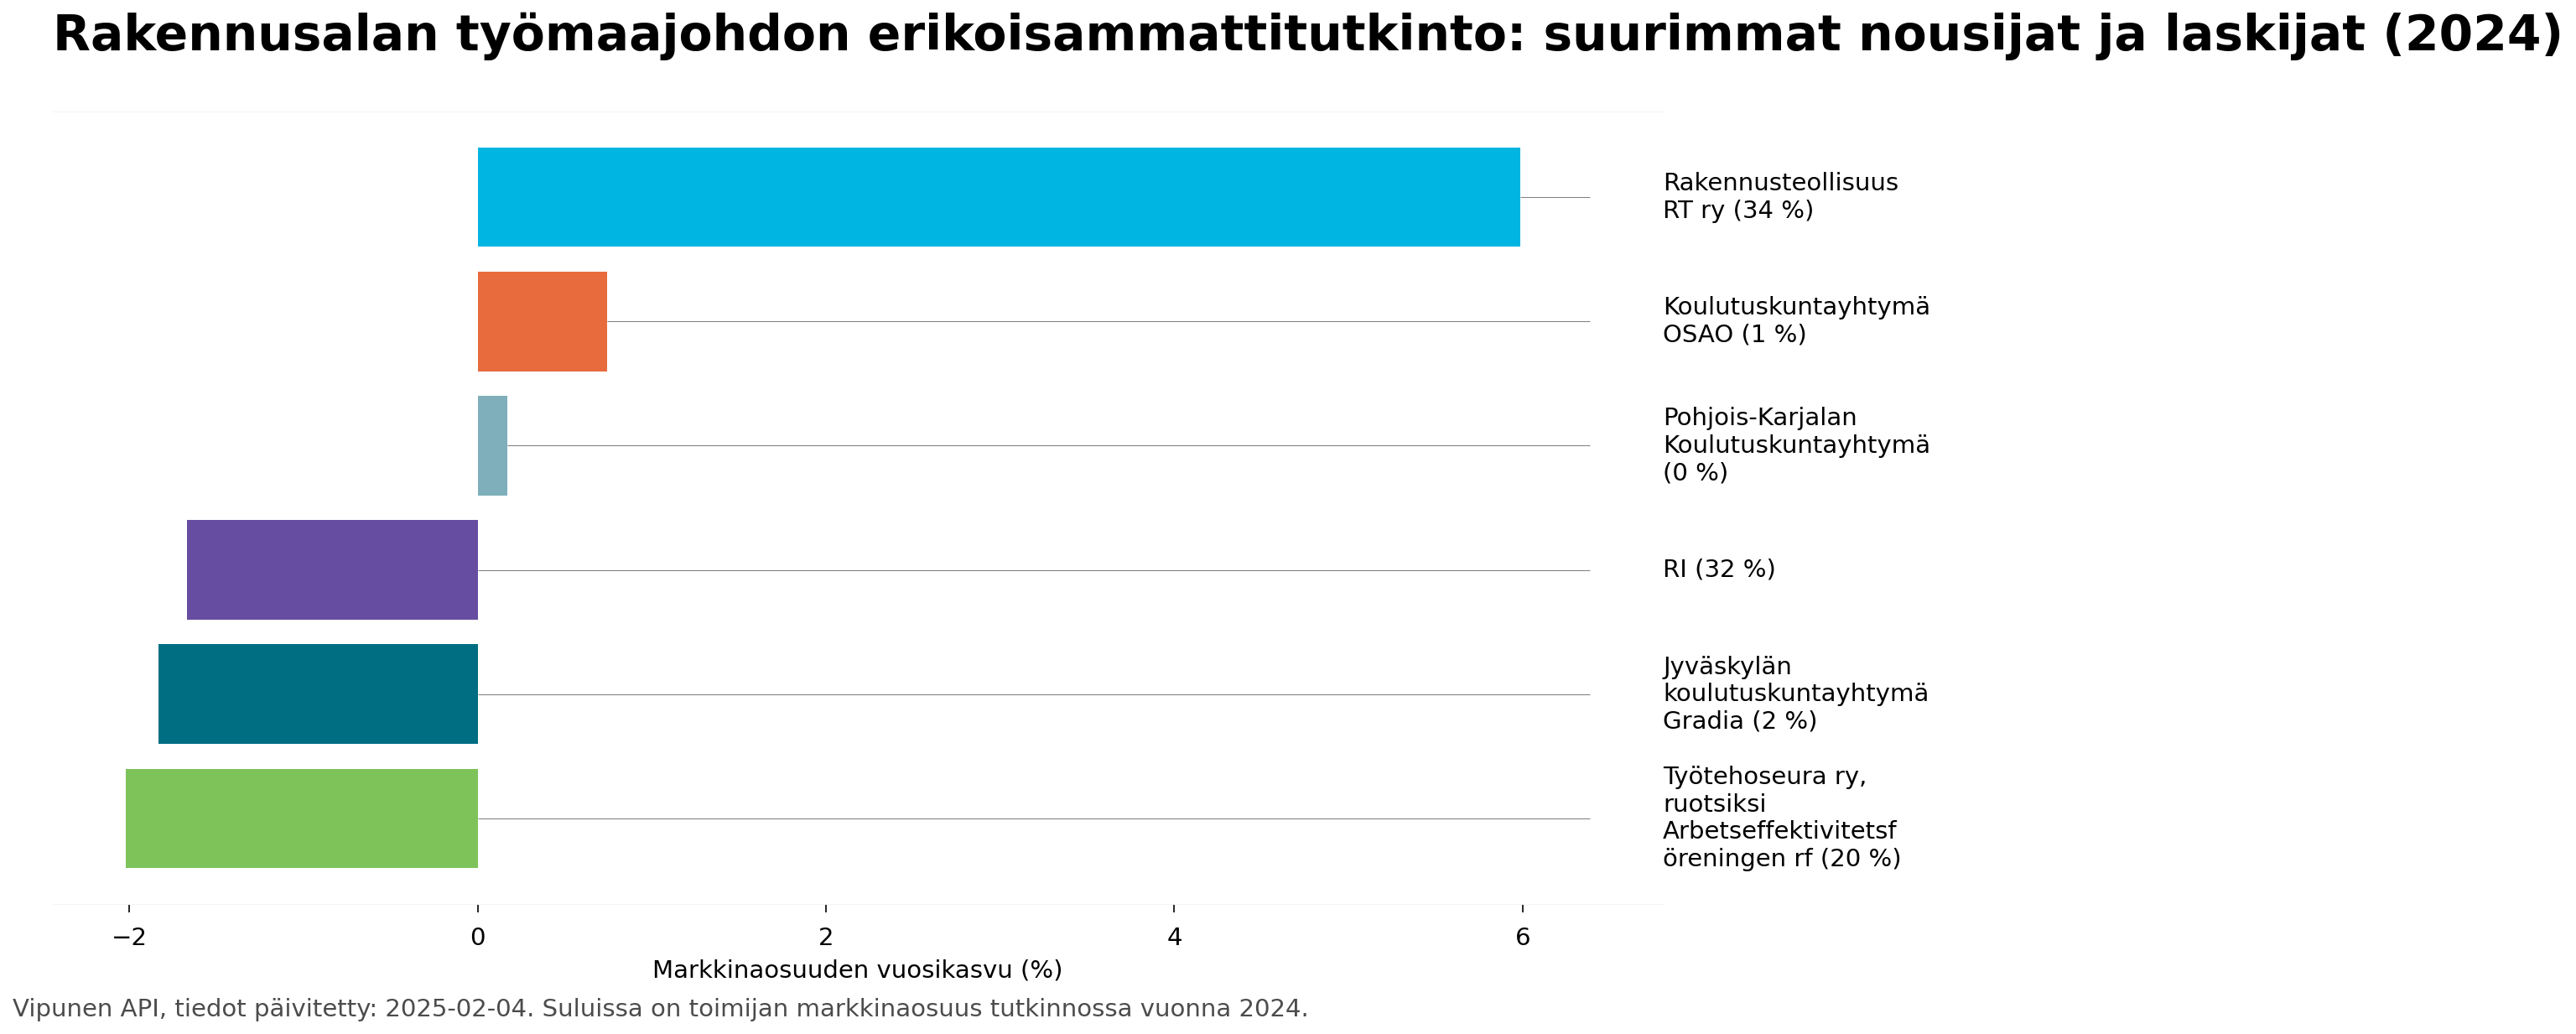

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


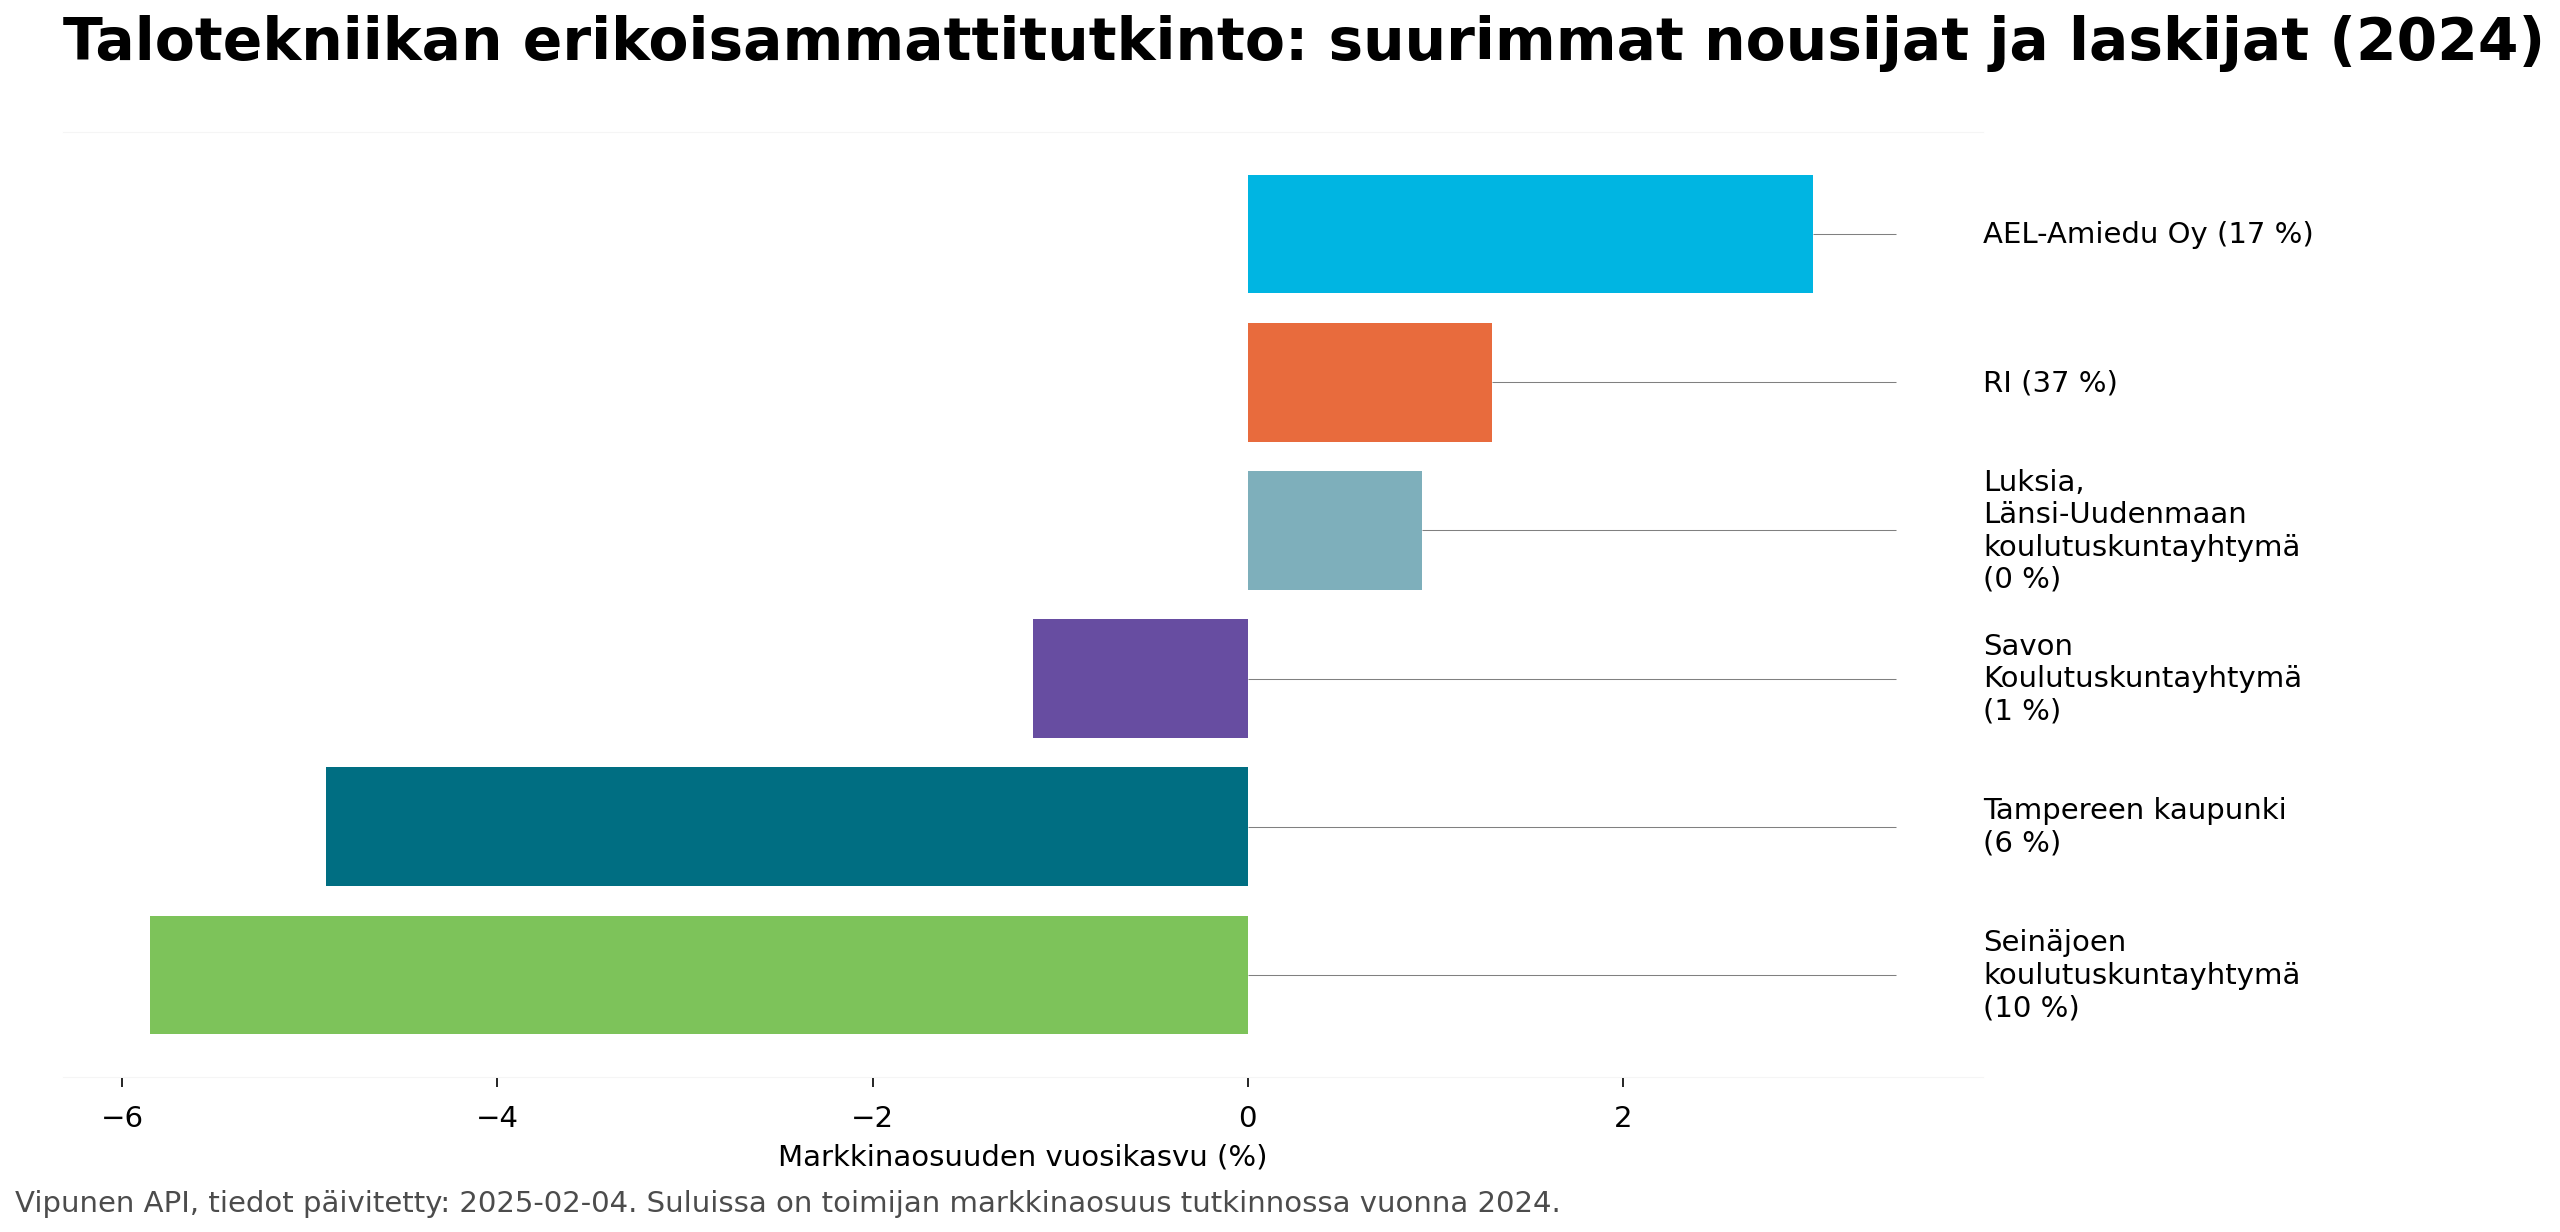

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


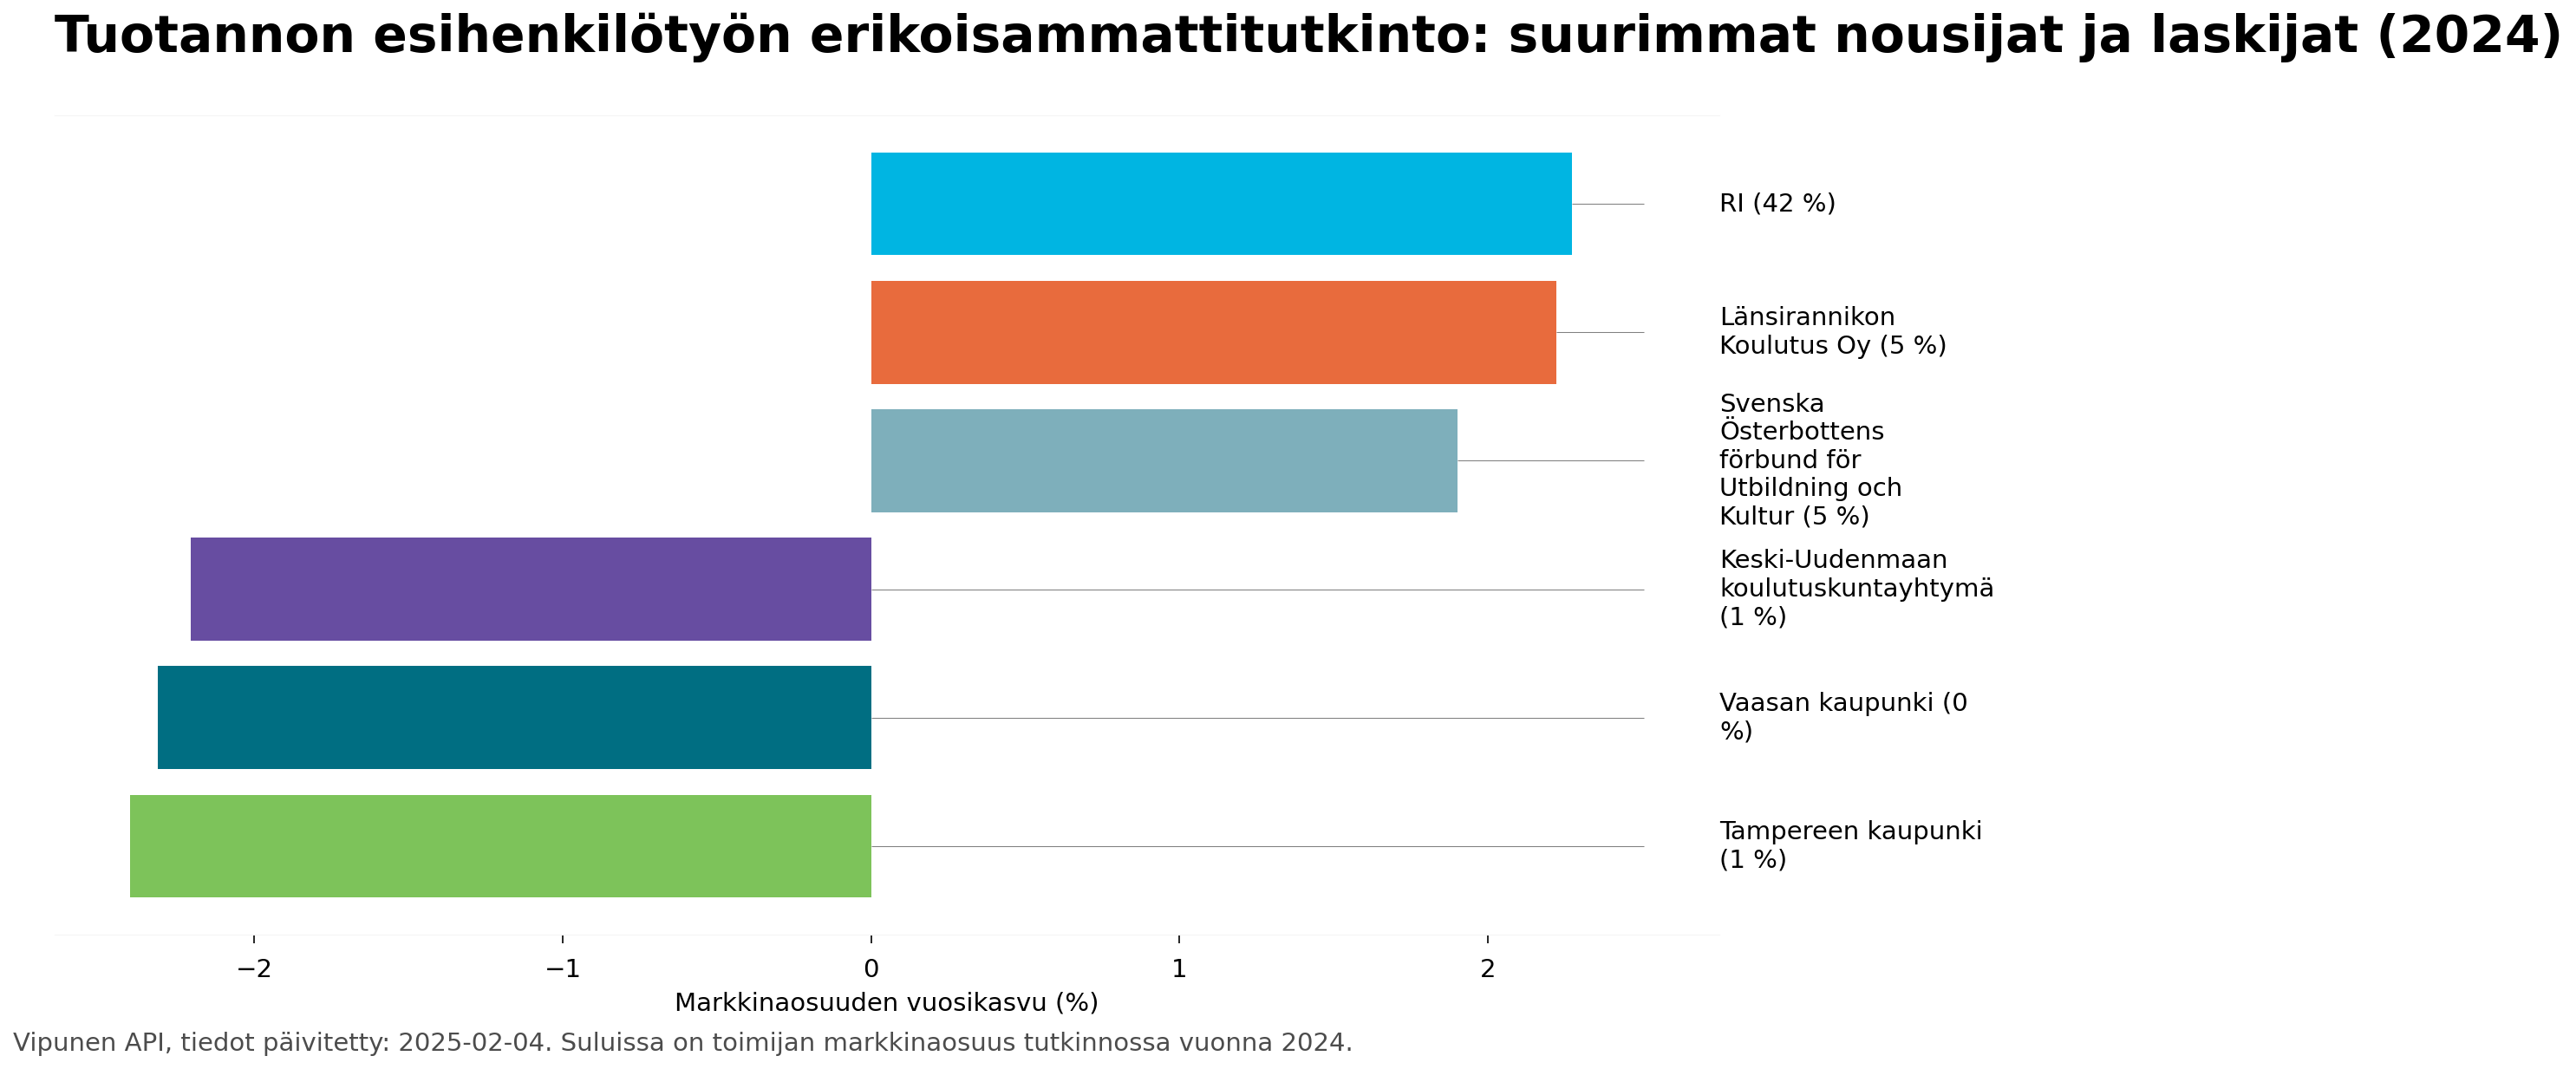

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


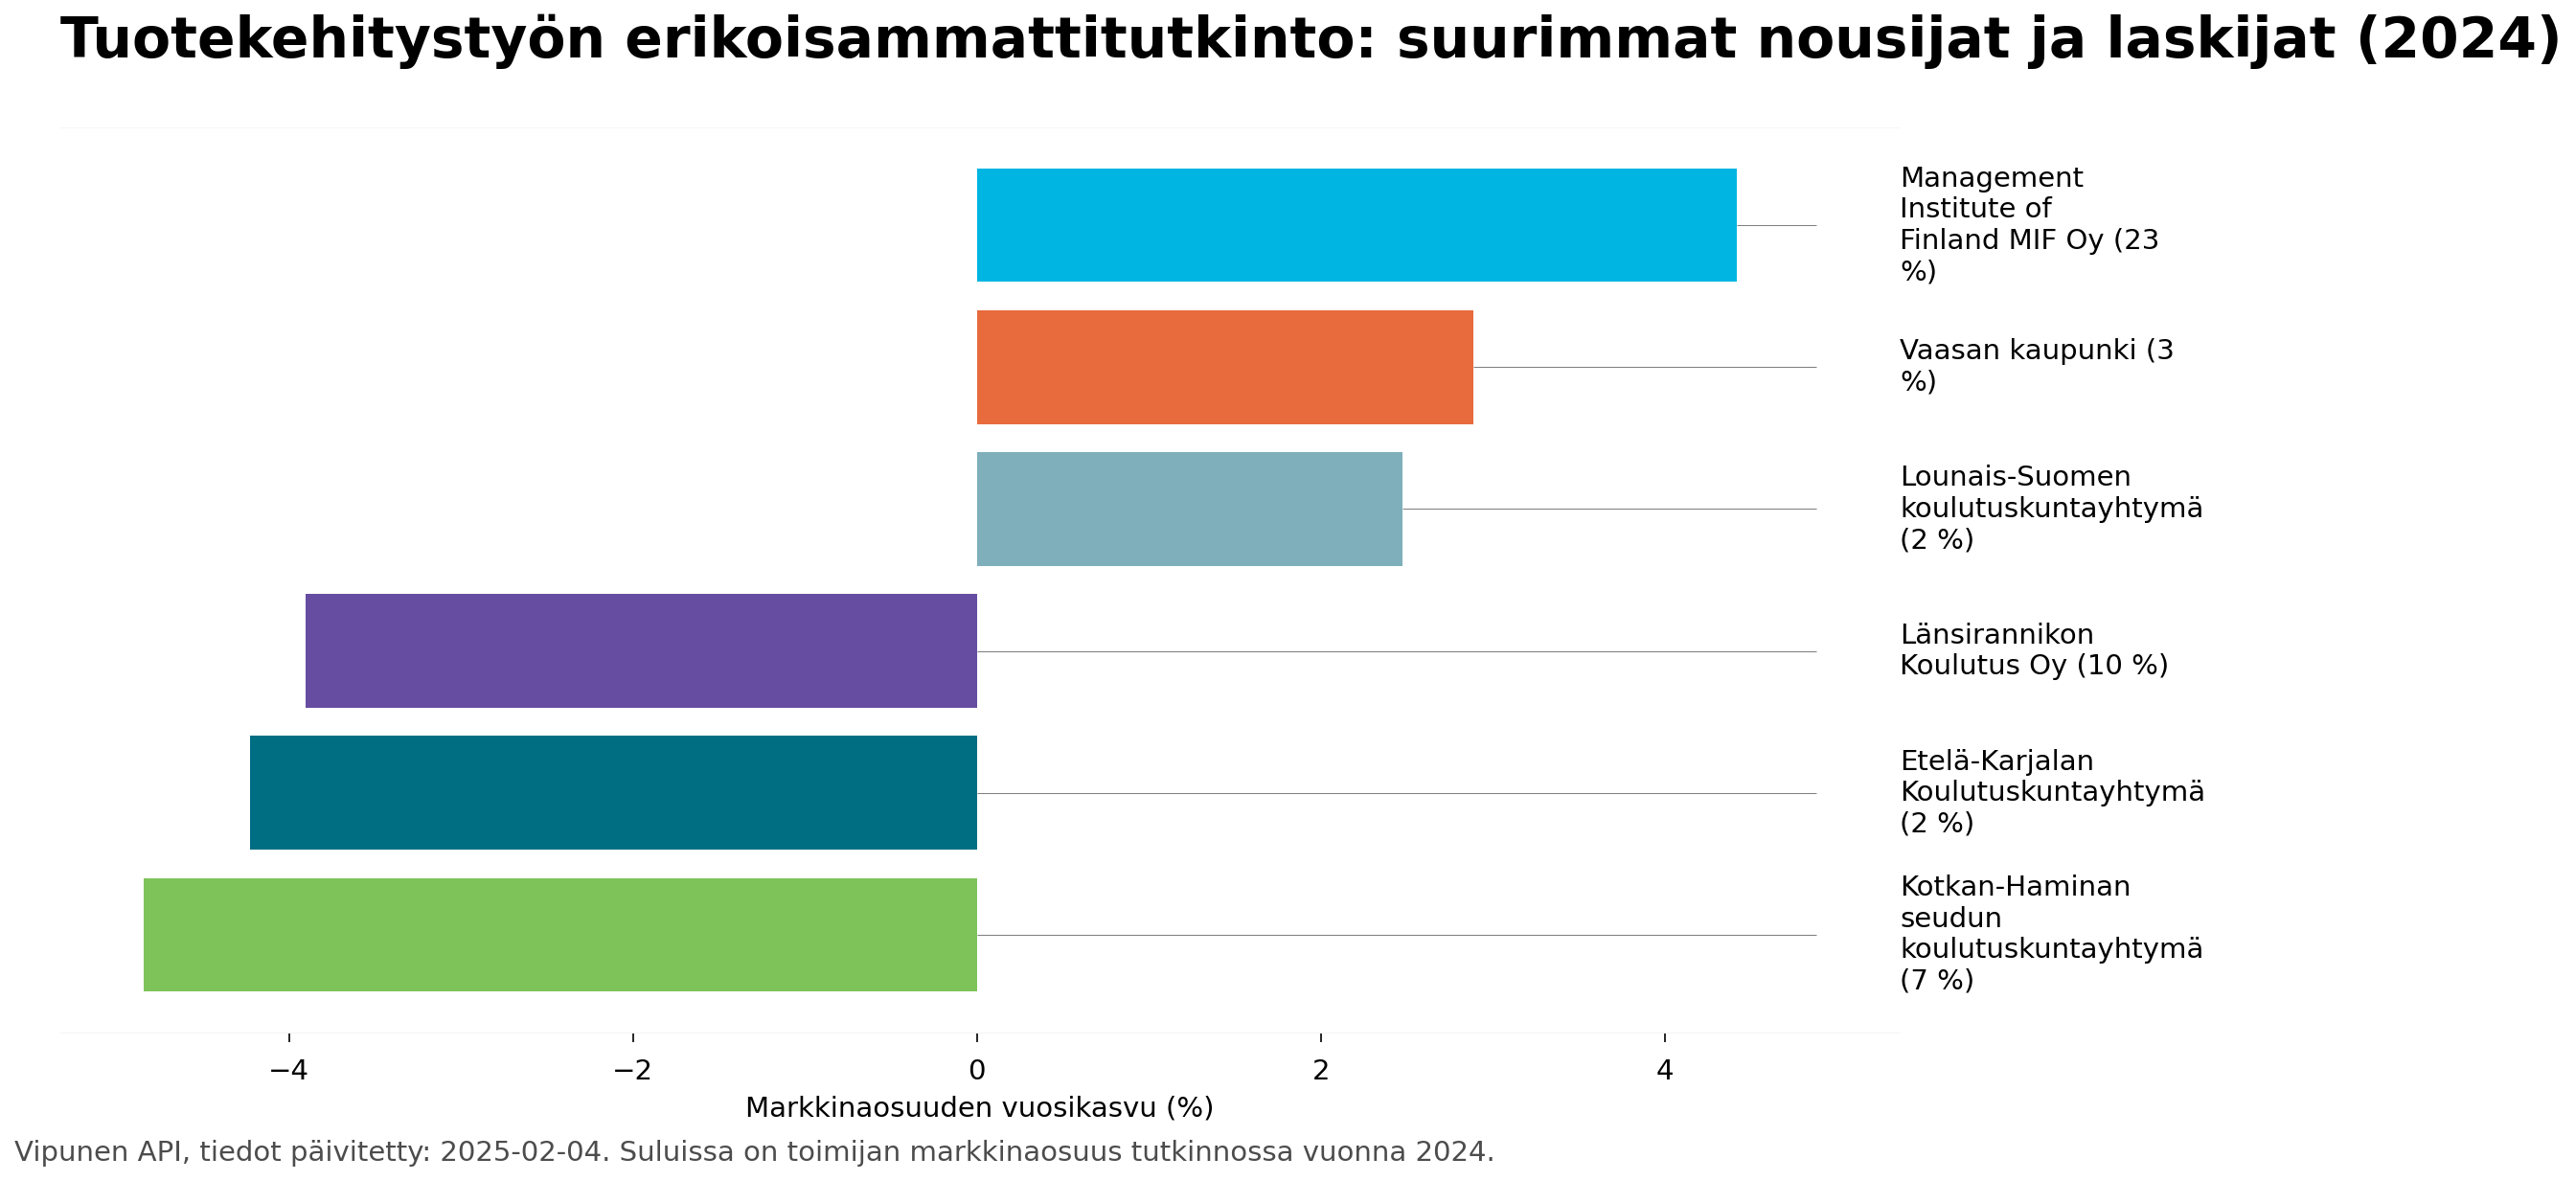

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


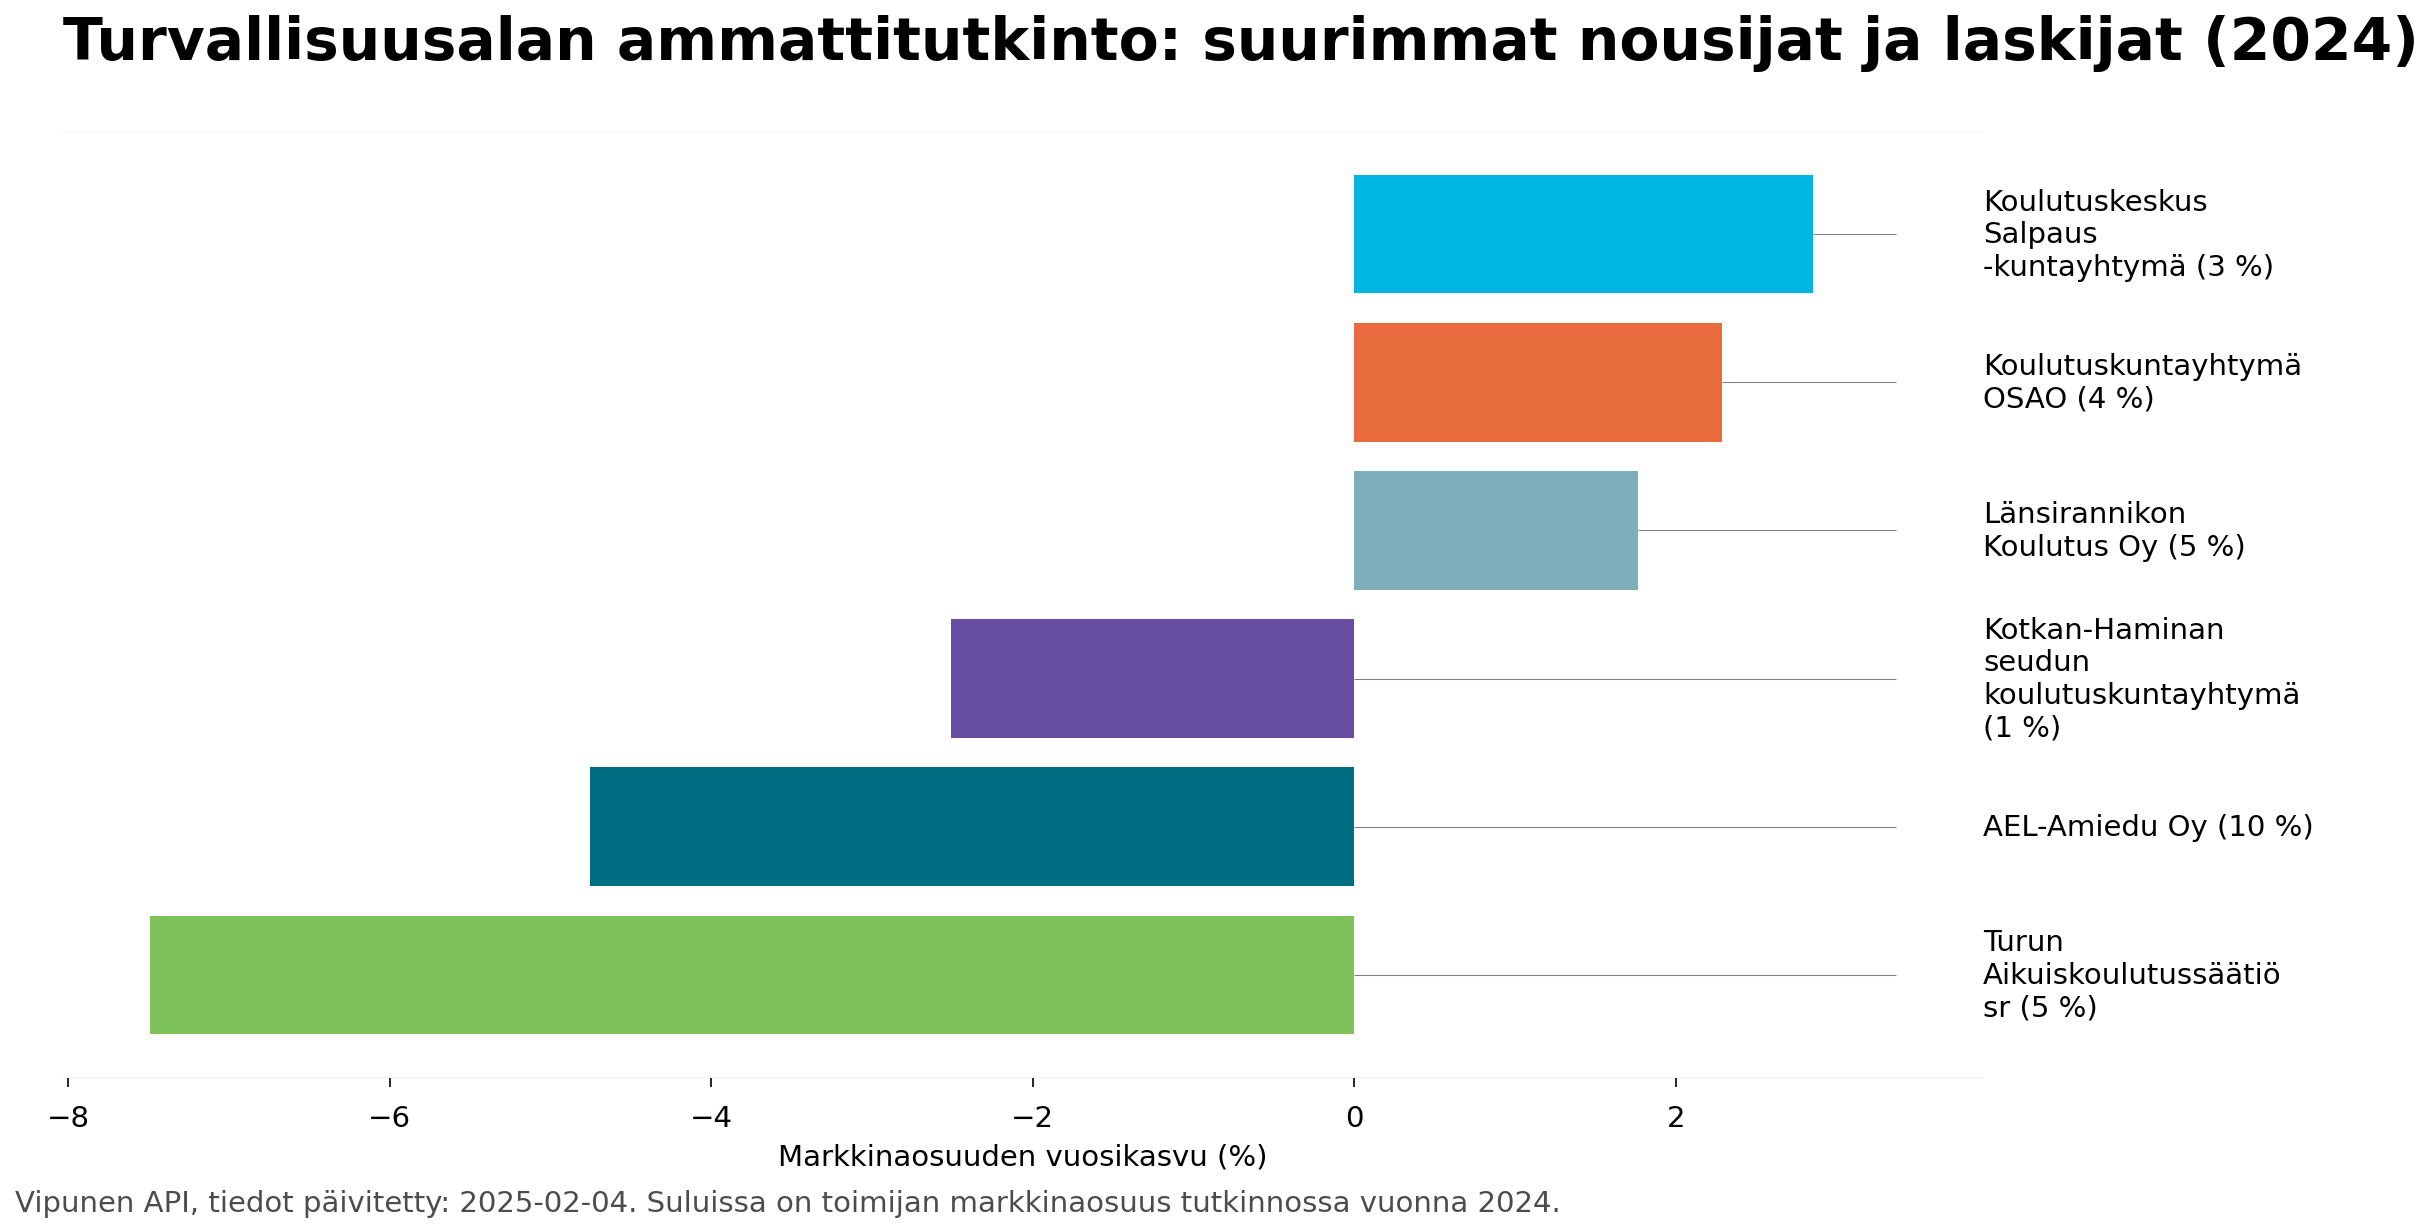

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


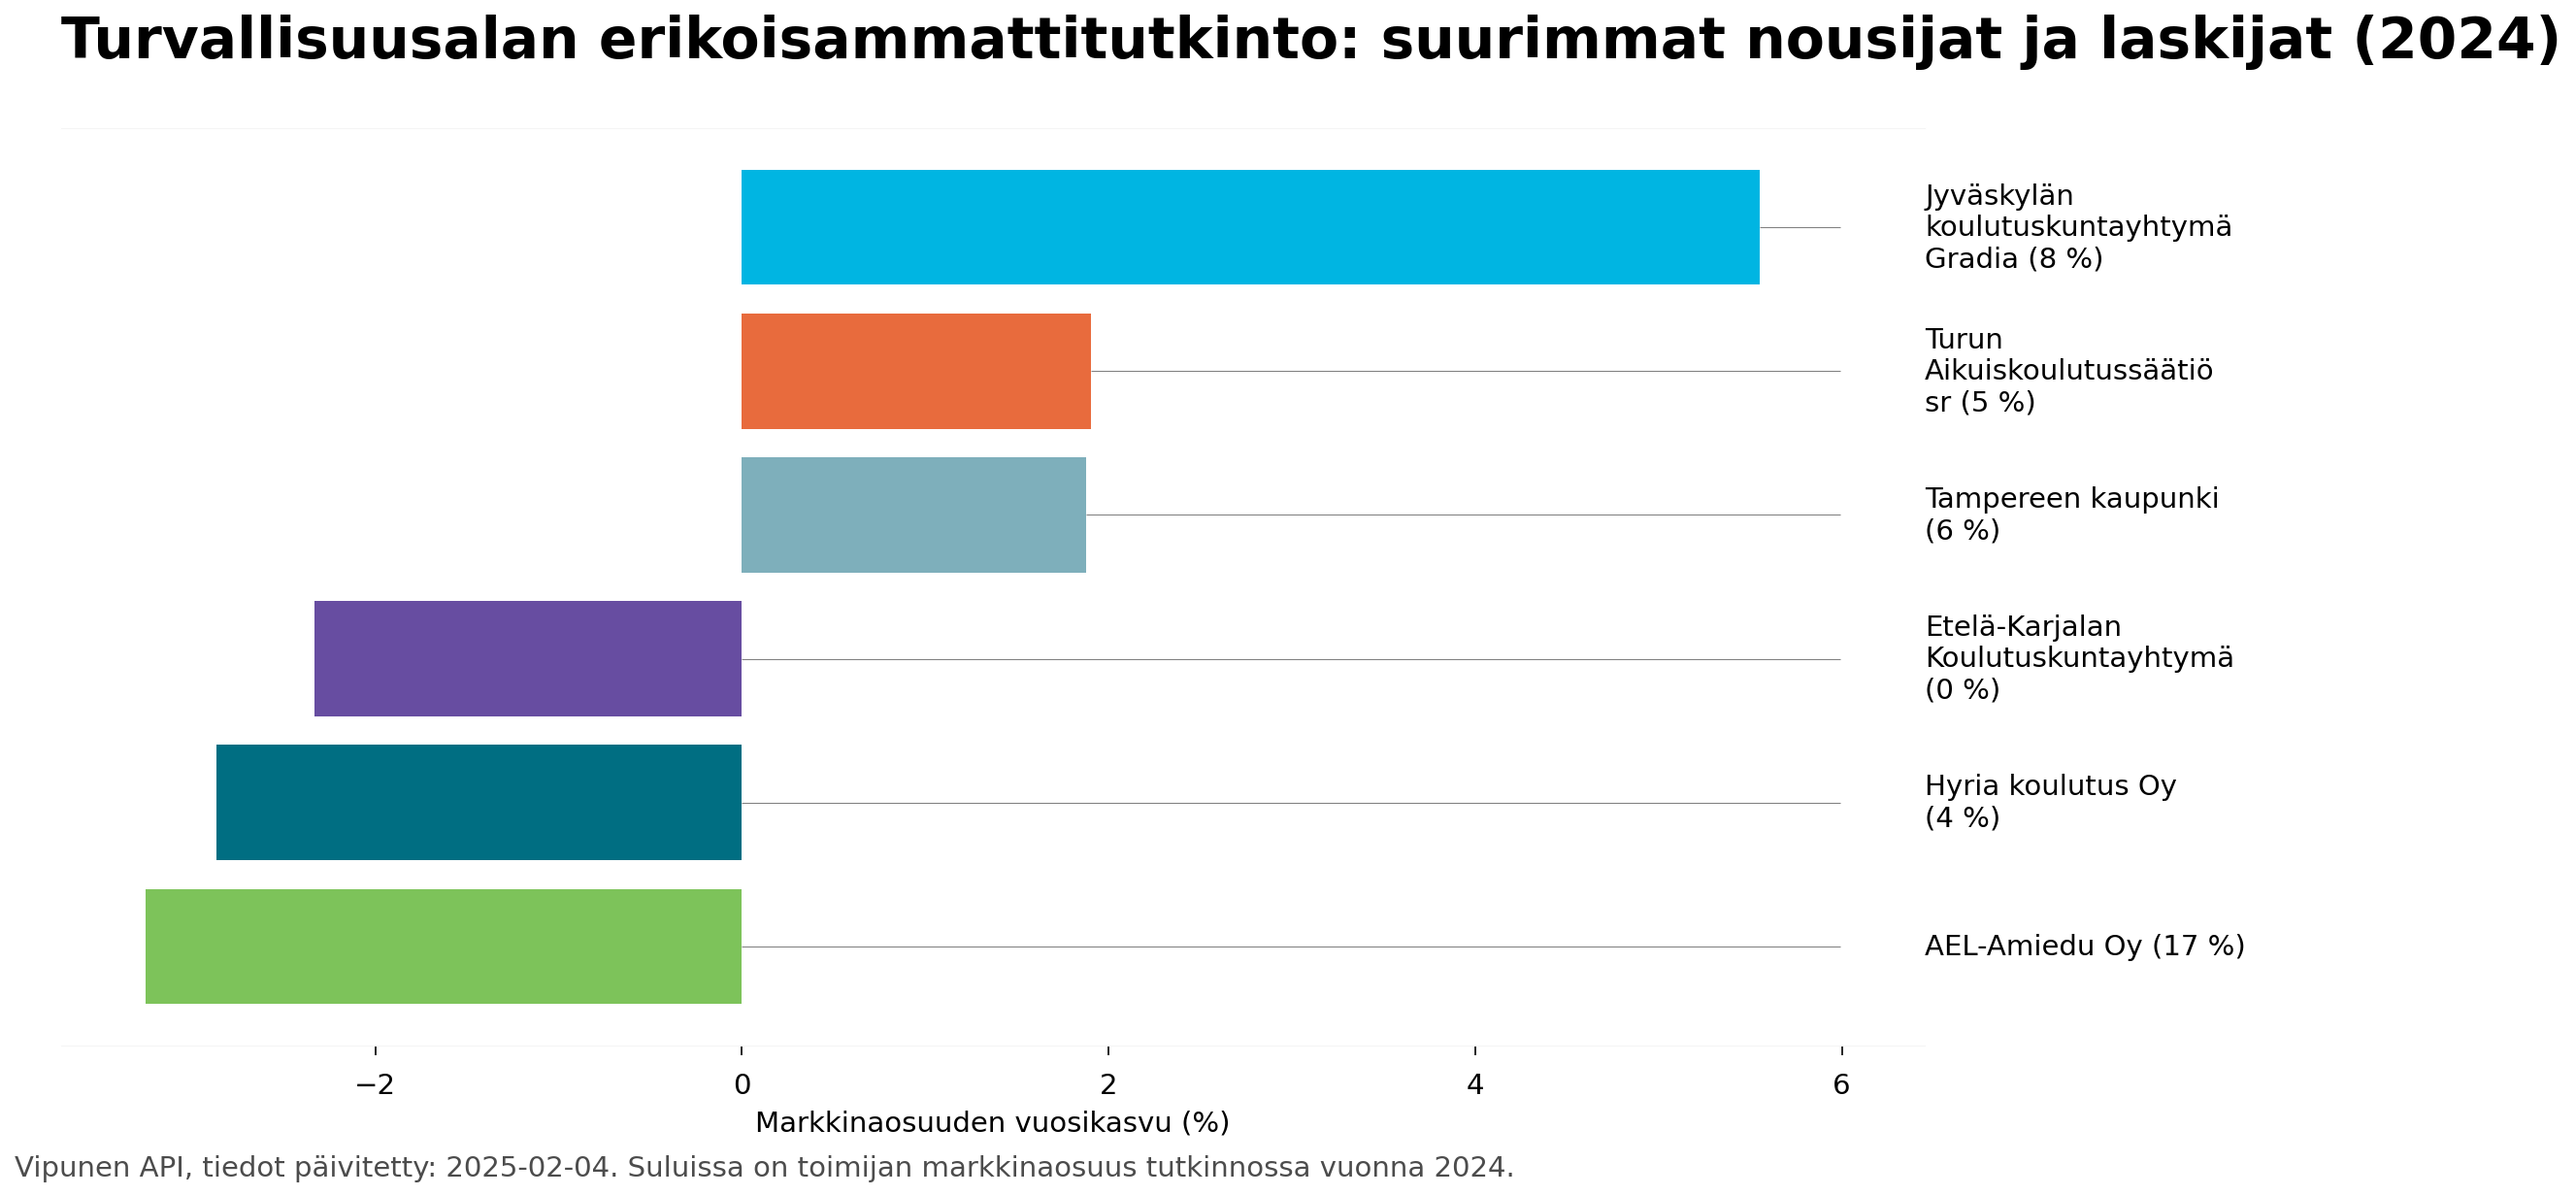

/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/4245509485.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center', fontsize=y_label_fontsize)


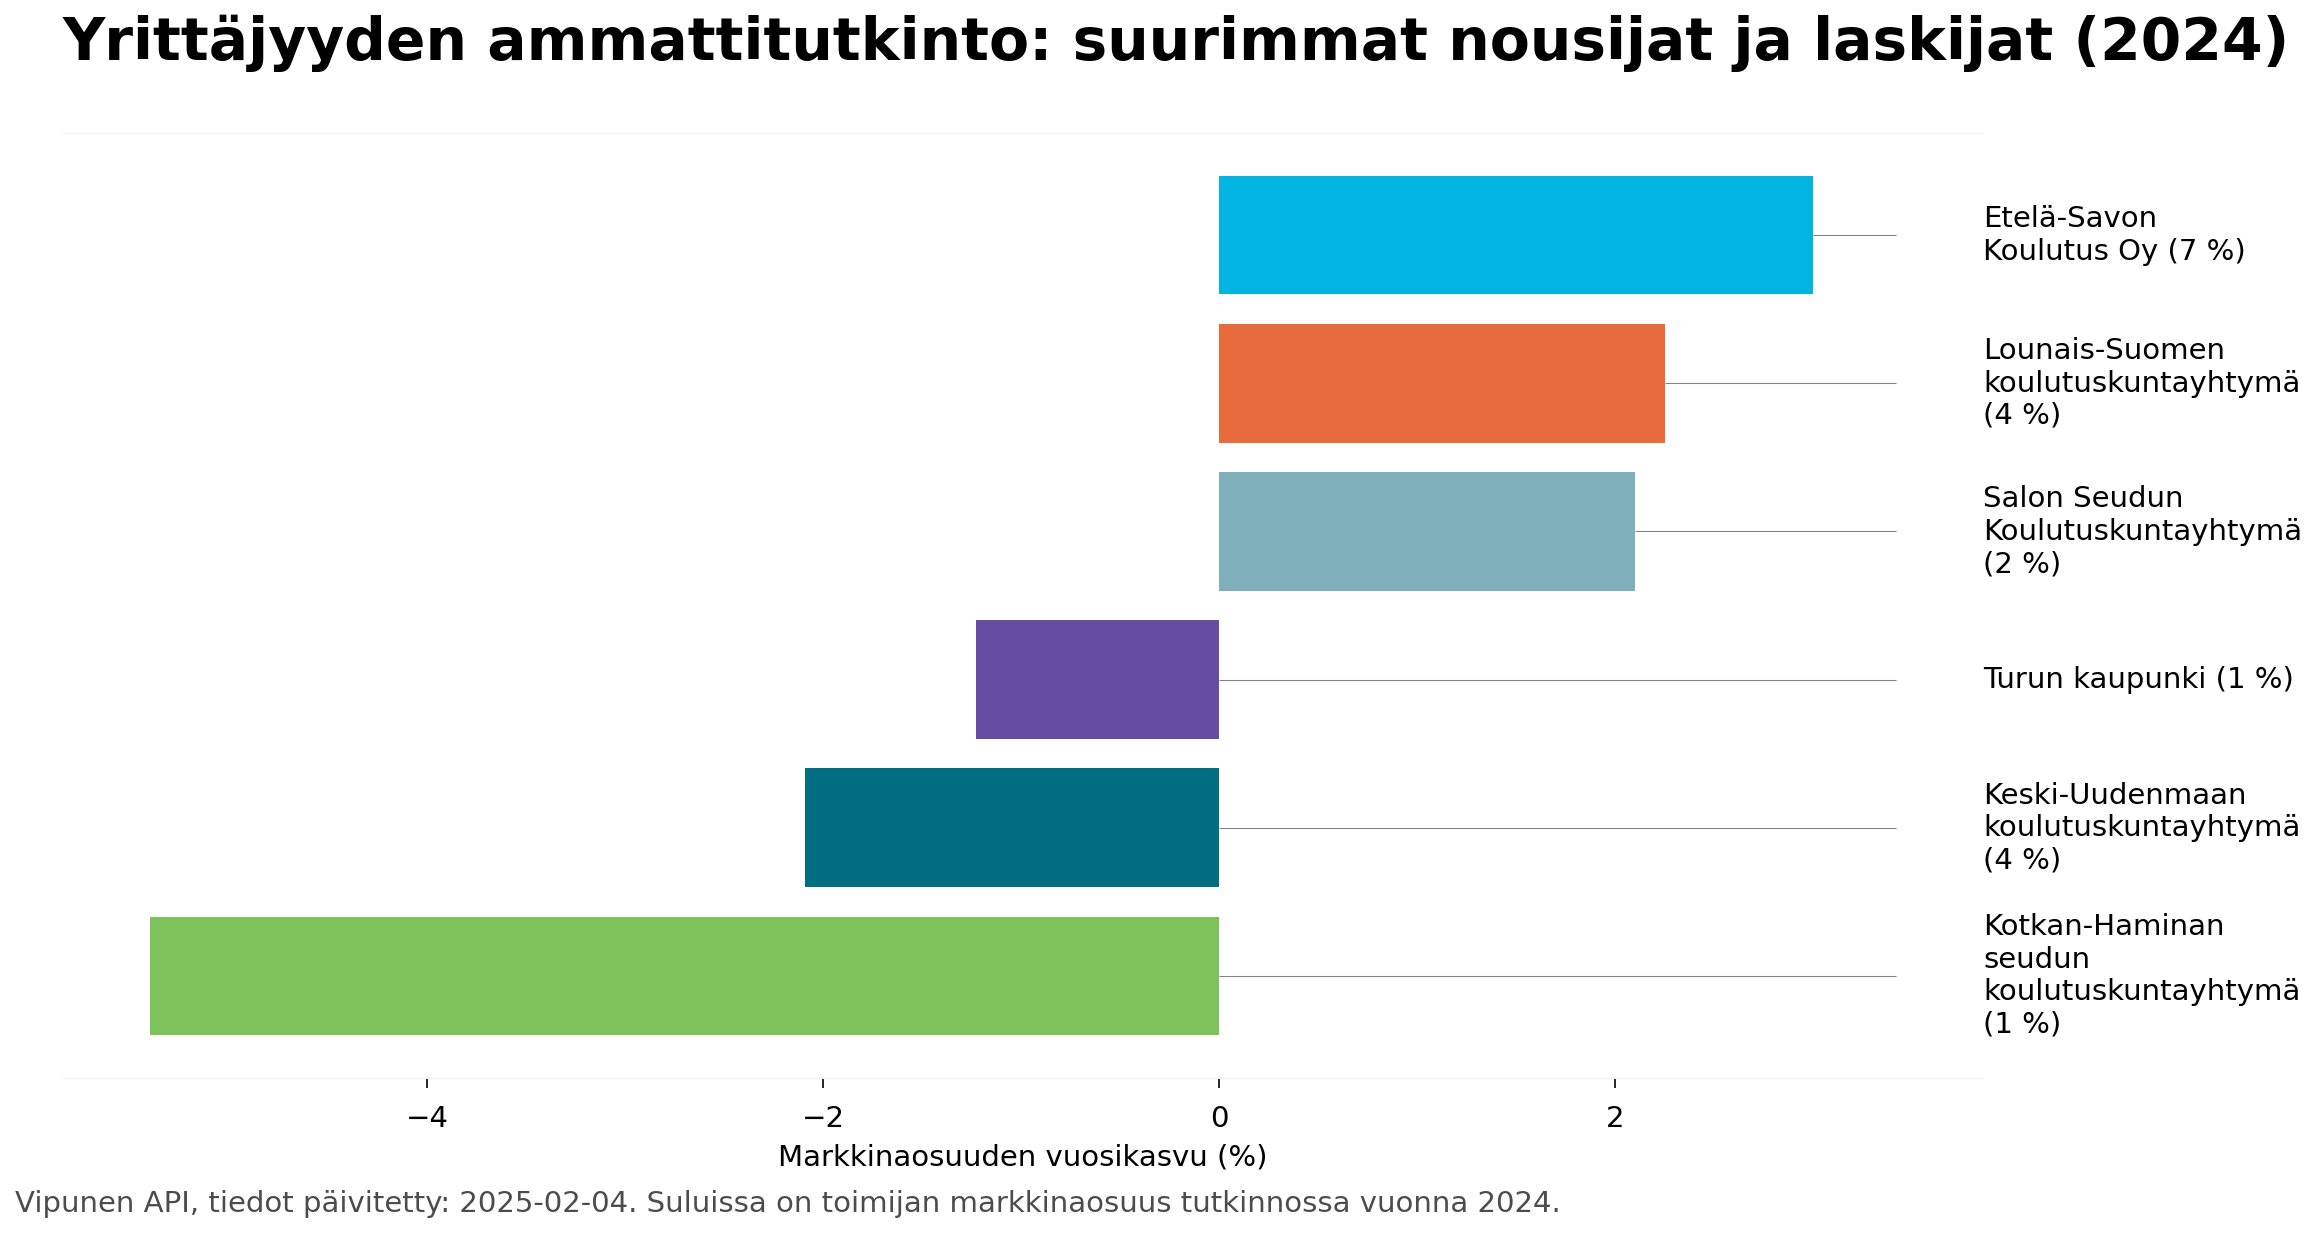

In [245]:
# markkinaosuuden menettäjät ja voittajat verrattuna edelliseen vuoteen

tarkasteltava_vuosi=2024
top_bottom_n = 3
source = f"Vipunen API, tiedot päivitetty: {vipunen_haku_pvm}. Suluissa on toimijan markkinaosuus tutkinnossa vuonna {tarkasteltava_vuosi}."

# filter_conditions = {'tilastovuosi': tarkasteltava_vuosi}

# Pre-filter the DataFrame for the specific qualification and year

for tutkinto in toimijoiden_markkinaosuudet_kasvu['tutkinto'].unique():
    df_filtered = toimijoiden_markkinaosuudet_kasvu[(
    toimijoiden_markkinaosuudet_kasvu['tilastovuosi'] == tarkasteltava_vuosi) & (
        toimijoiden_markkinaosuudet_kasvu['tutkinto'] == tutkinto)]

    # Now call your plotting function
    fig_tuple, fig = plot_generic_growth_comparison(
        df=df_filtered,
        filter_conditions={},  # No additional filters needed as we pre-filtered the DataFrame
        growth_column='markkinaosuus tutkinnossa (%)_YoY',
        category_column='kouluttaja',
        detail_column='markkinaosuus tutkinnossa (%)',
        title_template=f"{tutkinto}: suurimmat nousijat ja laskijat ({tarkasteltava_vuosi})",
        limit=top_bottom_n,
        source=source,
        x_label='Markkinaosuuden vuosikasvu (%)',
        y_label='',
        y_label_fontsize=14,
        y_label_wrap_length=20,
        colors=ri_colors_large_palette
    )

    # Close the figure without the title
    plt.close(fig_tuple[0])

    # Append the figure with the title to your list
    visualizations_for_export.append(fig_tuple)

    # Display the figure with the title in the notebook
    plt.show()

# Reset to default style
reset_plot_style()


In [246]:
lahiesimiestyo_df = toimijoiden_markkinaosuudet_kasvu.query('tutkinto == "Lähiesimiestyön ammattitutkinto"')
lahiesimiestyo_df.query('tilastovuosi in [2022,2023] and `Sijoitus markkinassa` < 5').groupby(
    by=['tilastovuosi','kouluttaja'])[['nom_tutkinto yhteensa','nom_kouluttaja yhteensa','nettoopiskelijamaaraLkm_as_jarjestaja','nettoopiskelijamaaraLkm_as_hankinta','tutkinto markkinakasvu (%)','kouluttaja tutkintokasvu (%)',
        'tutkinto markkinakasvu (%)','markkinaosuus tutkinnossa (%)_YoY','Sijoitus markkinassa']].sum().head(30)


Empty DataFrame
Columns: [nom_tutkinto yhteensa, nom_kouluttaja yhteensa, nettoopiskelijamaaraLkm_as_jarjestaja, nettoopiskelijamaaraLkm_as_hankinta, tutkinto markkinakasvu (%), kouluttaja tutkintokasvu (%), tutkinto markkinakasvu (%), markkinaosuus tutkinnossa (%)_YoY, Sijoitus markkinassa]
Index: []

2022	2023
3 939	4 197
Vipunen web
            2022    2023
järjestäjä  270	    237

API
            2022	2023
järjestäjä  269.9   233.2
hankinta    96.5    85.7
            366.3   319.0

In [247]:
tarkasteltava_vuosi=2023
top_bottom_n = 3
qualification='Isännöinnin ammattitutkinto'
title = f"{qualification}: nousijat ja laskijat ({top_bottom_n}) {tarkasteltava_vuosi}"
# subtitle = f"Ajanjakso: {earliest_date_formatted}-{latest_date_formatted}"
subtitle=""
qualification='Isännöinnin ammattitutkinto'
source = f"Vipunen API, tiedot päivitetty: {vipunen_haku_pvm}"
index_var="kouluttaja"
# columns_var="tilastovuosi"
values_var='markkinaosuus tutkinnossa (%)_YoY'


# Example of usage
fig_tuple, fig = plot_growth_comparison(
    df=toimijoiden_markkinaosuudet_kasvu,
    year=tarkasteltava_vuosi,
    qualification=qualification,
    top_n=top_bottom_n,
    yoy_growth_column=values_var,
    kouluttaja_column=index_var,
    title=title,
    source=source,
    x_label='Markkinaosuuden vuosikasvu (%)',
    y_label='',
    y_label_wrap_length=20,
    colors=ri_colors_large_palette
)

# Close the figure without the title
plt.close(fig_tuple[0])

# Append the figure with the title to your list
# visualizations_for_export.append(fig_tuple)

# Display the figure with the title in the notebook
# plt.show()

# Reset to default style
reset_plot_style()


/var/folders/68/_1c8pqwx5rvc9hm34fnkft1m0000gp/T/ipykernel_94262/1788764099.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(wrapped_labels, va='center')


#### Treemap

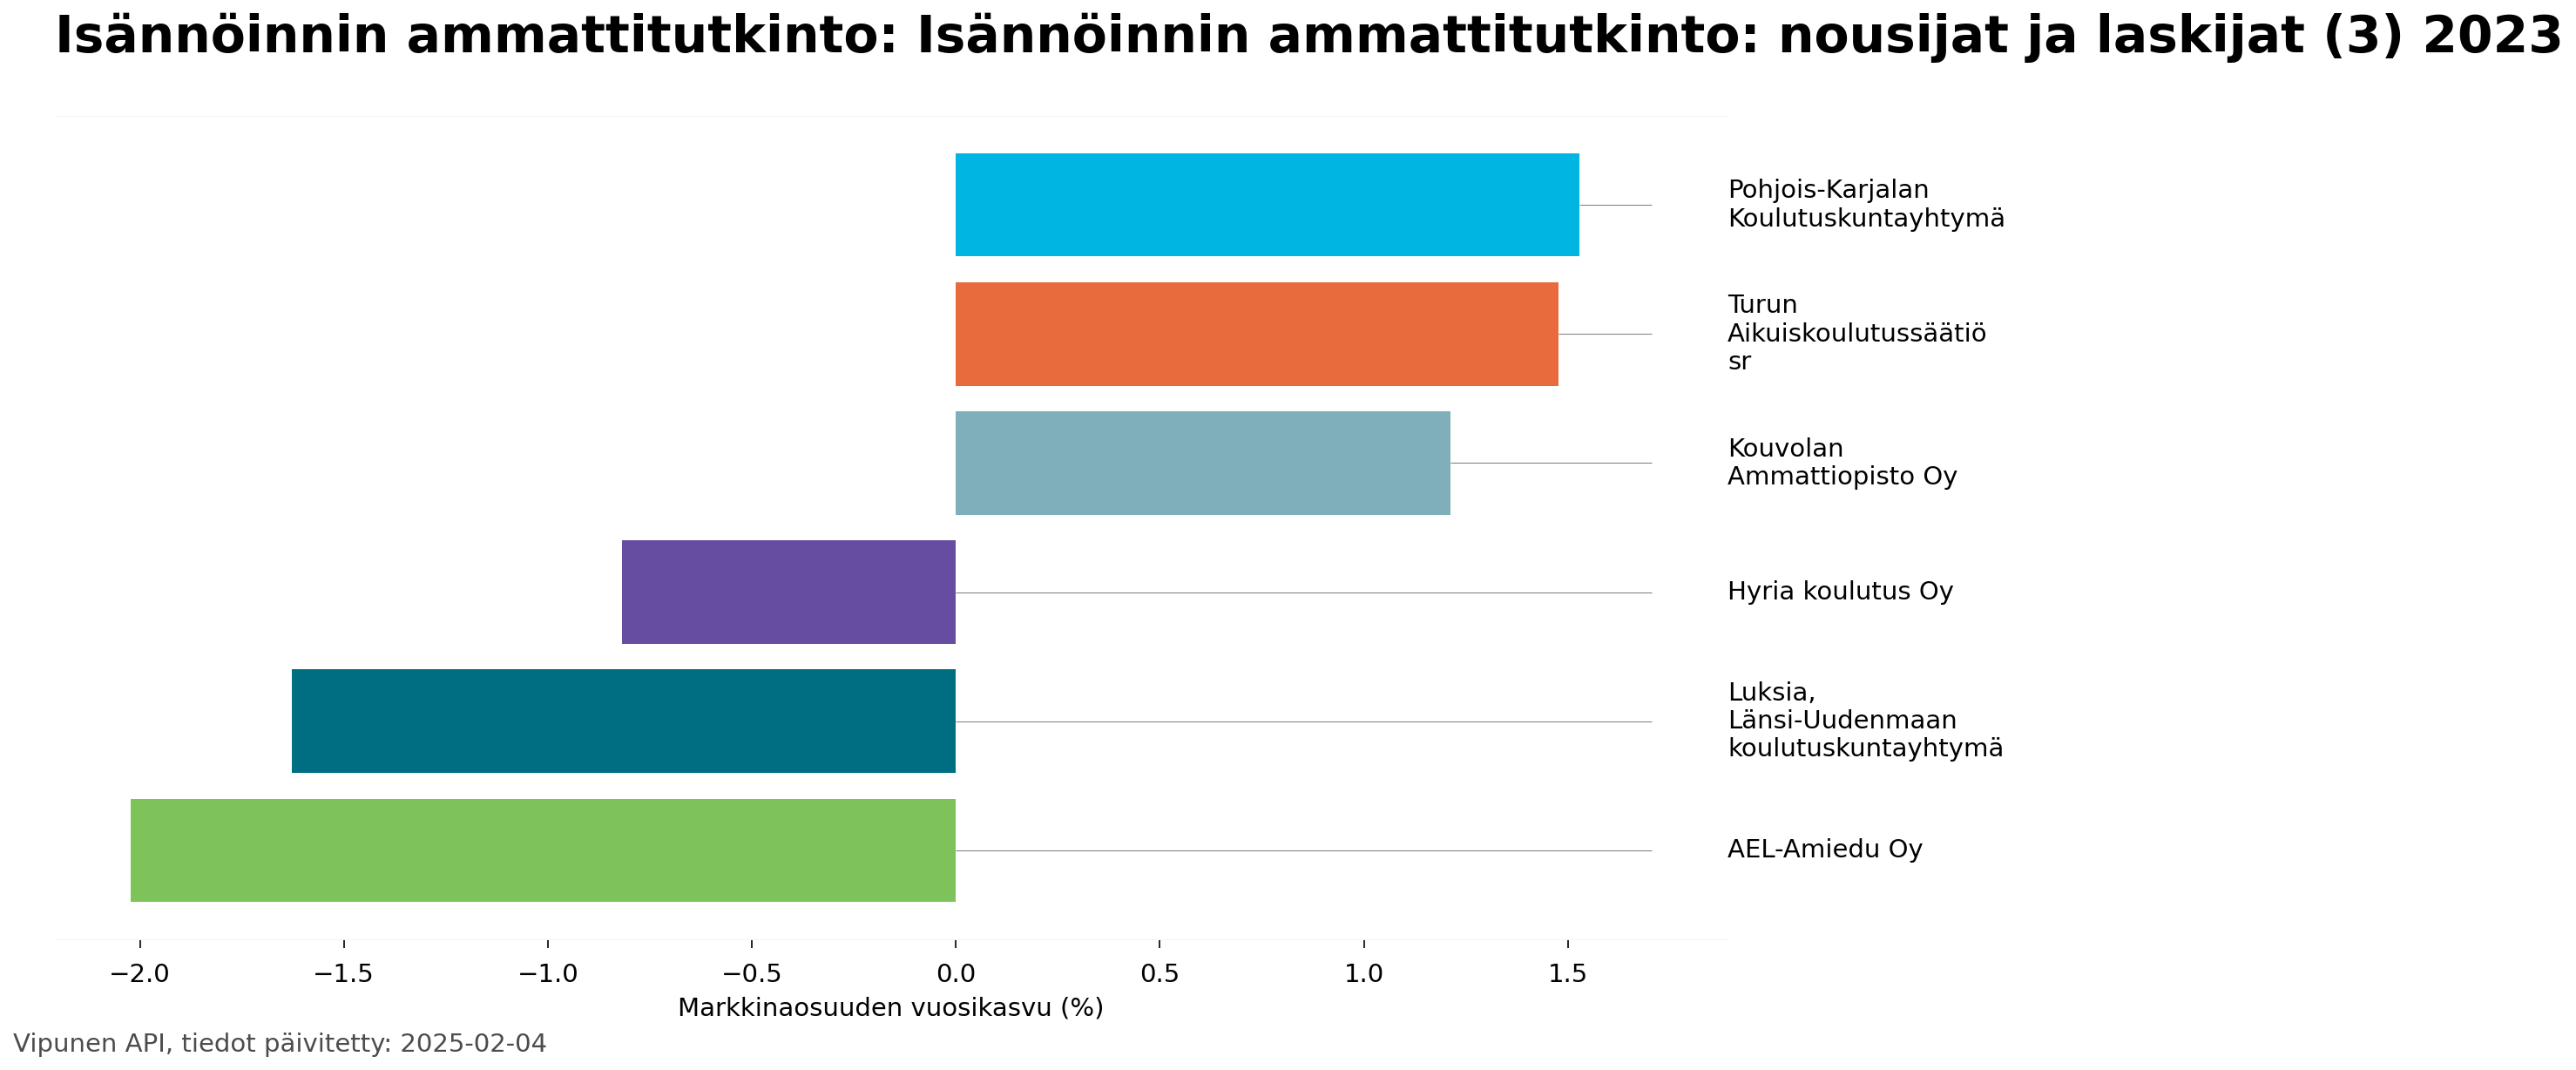

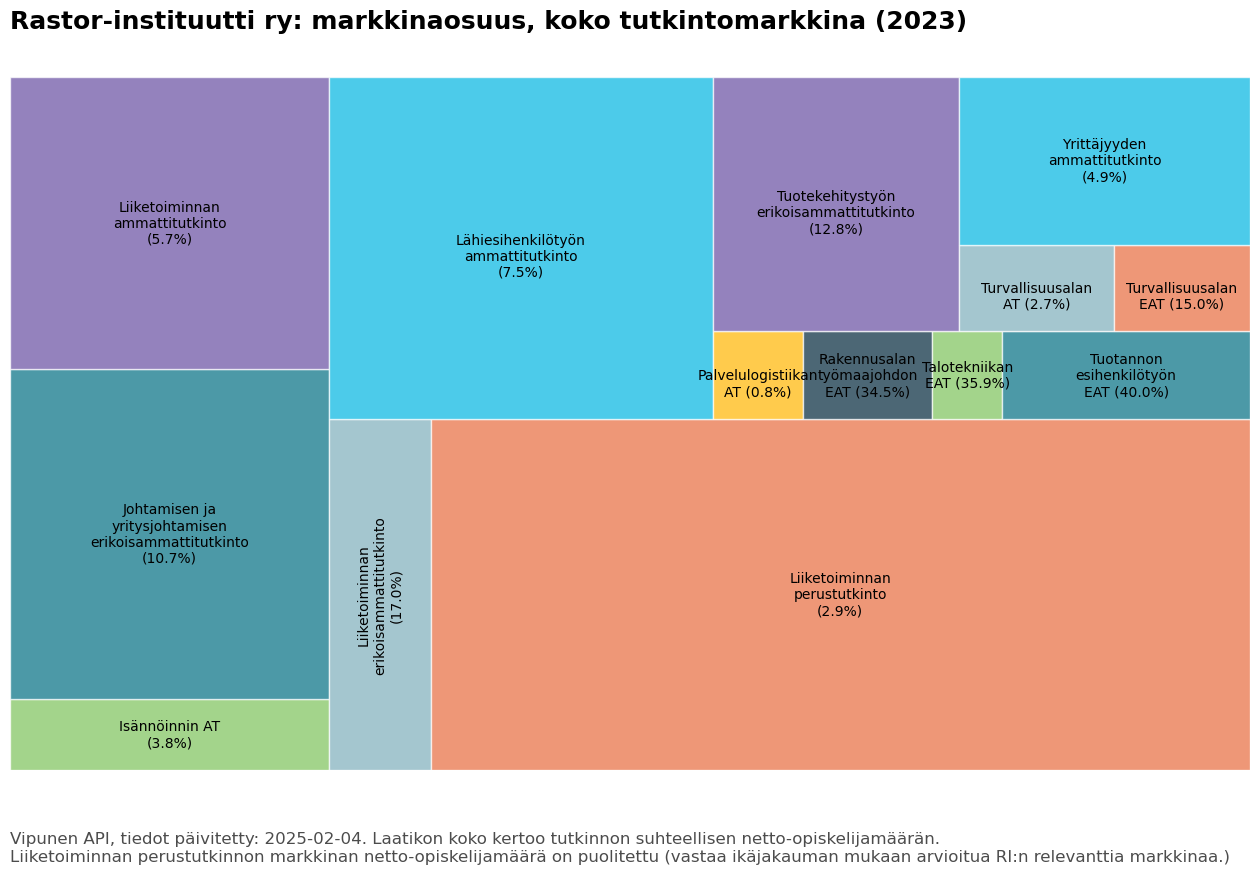

In [248]:
tarkasteltava_vuosi = 2023

# ri_markkinaosuus_tutkinnoittain
# # asetukset yksittäisen kouluttajan markkinaheatmapille
# yhden_kouluttajan_markkina = toimijoiden_markkinaosuudet_kasvu[toimijoiden_markkinaosuudet_kasvu['kouluttaja'].isin(ri_institutions_list)]
# kouluttajan_nimi = ri_institutions_list[0]
reset_plot_style()

treemap_df = yhden_kouluttajan_markkina.query('tilastovuosi == @tarkasteltava_vuosi').copy()
treemap_df.loc[treemap_df['tutkinto'] == 
               'Liiketoiminnan perustutkinto', 'nom_tutkinto yhteensa'] = treemap_df.loc[
    treemap_df['tutkinto'] == 'Liiketoiminnan perustutkinto', 'nom_tutkinto yhteensa'] / 2

lyhennykset_dict = {'erikoisammattitutkinto':'EAT', 'ammattitutkinto':'AT'}

# Iterate over rows and apply the replacements based on the condition
for idx, row in treemap_df.iterrows():
    if row['nom_tutkinto yhteensa'] < 1000:
        for key, value in lyhennykset_dict.items():
            if key in row['tutkinto']:
                treemap_df.at[idx, 'tutkinto'] = row['tutkinto'].replace(key, value)
                break

# earliest_date_formatted, latest_date_formatted = get_time_window(interest_df)
title = f"{kouluttajan_nimi}: markkinaosuus, koko tutkintomarkkina ({tarkasteltava_vuosi})"
# subtitle = f"Ajanjakso: {earliest_date_formatted}-{latest_date_formatted}"
subtitle=""
source = f"Vipunen API, tiedot päivitetty: {vipunen_haku_pvm}"
index_var="tutkinto"
# columns_var="tilastovuosi"
values_var="markkinaosuus tutkinnossa (%)"
source = f"Vipunen API, tiedot päivitetty: {vipunen_haku_pvm}. Laatikon koko kertoo tutkinnon suhteellisen netto-opiskelijamäärän. \
\nLiiketoiminnan perustutkinnon markkinan netto-opiskelijamäärä on puolitettu (vastaa ikäjakauman mukaan arvioitua RI:n relevanttia markkinaa.)"


# Function call
fig_tuple, fig = plot_generalized_treemap(
    df=treemap_df,
    size_var='nom_tutkinto yhteensa',
    label_var='tutkinto',
    value_var='markkinaosuus tutkinnossa (%)',
    title=title,
    subtitle="",
    source=source,
    wrap_text_length=15
    # color_palette=plt.cm.Set3
)

# Close the figure without the title
plt.close(fig_tuple[0])

# Append the figure with the title to your list
visualizations_for_export.append(fig_tuple)

# Display the figure with the title in the notebook
plt.show()

# Reset to default style
reset_plot_style()

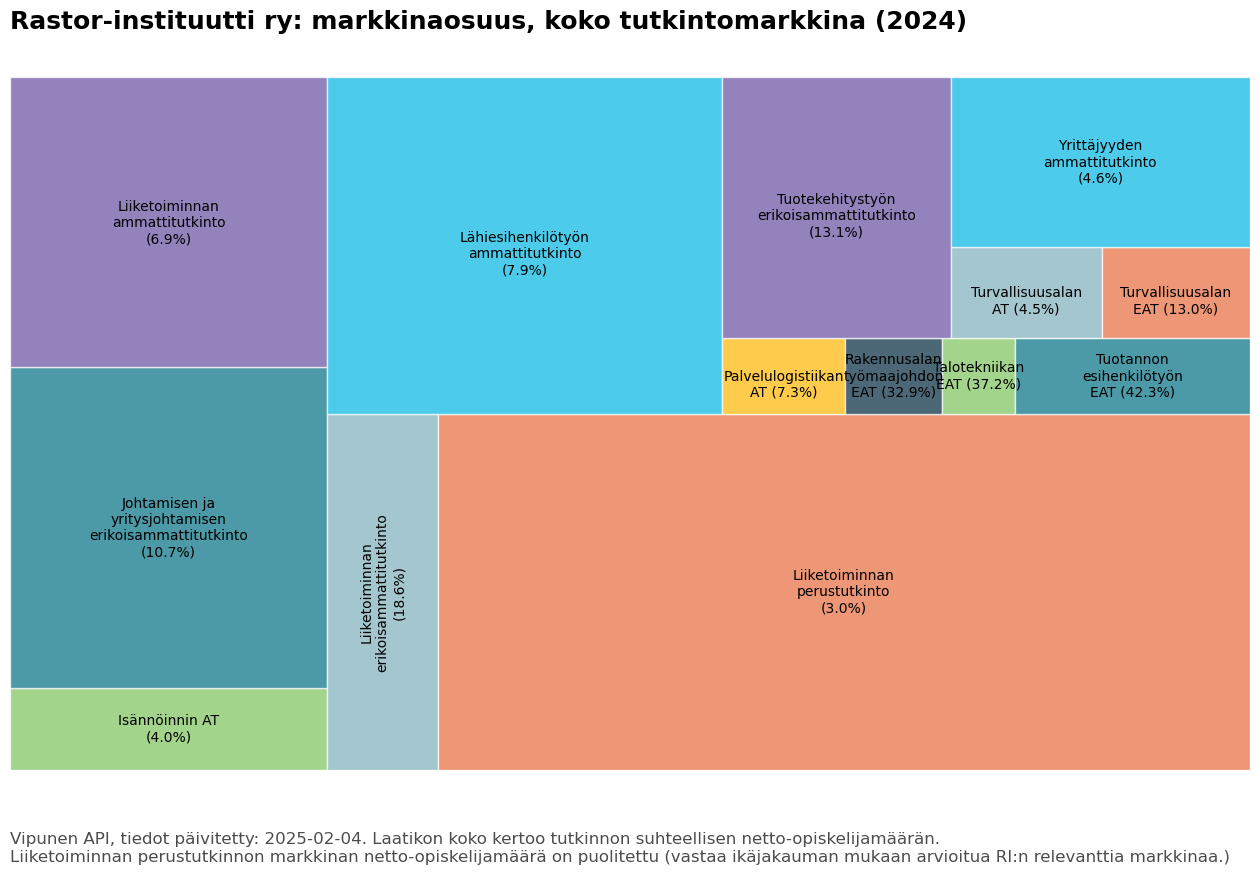

In [249]:
tarkasteltava_vuosi = 2024


# ri_markkinaosuus_tutkinnoittain
# # asetukset yksittäisen kouluttajan markkinaheatmapille
# yhden_kouluttajan_markkina = toimijoiden_markkinaosuudet_kasvu[toimijoiden_markkinaosuudet_kasvu['kouluttaja'].isin(ri_institutions_list)]
# kouluttajan_nimi = ri_institutions_list[0]
reset_plot_style()

treemap_df = yhden_kouluttajan_markkina.query('tilastovuosi == @tarkasteltava_vuosi').copy()
treemap_df.loc[treemap_df['tutkinto'] == 
               'Liiketoiminnan perustutkinto', 'nom_tutkinto yhteensa'] = treemap_df.loc[
    treemap_df['tutkinto'] == 'Liiketoiminnan perustutkinto', 'nom_tutkinto yhteensa'] / 2

lyhennykset_dict = {'erikoisammattitutkinto':'EAT', 'ammattitutkinto':'AT'}

# Iterate over rows and apply the replacements based on the condition
for idx, row in treemap_df.iterrows():
    if row['nom_tutkinto yhteensa'] < 1000:
        for key, value in lyhennykset_dict.items():
            if key in row['tutkinto']:
                treemap_df.at[idx, 'tutkinto'] = row['tutkinto'].replace(key, value)
                break

# earliest_date_formatted, latest_date_formatted = get_time_window(interest_df)
title = f"{kouluttajan_nimi}: markkinaosuus, koko tutkintomarkkina ({tarkasteltava_vuosi})"
# subtitle = f"Ajanjakso: {earliest_date_formatted}-{latest_date_formatted}"
subtitle=""
source = f"Vipunen API, tiedot päivitetty: {vipunen_haku_pvm}"
index_var="tutkinto"
# columns_var="tilastovuosi"
values_var="markkinaosuus tutkinnossa (%)"
source = f"Vipunen API, tiedot päivitetty: {vipunen_haku_pvm}. Laatikon koko kertoo tutkinnon suhteellisen netto-opiskelijamäärän. \
\nLiiketoiminnan perustutkinnon markkinan netto-opiskelijamäärä on puolitettu (vastaa ikäjakauman mukaan arvioitua RI:n relevanttia markkinaa.)"


# Function call
fig_tuple, fig = plot_generalized_treemap(
    df=treemap_df,
    size_var='nom_tutkinto yhteensa',
    label_var='tutkinto',
    value_var='markkinaosuus tutkinnossa (%)',
    title=title,
    subtitle="",
    source=source,
    wrap_text_length=15
    # color_palette=plt.cm.Set3
)

# Close the figure without the title
plt.close(fig_tuple[0])

# Append the figure with the title to your list
visualizations_for_export.append(fig_tuple)

# Display the figure with the title in the notebook
plt.show()

# Reset to default style
reset_plot_style()

In [250]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # # Sample data
# # data = {
# #     'tilastovuosi': [2018, 2019, 2020, 2021],
# #     'tutkinto': ['Product A']*4,
# #     'Järjestäjän markkinaosuus': [1.9, 2.1, 2.5, 3.0]
# # }
# df_plot = ri_markkinaosuus_tutkinnoittain.copy()

# # Filter by product
# product_df = df_plot[df_plot['tutkinto'] == 'Johtamisen ja yritysjohtamisen erikoisammattitutkinto']

# plt.figure(figsize=(10, 6))
# plt.plot(product_df['tilastovuosi'], product_df['Järjestäjän markkinaosuus'], marker='o')
# plt.xlabel('Year')
# plt.ylabel('Market Share (%)')
# plt.title('Market Share Over Years for Product A')
# plt.grid(True)
# plt.show()


#### Muut
- Alueellinen jakautuminen päätoimipaikan mukaan (esim. RI raportoi kaiken Espooseen)
- muut siten, että lasketaan sekä koulutuksenjärjestäjä että hankintakoulutuksenjärjestäjä

## Export

In [251]:
# toimijoiden_markkinaosuudet_kasvu.columns

In [252]:
# today as a string
today = datetime.today().strftime("%Y-%m-%d")

### columns of interest
# selected_for_export = ['tilastovuosi', 'tutkinto', 'nettoopiskelijamaaraLkm_as_jarjestaja',
#        'nettoopiskelijamaaraLkm_as_hankinta','kouluttaja',
#        'nom_kouluttaja yhteensa', 'järjestäjä_osuus',
#        'markkinaosuus tutkinnossa (%)', 'kouluttaja tutkintokasvu (%)',
#        'markkinaosuus tutkinnossa (%)_YoY','Sijoitus markkinassa']

tables_for_ppt_export = [ri_omien_tutkintojen_markkinassa]
# tables_for_excel_export

### all plots. Tuples with the Figure object and the title as text
# visualizations_for_export



#### Excel export

In [253]:

def export_to_excel(df_list, sheet_names, dict_list=None, dict_sheet_names=None, file_name_prefix="Vipunen_RI_data"):
    """
    Export multiple DataFrames to an Excel file with multiple sheets.
    
    Parameters:
        df_list (list): List of DataFrames to be exported.
        sheet_names (list): List of sheet names for each DataFrame.
        dict_list (list): List of dictionaries to be converted to DataFrame and exported. Default is None.
        dict_sheet_names (list): List of sheet names for each dictionary. Default is None.
        file_name_prefix (str): Prefix for the exported Excel file name. Default is 'data_export'.
        
    Returns:
        None: The function exports the Excel file.
    """
    
    # Get today's date to append to the filename
    today = datetime.today().strftime('%Y-%m-%d')
    
    # Create an Excel writer object
    excel_export_file_name = f"{file_name_prefix}_{today}.xlsx"
    
    with pd.ExcelWriter(excel_export_file_name, engine="xlsxwriter") as writer:
        # Write each DataFrame to a different worksheet
        for df, sheet_name in zip(df_list, sheet_names):
            df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # If there are dictionaries to export
        if dict_list and dict_sheet_names:
            for d, sheet_name in zip(dict_list, dict_sheet_names):
                # Convert dictionary to DataFrame
                df_dict = pd.DataFrame(list(d.items()), columns=["Key", "Value"])
                df_dict.to_excel(writer, sheet_name=sheet_name, index=False)

# DataFrames to export
dfs = list(tables_for_excel_export.values())
sheet_names = list(tables_for_excel_export.keys())

# Dictionaries to export
dicts = [kouluttajakohtaisen_taulukon_sarakkeiden_selitteet]
dict_sheet_names = ["Selitteet"]

# Call the function
export_to_excel(df_list=dfs, sheet_names=sheet_names, dict_list=dicts, dict_sheet_names=dict_sheet_names)


#### PowerPoint export

In [254]:
# visualizations_for_export=[]

In [255]:
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.shapes import MSO_SHAPE

# Unit conversion functions
def unit_converter(value, from_unit, to_unit):
    # Define conversion rates between units
    conversion_rates = {
        'cm_pt': 28.3465,
        'inch_pt': 72,
        'inch_emu': 914400,
        'cm_inch': 1 / 2.54,
        'pt_cm': 1 / 28.3465,
        'emu_inch': 1/ 914400,
        'inch_cm': 2.54,
        'cm_emu': 1/ 2.54 * 914400
    }
        
    # Build the conversion key
    conversion_key = f'{from_unit}_{to_unit}'
    
    # Perform the conversion if the key exists
    if conversion_key in conversion_rates:
        return int(value * conversion_rates[conversion_key])
    else:
        raise ValueError(f"Conversion from {from_unit} to {to_unit} is not supported.")

def cm_to_pt(cm):
    return unit_converter(cm, 'cm', 'pt')

def inch_to_pt(inch):
    return unit_converter(inch, 'inch', 'pt')

def cm_to_inch(cm):
    return unit_converter(cm, 'cm', 'inch')

def inch_to_cm(inch):
    return unit_converter(inch, 'inch', 'cm')

def pt_to_cm(pt):
    return unit_converter(pt, 'pt', 'cm')

def inch_to_emu(inch):
    return unit_converter(inch, 'inch', 'emu')

def emu_to_inch(emu):
    return unit_converter(emu, 'emu', 'inch')

def cm_to_emu(cm):
    return inch_to_emu(cm_to_inch(cm))

# Slide manipulation functions
def add_text_to_slide(slide, text, left, top, width, height, font_size=18):
    """Adds a textbox to a slide with specified dimensions and text."""
    textbox = slide.shapes.add_textbox(left, top, width, height)
    text_frame = textbox.text_frame
    p = text_frame.add_paragraph()
    p.text = text
    p.font.size = Pt(font_size)

def add_title_to_slide(slide, title_text, font_size=18):
    """Adds a title to a slide with specified font size."""
    title_placeholder = slide.shapes.title
    title_placeholder.text = title_text
    for p in title_placeholder.text_frame.paragraphs:
        for r in p.runs:
            r.font.size = Pt(font_size)

def add_plot_to_slide(prs, fig, title, layout_index, left_emu, top_emu, width_emu, height_emu, padding_inches=0.2):
    """Saves a matplotlib figure as an image and adds it to a slide."""
    slide_layout = prs.slide_layouts[layout_index]
    slide = prs.slides.add_slide(slide_layout)
    fig.savefig('temp_plot.png', bbox_inches='tight', pad_inches=padding_inches, dpi=300, transparent=True)
    slide.shapes.add_picture("temp_plot.png", left_emu, top_emu, width_emu, height_emu)
    add_title_to_slide(slide, title)

def add_table_to_slide(slide, df, left, top, width, height, header_font_size=14, cell_font_size=12):
    """Adds a table to a slide with data from a DataFrame."""
    rows, cols = df.shape
    table = slide.shapes.add_table(rows + 1, cols, left, top, width, height).table
    
    # Populate table cells with DataFrame content
    for r_idx, row in enumerate(df.itertuples(index=False), start=1):
        for c_idx, val in enumerate(row):
            cell = table.cell(r_idx, c_idx)
            cell.text = format_cell_value(val)
            set_cell_font_size(cell, cell_font_size)
            
    # Populate header cells
    for c_idx, col in enumerate(df.columns):
        cell = table.cell(0, c_idx)
        cell.text = col
        set_cell_font_size(cell, header_font_size)

def format_cell_value(val):
    """Formats the cell value for the table."""
    return "{:.1f}".format(val).replace(".", ",") if isinstance(val, float) else str(val)

def set_cell_font_size(cell, font_size):
    """Sets the font size for a table cell."""
    for paragraph in cell.text_frame.paragraphs:
        for run in paragraph.runs:
            run.font.size = Pt(font_size)

# Main function to create the presentation
def create_presentation(file_name, template_path, slide_width_emu, slide_height_emu, visualizations, tables, table_layout=6):
    prs = Presentation(template_path)
    prs.slide_width = slide_width_emu
    prs.slide_height = slide_height_emu
    
    # Constants
    margin_cm = 0.5
    margin_above_plot_pct = 1 - plot_image_top_pct
    plot_aspect_ratio = slide_width_emu / slide_height_emu
    plot_height_cm = inch_to_cm(emu_to_inch(slide_height_emu))
    plot_width_cm = plot_height_cm * plot_aspect_ratio
    
    # Calculate position and size for plots
    left_emu = 0
    top_emu = cm_to_emu(margin_above_plot_pct * plot_height_cm)
    width_emu = cm_to_emu(plot_width_cm)
    height_emu = cm_to_emu(plot_height_cm * plot_image_top_pct)
    
    # Add plots to presentation
    for fig, title in visualizations:
        add_plot_to_slide(prs, fig, title, 7, left_emu, top_emu, width_emu, height_emu)

    # Add tables to presentation
    for table in tables:
        slide_layout = prs.slide_layouts[table_layout]
        slide = prs.slides.add_slide(slide_layout)
        table_width_emu = slide_width_emu - 2 * cm_to_emu(margin_cm)
        table_height_emu = slide_height_emu - 5 * cm_to_emu(margin_cm)
        add_table_to_slide(slide, table, cm_to_emu(margin_cm), cm_to_emu(4 * margin_cm), table_width_emu, table_height_emu)

    # Save presentation
    prs.save(file_name)

# Usage example
slide_width_inches = 10
slide_height_inches = 5.625
slide_width_emu = inch_to_emu(slide_width_inches)
slide_height_emu = inch_to_emu(slide_height_inches)

ppt_export_file_name = f"Vipunen_RI_analyysi_{today}.pptx"
#create_presentation_refactored(
#     ppt_export_file_name,
#     "ri_pohja21_vipunen.pptx",
#     slide_width_emu,
#     slide_height_emu,
#     visualizations=visualizations_for_export,
#     tables=tables_for_ppt_export
# )


In [256]:
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.shapes import MSO_SHAPE

def add_text_to_slide(slide, text, left, top, width, height):
    textbox = slide.shapes.add_textbox(left, top, width, height)
    text_frame = textbox.text_frame
    p = text_frame.add_paragraph()
    p.text = text
    p.font.size = Pt(18)

def add_title_to_slide(slide, title_text):
    title_placeholder = slide.shapes.title
    title_placeholder.text = title_text
    
    # Customizing the font size
    for p in title_placeholder.text_frame.paragraphs:
        for r in p.runs:
            r.font.size = Pt(18)

# def unit_converter(value, from_unit, to_unit):
#     conversion_dict = {
#         ("cm", "pt"): lambda x: int(x * 28.3465),
#         ("inch", "pt"): lambda x: int(x * 72),
#         ("cm", "inch"): lambda x: x / 2.54,
#         ("inch", "cm"): lambda x: x * 2.54,
#         ("pt", "cm"): lambda x: x / 28.3465,
#         ("inch", "emu"): lambda x: int(x * 914400),
#         ("emu", "inch"): lambda x: int(x / 914400),
#         ("cm", "emu"): lambda x: int((x / 2.54) * 914400),
#     }
#     if (from_unit, to_unit) in conversion_dict:
#         return conversion_dict[(from_unit, to_unit)](value)
#     else:
#         raise ValueError(f"Conversion from {from_unit} to {to_unit} is not supported.")

def cm_to_pt(cm):
    return int(cm * 28.3465)
def inch_to_pt(inch):
    return int(inch * 72)
def cm_to_inch(cm):
    return cm / 2.54
def inch_to_cm(inch):
    return inch * 2.54
def pt_to_cm(pt):
    return pt / 28.3465
# 1 inch = 914400 EMUs
def inch_to_emu(inch):
    return int(inch * 914400)
def emu_to_inch(emu):
    return int(emu / 914400)
def cm_to_emu(cm):
    inch = cm_to_inch(cm)  # Convert centimeters to inches
    return inch_to_emu(inch)  # Convert inches to EMUs

def add_plot_to_slide(prs, fig, title, layout_index, left_emu, top_emu, width_emu, height_emu):
    # Original figure size (16:9 aspect ratio)
    original_width, original_height = fig.get_size_inches()

    width_emu = inch_to_emu(slide_width_inches)
    height_emu = inch_to_emu(slide_height_inches)
    left_emu = Inches((10-8.9)/2)
    top_emu = inch_to_emu(5.625)*(1-plot_image_top_pct)
    # print(width_emu, height_emu, left_emu, top_emu)
    
    # Resize the figure
    # fig.set_size_inches(new_width, new_height)
    # top_emu=0
    slide_layout = prs.slide_layouts[layout_index]
    slide = prs.slides.add_slide(slide_layout)
    # Save the figure with adjusted padding
    # Here we add more padding at the top
    # fig.savefig('temp_plot.png', pad_inches=0.2, dpi=300, transparent=True)
    fig.savefig('temp_plot.png', bbox_inches='tight', pad_inches=0.2, dpi=300, transparent=True)
    # Retrieve the current size of the figure
    current_figsize = fig.get_size_inches()
    # print(f"The current figure size is: {current_figsize[0]} inches wide by {current_figsize[1]} inches tall")

    # fig.savefig("temp_plot.png", dpi=150, transparent=True)
    slide.shapes.add_picture("temp_plot.png", left_emu, Inches(0.69), Inches(8.9))
    add_title_to_slide(slide, title)

def add_table_to_slide(slide, df, left, top, width, height):
    rows, cols = df.shape
    table = slide.shapes.add_table(rows + 1, cols, left, top, width, height).table
    
    for r_idx, row in enumerate(df.itertuples(index=False)):
        for c_idx, val in enumerate(row):
            text = (
                "{:.1f}".format(val).replace(".", ",")
                if isinstance(val, float)
                else str(val)
            )
            cell = table.cell(r_idx + 1, c_idx)
            cell.text = text
            
            # Set the font size
            for paragraph in cell.text_frame.paragraphs:
                for run in paragraph.runs:
                    run.font.size = Pt(12)  # Set the font size to 12

    # Do the same for the header
    for c_idx, col in enumerate(df.columns):
        cell = table.cell(0, c_idx)
        cell.text = col
        for paragraph in cell.text_frame.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(12)  # Set the font size to 14 for headers

def create_presentation(file_name, template_path, slide_width_emu, slide_height_emu, visualizations, tables, table_layout=6):
    prs = Presentation(template_path)
    prs.slide_width = slide_width_emu
    prs.slide_height = slide_height_emu

    margin_cm = 0.5
    margin_inches = cm_to_inch(margin_cm)
    # Calculations and constants (converted to EMU or other units)
    #  plot dimentions in cm
    # Aspect ratio of the original plots (assuming 16:9)
    ################
    ### tidy up ######
    plot_aspect_ratio = slide_width_emu / slide_height_emu
    print(emu_to_inch(slide_height_emu), emu_to_inch(slide_width_emu), plot_aspect_ratio)
    
    # # plot dimentions in cm
    plot_height_cm = inch_to_cm(slide_height_inches)#- inch_to_cm(margin*0.25)  # width in cm
    plot_width_cm = plot_height_cm * plot_aspect_ratio
    
    # same variable used when creating the plot in subplots_adjust
    margin_above_plot_pct = 1-plot_image_top_pct
    # assuming the image is 16:9 image ratio and margins are already implemented in to the image
    left_emu = 0
    top_emu = 0
    width_emu = cm_to_emu(plot_width_cm)/plot_aspect_ratio
    height_emu = cm_to_emu(plot_height_cm*plot_image_top_pct)/plot_aspect_ratio


    # # same variable used when creating the plot in subplots_adjust
    # margin_above_plot_pct = 1-plot_image_top_pct
    # # assuming the image is 16:9 image ratio and margins are already implemented in to the image
    # left_emu = 0
    # top_emu = cm_to_emu(margin_above_plot_pct*plot_height_cm)
    # width_emu = cm_to_emu(plot_width_cm)
    # height_emu = cm_to_emu(plot_height_cm*plot_image_top_pct)

    for fig, title in visualizations:  # Assuming visualizations is a list of (fig, title) tuples
        add_plot_to_slide(prs, fig, title, 7, left_emu, top_emu, width_emu, height_emu)

    slide_layout = prs.slide_layouts[table_layout]
    slide = prs.slides.add_slide(slide_layout)
    table_width_emu = slide_width_emu - 2 * cm_to_emu(margin_cm)
    table_height_emu = slide_height_emu - 5 * cm_to_emu(margin_cm)
    
    for table in tables:
        add_table_to_slide(slide, table, cm_to_emu(margin_cm), cm_to_emu(4*margin_cm), table_width_emu, table_height_emu)

    prs.save(file_name)

slide_width_inches = 10
slide_height_inches = 5.625

slide_width_emu = inch_to_emu(slide_width_inches)
slide_height_emu = inch_to_emu(slide_height_inches)

ppt_export_file_name = f"Vipunen_RI_analyysi_{today}.pptx"

template_file_path = "../data/templates/ri_pohja21_vipunen.pptx"

create_presentation(
    ppt_export_file_name,
    template_file_path,
    slide_width_emu,
    slide_height_emu,
    visualizations=visualizations_for_export,
    tables=tables_for_ppt_export
)


5 10 1.7777777777777777
